In [2]:
import jax.numpy as jnp
import numpy as np
from jax import grad, jit, vmap
from jax import random
from functools import partial

# from numba import vectorize, float64, guvectorize, njit

import time
import math
from tqdm import tqdm
import matplotlib.pyplot as plt

from jax.scipy.stats import multivariate_normal
from jax.scipy.stats import gamma
from scipy.spatial import distance
from sklearn.neighbors import KernelDensity

In [3]:
key = random.PRNGKey(68)
key1 = random.PRNGKey(6898)
key2 = random.PRNGKey(681998)
subkeys = random.split(key, 5000)

In [4]:
import jax
jax.devices()

[CpuDevice(id=0)]

In [5]:
true_theta = jnp.array([0])
mu = 0
sigma = 4
alpha = 1
beta = 0.01

In [6]:
# Generate data from normal distribution
@partial(jit, static_argnames=['dataset_size','num_datasets'])
def normal_data(theta, dataset_size, num_datasets):
    N = jnp.sqrt(sigma) * ((jnp.array(np.random.gamma(alpha, (1/beta), (num_datasets, dataset_size)))) - (alpha/beta)) / jnp.sqrt(alpha/(beta**2))
    data = N + theta
    return data

In [7]:
actual_data = normal_data(true_theta, 30, 1)
actual_data

DeviceArray([[ 0.3407585 , -1.1354048 ,  2.3762708 , -1.2751851 ,
               2.663401  , -0.36266068, -1.7490927 , -1.4335724 ,
              -0.627812  ,  2.6413355 , -1.0779347 , -1.6582195 ,
               3.970128  ,  0.76864654,  2.178041  ,  3.944906  ,
               4.1923985 , -0.7096701 , -1.0135574 , -1.9788055 ,
               1.1083599 , -1.8731704 ,  1.4974271 , -1.1967607 ,
               0.6926288 , -1.914601  , -1.8348913 , -0.03793411,
              -1.7892262 , -0.8007888 ]], dtype=float32)

In [8]:
# CALCULATE SUMMARY STATS
@jit
def normal_data_ss(data):
  mean_normal_data = jnp.mean(data)
  std_normal_data = jnp.var(data)
  return jnp.array([mean_normal_data, std_normal_data])

In [9]:
actual_summary_statistics = normal_data_ss(actual_data)
actual_summary_statistics

DeviceArray([0.13016713, 3.7080524 ], dtype=float32)

In [10]:
num_coeffs = np.shape(true_theta)[0]
num_latent = 2
len_ss = np.shape(actual_summary_statistics)[0]
n_samples = 30
num_datasets = 200
lambda_dim = num_coeffs + int((num_coeffs * (num_coeffs + 1)) / 2)

sigma_theta = 10
sigma_latent = 1

In [11]:
def summary_statistics(theta, n_samples, n_datasets):
    datasets = normal_data(theta, n_samples, n_datasets)
    n_summary_statistics = jnp.array([normal_data_ss(datasets[i,:]) for i in range(n_datasets)])
    sample_mean = jnp.mean(n_summary_statistics, axis = 0)
    sample_variance = jnp.cov(n_summary_statistics.T)
    return sample_mean, sample_variance

In [12]:
def mean_adjustment_summary_statistics(adjusted_theta, n_samples, n_datasets):
    theta = adjusted_theta[0:num_coeffs]
    Gamma = adjusted_theta[-num_latent:]
    sample_mean, sample_variance = summary_statistics(theta, n_samples, n_datasets)

    adjusted_sample_mean = sample_mean + jnp.diag(jnp.sqrt(sample_variance)) * Gamma
    return adjusted_sample_mean, sample_variance

In [13]:
def my_inv(x):
    return jnp.linalg.inv(x + (jnp.eye(x.shape[0]) * 1e-7))

In [14]:
@partial(jit, static_argnames=['sigma_theta','num_coeffs'])
def prior(theta, sigma_theta, num_coeffs):
    log_prior = multivariate_normal.logpdf(theta, mean = jnp.array([0] * num_coeffs), cov= sigma_theta * jnp.identity(num_coeffs))
    return log_prior

In [15]:
def mean_adjustment_unbiased_log_likelihood(gs_adjusted_theta, n_samples, num_datasets):
    mean_adjust_ss = mean_adjustment_summary_statistics(gs_adjusted_theta, n_samples, num_datasets)
    adjusted_sample_mean = mean_adjust_ss[0]
    sample_variance = mean_adjust_ss[1]
    u_est_log_likelihood = multivariate_normal.logpdf(actual_summary_statistics, mean = adjusted_sample_mean, cov= sample_variance)    # diff_mean_s = actual_summary_statistics - sample_mean
    # part1 = diff_mean_s.T @ my_inv(sample_variance) @ diff_mean_s
    # u_est_log_likelihood = -1/2 * jnp.linalg.slogdet(sample_variance)[1] -1/2 * part1
    return u_est_log_likelihood

In [16]:
@jit
def nuissance_mean_adjustment_unbiased_log_likelihood(Gamma, mean_nuissance, variance_nuissance):
    nuissance_mean_u_est_log_likelihood = multivariate_normal.logpdf(Gamma, mean = mean_nuissance, cov= variance_nuissance)
    return nuissance_mean_u_est_log_likelihood

In [17]:
@jit
def fun_log_q(theta, mu, l):
    log_q = multivariate_normal.logpdf(theta, mean = mu, cov= my_inv(l @ l.T))
    return log_q

In [18]:
@partial(jit, static_argnames=['num_coeffs'])
def gradient_log_q(theta, mu, l, num_coeffs): #indep theta
    gradient_log_q_mu = l @ l.T @ (theta - mu)
    # gradient_log_q_l = (np.diag(np.linalg.inv(l)) - np.matmul(((np.reshape(theta - mu, (num_coeffs,1))) * theta - mu), l)).T[np.triu_indices(num_coeffs)] #use * because matmul gives scalar
    diag_inv_l = jnp.zeros_like(l, shape=(num_coeffs,num_coeffs)).at[jnp.diag_indices_from(l)].set(jnp.diag(l))
    gradient_log_q_l = (diag_inv_l - jnp.reshape(theta - mu, (num_coeffs,1)) @ jnp.reshape(theta - mu, (1,num_coeffs)) @ l).T[jnp.triu_indices(num_coeffs)] #use * because matmul gives scalar
    return gradient_log_q_mu, gradient_log_q_l

In [19]:
@jit
def control_variates(Flat_grad_log_q, Flat_grad_lb):
    c = []
    stacked_gradient_lb = jnp.stack(Flat_grad_lb)
    stacked_gradient_log_q = jnp.stack(Flat_grad_log_q)
    for i in range(lambda_dim):
        sample_cov = jnp.cov(stacked_gradient_lb[:, i], stacked_gradient_log_q[:, i])
        c_i = sample_cov[0, 1] / sample_cov[1, 1]
        c.append(c_i)
    c_mu = jnp.array(c[0:num_coeffs])
    c_vech_l = jnp.array(c[num_coeffs:])
    return c_mu, c_vech_l

In [20]:
class GVB:
    def __init__(self, samples, actual_summary_statistics, learning_rate, threshold, l_threshold, adaptive_lr_1, adaptive_lr_2, t_w, Patience):
        self.samples = samples
        self.actual_summary_statistics = actual_summary_statistics
        self.num_coeffs = np.shape(true_theta)[0] # number of coeffs
        self.learning_rate = learning_rate
        self.threshold = threshold
        self.l_threshold = l_threshold
        self.adaptive_lr_1 = adaptive_lr_1
        self.adaptive_lr_2 = adaptive_lr_2
        self.t_w = t_w
        self.Patience = Patience

    def fun_gradient_lb(self, theta_q, mu_q, l_q, c_mu, c_l):
        ss_q = summary_statistics(theta_q, n_samples, num_datasets)
        sample_mean_q = ss_q[0]
        sample_variance_q = ss_q[1]
        # Nuissance mean and variance
        mean_nuissance_p1_non_inv = jnp.identity(num_latent) / sigma_latent + jnp.diag(jnp.sqrt(sample_variance_q)).T @ jnp.linalg.solve(sample_variance_q, jnp.diag(jnp.sqrt(sample_variance_q)))
        # mean_nuissance_p1_non_inv_unreg = mean_nuissance_p1_non_inv + (jnp.eye(mean_nuissance_p1_non_inv.shape[0]) * 5 * 1e-7)
        mean_nuissance_p1 = jnp.linalg.solve(mean_nuissance_p1_non_inv, jnp.eye(mean_nuissance_p1_non_inv.shape[0]))
        # mean_nuissance_p1 = jnp.linalg.solve(mean_nuissance_p1_non_inv, jnp.eye(mean_nuissance_p1_non_inv.shape[0]))

        diag_var = jnp.zeros((num_latent, num_latent)).at[jnp.diag_indices_from(sample_variance_q)].set(jnp.diag(jnp.sqrt(sample_variance_q)))
        diff_mean = self.actual_summary_statistics - sample_mean_q
        mean_nuissance_p2 = diag_var @ jnp.linalg.solve(sample_variance_q, diff_mean)
        mean_nuissance_q = mean_nuissance_p1 @ mean_nuissance_p2
        variance_nuissance_q = mean_nuissance_p1

        # Generate Gamma

        Gamma = random.multivariate_normal(key2, mean = mean_nuissance_q, cov = variance_nuissance_q)
        adjusted_theta_q = jnp.concatenate((theta_q, Gamma))

        # Find gradient of LB
        llh = mean_adjustment_unbiased_log_likelihood(adjusted_theta_q, n_samples, num_datasets)
        llh_gamma = nuissance_mean_adjustment_unbiased_log_likelihood(Gamma, mean_nuissance_q, variance_nuissance_q)

        h_lambda = prior(theta_q, sigma_theta, num_coeffs) + prior(Gamma, sigma_latent, num_latent) + llh - fun_log_q(theta_q, mu_q, l_q) - llh_gamma

        # Find gradient of LB
        grad_log_q_mu, grad_log_q_l = gradient_log_q(theta_q, mu_q, l_q, num_coeffs)
        gradient_lb_mu = grad_log_q_mu * (h_lambda - c_mu)
        gradient_lb_l = grad_log_q_l * (h_lambda - c_l)
        # Calculate control variates
        flattened_gradient_log_q = jnp.concatenate((grad_log_q_mu, grad_log_q_l), axis = None)
        flattened_gradient_lb = jnp.concatenate((gradient_lb_mu, gradient_lb_l), axis = None)

        return gradient_lb_mu, gradient_lb_l, h_lambda, flattened_gradient_log_q, flattened_gradient_lb

    def vb_posterior(self, stop):
        # Initialize mu_0, L_0
        # mu_0 = np.array([np.log((self.actual_summary_statistics[0]-1.1)/(2-self.actual_summary_statistics[0])), np.log((1+self.actual_summary_statistics[1])/(1-self.actual_summary_statistics[1])), np.log(self.actual_summary_statistics[2]), self.actual_summary_statistics[3]])
        #mu_0 = np.array([1.5, 0.5, 3, 0])
        mu_0 = jnp.array([0])
        #mu_0 = np.array([self.actual_summary_statistics[0], self.actual_summary_statistics[1], self.actual_summary_statistics[2], self.actual_summary_statistics[3]])
        # mu_0 = np.array([0] * self.num_coeffs)
        l_0 = jnp.tril(jnp.identity(self.num_coeffs) * 10)
        Sigma_0_inv = l_0 @ l_0.T
        Sigma_0 = my_inv(Sigma_0_inv)
        ### Change ways to get vech(l0)
        vech_l0 = l_0.T[jnp.triu_indices(self.num_coeffs)]

        # Initilize best lambda
        lambda_best_mu = mu_0
        lambda_best_l = vech_l0
        # List of calculations of LB
        LB_all = []
        LB_Smoothed = []
        patience = 0
        # List of flattened gradients
        Flattened_gradient_lb = []
        Flattened_gradient_log_q = []

        func_auto = vmap(self.fun_gradient_lb, in_axes=[0, None, None, None, None])

        for t in tqdm(range(stop)):
            if t == 0:
                # Draw samples of theta from  variational q
                # List of gradients
                theta_0_samples = random.multivariate_normal(subkeys[t], mean = mu_0, cov = Sigma_0, shape = (self.samples,))
                gradient_lb_mu_0, gradient_lb_l_0, lb_0, Flattened_gradient_log_q, Flattened_gradient_lb = func_auto(theta_0_samples, mu_0, l_0, 0, 0)
                # Calculate control variates using all samples
                c_mu, c_vech_l = control_variates(Flattened_gradient_log_q, Flattened_gradient_lb)
                # Update lambda_q
                self.g_mu_init = jnp.mean(gradient_lb_mu_0, axis = 0)
                self.g_vech_l_init = jnp.mean(gradient_lb_l_0, axis = 0)
                # Gradient clipping
                if jnp.linalg.norm(jnp.concatenate((self.g_mu_init, self.g_vech_l_init), axis = None)) > self.l_threshold:
                    self.g_mu_init = self.l_threshold * self.g_mu_init / jnp.linalg.norm(jnp.concatenate((self.g_mu_init, self.g_vech_l_init), axis = None))
                    self.g_vech_l_init = self.l_threshold * self.g_vech_l_init / jnp.linalg.norm(jnp.concatenate((self.g_mu_init, self.g_vech_l_init), axis = None))
                self.v_mu_init = self.g_mu_init ** 2
                self.v_vech_l_init = self.g_vech_l_init ** 2
                # Calculate lower bound
                LB_all.append(jnp.mean(lb_0))
                print('LB', (jnp.mean(lb_0)))
                lambda_q_mu = mu_0
                lambda_q_l = vech_l0
            if t > 0:
                # From lambda_q find mu_q and L_q
                mu_q = lambda_q_mu

                ### Change ways to convert from vech_l0 to l0
                vech_lq = list(lambda_q_l)
                l_q = jnp.zeros((self.num_coeffs, self.num_coeffs))
                # l_q[:, 0] = lambda_q[1][0:self.num_coeffs]
                # l_q[1:self.num_coeffs, 1] = lambda_q[1][4:7]
                # l_q[2:self.num_coeffs, 2] = lambda_q[1][7:9]
                # l_q[3:self.num_coeffs, 3] = lambda_q[1][9:10]
                for i in range(self.num_coeffs):
                    l_q = l_q.at[i:self.num_coeffs,i].set(vech_lq[:self.num_coeffs - i])
                    del vech_lq[:self.num_coeffs-i]

                Sigma_q_inv = l_q @ l_q.T
                Sigma_q =  my_inv(Sigma_q_inv)
                l_q_inv =  my_inv(l_q)
                # List of gradients
                Gradient_lb = []
                lb_t = []
                theta_q_samples = random.multivariate_normal(subkeys[t], mean = mu_q, cov = Sigma_q, shape = (self.samples,))
                gradient_lb_mu, gradient_lb_l, lb_t, Flattened_gradient_log_q, Flattened_gradient_lb = func_auto(theta_q_samples, mu_q, l_q, c_mu, c_vech_l)
                # Update control variates
                c_mu, c_vech_l = control_variates(Flattened_gradient_log_q, Flattened_gradient_lb)
                # Update lambda_q
                g_mu_t = jnp.mean(gradient_lb_mu, axis = 0)
                g_vech_l_t = jnp.mean(gradient_lb_l, axis = 0)

                # Gradient clipping
                if jnp.linalg.norm(jnp.concatenate((g_mu_t, g_vech_l_t), axis = None)) > self.l_threshold:
                    g_mu_t = self.l_threshold * g_mu_t / jnp.linalg.norm(jnp.concatenate((g_mu_t, g_vech_l_t), axis = None))
                    g_vech_l_t = self.l_threshold * g_vech_l_t / jnp.linalg.norm(jnp.concatenate((g_mu_t, g_vech_l_t), axis = None))
                v_mu_t = g_mu_t ** 2
                v_vech_l_t = g_vech_l_t ** 2
                #---- Update lambda
                self.g_mu_init = self.adaptive_lr_1 * self.g_mu_init + (1 - self.adaptive_lr_1) * g_mu_t
                self.g_vech_l_init = self.adaptive_lr_1 * self.g_vech_l_init + (1 - self.adaptive_lr_1) * g_vech_l_t

                self.v_mu_init = self.adaptive_lr_2 * self.v_mu_init + (1 - self.adaptive_lr_2) * v_mu_t
                self.v_vech_l_init = self.adaptive_lr_2 * self.v_vech_l_init + (1 - self.adaptive_lr_2) * v_vech_l_t

                if t >= self.threshold:
                    update_t = self.learning_rate * self.threshold / t
                else:
                    update_t = self.learning_rate

                lambda_q_mu = lambda_q_mu + update_t * self.g_mu_init / (self.v_mu_init ** 0.5)
                lambda_q_l = lambda_q_l + update_t * self.g_vech_l_init / (self.v_vech_l_init ** 0.5)

                # Calculate lower bound
                LB_all.append(jnp.mean(lb_t))

                if t < self.t_w:
                    print('LB', jnp.mean(lb_t))

                if t >= self.t_w:
                    LB_smoothed = jnp.mean(jnp.array(LB_all[t - self.t_w + 1 : t]))
                    print('LB Smoothed', LB_smoothed)
                    LB_Smoothed.append(LB_smoothed)
                    if LB_smoothed >= jnp.max(jnp.array(LB_Smoothed)):
                        patience = 0
                        lambda_best_mu = lambda_q_mu
                        lambda_best_l = lambda_q_l
                    else:
                        patience += 1
                        if patience > self.Patience:
                            print("Stop at", t)
                            break

        return LB_all, LB_Smoothed, lambda_best_mu, lambda_best_l

In [21]:
# Set hyperparameters
stop = 4000

In [ ]:
# %debug
vb = GVB(200, actual_summary_statistics, 0.001, 2500, 100, 0.9, 0.9, 150, 50)
LB_estimate, smoothed_LB_estimate, best_lambda_mu, best_lambda_l = vb.vb_posterior(stop)

  0%|          | 1/4000 [00:02<2:51:54,  2.58s/it]

LB -6.556633


  0%|          | 2/4000 [00:04<2:19:46,  2.10s/it]

LB -6.527634


  0%|          | 3/4000 [00:06<2:16:17,  2.05s/it]

LB -6.725752


  0%|          | 4/4000 [00:09<2:36:48,  2.35s/it]

LB -6.522207


  0%|          | 5/4000 [00:11<2:44:56,  2.48s/it]

LB -6.327666


  0%|          | 6/4000 [00:13<2:29:25,  2.24s/it]

LB -6.4597254


  0%|          | 7/4000 [00:15<2:18:24,  2.08s/it]

LB -6.511099


  0%|          | 8/4000 [00:17<2:12:08,  1.99s/it]

LB -6.4067864


  0%|          | 9/4000 [00:18<2:06:40,  1.90s/it]

LB -6.1819925


  0%|          | 10/4000 [00:20<2:02:44,  1.85s/it]

LB -6.48647


  0%|          | 11/4000 [00:23<2:16:54,  2.06s/it]

LB -6.407118


  0%|          | 12/4000 [00:25<2:13:44,  2.01s/it]

LB -6.412017


  0%|          | 13/4000 [00:26<2:08:09,  1.93s/it]

LB -6.372662


  0%|          | 14/4000 [00:28<2:04:52,  1.88s/it]

LB -6.4031777


  0%|          | 15/4000 [00:30<2:01:44,  1.83s/it]

LB -6.4409146


  0%|          | 16/4000 [00:32<2:00:02,  1.81s/it]

LB -6.2092447


  0%|          | 17/4000 [00:33<2:02:36,  1.85s/it]

LB -6.3606195


  0%|          | 18/4000 [00:36<2:15:48,  2.05s/it]

LB -6.4157195


  0%|          | 19/4000 [00:38<2:10:54,  1.97s/it]

LB -6.3008885


  0%|          | 20/4000 [00:40<2:07:36,  1.92s/it]

LB -6.3739


  1%|          | 21/4000 [00:41<2:04:10,  1.87s/it]

LB -6.2219543


  1%|          | 22/4000 [00:43<2:02:42,  1.85s/it]

LB -6.256584


  1%|          | 23/4000 [00:45<2:05:30,  1.89s/it]

LB -6.169022


  1%|          | 24/4000 [00:48<2:19:13,  2.10s/it]

LB -5.9804163


  1%|          | 25/4000 [00:50<2:17:32,  2.08s/it]

LB -6.1341934


  1%|          | 26/4000 [00:52<2:12:31,  2.00s/it]

LB -5.9605613


  1%|          | 27/4000 [00:53<2:09:07,  1.95s/it]

LB -6.102452


  1%|          | 28/4000 [00:55<2:07:02,  1.92s/it]

LB -6.0545106


  1%|          | 29/4000 [00:57<2:04:22,  1.88s/it]

LB -6.2853575


  1%|          | 30/4000 [00:59<2:10:46,  1.98s/it]

LB -6.2038016


  1%|          | 31/4000 [01:02<2:18:40,  2.10s/it]

LB -6.0862913


  1%|          | 32/4000 [01:03<2:12:41,  2.01s/it]

LB -5.6605887


  1%|          | 33/4000 [01:05<2:08:03,  1.94s/it]

LB -6.0386376


  1%|          | 34/4000 [01:07<2:04:19,  1.88s/it]

LB -5.9649925


  1%|          | 35/4000 [01:09<2:01:41,  1.84s/it]

LB -6.252943


  1%|          | 36/4000 [01:10<2:00:18,  1.82s/it]

LB -6.1708813


  1%|          | 37/4000 [01:13<2:15:23,  2.05s/it]

LB -6.2099466


  1%|          | 38/4000 [01:15<2:11:41,  1.99s/it]

LB -6.314308


  1%|          | 39/4000 [01:17<2:07:48,  1.94s/it]

LB -6.1742797


  1%|          | 40/4000 [01:19<2:05:16,  1.90s/it]

LB -6.01536


  1%|          | 41/4000 [01:20<2:03:21,  1.87s/it]

LB -5.785709


  1%|          | 42/4000 [01:22<2:01:21,  1.84s/it]

LB -5.8792443


  1%|          | 43/4000 [01:24<2:06:35,  1.92s/it]

LB -5.8172483


  1%|          | 44/4000 [01:27<2:16:27,  2.07s/it]

LB -5.885448


  1%|          | 45/4000 [01:28<2:11:02,  1.99s/it]

LB -5.7263837


  1%|          | 46/4000 [01:30<2:06:50,  1.92s/it]

LB -6.0002904


  1%|          | 47/4000 [01:32<2:04:47,  1.89s/it]

LB -6.07435


  1%|          | 48/4000 [01:34<2:02:05,  1.85s/it]

LB -5.901426


  1%|          | 49/4000 [01:36<2:00:05,  1.82s/it]

LB -5.976731


  1%|▏         | 50/4000 [01:38<2:13:45,  2.03s/it]

LB -5.7824597


  1%|▏         | 51/4000 [01:40<2:12:52,  2.02s/it]

LB -5.678071


  1%|▏         | 52/4000 [01:42<2:07:57,  1.94s/it]

LB -5.5893087


  1%|▏         | 53/4000 [01:44<2:04:17,  1.89s/it]

LB -5.735879


  1%|▏         | 54/4000 [01:45<2:01:54,  1.85s/it]

LB -5.80147


  1%|▏         | 55/4000 [01:47<1:59:43,  1.82s/it]

LB -5.9067936


  1%|▏         | 56/4000 [01:49<2:01:15,  1.84s/it]

LB -5.728414


  1%|▏         | 57/4000 [01:52<2:19:31,  2.12s/it]

LB -5.9222717


  1%|▏         | 58/4000 [01:54<2:27:29,  2.24s/it]

LB -5.6091623


  1%|▏         | 59/4000 [01:56<2:17:50,  2.10s/it]

LB -5.565677


  2%|▏         | 60/4000 [01:58<2:12:10,  2.01s/it]

LB -5.8941026


  2%|▏         | 61/4000 [02:00<2:07:14,  1.94s/it]

LB -5.5509677


  2%|▏         | 62/4000 [02:01<2:03:50,  1.89s/it]

LB -5.6561146


  2%|▏         | 63/4000 [02:04<2:18:32,  2.11s/it]

LB -5.6937814


  2%|▏         | 64/4000 [02:06<2:10:34,  1.99s/it]

LB -5.481247


  2%|▏         | 65/4000 [02:07<2:05:10,  1.91s/it]

LB -5.6594024


  2%|▏         | 66/4000 [02:09<2:02:27,  1.87s/it]

LB -5.781625


  2%|▏         | 67/4000 [02:11<1:59:46,  1.83s/it]

LB -5.7020154


  2%|▏         | 68/4000 [02:13<1:58:23,  1.81s/it]

LB -5.473102


  2%|▏         | 69/4000 [02:15<2:05:02,  1.91s/it]

LB -5.732729


  2%|▏         | 70/4000 [02:17<2:13:15,  2.03s/it]

LB -5.516261


  2%|▏         | 71/4000 [02:19<2:08:54,  1.97s/it]

LB -5.4706774


  2%|▏         | 72/4000 [02:21<2:04:39,  1.90s/it]

LB -5.4747987


  2%|▏         | 73/4000 [02:23<2:02:28,  1.87s/it]

LB -5.5487804


  2%|▏         | 74/4000 [02:24<2:00:19,  1.84s/it]

LB -5.624015


  2%|▏         | 75/4000 [02:26<1:58:52,  1.82s/it]

LB -5.4555755


  2%|▏         | 76/4000 [02:29<2:13:44,  2.05s/it]

LB -5.510995


  2%|▏         | 77/4000 [02:31<2:10:53,  2.00s/it]

LB -5.40167


  2%|▏         | 78/4000 [02:32<2:06:38,  1.94s/it]

LB -5.3161793


  2%|▏         | 79/4000 [02:34<2:03:26,  1.89s/it]

LB -5.466328


  2%|▏         | 80/4000 [02:36<2:01:13,  1.86s/it]

LB -5.43243


  2%|▏         | 81/4000 [02:38<1:59:54,  1.84s/it]

LB -5.5950584


  2%|▏         | 82/4000 [02:40<2:04:47,  1.91s/it]

LB -5.4909286


  2%|▏         | 83/4000 [02:42<2:15:33,  2.08s/it]

LB -5.385023


  2%|▏         | 84/4000 [02:44<2:10:56,  2.01s/it]

LB -5.5662603


  2%|▏         | 85/4000 [02:46<2:06:49,  1.94s/it]

LB -5.504358


  2%|▏         | 86/4000 [02:48<2:03:52,  1.90s/it]

LB -5.161242


  2%|▏         | 87/4000 [02:49<2:01:46,  1.87s/it]

LB -5.3859143


  2%|▏         | 88/4000 [02:51<2:03:57,  1.90s/it]

LB -5.3930697


  2%|▏         | 89/4000 [02:54<2:19:25,  2.14s/it]

LB -5.4403152


  2%|▏         | 90/4000 [02:56<2:13:35,  2.05s/it]

LB -5.525823


  2%|▏         | 91/4000 [02:58<2:08:22,  1.97s/it]

LB -5.279082


  2%|▏         | 92/4000 [03:00<2:05:01,  1.92s/it]

LB -5.3935447


  2%|▏         | 93/4000 [03:01<2:02:06,  1.88s/it]

LB -5.2566786


  2%|▏         | 94/4000 [03:03<2:00:27,  1.85s/it]

LB -5.1877975


  2%|▏         | 95/4000 [03:05<2:05:41,  1.93s/it]

LB -5.153805


  2%|▏         | 96/4000 [03:08<2:14:10,  2.06s/it]

LB -5.259541


  2%|▏         | 97/4000 [03:09<2:08:23,  1.97s/it]

LB -5.2104125


  2%|▏         | 98/4000 [03:11<2:05:39,  1.93s/it]

LB -5.171187


  2%|▏         | 99/4000 [03:13<2:04:03,  1.91s/it]

LB -5.295723


  2%|▎         | 100/4000 [03:15<2:01:20,  1.87s/it]

LB -5.1501513


  3%|▎         | 101/4000 [03:17<1:58:58,  1.83s/it]

LB -5.1878147


  3%|▎         | 102/4000 [03:19<2:15:09,  2.08s/it]

LB -5.2639728


  3%|▎         | 103/4000 [03:21<2:10:38,  2.01s/it]

LB -5.0655603


  3%|▎         | 104/4000 [03:23<2:06:31,  1.95s/it]

LB -4.9436984


  3%|▎         | 105/4000 [03:25<2:03:57,  1.91s/it]

LB -5.092314


  3%|▎         | 106/4000 [03:26<2:01:00,  1.86s/it]

LB -5.060031


  3%|▎         | 107/4000 [03:28<1:59:35,  1.84s/it]

LB -4.959424


  3%|▎         | 108/4000 [03:30<2:06:09,  1.94s/it]

LB -5.0472136


  3%|▎         | 109/4000 [03:33<2:13:38,  2.06s/it]

LB -4.8662686


  3%|▎         | 110/4000 [03:35<2:08:28,  1.98s/it]

LB -5.186012


  3%|▎         | 111/4000 [03:36<2:03:48,  1.91s/it]

LB -4.972456


  3%|▎         | 112/4000 [03:38<2:02:52,  1.90s/it]

LB -5.005416


  3%|▎         | 113/4000 [03:40<2:01:13,  1.87s/it]

LB -4.990448


  3%|▎         | 114/4000 [03:42<2:00:06,  1.85s/it]

LB -5.0465655


  3%|▎         | 115/4000 [03:44<2:15:31,  2.09s/it]

LB -5.0547733


  3%|▎         | 116/4000 [03:46<2:11:02,  2.02s/it]

LB -4.989165


  3%|▎         | 117/4000 [03:48<2:07:38,  1.97s/it]

LB -5.0623183


  3%|▎         | 118/4000 [03:50<2:04:28,  1.92s/it]

LB -5.174197


  3%|▎         | 119/4000 [03:52<2:02:15,  1.89s/it]

LB -4.9349713


  3%|▎         | 120/4000 [03:54<2:01:14,  1.87s/it]

LB -5.025592


  3%|▎         | 121/4000 [03:56<2:10:13,  2.01s/it]

LB -4.873865


  3%|▎         | 122/4000 [03:58<2:16:14,  2.11s/it]

LB -5.071563


  3%|▎         | 123/4000 [04:00<2:12:56,  2.06s/it]

LB -4.9870224


  3%|▎         | 124/4000 [04:02<2:09:19,  2.00s/it]

LB -5.0294695


  3%|▎         | 125/4000 [04:04<2:05:58,  1.95s/it]

LB -4.917899


  3%|▎         | 126/4000 [04:06<2:03:46,  1.92s/it]

LB -4.8417788


  3%|▎         | 127/4000 [04:08<2:06:03,  1.95s/it]

LB -4.8020716


  3%|▎         | 128/4000 [04:10<2:17:57,  2.14s/it]

LB -4.8608847


  3%|▎         | 129/4000 [04:12<2:11:10,  2.03s/it]

LB -4.9631834


  3%|▎         | 130/4000 [04:14<2:07:31,  1.98s/it]

LB -4.913511


  3%|▎         | 131/4000 [04:16<2:05:39,  1.95s/it]

LB -4.9156938


  3%|▎         | 132/4000 [04:18<2:02:36,  1.90s/it]

LB -4.9736314


  3%|▎         | 133/4000 [04:20<2:01:23,  1.88s/it]

LB -4.851072


  3%|▎         | 134/4000 [04:22<2:16:01,  2.11s/it]

LB -4.8811035


  3%|▎         | 135/4000 [04:24<2:12:51,  2.06s/it]

LB -4.9177856


  3%|▎         | 136/4000 [04:26<2:08:04,  1.99s/it]

LB -4.8941813


  3%|▎         | 137/4000 [04:28<2:04:19,  1.93s/it]

LB -4.80558


  3%|▎         | 138/4000 [04:30<2:02:52,  1.91s/it]

LB -4.636133


  3%|▎         | 139/4000 [04:31<2:01:17,  1.88s/it]

LB -4.788451


  4%|▎         | 140/4000 [04:34<2:12:28,  2.06s/it]

LB -4.6836925


  4%|▎         | 141/4000 [04:37<2:40:24,  2.49s/it]

LB -4.6312914


  4%|▎         | 142/4000 [04:39<2:28:23,  2.31s/it]

LB -4.848586


  4%|▎         | 143/4000 [04:41<2:20:42,  2.19s/it]

LB -4.6781397


  4%|▎         | 144/4000 [04:43<2:15:32,  2.11s/it]

LB -4.543379


  4%|▎         | 145/4000 [04:45<2:12:25,  2.06s/it]

LB -4.7891636


  4%|▎         | 146/4000 [04:47<2:09:17,  2.01s/it]

LB -4.7924643


  4%|▎         | 147/4000 [04:50<2:23:00,  2.23s/it]

LB -4.7630982


  4%|▎         | 148/4000 [04:52<2:17:13,  2.14s/it]

LB -4.70669


  4%|▎         | 149/4000 [04:54<2:12:40,  2.07s/it]

LB -4.686267


  4%|▍         | 150/4000 [04:55<2:09:57,  2.03s/it]

LB -4.6934347


  4%|▍         | 151/4000 [04:57<2:09:56,  2.03s/it]

LB Smoothed -5.528772


  4%|▍         | 152/4000 [04:59<2:09:23,  2.02s/it]

LB Smoothed -5.516722


  4%|▍         | 153/4000 [05:03<2:29:08,  2.33s/it]

LB Smoothed -5.502449


  4%|▍         | 154/4000 [05:05<2:23:50,  2.24s/it]

LB Smoothed -5.4906573


  4%|▍         | 155/4000 [05:07<2:18:05,  2.15s/it]

LB Smoothed -5.4800553


  4%|▍         | 156/4000 [05:09<2:15:14,  2.11s/it]

LB Smoothed -5.4675717


  4%|▍         | 157/4000 [05:10<2:10:04,  2.03s/it]

LB Smoothed -5.455348


  4%|▍         | 158/4000 [05:12<2:07:46,  2.00s/it]

LB Smoothed -5.442807


  4%|▍         | 159/4000 [05:15<2:25:13,  2.27s/it]

LB Smoothed -5.4325285


  4%|▍         | 160/4000 [05:17<2:19:06,  2.17s/it]

LB Smoothed -5.4189878


  4%|▍         | 161/4000 [05:19<2:14:43,  2.11s/it]

LB Smoothed -5.4064198


  4%|▍         | 162/4000 [05:21<2:12:12,  2.07s/it]

LB Smoothed -5.3941936


  4%|▍         | 163/4000 [05:23<2:10:01,  2.03s/it]

LB Smoothed -5.381895


  4%|▍         | 164/4000 [05:25<2:09:43,  2.03s/it]

LB Smoothed -5.369936


  4%|▍         | 165/4000 [05:28<2:25:30,  2.28s/it]

LB Smoothed -5.356645


  4%|▍         | 166/4000 [05:30<2:18:27,  2.17s/it]

LB Smoothed -5.344734


  4%|▍         | 167/4000 [05:32<2:14:09,  2.10s/it]

LB Smoothed -5.333448


  4%|▍         | 168/4000 [05:34<2:10:29,  2.04s/it]

LB Smoothed -5.320675


  4%|▍         | 169/4000 [05:36<2:08:11,  2.01s/it]

LB Smoothed -5.308497


  4%|▍         | 170/4000 [05:38<2:07:43,  2.00s/it]

LB Smoothed -5.2951155


  4%|▍         | 171/4000 [05:40<2:24:47,  2.27s/it]

LB Smoothed -5.283267


  4%|▍         | 172/4000 [05:42<2:18:45,  2.17s/it]

LB Smoothed -5.271119


  4%|▍         | 173/4000 [05:44<2:14:14,  2.10s/it]

LB Smoothed -5.259889


  4%|▍         | 174/4000 [05:46<2:10:05,  2.04s/it]

LB Smoothed -5.248903


  4%|▍         | 175/4000 [05:48<2:07:45,  2.00s/it]

LB Smoothed -5.237388


  4%|▍         | 176/4000 [05:50<2:06:54,  1.99s/it]

LB Smoothed -5.2275677


  4%|▍         | 177/4000 [05:53<2:23:04,  2.25s/it]

LB Smoothed -5.21624


  4%|▍         | 178/4000 [05:55<2:16:34,  2.14s/it]

LB Smoothed -5.2055545


  4%|▍         | 179/4000 [05:57<2:12:25,  2.08s/it]

LB Smoothed -5.1939487


  4%|▍         | 180/4000 [05:59<2:08:28,  2.02s/it]

LB Smoothed -5.1821027


  5%|▍         | 181/4000 [06:01<2:06:10,  1.98s/it]

LB Smoothed -5.170898


  5%|▍         | 182/4000 [06:02<2:04:15,  1.95s/it]

LB Smoothed -5.162708


  5%|▍         | 183/4000 [06:05<2:18:16,  2.17s/it]

LB Smoothed -5.1513033


  5%|▍         | 184/4000 [06:07<2:14:37,  2.12s/it]

LB Smoothed -5.1398907


  5%|▍         | 185/4000 [06:09<2:09:55,  2.04s/it]

LB Smoothed -5.12691


  5%|▍         | 186/4000 [06:11<2:05:32,  1.97s/it]

LB Smoothed -5.11499


  5%|▍         | 187/4000 [06:13<2:03:32,  1.94s/it]

LB Smoothed -5.102367


  5%|▍         | 188/4000 [06:15<2:01:40,  1.92s/it]

LB Smoothed -5.089589


  5%|▍         | 189/4000 [06:17<2:09:23,  2.04s/it]

LB Smoothed -5.0771356


  5%|▍         | 190/4000 [06:19<2:14:51,  2.12s/it]

LB Smoothed -5.064972


  5%|▍         | 191/4000 [06:21<2:09:59,  2.05s/it]

LB Smoothed -5.0546565


  5%|▍         | 192/4000 [06:23<2:06:12,  1.99s/it]

LB Smoothed -5.043912


  5%|▍         | 193/4000 [06:25<2:03:21,  1.94s/it]

LB Smoothed -5.0339174


  5%|▍         | 194/4000 [06:27<2:02:19,  1.93s/it]

LB Smoothed -5.023497


  5%|▍         | 195/4000 [06:29<2:05:52,  1.98s/it]

LB Smoothed -5.0132155


  5%|▍         | 196/4000 [06:31<2:17:43,  2.17s/it]

LB Smoothed -5.0014124


  5%|▍         | 197/4000 [06:33<2:11:46,  2.08s/it]

LB Smoothed -4.989967


  5%|▍         | 198/4000 [06:35<2:07:25,  2.01s/it]

LB Smoothed -4.979399


  5%|▍         | 199/4000 [06:37<2:04:47,  1.97s/it]

LB Smoothed -4.967559


  5%|▌         | 200/4000 [06:39<2:04:29,  1.97s/it]

LB Smoothed -4.9576783


  5%|▌         | 201/4000 [06:41<2:02:36,  1.94s/it]

LB Smoothed -4.9484215


  5%|▌         | 202/4000 [06:44<2:19:24,  2.20s/it]

LB Smoothed -4.9392715


  5%|▌         | 203/4000 [06:45<2:12:43,  2.10s/it]

LB Smoothed -4.9291515


  5%|▌         | 204/4000 [06:47<2:07:34,  2.02s/it]

LB Smoothed -4.9184074


  5%|▌         | 205/4000 [06:49<2:05:01,  1.98s/it]

LB Smoothed -4.9074526


  5%|▌         | 206/4000 [06:51<2:02:56,  1.94s/it]

LB Smoothed -4.8973317


  5%|▌         | 207/4000 [06:53<2:01:14,  1.92s/it]

LB Smoothed -4.8851404


  5%|▌         | 208/4000 [06:56<2:15:24,  2.14s/it]

LB Smoothed -4.876528


  5%|▌         | 209/4000 [06:58<2:13:36,  2.11s/it]

LB Smoothed -4.867387


  5%|▌         | 210/4000 [06:59<2:08:47,  2.04s/it]

LB Smoothed -4.855934


  5%|▌         | 211/4000 [07:01<2:06:16,  2.00s/it]

LB Smoothed -4.8471117


  5%|▌         | 212/4000 [07:03<2:03:52,  1.96s/it]

LB Smoothed -4.8375793


  5%|▌         | 213/4000 [07:05<2:02:07,  1.93s/it]

LB Smoothed -4.8270926


  5%|▌         | 214/4000 [07:07<2:09:41,  2.06s/it]

LB Smoothed -4.817562


  5%|▌         | 215/4000 [07:10<2:14:31,  2.13s/it]

LB Smoothed -4.807394


  5%|▌         | 216/4000 [07:12<2:09:11,  2.05s/it]

LB Smoothed -4.796503


  5%|▌         | 217/4000 [07:14<2:05:57,  2.00s/it]

LB Smoothed -4.7861123


  5%|▌         | 218/4000 [07:15<2:03:36,  1.96s/it]

LB Smoothed -4.7769623


  5%|▌         | 219/4000 [07:18<2:13:22,  2.12s/it]

LB Smoothed -4.7660093


  6%|▌         | 220/4000 [07:21<2:28:18,  2.35s/it]

LB Smoothed -4.7566967


  6%|▌         | 221/4000 [07:23<2:23:25,  2.28s/it]

LB Smoothed -4.747584


  6%|▌         | 222/4000 [07:25<2:15:51,  2.16s/it]

LB Smoothed -4.738122


  6%|▌         | 223/4000 [07:27<2:10:29,  2.07s/it]

LB Smoothed -4.7282166


  6%|▌         | 224/4000 [07:28<2:06:16,  2.01s/it]

LB Smoothed -4.7178407


  6%|▌         | 225/4000 [07:30<2:03:26,  1.96s/it]

LB Smoothed -4.7084823


  6%|▌         | 226/4000 [07:33<2:10:31,  2.08s/it]

LB Smoothed -4.6989455


  6%|▌         | 227/4000 [07:35<2:15:43,  2.16s/it]

LB Smoothed -4.6894693


  6%|▌         | 228/4000 [07:37<2:10:35,  2.08s/it]

LB Smoothed -4.680364


  6%|▌         | 229/4000 [07:39<2:06:56,  2.02s/it]

LB Smoothed -4.6713333


  6%|▌         | 230/4000 [07:41<2:04:25,  1.98s/it]

LB Smoothed -4.6628637


  6%|▌         | 231/4000 [07:43<2:01:32,  1.93s/it]

LB Smoothed -4.653127


  6%|▌         | 232/4000 [07:45<2:04:41,  1.99s/it]

LB Smoothed -4.643078


  6%|▌         | 233/4000 [07:47<2:16:31,  2.17s/it]

LB Smoothed -4.634061


  6%|▌         | 234/4000 [07:49<2:12:25,  2.11s/it]

LB Smoothed -4.6232944


  6%|▌         | 235/4000 [07:51<2:08:29,  2.05s/it]

LB Smoothed -4.612946


  6%|▌         | 236/4000 [07:53<2:06:02,  2.01s/it]

LB Smoothed -4.6052704


  6%|▌         | 237/4000 [07:55<2:05:08,  2.00s/it]

LB Smoothed -4.596201


  6%|▌         | 238/4000 [07:57<2:05:17,  2.00s/it]

LB Smoothed -4.5871744


  6%|▌         | 239/4000 [08:00<2:19:11,  2.22s/it]

LB Smoothed -4.5767593


  6%|▌         | 240/4000 [08:02<2:13:23,  2.13s/it]

LB Smoothed -4.5665894


  6%|▌         | 241/4000 [08:04<2:08:43,  2.05s/it]

LB Smoothed -4.557982


  6%|▌         | 242/4000 [08:06<2:09:28,  2.07s/it]

LB Smoothed -4.5480437


  6%|▌         | 243/4000 [08:07<2:05:29,  2.00s/it]

LB Smoothed -4.539802


  6%|▌         | 244/4000 [08:09<2:04:57,  2.00s/it]

LB Smoothed -4.53126


  6%|▌         | 245/4000 [08:12<2:19:00,  2.22s/it]

LB Smoothed -4.5237494


  6%|▌         | 246/4000 [08:14<2:12:23,  2.12s/it]

LB Smoothed -4.515383


  6%|▌         | 247/4000 [08:16<2:07:34,  2.04s/it]

LB Smoothed -4.5076704


  6%|▌         | 248/4000 [08:18<2:04:26,  1.99s/it]

LB Smoothed -4.49967


  6%|▌         | 249/4000 [08:20<2:02:51,  1.97s/it]

LB Smoothed -4.490752


  6%|▋         | 250/4000 [08:22<2:01:10,  1.94s/it]

LB Smoothed -4.4829297


  6%|▋         | 251/4000 [08:24<2:17:43,  2.20s/it]

LB Smoothed -4.4744577


  6%|▋         | 252/4000 [08:26<2:11:29,  2.11s/it]

LB Smoothed -4.4658966


  6%|▋         | 253/4000 [08:28<2:06:51,  2.03s/it]

LB Smoothed -4.4581604


  6%|▋         | 254/4000 [08:30<2:03:52,  1.98s/it]

LB Smoothed -4.4513903


  6%|▋         | 255/4000 [08:32<2:01:48,  1.95s/it]

LB Smoothed -4.4428673


  6%|▋         | 256/4000 [08:34<2:00:20,  1.93s/it]

LB Smoothed -4.436064


  6%|▋         | 257/4000 [08:36<2:13:18,  2.14s/it]

LB Smoothed -4.428924


  6%|▋         | 258/4000 [08:39<2:15:04,  2.17s/it]

LB Smoothed -4.421431


  6%|▋         | 259/4000 [08:41<2:11:12,  2.10s/it]

LB Smoothed -4.414732


  6%|▋         | 260/4000 [08:43<2:09:07,  2.07s/it]

LB Smoothed -4.40652


  7%|▋         | 261/4000 [08:45<2:06:36,  2.03s/it]

LB Smoothed -4.3995347


  7%|▋         | 262/4000 [08:46<2:04:08,  1.99s/it]

LB Smoothed -4.392107


  7%|▋         | 263/4000 [08:49<2:16:44,  2.20s/it]

LB Smoothed -4.384633


  7%|▋         | 264/4000 [08:51<2:17:18,  2.21s/it]

LB Smoothed -4.3770056


  7%|▋         | 265/4000 [08:53<2:12:39,  2.13s/it]

LB Smoothed -4.3693633


  7%|▋         | 266/4000 [08:55<2:09:41,  2.08s/it]

LB Smoothed -4.3619647


  7%|▋         | 267/4000 [08:57<2:06:32,  2.03s/it]

LB Smoothed -4.35357


  7%|▋         | 268/4000 [08:59<2:04:29,  2.00s/it]

LB Smoothed -4.3449697


  7%|▋         | 269/4000 [09:02<2:17:45,  2.22s/it]

LB Smoothed -4.337925


  7%|▋         | 270/4000 [09:04<2:16:42,  2.20s/it]

LB Smoothed -4.3299956


  7%|▋         | 271/4000 [09:06<2:11:20,  2.11s/it]

LB Smoothed -4.3233056


  7%|▋         | 272/4000 [09:08<2:07:15,  2.05s/it]

LB Smoothed -4.315859


  7%|▋         | 273/4000 [09:10<2:04:33,  2.01s/it]

LB Smoothed -4.308266


  7%|▋         | 274/4000 [09:12<2:02:39,  1.98s/it]

LB Smoothed -4.3002243


  7%|▋         | 275/4000 [09:14<2:14:20,  2.16s/it]

LB Smoothed -4.293118


  7%|▋         | 276/4000 [09:16<2:14:56,  2.17s/it]

LB Smoothed -4.28669


  7%|▋         | 277/4000 [09:18<2:10:09,  2.10s/it]

LB Smoothed -4.280328


  7%|▋         | 278/4000 [09:20<2:07:02,  2.05s/it]

LB Smoothed -4.273221


  7%|▋         | 279/4000 [09:22<2:04:27,  2.01s/it]

LB Smoothed -4.2656126


  7%|▋         | 280/4000 [09:24<2:04:01,  2.00s/it]

LB Smoothed -4.2582874


  7%|▋         | 281/4000 [09:27<2:14:22,  2.17s/it]

LB Smoothed -4.250897


  7%|▋         | 282/4000 [09:29<2:15:10,  2.18s/it]

LB Smoothed -4.24313


  7%|▋         | 283/4000 [09:31<2:10:05,  2.10s/it]

LB Smoothed -4.2362823


  7%|▋         | 284/4000 [09:33<2:06:18,  2.04s/it]

LB Smoothed -4.229069


  7%|▋         | 285/4000 [09:35<2:03:52,  2.00s/it]

LB Smoothed -4.221512


  7%|▋         | 286/4000 [09:37<2:01:53,  1.97s/it]

LB Smoothed -4.2141123


  7%|▋         | 287/4000 [09:39<2:10:26,  2.11s/it]

LB Smoothed -4.207686


  7%|▋         | 288/4000 [09:41<2:14:42,  2.18s/it]

LB Smoothed -4.2020216


  7%|▋         | 289/4000 [09:43<2:09:20,  2.09s/it]

LB Smoothed -4.1952624


  7%|▋         | 290/4000 [09:45<2:06:38,  2.05s/it]

LB Smoothed -4.1898685


  7%|▋         | 291/4000 [09:47<2:03:19,  2.00s/it]

LB Smoothed -4.1844006


  7%|▋         | 292/4000 [09:49<2:00:57,  1.96s/it]

LB Smoothed -4.177492


  7%|▋         | 293/4000 [09:51<2:05:33,  2.03s/it]

LB Smoothed -4.171158


  7%|▋         | 294/4000 [09:54<2:14:55,  2.18s/it]

LB Smoothed -4.166332


  7%|▋         | 295/4000 [09:55<2:09:19,  2.09s/it]

LB Smoothed -4.1595154


  7%|▋         | 296/4000 [09:57<2:04:45,  2.02s/it]

LB Smoothed -4.1527696


  7%|▋         | 297/4000 [09:59<2:01:45,  1.97s/it]

LB Smoothed -4.1457105


  7%|▋         | 298/4000 [10:02<2:08:29,  2.08s/it]

LB Smoothed -4.1396155


  7%|▋         | 299/4000 [10:04<2:23:59,  2.33s/it]

LB Smoothed -4.1336207


  8%|▊         | 300/4000 [10:07<2:22:02,  2.30s/it]

LB Smoothed -4.1273885


  8%|▊         | 301/4000 [10:09<2:13:52,  2.17s/it]

LB Smoothed -4.120871


  8%|▊         | 302/4000 [10:10<2:07:50,  2.07s/it]

LB Smoothed -4.1151156


  8%|▊         | 303/4000 [10:12<2:03:44,  2.01s/it]

LB Smoothed -4.1084394


  8%|▊         | 304/4000 [10:14<2:01:35,  1.97s/it]

LB Smoothed -4.1018696


  8%|▊         | 305/4000 [10:16<2:04:24,  2.02s/it]

LB Smoothed -4.0962744


  8%|▊         | 306/4000 [10:19<2:14:07,  2.18s/it]

LB Smoothed -4.0903335


  8%|▊         | 307/4000 [10:21<2:08:31,  2.09s/it]

LB Smoothed -4.0845942


  8%|▊         | 308/4000 [10:23<2:05:13,  2.04s/it]

LB Smoothed -4.078583


  8%|▊         | 309/4000 [10:25<2:02:19,  1.99s/it]

LB Smoothed -4.073532


  8%|▊         | 310/4000 [10:26<2:00:07,  1.95s/it]

LB Smoothed -4.0685954


  8%|▊         | 311/4000 [10:28<1:58:56,  1.93s/it]

LB Smoothed -4.0629606


  8%|▊         | 312/4000 [10:31<2:14:43,  2.19s/it]

LB Smoothed -4.0577927


  8%|▊         | 313/4000 [10:33<2:08:32,  2.09s/it]

LB Smoothed -4.0515842


  8%|▊         | 314/4000 [10:35<2:03:59,  2.02s/it]

LB Smoothed -4.0466075


  8%|▊         | 315/4000 [10:37<2:02:12,  1.99s/it]

LB Smoothed -4.0421796


  8%|▊         | 316/4000 [10:39<2:00:53,  1.97s/it]

LB Smoothed -4.0357294


  8%|▊         | 317/4000 [10:41<1:59:35,  1.95s/it]

LB Smoothed -4.030617


  8%|▊         | 318/4000 [10:43<2:15:24,  2.21s/it]

LB Smoothed -4.025378


  8%|▊         | 319/4000 [10:45<2:09:52,  2.12s/it]

LB Smoothed -4.0211854


  8%|▊         | 320/4000 [10:47<2:05:39,  2.05s/it]

LB Smoothed -4.0165367


  8%|▊         | 321/4000 [10:49<2:03:51,  2.02s/it]

LB Smoothed -4.0117173


  8%|▊         | 322/4000 [10:51<2:01:36,  1.98s/it]

LB Smoothed -4.0065746


  8%|▊         | 323/4000 [10:53<2:00:22,  1.96s/it]

LB Smoothed -4.002515


  8%|▊         | 324/4000 [10:56<2:13:04,  2.17s/it]

LB Smoothed -3.99802


  8%|▊         | 325/4000 [10:58<2:11:06,  2.14s/it]

LB Smoothed -3.9929717


  8%|▊         | 326/4000 [11:00<2:06:57,  2.07s/it]

LB Smoothed -3.9882903


  8%|▊         | 327/4000 [11:01<2:03:57,  2.02s/it]

LB Smoothed -3.9831178


  8%|▊         | 328/4000 [11:03<2:02:04,  1.99s/it]

LB Smoothed -3.977478


  8%|▊         | 329/4000 [11:05<2:01:18,  1.98s/it]

LB Smoothed -3.9726727


  8%|▊         | 330/4000 [11:08<2:11:58,  2.16s/it]

LB Smoothed -3.9680312


  8%|▊         | 331/4000 [11:10<2:12:48,  2.17s/it]

LB Smoothed -3.963258


  8%|▊         | 332/4000 [11:12<2:07:44,  2.09s/it]

LB Smoothed -3.9593096


  8%|▊         | 333/4000 [11:14<2:03:39,  2.02s/it]

LB Smoothed -3.9555948


  8%|▊         | 334/4000 [11:16<2:01:19,  1.99s/it]

LB Smoothed -3.9517076


  8%|▊         | 335/4000 [11:18<1:59:12,  1.95s/it]

LB Smoothed -3.9470255


  8%|▊         | 336/4000 [11:20<2:08:07,  2.10s/it]

LB Smoothed -3.9431145


  8%|▊         | 337/4000 [11:22<2:13:18,  2.18s/it]

LB Smoothed -3.9385126


  8%|▊         | 338/4000 [11:24<2:08:13,  2.10s/it]

LB Smoothed -3.9347067


  8%|▊         | 339/4000 [11:26<2:04:53,  2.05s/it]

LB Smoothed -3.9314682


  8%|▊         | 340/4000 [11:28<2:02:47,  2.01s/it]

LB Smoothed -3.9278667


  9%|▊         | 341/4000 [11:30<2:01:01,  1.98s/it]

LB Smoothed -3.923983


  9%|▊         | 342/4000 [11:32<2:05:32,  2.06s/it]

LB Smoothed -3.9198444


  9%|▊         | 343/4000 [11:35<2:16:38,  2.24s/it]

LB Smoothed -3.9157114


  9%|▊         | 344/4000 [11:37<2:10:09,  2.14s/it]

LB Smoothed -3.9123223


  9%|▊         | 345/4000 [11:39<2:06:23,  2.07s/it]

LB Smoothed -3.9088447


  9%|▊         | 346/4000 [11:41<2:03:43,  2.03s/it]

LB Smoothed -3.904337


  9%|▊         | 347/4000 [11:43<2:02:18,  2.01s/it]

LB Smoothed -3.900271


  9%|▊         | 348/4000 [11:45<2:07:42,  2.10s/it]

LB Smoothed -3.896903


  9%|▊         | 349/4000 [11:47<2:14:00,  2.20s/it]

LB Smoothed -3.8927436


  9%|▉         | 350/4000 [11:49<2:08:50,  2.12s/it]

LB Smoothed -3.8887408


  9%|▉         | 351/4000 [11:51<2:05:16,  2.06s/it]

LB Smoothed -3.8854318


  9%|▉         | 352/4000 [11:53<2:02:22,  2.01s/it]

LB Smoothed -3.882028


  9%|▉         | 353/4000 [11:55<2:00:35,  1.98s/it]

LB Smoothed -3.8786106


  9%|▉         | 354/4000 [11:57<2:03:39,  2.03s/it]

LB Smoothed -3.8746686


  9%|▉         | 355/4000 [12:00<2:13:57,  2.21s/it]

LB Smoothed -3.8711364


  9%|▉         | 356/4000 [12:02<2:09:08,  2.13s/it]

LB Smoothed -3.8683546


  9%|▉         | 357/4000 [12:04<2:05:35,  2.07s/it]

LB Smoothed -3.864058


  9%|▉         | 358/4000 [12:06<2:02:43,  2.02s/it]

LB Smoothed -3.8606842


  9%|▉         | 359/4000 [12:08<1:59:17,  1.97s/it]

LB Smoothed -3.8572826


  9%|▉         | 360/4000 [12:10<1:59:42,  1.97s/it]

LB Smoothed -3.8537107


  9%|▉         | 361/4000 [12:12<2:12:48,  2.19s/it]

LB Smoothed -3.85016


  9%|▉         | 362/4000 [12:14<2:07:17,  2.10s/it]

LB Smoothed -3.8472536


  9%|▉         | 363/4000 [12:16<2:04:01,  2.05s/it]

LB Smoothed -3.8448834


  9%|▉         | 364/4000 [12:18<2:01:18,  2.00s/it]

LB Smoothed -3.8418682


  9%|▉         | 365/4000 [12:20<1:59:06,  1.97s/it]

LB Smoothed -3.8387911


  9%|▉         | 366/4000 [12:22<1:57:17,  1.94s/it]

LB Smoothed -3.8357303


  9%|▉         | 367/4000 [12:25<2:14:12,  2.22s/it]

LB Smoothed -3.8330495


  9%|▉         | 368/4000 [12:26<2:08:01,  2.12s/it]

LB Smoothed -3.830349


  9%|▉         | 369/4000 [12:28<2:03:22,  2.04s/it]

LB Smoothed -3.8274024


  9%|▉         | 370/4000 [12:30<2:00:33,  1.99s/it]

LB Smoothed -3.824513


  9%|▉         | 371/4000 [12:32<1:58:53,  1.97s/it]

LB Smoothed -3.822156


  9%|▉         | 372/4000 [12:34<1:57:53,  1.95s/it]

LB Smoothed -3.8196769


  9%|▉         | 373/4000 [12:37<2:12:57,  2.20s/it]

LB Smoothed -3.8172038


  9%|▉         | 374/4000 [12:39<2:11:55,  2.18s/it]

LB Smoothed -3.8149602


  9%|▉         | 375/4000 [12:41<2:08:12,  2.12s/it]

LB Smoothed -3.8124664


  9%|▉         | 376/4000 [12:43<2:06:21,  2.09s/it]

LB Smoothed -3.8103979


  9%|▉         | 377/4000 [12:45<2:05:13,  2.07s/it]

LB Smoothed -3.8086338


  9%|▉         | 378/4000 [12:48<2:27:47,  2.45s/it]

LB Smoothed -3.8059235


  9%|▉         | 379/4000 [12:51<2:35:37,  2.58s/it]

LB Smoothed -3.8027115


 10%|▉         | 380/4000 [12:53<2:29:30,  2.48s/it]

LB Smoothed -3.7996588


 10%|▉         | 381/4000 [12:56<2:23:52,  2.39s/it]

LB Smoothed -3.7977362


 10%|▉         | 382/4000 [12:58<2:20:04,  2.32s/it]

LB Smoothed -3.7954183


 10%|▉         | 383/4000 [13:00<2:20:10,  2.33s/it]

LB Smoothed -3.7936988


 10%|▉         | 384/4000 [13:03<2:34:29,  2.56s/it]

LB Smoothed -3.7920659


 10%|▉         | 385/4000 [13:05<2:27:43,  2.45s/it]

LB Smoothed -3.7900095


 10%|▉         | 386/4000 [13:07<2:21:03,  2.34s/it]

LB Smoothed -3.7877321


 10%|▉         | 387/4000 [13:10<2:17:51,  2.29s/it]

LB Smoothed -3.7853951


 10%|▉         | 388/4000 [13:12<2:13:52,  2.22s/it]

LB Smoothed -3.784133


 10%|▉         | 389/4000 [13:14<2:20:37,  2.34s/it]

LB Smoothed -3.7820833


 10%|▉         | 390/4000 [13:17<2:25:45,  2.42s/it]

LB Smoothed -3.7801378


 10%|▉         | 391/4000 [13:19<2:19:56,  2.33s/it]

LB Smoothed -3.7786956


 10%|▉         | 392/4000 [13:21<2:16:13,  2.27s/it]

LB Smoothed -3.7763638


 10%|▉         | 393/4000 [13:23<2:14:52,  2.24s/it]

LB Smoothed -3.7750077


 10%|▉         | 394/4000 [13:25<2:11:31,  2.19s/it]

LB Smoothed -3.7727842


 10%|▉         | 395/4000 [13:28<2:26:37,  2.44s/it]

LB Smoothed -3.7708256


 10%|▉         | 396/4000 [13:31<2:22:08,  2.37s/it]

LB Smoothed -3.7686179


 10%|▉         | 397/4000 [13:33<2:17:39,  2.29s/it]

LB Smoothed -3.7669022


 10%|▉         | 398/4000 [13:35<2:16:10,  2.27s/it]

LB Smoothed -3.7650647


 10%|▉         | 399/4000 [13:37<2:17:41,  2.29s/it]

LB Smoothed -3.7630243


 10%|█         | 400/4000 [13:40<2:30:56,  2.52s/it]

LB Smoothed -3.7617502


 10%|█         | 401/4000 [13:43<2:31:36,  2.53s/it]

LB Smoothed -3.759769


 10%|█         | 402/4000 [13:45<2:27:15,  2.46s/it]

LB Smoothed -3.7584834


 10%|█         | 403/4000 [13:48<2:24:42,  2.41s/it]

LB Smoothed -3.7570617


 10%|█         | 404/4000 [13:50<2:27:36,  2.46s/it]

LB Smoothed -3.7563632


 10%|█         | 405/4000 [13:53<2:39:33,  2.66s/it]

LB Smoothed -3.754107


 10%|█         | 406/4000 [13:56<2:34:49,  2.58s/it]

LB Smoothed -3.7528343


 10%|█         | 407/4000 [13:58<2:31:26,  2.53s/it]

LB Smoothed -3.7510757


 10%|█         | 408/4000 [14:00<2:28:44,  2.48s/it]

LB Smoothed -3.7501717


 10%|█         | 409/4000 [14:03<2:23:13,  2.39s/it]

LB Smoothed -3.7485373


 10%|█         | 410/4000 [14:05<2:28:44,  2.49s/it]

LB Smoothed -3.7468066


 10%|█         | 411/4000 [14:08<2:28:38,  2.48s/it]

LB Smoothed -3.745544


 10%|█         | 412/4000 [14:10<2:21:35,  2.37s/it]

LB Smoothed -3.7444782


 10%|█         | 413/4000 [14:12<2:16:40,  2.29s/it]

LB Smoothed -3.742957


 10%|█         | 414/4000 [14:14<2:13:18,  2.23s/it]

LB Smoothed -3.7416284


 10%|█         | 415/4000 [14:16<2:11:29,  2.20s/it]

LB Smoothed -3.7400963


 10%|█         | 416/4000 [14:19<2:27:40,  2.47s/it]

LB Smoothed -3.7393274


 10%|█         | 417/4000 [14:21<2:22:24,  2.38s/it]

LB Smoothed -3.738045


 10%|█         | 418/4000 [14:24<2:19:12,  2.33s/it]

LB Smoothed -3.736784


 10%|█         | 419/4000 [14:26<2:17:15,  2.30s/it]

LB Smoothed -3.735787


 10%|█         | 420/4000 [14:28<2:16:57,  2.30s/it]

LB Smoothed -3.734518


 11%|█         | 421/4000 [14:31<2:32:59,  2.56s/it]

LB Smoothed -3.732658


 11%|█         | 422/4000 [14:34<2:28:51,  2.50s/it]

LB Smoothed -3.7316453


 11%|█         | 423/4000 [14:36<2:23:49,  2.41s/it]

LB Smoothed -3.7309113


 11%|█         | 424/4000 [14:38<2:24:13,  2.42s/it]

LB Smoothed -3.7299337


 11%|█         | 425/4000 [14:41<2:25:28,  2.44s/it]

LB Smoothed -3.7286725


 11%|█         | 426/4000 [14:44<2:37:50,  2.65s/it]

LB Smoothed -3.7276702


 11%|█         | 427/4000 [14:46<2:32:27,  2.56s/it]

LB Smoothed -3.7269485


 11%|█         | 428/4000 [14:49<2:27:27,  2.48s/it]

LB Smoothed -3.726109


 11%|█         | 429/4000 [14:51<2:26:25,  2.46s/it]

LB Smoothed -3.725124


 11%|█         | 430/4000 [14:54<2:33:41,  2.58s/it]

LB Smoothed -3.724367


 11%|█         | 431/4000 [14:57<2:50:01,  2.86s/it]

LB Smoothed -3.7236288


 11%|█         | 432/4000 [15:00<2:46:00,  2.79s/it]

LB Smoothed -3.7226632


 11%|█         | 433/4000 [15:03<2:44:52,  2.77s/it]

LB Smoothed -3.7219677


 11%|█         | 434/4000 [15:05<2:35:00,  2.61s/it]

LB Smoothed -3.7213962


 11%|█         | 435/4000 [15:07<2:29:15,  2.51s/it]

LB Smoothed -3.7206051


 11%|█         | 436/4000 [15:10<2:39:36,  2.69s/it]

LB Smoothed -3.7195725


 11%|█         | 437/4000 [15:13<2:35:01,  2.61s/it]

LB Smoothed -3.7189794


 11%|█         | 438/4000 [15:15<2:26:46,  2.47s/it]

LB Smoothed -3.7183933


 11%|█         | 439/4000 [15:17<2:23:45,  2.42s/it]

LB Smoothed -3.7171013


 11%|█         | 440/4000 [15:20<2:26:06,  2.46s/it]

LB Smoothed -3.7161963


 11%|█         | 441/4000 [15:23<2:40:49,  2.71s/it]

LB Smoothed -3.7153852


 11%|█         | 442/4000 [15:25<2:33:44,  2.59s/it]

LB Smoothed -3.7152362


 11%|█         | 443/4000 [15:27<2:23:59,  2.43s/it]

LB Smoothed -3.7144654


 11%|█         | 444/4000 [15:30<2:18:46,  2.34s/it]

LB Smoothed -3.7139482


 11%|█         | 445/4000 [15:32<2:25:14,  2.45s/it]

LB Smoothed -3.7132864


 11%|█         | 446/4000 [15:36<2:47:37,  2.83s/it]

LB Smoothed -3.7132158


 11%|█         | 447/4000 [15:38<2:37:01,  2.65s/it]

LB Smoothed -3.7126138


 11%|█         | 448/4000 [15:41<2:29:34,  2.53s/it]

LB Smoothed -3.7120464


 11%|█         | 449/4000 [15:43<2:24:37,  2.44s/it]

LB Smoothed -3.7116609


 11%|█▏        | 450/4000 [15:45<2:22:26,  2.41s/it]

LB Smoothed -3.7113426


 11%|█▏        | 451/4000 [15:48<2:32:40,  2.58s/it]

LB Smoothed -3.7109776


 11%|█▏        | 452/4000 [15:50<2:29:28,  2.53s/it]

LB Smoothed -3.7106316


 11%|█▏        | 453/4000 [15:53<2:22:47,  2.42s/it]

LB Smoothed -3.710106


 11%|█▏        | 454/4000 [15:55<2:20:34,  2.38s/it]

LB Smoothed -3.7097208


 11%|█▏        | 455/4000 [15:57<2:18:50,  2.35s/it]

LB Smoothed -3.7089303


 11%|█▏        | 456/4000 [16:00<2:31:58,  2.57s/it]

LB Smoothed -3.7089548


 11%|█▏        | 457/4000 [16:03<2:35:19,  2.63s/it]

LB Smoothed -3.7086005


 11%|█▏        | 458/4000 [16:05<2:27:52,  2.50s/it]

LB Smoothed -3.7085354


 11%|█▏        | 459/4000 [16:07<2:22:30,  2.41s/it]

LB Smoothed -3.7078314


 12%|█▏        | 460/4000 [16:10<2:22:11,  2.41s/it]

LB Smoothed -3.707436


 12%|█▏        | 461/4000 [16:13<2:27:07,  2.49s/it]

LB Smoothed -3.706965


 12%|█▏        | 462/4000 [16:15<2:33:39,  2.61s/it]

LB Smoothed -3.7068026


 12%|█▏        | 463/4000 [16:18<2:25:31,  2.47s/it]

LB Smoothed -3.7068214


 12%|█▏        | 464/4000 [16:20<2:19:44,  2.37s/it]

LB Smoothed -3.706228


 12%|█▏        | 465/4000 [16:22<2:18:30,  2.35s/it]

LB Smoothed -3.7061465


 12%|█▏        | 466/4000 [16:25<2:26:34,  2.49s/it]

LB Smoothed -3.7057736


 12%|█▏        | 467/4000 [16:28<2:34:19,  2.62s/it]

LB Smoothed -3.7058728


 12%|█▏        | 468/4000 [16:30<2:28:20,  2.52s/it]

LB Smoothed -3.7054627


 12%|█▏        | 469/4000 [16:32<2:23:26,  2.44s/it]

LB Smoothed -3.7050514


 12%|█▏        | 470/4000 [16:35<2:20:49,  2.39s/it]

LB Smoothed -3.7049189
LB Smoothed -3.704928


 12%|█▏        | 472/4000 [16:41<2:40:41,  2.73s/it]

LB Smoothed -3.7047431


 12%|█▏        | 473/4000 [16:43<2:34:55,  2.64s/it]

LB Smoothed -3.7045078


 12%|█▏        | 474/4000 [16:45<2:28:42,  2.53s/it]

LB Smoothed -3.704204


 12%|█▏        | 475/4000 [16:48<2:27:20,  2.51s/it]

LB Smoothed -3.7042692


 12%|█▏        | 476/4000 [16:51<2:39:40,  2.72s/it]

LB Smoothed -3.7044842


 12%|█▏        | 477/4000 [16:54<2:46:58,  2.84s/it]

LB Smoothed -3.7041779


 12%|█▏        | 478/4000 [16:57<2:41:36,  2.75s/it]

LB Smoothed -3.7040474


 12%|█▏        | 479/4000 [16:59<2:36:19,  2.66s/it]

LB Smoothed -3.7039316


 12%|█▏        | 480/4000 [17:02<2:33:36,  2.62s/it]

LB Smoothed -3.7036726


 12%|█▏        | 481/4000 [17:05<2:47:15,  2.85s/it]

LB Smoothed -3.703434


 12%|█▏        | 482/4000 [17:08<2:40:38,  2.74s/it]

LB Smoothed -3.7034209


 12%|█▏        | 483/4000 [17:10<2:35:33,  2.65s/it]

LB Smoothed -3.7028775


 12%|█▏        | 484/4000 [17:12<2:31:25,  2.58s/it]

LB Smoothed -3.7028973


 12%|█▏        | 485/4000 [17:15<2:29:33,  2.55s/it]

LB Smoothed -3.702785


 12%|█▏        | 486/4000 [17:18<2:43:44,  2.80s/it]

LB Smoothed -3.7027154


 12%|█▏        | 487/4000 [17:21<2:38:56,  2.71s/it]

LB Smoothed -3.7024815


 12%|█▏        | 488/4000 [17:23<2:34:04,  2.63s/it]

LB Smoothed -3.7025306


 12%|█▏        | 489/4000 [17:25<2:23:52,  2.46s/it]

LB Smoothed -3.702457


 12%|█▏        | 490/4000 [17:27<2:17:40,  2.35s/it]

LB Smoothed -3.7026122


 12%|█▏        | 491/4000 [17:30<2:30:18,  2.57s/it]

LB Smoothed -3.702432


 12%|█▏        | 492/4000 [17:33<2:24:06,  2.46s/it]

LB Smoothed -3.7022824


 12%|█▏        | 493/4000 [17:35<2:17:21,  2.35s/it]

LB Smoothed -3.7024598


 12%|█▏        | 494/4000 [17:37<2:13:23,  2.28s/it]

LB Smoothed -3.7023966


 12%|█▏        | 495/4000 [17:39<2:11:02,  2.24s/it]

LB Smoothed -3.7023194


 12%|█▏        | 496/4000 [17:41<2:13:42,  2.29s/it]

LB Smoothed -3.7023816


 12%|█▏        | 497/4000 [17:44<2:19:49,  2.39s/it]

LB Smoothed -3.7021668


 12%|█▏        | 498/4000 [17:46<2:14:18,  2.30s/it]

LB Smoothed -3.7023602


 12%|█▏        | 499/4000 [17:48<2:09:35,  2.22s/it]

LB Smoothed -3.702113


 12%|█▎        | 500/4000 [17:50<2:05:58,  2.16s/it]

LB Smoothed -3.701769


 13%|█▎        | 501/4000 [17:52<2:06:08,  2.16s/it]

LB Smoothed -3.7015512


 13%|█▎        | 502/4000 [17:55<2:19:02,  2.38s/it]

LB Smoothed -3.701725


 13%|█▎        | 503/4000 [17:57<2:15:25,  2.32s/it]

LB Smoothed -3.701789


 13%|█▎        | 504/4000 [18:00<2:11:12,  2.25s/it]

LB Smoothed -3.7015085


 13%|█▎        | 505/4000 [18:02<2:08:08,  2.20s/it]

LB Smoothed -3.7015831


 13%|█▎        | 506/4000 [18:04<2:06:36,  2.17s/it]

LB Smoothed -3.701697


 13%|█▎        | 507/4000 [18:06<2:05:13,  2.15s/it]

LB Smoothed -3.7016943


 13%|█▎        | 508/4000 [18:09<2:20:48,  2.42s/it]

LB Smoothed -3.7019022


 13%|█▎        | 509/4000 [18:11<2:17:09,  2.36s/it]

LB Smoothed -3.701825


 13%|█▎        | 510/4000 [18:13<2:12:04,  2.27s/it]

LB Smoothed -3.70179


 13%|█▎        | 511/4000 [18:15<2:09:19,  2.22s/it]

LB Smoothed -3.7017798


 13%|█▎        | 512/4000 [18:17<2:07:10,  2.19s/it]

LB Smoothed -3.701812
LB Smoothed -3.7017307


 13%|█▎        | 514/4000 [18:24<2:33:02,  2.63s/it]

LB Smoothed -3.7017019


 13%|█▎        | 515/4000 [18:26<2:24:23,  2.49s/it]

LB Smoothed -3.7017667


 13%|█▎        | 516/4000 [18:28<2:17:12,  2.36s/it]

LB Smoothed -3.701837


 13%|█▎        | 517/4000 [18:30<2:11:52,  2.27s/it]

LB Smoothed -3.7019997


 13%|█▎        | 518/4000 [18:32<2:08:27,  2.21s/it]

LB Smoothed -3.7019937


 13%|█▎        | 519/4000 [18:35<2:22:19,  2.45s/it]

LB Smoothed -3.702196


 13%|█▎        | 520/4000 [18:37<2:19:22,  2.40s/it]

LB Smoothed -3.7021608


 13%|█▎        | 521/4000 [18:39<2:14:30,  2.32s/it]

LB Smoothed -3.7021837


 13%|█▎        | 522/4000 [18:42<2:13:48,  2.31s/it]

LB Smoothed -3.7019744


 13%|█▎        | 523/4000 [18:44<2:10:39,  2.25s/it]

LB Smoothed -3.7019386


 13%|█▎        | 524/4000 [18:46<2:14:16,  2.32s/it]

LB Smoothed -3.701715


 13%|█▎        | 525/4000 [18:49<2:20:36,  2.43s/it]

LB Smoothed -3.7017257


 13%|█▎        | 526/4000 [18:51<2:15:16,  2.34s/it]

LB Smoothed -3.7014942


 13%|█▎        | 527/4000 [18:53<2:11:19,  2.27s/it]

LB Smoothed -3.7013721


 13%|█▎        | 528/4000 [18:55<2:07:15,  2.20s/it]

LB Smoothed -3.7013185


 13%|█▎        | 529/4000 [18:57<2:04:46,  2.16s/it]

LB Smoothed -3.7013497


 13%|█▎        | 530/4000 [19:00<2:16:28,  2.36s/it]

LB Smoothed -3.7013965


 13%|█▎        | 531/4000 [19:02<2:14:17,  2.32s/it]

LB Smoothed -3.701437


 13%|█▎        | 532/4000 [19:04<2:09:13,  2.24s/it]

LB Smoothed -3.701366


 13%|█▎        | 533/4000 [19:06<2:05:18,  2.17s/it]

LB Smoothed -3.7012014


 13%|█▎        | 534/4000 [19:08<2:03:59,  2.15s/it]

LB Smoothed -3.7010663


 13%|█▎        | 535/4000 [19:11<2:02:07,  2.11s/it]

LB Smoothed -3.701117


 13%|█▎        | 536/4000 [19:14<2:17:06,  2.37s/it]

LB Smoothed -3.7012808


 13%|█▎        | 537/4000 [19:16<2:12:41,  2.30s/it]

LB Smoothed -3.7013676


 13%|█▎        | 538/4000 [19:18<2:09:01,  2.24s/it]

LB Smoothed -3.701412


 13%|█▎        | 539/4000 [19:20<2:07:01,  2.20s/it]

LB Smoothed -3.701323


 14%|█▎        | 540/4000 [19:22<2:04:43,  2.16s/it]

LB Smoothed -3.7013874


 14%|█▎        | 541/4000 [19:25<2:12:32,  2.30s/it]

LB Smoothed -3.7015848


 14%|█▎        | 542/4000 [19:27<2:16:08,  2.36s/it]

LB Smoothed -3.7015579


 14%|█▎        | 543/4000 [19:29<2:09:38,  2.25s/it]

LB Smoothed -3.7015095


 14%|█▎        | 544/4000 [19:31<2:05:38,  2.18s/it]

LB Smoothed -3.7014496


 14%|█▎        | 545/4000 [19:33<2:04:36,  2.16s/it]

LB Smoothed -3.701291


 14%|█▎        | 546/4000 [19:35<2:02:27,  2.13s/it]

LB Smoothed -3.7012448


 14%|█▎        | 547/4000 [19:38<2:16:55,  2.38s/it]

LB Smoothed -3.7012627


 14%|█▎        | 548/4000 [19:40<2:12:49,  2.31s/it]

LB Smoothed -3.7012682


 14%|█▎        | 549/4000 [19:42<2:07:58,  2.23s/it]

LB Smoothed -3.7008386


 14%|█▍        | 550/4000 [19:44<2:06:01,  2.19s/it]

LB Smoothed -3.7008908


 14%|█▍        | 551/4000 [19:46<2:02:42,  2.13s/it]

LB Smoothed -3.7008507


 14%|█▍        | 552/4000 [19:49<2:01:32,  2.11s/it]

LB Smoothed -3.7008138


 14%|█▍        | 553/4000 [19:52<2:18:41,  2.41s/it]

LB Smoothed -3.7006538


 14%|█▍        | 554/4000 [19:54<2:14:53,  2.35s/it]

LB Smoothed -3.7007132


 14%|█▍        | 555/4000 [19:56<2:11:15,  2.29s/it]

LB Smoothed -3.7007442


 14%|█▍        | 556/4000 [19:58<2:07:38,  2.22s/it]

LB Smoothed -3.7009146


 14%|█▍        | 557/4000 [20:00<2:05:15,  2.18s/it]

LB Smoothed -3.700728
LB Smoothed -3.7007716


 14%|█▍        | 559/4000 [20:05<2:14:37,  2.35s/it]

LB Smoothed -3.7011638


 14%|█▍        | 560/4000 [20:07<2:11:31,  2.29s/it]

LB Smoothed -3.7011497


 14%|█▍        | 561/4000 [20:09<2:07:52,  2.23s/it]

LB Smoothed -3.7009606


 14%|█▍        | 562/4000 [20:12<2:05:39,  2.19s/it]

LB Smoothed -3.701121


 14%|█▍        | 563/4000 [20:14<2:03:11,  2.15s/it]

LB Smoothed -3.7011662


 14%|█▍        | 564/4000 [20:17<2:17:23,  2.40s/it]

LB Smoothed -3.701529


 14%|█▍        | 565/4000 [20:19<2:11:49,  2.30s/it]

LB Smoothed -3.7013886


 14%|█▍        | 566/4000 [20:21<2:07:38,  2.23s/it]

LB Smoothed -3.7014298


 14%|█▍        | 567/4000 [20:23<2:06:08,  2.20s/it]

LB Smoothed -3.7015185


 14%|█▍        | 568/4000 [20:25<2:03:54,  2.17s/it]

LB Smoothed -3.7015676
LB Smoothed -3.7017097


 14%|█▍        | 570/4000 [20:30<2:15:49,  2.38s/it]

LB Smoothed -3.7018101


 14%|█▍        | 571/4000 [20:32<2:10:34,  2.28s/it]

LB Smoothed -3.7018921


 14%|█▍        | 572/4000 [20:34<2:07:07,  2.22s/it]

LB Smoothed -3.701796


 14%|█▍        | 573/4000 [20:36<2:04:41,  2.18s/it]

LB Smoothed -3.7018867


 14%|█▍        | 574/4000 [20:39<2:06:50,  2.22s/it]

LB Smoothed -3.7019882


 14%|█▍        | 575/4000 [20:42<2:21:47,  2.48s/it]

LB Smoothed -3.701914


 14%|█▍        | 576/4000 [20:44<2:16:20,  2.39s/it]

LB Smoothed -3.7020223


 14%|█▍        | 577/4000 [20:46<2:12:15,  2.32s/it]

LB Smoothed -3.702044


 14%|█▍        | 578/4000 [20:48<2:12:32,  2.32s/it]

LB Smoothed -3.7021797


 14%|█▍        | 579/4000 [20:51<2:11:18,  2.30s/it]

LB Smoothed -3.7023034
LB Smoothed -3.7021403


 15%|█▍        | 581/4000 [20:56<2:21:06,  2.48s/it]

LB Smoothed -3.7022288


 15%|█▍        | 582/4000 [20:58<2:15:24,  2.38s/it]

LB Smoothed -3.702155


 15%|█▍        | 583/4000 [21:00<2:12:17,  2.32s/it]

LB Smoothed -3.702097


 15%|█▍        | 584/4000 [21:02<2:09:13,  2.27s/it]

LB Smoothed -3.7024434
LB Smoothed -3.7026827


 15%|█▍        | 585/4000 [21:05<2:11:52,  2.32s/it]

LB Smoothed -3.7026334


 15%|█▍        | 587/4000 [21:11<2:32:18,  2.68s/it]

LB Smoothed -3.702697


 15%|█▍        | 588/4000 [21:13<2:22:39,  2.51s/it]

LB Smoothed -3.7028792


 15%|█▍        | 589/4000 [21:16<2:16:18,  2.40s/it]

LB Smoothed -3.7029881


 15%|█▍        | 590/4000 [21:18<2:11:22,  2.31s/it]

LB Smoothed -3.7030869


 15%|█▍        | 591/4000 [21:21<2:20:32,  2.47s/it]

LB Smoothed -3.7030866


 15%|█▍        | 592/4000 [21:23<2:18:25,  2.44s/it]

LB Smoothed -3.7030559


 15%|█▍        | 593/4000 [21:25<2:14:10,  2.36s/it]

LB Smoothed -3.7032275


 15%|█▍        | 594/4000 [21:27<2:09:33,  2.28s/it]

LB Smoothed -3.7031894


 15%|█▍        | 595/4000 [21:29<2:06:27,  2.23s/it]

LB Smoothed -3.7032266
LB Smoothed -3.7033167


 15%|█▍        | 597/4000 [21:34<2:18:09,  2.44s/it]

LB Smoothed -3.7031255


 15%|█▍        | 598/4000 [21:37<2:12:40,  2.34s/it]

LB Smoothed -3.703112


 15%|█▍        | 599/4000 [21:39<2:11:47,  2.32s/it]

LB Smoothed -3.7030504


 15%|█▌        | 600/4000 [21:41<2:10:20,  2.30s/it]

LB Smoothed -3.7031722


 15%|█▌        | 601/4000 [21:43<2:07:56,  2.26s/it]

LB Smoothed -3.7028763
LB Smoothed -3.702889


 15%|█▌        | 603/4000 [21:48<2:16:09,  2.40s/it]

LB Smoothed -3.7027326


 15%|█▌        | 603/4000 [21:51<2:03:05,  2.17s/it]

LB Smoothed -3.702729
Stop at 603


<Axes: title={'center': 'Lower Bound Estimate'}>

<Figure size 640x480 with 0 Axes>

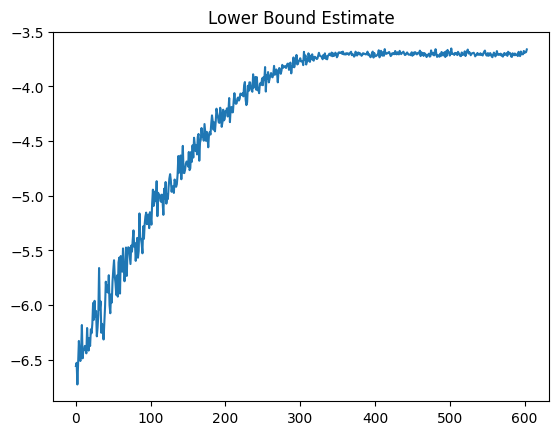

In [ ]:
import pandas as pd
lb_df = pd.DataFrame(np.array(LB_estimate))
plt.figure()
lb_df.plot(title = 'Lower Bound Estimate', legend = False)

<Axes: title={'center': 'Smoothed Lower Bound Estimate'}>

<Figure size 640x480 with 0 Axes>

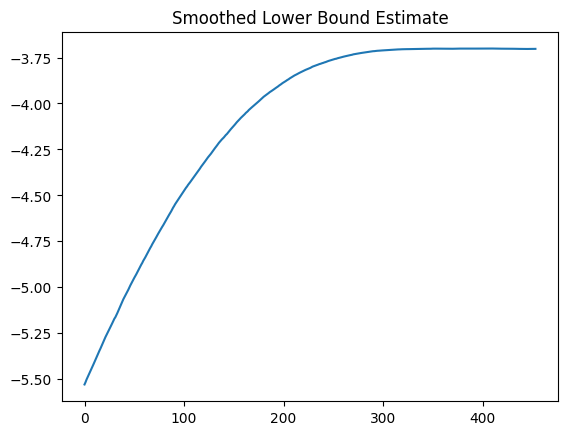

In [ ]:
lb_df = pd.DataFrame(np.array(smoothed_LB_estimate))
plt.figure()
lb_df.plot(title = 'Smoothed Lower Bound Estimate', legend = False)

In [ ]:
print(best_lambda_mu)
print(best_lambda_l)

[-0.2895302]
[10.003352]


In [ ]:
best_mu = best_lambda_mu
best_vech_l = list(best_lambda_l)
best_l = jnp.zeros((num_coeffs, num_coeffs))
for i in range(num_coeffs):
    best_l = best_l.at[i:num_coeffs,i].set(best_vech_l[:num_coeffs - i])
    del best_vech_l[:num_coeffs-i]
best_Sigma_inv = best_l @ best_l.T
best_Sigma =  my_inv(best_Sigma_inv)

best_theta = random.multivariate_normal(key2, mean = best_mu, cov = best_Sigma, shape = (1000,))
posterior_mean_estimate = jnp.mean(best_theta)
posterior_mean_estimate

Array(-0.2901885, dtype=float32)

Text(0.5, 1.0, 'Posterior density of theta')

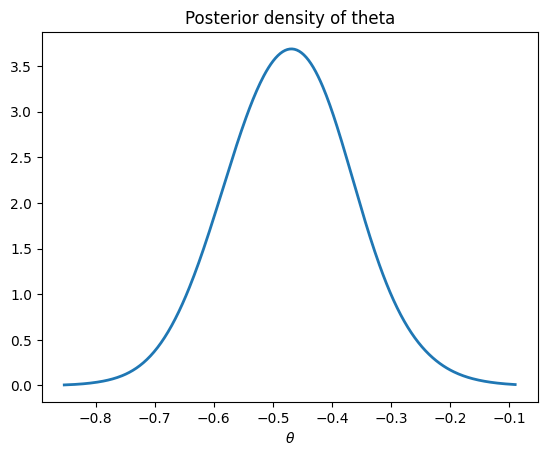

In [ ]:
plt.figure()
x_plot = jnp.arange((np.mean(best_theta)-4*np.std(best_theta)), (np.mean(best_theta)+4*np.std(best_theta)), 0.002)
kde = KernelDensity(bandwidth=0.05, kernel='gaussian')
kde.fit(best_theta.reshape(-1, 1))
y_plot = kde.score_samples(x_plot.reshape(-1, 1))
plt.plot(x_plot, np.exp(y_plot), '-', linewidth=2.0)
plt.xlabel(r'$\theta$')
plt.title('Posterior density of theta')

In [38]:
best_lambda_mu = np.array([-0.2895302])
best_lambda_l = np.array([10.003352])

best_mu = best_lambda_mu
best_vech_l = list(best_lambda_l)
best_l = jnp.zeros((num_coeffs, num_coeffs))
for i in range(num_coeffs):
    best_l = best_l.at[i:num_coeffs,i].set(best_vech_l[:num_coeffs - i])
    del best_vech_l[:num_coeffs-i]
best_Sigma_inv = best_l @ best_l.T
best_Sigma =  my_inv(best_Sigma_inv)

best_theta_rvbsl = random.multivariate_normal(key2, mean = best_mu, cov = best_Sigma, shape = (1000,))
posterior_mean_estimate = jnp.mean(best_theta_rvbsl)
posterior_mean_estimate

Array(-0.2901885, dtype=float32)

In [ ]:
best_lambda_mu = np.array([-0.032287])
best_lambda_l = np.array([9.979428])

best_mu = best_lambda_mu
best_vech_l = list(best_lambda_l)
best_l = jnp.zeros((num_coeffs, num_coeffs))
for i in range(num_coeffs):
    best_l = best_l.at[i:num_coeffs,i].set(best_vech_l[:num_coeffs - i])
    del best_vech_l[:num_coeffs-i]
best_Sigma_inv = best_l @ best_l.T
best_Sigma =  my_inv(best_Sigma_inv)

best_theta_vbsl_wg = random.multivariate_normal(key2, mean = best_mu, cov = best_Sigma, shape = (1000,))
posterior_mean_estimate = jnp.mean(best_theta_vbsl_wg)
posterior_mean_estimate

Array(-0.03294687, dtype=float32)

In [ ]:
best_lambda_mu = np.array([0.24426517])
best_lambda_l = np.array([10.059458])

best_mu = best_lambda_mu
best_vech_l = list(best_lambda_l)
best_l = jnp.zeros((num_coeffs, num_coeffs))
for i in range(num_coeffs):
    best_l = best_l.at[i:num_coeffs,i].set(best_vech_l[:num_coeffs - i])
    del best_vech_l[:num_coeffs-i]
best_Sigma_inv = best_l @ best_l.T
best_Sigma =  my_inv(best_Sigma_inv)

best_theta_rvbsl_wg = random.multivariate_normal(key2, mean = best_mu, cov = best_Sigma, shape = (1000,))
posterior_mean_estimate = jnp.mean(best_theta_rvbsl_wg)
posterior_mean_estimate

Array(0.24361056, dtype=float32)

In [ ]:
theta_set = [best_theta, best_theta_rvbsl, best_theta_vbsl_wg, best_theta_rvbsl_wg]

Text(0.5, 1.0, 'Posterior density of theta')

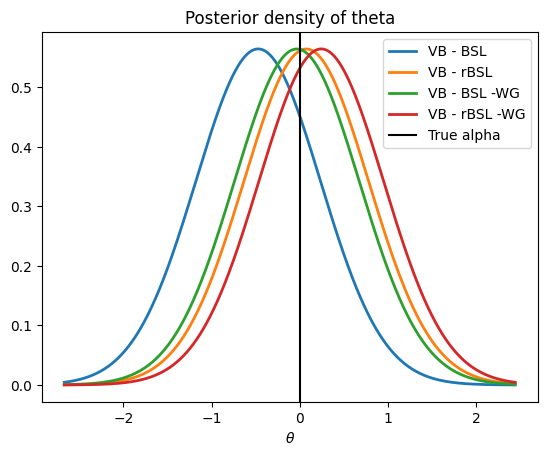

In [ ]:
plt.figure()
x_plot = np.arange(min(np.mean(theta_set[0])-23*np.std(theta_set[0]),np.mean(theta_set[3])-23*np.std(theta_set[3])), max(np.mean(theta_set[0])+23*np.std(theta_set[0]), np.mean(theta_set[3])+23*np.std(theta_set[3])), 0.002)

kde_vbsl = KernelDensity(bandwidth=0.7, kernel='gaussian')
kde_vbsl.fit(theta_set[0].reshape(-1, 1))
y_plot_vbsl = kde_vbsl.score_samples(x_plot.reshape(-1, 1))

kde_rvbsl = KernelDensity(bandwidth=0.7, kernel='gaussian')
kde_rvbsl.fit(theta_set[1].reshape(-1, 1))
y_plot_rvbsl = kde_rvbsl.score_samples(x_plot.reshape(-1, 1))

kde_vbsl_wg = KernelDensity(bandwidth=0.7, kernel='gaussian')
kde_vbsl_wg.fit(theta_set[2].reshape(-1, 1))
y_plot_vbsl_wg = kde_vbsl_wg.score_samples(x_plot.reshape(-1, 1))

kde_rvbsl_wg = KernelDensity(bandwidth=0.7, kernel='gaussian')
kde_rvbsl_wg.fit(theta_set[3].reshape(-1, 1))
y_plot_rvbsl_wg = kde_rvbsl_wg.score_samples(x_plot.reshape(-1, 1))

plt.plot(x_plot, np.exp(y_plot_vbsl), '-', linewidth=2.0, label = 'VB - BSL')
plt.plot(x_plot, np.exp(y_plot_rvbsl), '-', linewidth=2.0, label = 'VB - rBSL')
plt.plot(x_plot, np.exp(y_plot_vbsl_wg), '-', linewidth=2.0, label = 'VB - BSL -WG')
plt.plot(x_plot, np.exp(y_plot_rvbsl_wg), '-', linewidth=2.0, label = 'VB - rBSL -WG')
# only one line may be specified; full height
plt.axvline(x = 0, ymin = 0, color = 'black', label = 'True alpha')

plt.legend()
plt.xlabel(r'$\theta$')
plt.title('Posterior density of theta')

## Run MCMC

In [19]:
num_samples = 20000
num_burnin = 0.2 * num_samples

In [20]:
def sampler(samples):

    # ------------------- initialize MCMC
    theta_size = num_coeffs  # num of weights and bias

    pos_theta = jnp.ones((samples, theta_size))  # posterior of all weights and bias over all samples
    theta = jnp.array([0] * num_coeffs)

    ss = summary_statistics(theta, n_samples, num_datasets)
    sample_mean = ss[0]
    sample_variance = ss[1]
    # Nuissance mean and variance
    mean_nuissance_p1_non_inv = jnp.identity(num_latent) / sigma_latent + jnp.diag(jnp.sqrt(sample_variance)).T @ jnp.linalg.solve(sample_variance, jnp.diag(jnp.sqrt(sample_variance)))
    # mean_nuissance_p1_non_inv_unreg = mean_nuissance_p1_non_inv + (jnp.eye(mean_nuissance_p1_non_inv.shape[0]) * 5 * 1e-7)
    mean_nuissance_p1 = jnp.linalg.solve(mean_nuissance_p1_non_inv, jnp.eye(mean_nuissance_p1_non_inv.shape[0]))
    # mean_nuissance_p1 = jnp.linalg.solve(mean_nuissance_p1_non_inv, jnp.eye(mean_nuissance_p1_non_inv.shape[0]))

    diag_var = jnp.zeros((num_latent, num_latent)).at[jnp.diag_indices_from(sample_variance)].set(jnp.diag(jnp.sqrt(sample_variance)))
    diff_mean = actual_summary_statistics - sample_mean
    mean_nuissance_p2 = diag_var @ jnp.linalg.solve(sample_variance, diff_mean)
    mean_nuissance = mean_nuissance_p1 @ mean_nuissance_p2
    variance_nuissance = mean_nuissance_p1
    # Generate Gamma

    Gamma = random.multivariate_normal(key2, mean = mean_nuissance, cov = variance_nuissance)
    adjusted_theta = jnp.concatenate((theta, Gamma))

    # Find gradient of LB
    llh = mean_adjustment_unbiased_log_likelihood(adjusted_theta, n_samples, num_datasets)
    llh_gamma = nuissance_mean_adjustment_unbiased_log_likelihood(Gamma, mean_nuissance, variance_nuissance)

    prior_current = prior(theta, sigma_theta, num_coeffs)

    # ---------------------

    likelihood_current = llh

    naccept = 0

    for i in tqdm(range(samples - 1)):
        if i < 2000:
            theta_proposal = random.multivariate_normal(subkeys[i], mean = theta, cov = ((0.1**2/theta_size) * jnp.identity(theta_size)))
        else:
            if i % 500 == 0:
                Sign = jnp.cov(pos_theta[0:i, :].T)
                Sign = jnp.reshape(Sign, jnp.shape(jnp.identity(theta_size)))
            u_proposal = np.random.uniform(0, 1)
            if u_proposal < 0.05:
                theta_proposal = random.multivariate_normal(subkeys[i], mean = theta, cov = ((0.1**2/theta_size) * jnp.identity(theta_size)))
            else:
                theta_proposal = random.multivariate_normal(subkeys[i], mean = theta, cov = (2.38**2/theta_size) * Sign)

        ss = summary_statistics(theta_proposal, n_samples, num_datasets)
        sample_mean = ss[0]
        sample_variance = ss[1]
        # Nuissance mean and variance
        mean_nuissance_p1_non_inv = jnp.identity(num_latent) / sigma_latent + jnp.diag(jnp.sqrt(sample_variance)).T @ jnp.linalg.solve(sample_variance, jnp.diag(jnp.sqrt(sample_variance)))
        mean_nuissance_p1_non_inv_unreg = mean_nuissance_p1_non_inv + (jnp.eye(mean_nuissance_p1_non_inv.shape[0]) * 5 * 1e-7)
        mean_nuissance_p1 = jnp.linalg.solve(mean_nuissance_p1_non_inv_unreg, jnp.eye(mean_nuissance_p1_non_inv_unreg.shape[0]))
        # mean_nuissance_p1 = jnp.linalg.solve(mean_nuissance_p1_non_inv, jnp.eye(mean_nuissance_p1_non_inv.shape[0]))

        diag_var = jnp.zeros((num_latent, num_latent)).at[jnp.diag_indices_from(sample_variance)].set(jnp.diag(jnp.sqrt(sample_variance)))
        diff_mean = actual_summary_statistics - sample_mean
        mean_nuissance_p2 = diag_var @ jnp.linalg.solve(sample_variance, diff_mean)
        mean_nuissance = mean_nuissance_p1 @ mean_nuissance_p2
        # print(mean_nuissance_q)

        variance_nuissance = mean_nuissance_p1 + (jnp.eye(mean_nuissance_p1.shape[0]) * 5 * 1e-7)
        # print(variance_nuissance_q)

        # Generate Gamma

        Gamma = random.multivariate_normal(key2, mean = mean_nuissance, cov = variance_nuissance)
        adjusted_theta_proposal = jnp.concatenate((theta_proposal, Gamma))

        # Find gradient of LB
        llh = mean_adjustment_unbiased_log_likelihood(adjusted_theta_proposal, n_samples, num_datasets)
        llh_gamma = nuissance_mean_adjustment_unbiased_log_likelihood(Gamma, mean_nuissance, variance_nuissance)
        # ---------------------

        prior_proposal = prior(theta_proposal, sigma_theta, num_coeffs)  # takes care of the gradients
        likelihood_proposal = llh

        diff_prior = prior_proposal - prior_current

        diff_likelihood = likelihood_proposal - likelihood_current

        try:
            mh_prob = min(1, math.exp(diff_likelihood+diff_prior))

        except OverflowError as e:
            mh_prob = 1


        u = np.random.uniform(0, 1)

        if u < mh_prob:
            # Update position
            naccept += 1
            likelihood_current = likelihood_proposal
            prior_current = prior_proposal
            theta = theta_proposal
            pos_theta = pos_theta.at[i + 1,].set(theta_proposal)
            print(i, pos_theta[i + 1,])

        else:
            pos_theta = pos_theta.at[i + 1,].set(pos_theta[i,])

    print(naccept, ' num accepted')
    print(naccept / (samples * 1.0) * 100, '% was accepted')
    accept_ratio = naccept / (samples * 1.0) * 100

    return (pos_theta, accept_ratio)

In [21]:
pos_w, accept_ratio = sampler(num_samples)

  0%|          | 1/19999 [00:01<10:49:11,  1.95s/it]

0 [-0.06461435]


  0%|          | 2/19999 [00:02<7:35:54,  1.37s/it] 

1 [-0.21229327]


  0%|          | 3/19999 [00:03<6:43:16,  1.21s/it]

2 [-0.33817032]


  0%|          | 8/19999 [00:08<5:38:41,  1.02s/it]

7 [-0.23807293]


  0%|          | 9/19999 [00:09<5:34:38,  1.00s/it]

8 [-0.2715059]


  0%|          | 11/19999 [00:11<5:29:52,  1.01it/s]

10 [-0.23330899]


  0%|          | 12/19999 [00:12<5:28:42,  1.01it/s]

11 [-0.24119689]


  0%|          | 13/19999 [00:13<5:27:07,  1.02it/s]

12 [-0.19010839]


  0%|          | 14/19999 [00:14<5:33:11,  1.00s/it]

13 [-0.16279703]


  0%|          | 15/19999 [00:15<5:23:16,  1.03it/s]

14 [-0.16007304]


  0%|          | 18/19999 [00:18<5:30:57,  1.01it/s]

17 [-0.5030124]


  0%|          | 19/19999 [00:19<5:34:23,  1.00s/it]

18 [-0.44900307]


  0%|          | 20/19999 [00:20<5:36:37,  1.01s/it]

19 [-0.4379174]


  0%|          | 21/19999 [00:21<5:29:07,  1.01it/s]

20 [-0.40393946]


  0%|          | 22/19999 [00:22<5:23:23,  1.03it/s]

21 [-0.3527007]


  0%|          | 24/19999 [00:24<5:12:18,  1.07it/s]

23 [-0.14607552]


  0%|          | 25/19999 [00:25<5:19:06,  1.04it/s]

24 [-0.1779491]


  0%|          | 27/19999 [00:27<5:08:41,  1.08it/s]

26 [-0.24234936]


  0%|          | 28/19999 [00:28<5:18:42,  1.04it/s]

27 [-0.33489728]


  0%|          | 29/19999 [00:29<5:17:55,  1.05it/s]

28 [-0.2694191]


  0%|          | 30/19999 [00:30<5:11:33,  1.07it/s]

29 [-0.33554327]


  0%|          | 31/19999 [00:31<5:07:33,  1.08it/s]

30 [-0.4512238]


  0%|          | 32/19999 [00:31<5:04:32,  1.09it/s]

31 [-0.43129414]


  0%|          | 33/19999 [00:32<5:02:17,  1.10it/s]

32 [-0.45114523]


  0%|          | 35/19999 [00:34<5:01:43,  1.10it/s]

34 [-0.43377826]


  0%|          | 36/19999 [00:35<5:06:36,  1.09it/s]

35 [-0.19013146]


  0%|          | 38/19999 [00:37<5:00:44,  1.11it/s]

37 [-0.25283074]


  0%|          | 39/19999 [00:38<5:03:19,  1.10it/s]

38 [-0.34696648]


  0%|          | 40/19999 [00:39<5:13:46,  1.06it/s]

39 [-0.4229634]


  0%|          | 43/19999 [00:42<5:20:41,  1.04it/s]

42 [-0.32663518]


  0%|          | 44/19999 [00:43<5:17:22,  1.05it/s]

43 [-0.34623632]


  0%|          | 45/19999 [00:44<5:12:12,  1.07it/s]

44 [-0.37474823]


  0%|          | 46/19999 [00:45<5:08:51,  1.08it/s]

45 [-0.22881302]


  0%|          | 47/19999 [00:45<5:05:55,  1.09it/s]

46 [-0.27307415]


  0%|          | 48/19999 [00:46<5:06:45,  1.08it/s]

47 [-0.13950098]


  0%|          | 49/19999 [00:47<5:16:40,  1.05it/s]

48 [-0.09609286]


  0%|          | 51/19999 [00:49<5:20:31,  1.04it/s]

50 [-0.13529536]


  0%|          | 55/19999 [00:53<5:33:23,  1.00s/it]

54 [-0.10808241]


  0%|          | 56/19999 [00:54<5:25:32,  1.02it/s]

55 [-0.27081951]


  0%|          | 58/19999 [00:56<5:12:11,  1.06it/s]

57 [-0.28340888]


  0%|          | 59/19999 [00:57<5:09:42,  1.07it/s]

58 [-0.27296183]


  0%|          | 60/19999 [00:58<5:07:11,  1.08it/s]

59 [-0.3392979]


  0%|          | 61/19999 [00:59<5:12:38,  1.06it/s]

60 [-0.29513687]


  0%|          | 64/19999 [01:02<5:20:03,  1.04it/s]

63 [-0.23608342]


  0%|          | 66/19999 [01:04<5:18:27,  1.04it/s]

65 [-0.43167004]


  0%|          | 67/19999 [01:05<5:14:06,  1.06it/s]

66 [-0.3988477]


  0%|          | 68/19999 [01:06<5:18:50,  1.04it/s]

67 [-0.29186577]


  0%|          | 69/19999 [01:07<5:23:43,  1.03it/s]

68 [-0.39063913]


  0%|          | 70/19999 [01:08<5:29:06,  1.01it/s]

69 [-0.27296364]


  0%|          | 73/19999 [01:11<5:20:55,  1.03it/s]

72 [-0.16936529]


  0%|          | 74/19999 [01:12<5:14:45,  1.06it/s]

73 [-0.24666867]


  0%|          | 75/19999 [01:13<5:19:17,  1.04it/s]

74 [-0.26965454]


  0%|          | 76/19999 [01:14<5:24:26,  1.02it/s]

75 [-0.35924816]


  0%|          | 77/19999 [01:15<5:29:58,  1.01it/s]

76 [-0.31214023]


  0%|          | 78/19999 [01:16<5:22:47,  1.03it/s]

77 [-0.18340403]


  0%|          | 79/19999 [01:16<5:18:21,  1.04it/s]

78 [-0.16780618]


  0%|          | 80/19999 [01:17<5:13:48,  1.06it/s]

79 [-0.12458307]


  0%|          | 81/19999 [01:18<5:11:17,  1.07it/s]

80 [-0.12947519]


  0%|          | 83/19999 [01:20<5:12:46,  1.06it/s]

82 [-0.21154976]


  0%|          | 84/19999 [01:21<5:10:02,  1.07it/s]

83 [-0.17353931]


  0%|          | 85/19999 [01:22<5:09:04,  1.07it/s]

84 [-0.19536902]


  0%|          | 87/19999 [01:24<5:11:06,  1.07it/s]

86 [-0.18960509]


  0%|          | 89/19999 [01:26<5:12:28,  1.06it/s]

88 [-0.21077907]


  0%|          | 91/19999 [01:28<5:09:11,  1.07it/s]

90 [-0.29704973]


  0%|          | 92/19999 [01:29<5:06:09,  1.08it/s]

91 [-0.30594796]


  0%|          | 93/19999 [01:29<5:09:52,  1.07it/s]

92 [-0.21538639]


  0%|          | 95/19999 [01:31<5:08:18,  1.08it/s]

94 [-0.34811115]


  0%|          | 96/19999 [01:32<5:07:05,  1.08it/s]

95 [-0.21524355]


  0%|          | 97/19999 [01:33<5:21:16,  1.03it/s]

96 [-0.2944615]


  0%|          | 98/19999 [01:34<5:30:38,  1.00it/s]

97 [-0.28554565]


  0%|          | 99/19999 [01:35<5:22:25,  1.03it/s]

98 [-0.5189402]


  1%|          | 100/19999 [01:36<5:27:35,  1.01it/s]

99 [-0.48888692]


  1%|          | 101/19999 [01:37<5:42:57,  1.03s/it]

100 [-0.26619118]


  1%|          | 104/19999 [01:40<5:30:52,  1.00it/s]

103 [-0.25517836]


  1%|          | 105/19999 [01:41<5:22:17,  1.03it/s]

104 [-0.44229358]


  1%|          | 106/19999 [01:42<5:15:43,  1.05it/s]

105 [-0.3996826]


  1%|          | 107/19999 [01:43<5:09:14,  1.07it/s]

106 [-0.3560742]


  1%|          | 108/19999 [01:44<5:07:42,  1.08it/s]

107 [-0.33941728]


  1%|          | 109/19999 [01:45<5:10:23,  1.07it/s]

108 [-0.3052114]


  1%|          | 110/19999 [01:46<5:12:40,  1.06it/s]

109 [-0.3651154]


  1%|          | 111/19999 [01:47<5:11:25,  1.06it/s]

110 [-0.36138403]


  1%|          | 114/19999 [01:50<5:19:08,  1.04it/s]

113 [-0.18620598]


  1%|          | 115/19999 [01:51<5:19:01,  1.04it/s]

114 [-0.43911076]


  1%|          | 116/19999 [01:52<5:18:45,  1.04it/s]

115 [-0.4321647]


  1%|          | 117/19999 [01:53<5:17:13,  1.04it/s]

116 [-0.3973477]


  1%|          | 119/19999 [01:55<5:23:15,  1.02it/s]

118 [-0.38065904]


  1%|          | 120/19999 [01:56<5:15:08,  1.05it/s]

119 [-0.35756677]


  1%|          | 121/19999 [01:56<5:09:36,  1.07it/s]

120 [-0.3004333]


  1%|          | 125/19999 [02:00<5:14:50,  1.05it/s]

124 [-0.26644522]


  1%|          | 126/19999 [02:01<5:09:24,  1.07it/s]

125 [-0.20166087]


  1%|          | 127/19999 [02:02<5:10:56,  1.07it/s]

126 [-0.15417957]


  1%|          | 128/19999 [02:03<5:14:36,  1.05it/s]

127 [-0.19580464]


  1%|          | 129/19999 [02:04<5:08:50,  1.07it/s]

128 [-0.38356692]


  1%|          | 130/19999 [02:05<5:10:51,  1.07it/s]

129 [-0.36217496]


  1%|          | 131/19999 [02:06<5:08:37,  1.07it/s]

130 [-0.37090018]


  1%|          | 132/19999 [02:07<5:10:49,  1.07it/s]

131 [-0.3592546]


  1%|          | 133/19999 [02:08<5:14:11,  1.05it/s]

132 [-0.30941463]


  1%|          | 136/19999 [02:11<5:24:14,  1.02it/s]

135 [-0.26123047]


  1%|          | 137/19999 [02:12<5:23:14,  1.02it/s]

136 [-0.2486101]


  1%|          | 138/19999 [02:13<5:20:34,  1.03it/s]

137 [-0.25622565]


  1%|          | 140/19999 [02:15<5:20:35,  1.03it/s]

139 [-0.3063361]


  1%|          | 142/19999 [02:17<5:20:15,  1.03it/s]

141 [-0.28619704]


  1%|          | 143/19999 [02:18<5:19:42,  1.04it/s]

142 [-0.22466424]


  1%|          | 145/19999 [02:19<5:19:11,  1.04it/s]

144 [-0.17571244]


  1%|          | 147/19999 [02:21<5:17:01,  1.04it/s]

146 [-0.24144566]


  1%|          | 148/19999 [02:22<5:21:04,  1.03it/s]

147 [-0.37359038]


  1%|          | 149/19999 [02:23<5:18:01,  1.04it/s]

148 [-0.3565106]


  1%|          | 150/19999 [02:24<5:20:11,  1.03it/s]

149 [-0.34560475]


  1%|          | 151/19999 [02:25<5:18:02,  1.04it/s]

150 [-0.2052821]


  1%|          | 152/19999 [02:26<5:16:26,  1.05it/s]

151 [-0.2976676]


  1%|          | 153/19999 [02:27<5:21:06,  1.03it/s]

152 [-0.35284886]


  1%|          | 154/19999 [02:28<5:19:29,  1.04it/s]

153 [-0.39250594]


  1%|          | 155/19999 [02:29<5:21:32,  1.03it/s]

154 [-0.41328093]


  1%|          | 156/19999 [02:30<5:24:38,  1.02it/s]

155 [-0.29531398]


  1%|          | 159/19999 [02:33<5:18:51,  1.04it/s]

158 [-0.29860872]


  1%|          | 162/19999 [02:36<5:24:25,  1.02it/s]

161 [-0.14562947]


  1%|          | 163/19999 [02:37<5:22:01,  1.03it/s]

162 [-0.1231731]


  1%|          | 164/19999 [02:38<5:20:27,  1.03it/s]

163 [-0.10171825]


  1%|          | 166/19999 [02:40<5:20:24,  1.03it/s]

165 [-0.2725861]


  1%|          | 167/19999 [02:41<5:19:10,  1.04it/s]

166 [-0.2215451]


  1%|          | 168/19999 [02:42<5:19:11,  1.04it/s]

167 [-0.28308734]


  1%|          | 169/19999 [02:43<5:19:14,  1.04it/s]

168 [-0.39063427]


  1%|          | 171/19999 [02:45<5:19:06,  1.04it/s]

170 [-0.3217714]


  1%|          | 172/19999 [02:46<5:18:31,  1.04it/s]

171 [-0.3024757]


  1%|          | 173/19999 [02:47<5:18:29,  1.04it/s]

172 [-0.20894158]


  1%|          | 174/19999 [02:48<5:15:36,  1.05it/s]

173 [-0.14216833]


  1%|          | 175/19999 [02:49<5:16:40,  1.04it/s]

174 [-0.1386433]


  1%|          | 179/19999 [02:52<5:12:00,  1.06it/s]

178 [-0.06858104]


  1%|          | 180/19999 [02:53<5:12:40,  1.06it/s]

179 [-0.05910608]


  1%|          | 181/19999 [02:54<5:15:19,  1.05it/s]

180 [-0.06251434]


  1%|          | 182/19999 [02:55<5:12:36,  1.06it/s]

181 [-0.20765486]


  1%|          | 183/19999 [02:56<5:11:45,  1.06it/s]

182 [-0.26546532]


  1%|          | 185/19999 [02:58<5:31:59,  1.01s/it]

184 [-0.25533536]


  1%|          | 186/19999 [02:59<5:25:49,  1.01it/s]

185 [-0.30611858]


  1%|          | 189/19999 [03:02<5:09:19,  1.07it/s]

188 [-0.27991712]


  1%|          | 190/19999 [03:03<5:16:30,  1.04it/s]

189 [-0.24813594]


  1%|          | 191/19999 [03:04<5:10:15,  1.06it/s]

190 [-0.19051436]


  1%|          | 192/19999 [03:05<5:07:07,  1.07it/s]

191 [-0.1861572]


  1%|          | 193/19999 [03:06<5:13:36,  1.05it/s]

192 [-0.05765574]


  1%|          | 194/19999 [03:07<5:17:06,  1.04it/s]

193 [-0.06145525]


  1%|          | 195/19999 [03:08<5:17:44,  1.04it/s]

194 [-0.11892255]


  1%|          | 196/19999 [03:09<5:18:59,  1.03it/s]

195 [0.00410893]


  1%|          | 198/19999 [03:11<5:21:45,  1.03it/s]

197 [-0.04267856]


  1%|          | 199/19999 [03:12<5:16:16,  1.04it/s]

198 [-0.05070409]


  1%|          | 200/19999 [03:13<5:17:45,  1.04it/s]

199 [-0.05988278]


  1%|          | 204/19999 [03:16<5:16:52,  1.04it/s]

203 [-0.18123236]


  1%|          | 205/19999 [03:17<5:13:17,  1.05it/s]

204 [-0.02112868]


  1%|          | 206/19999 [03:18<5:15:28,  1.05it/s]

205 [-0.05011356]


  1%|          | 210/19999 [03:22<5:18:29,  1.04it/s]

209 [-0.1669001]


  1%|          | 211/19999 [03:23<5:14:46,  1.05it/s]

210 [-0.18599711]


  1%|          | 213/19999 [03:25<5:16:35,  1.04it/s]

212 [-0.17570549]


  1%|          | 214/19999 [03:26<5:11:07,  1.06it/s]

213 [-0.28653806]


  1%|          | 215/19999 [03:27<5:10:00,  1.06it/s]

214 [-0.38624352]


  1%|          | 216/19999 [03:28<5:15:40,  1.04it/s]

215 [-0.28244317]


  1%|          | 218/19999 [03:30<5:17:10,  1.04it/s]

217 [-0.38752502]


  1%|          | 219/19999 [03:31<5:13:04,  1.05it/s]

218 [-0.27458832]


  1%|          | 220/19999 [03:32<5:23:27,  1.02it/s]

219 [-0.24017186]


  1%|          | 221/19999 [03:33<5:21:00,  1.03it/s]

220 [-0.30920768]


  1%|          | 223/19999 [03:35<5:20:14,  1.03it/s]

222 [-0.3797213]


  1%|          | 225/19999 [03:37<5:22:25,  1.02it/s]

224 [-0.2913779]


  1%|          | 226/19999 [03:38<5:23:11,  1.02it/s]

225 [-0.2954061]


  1%|          | 228/19999 [03:40<5:23:02,  1.02it/s]

227 [-0.1905911]


  1%|          | 229/19999 [03:41<5:21:24,  1.03it/s]

228 [-0.23681721]


  1%|          | 231/19999 [03:42<5:19:52,  1.03it/s]

230 [-0.23977113]


  1%|          | 232/19999 [03:44<5:25:26,  1.01it/s]

231 [-0.35417756]


  1%|          | 233/19999 [03:44<5:20:37,  1.03it/s]

232 [-0.32175758]


  1%|          | 234/19999 [03:45<5:13:58,  1.05it/s]

233 [-0.31523827]


  1%|          | 235/19999 [03:46<5:12:42,  1.05it/s]

234 [-0.37652755]


  1%|          | 236/19999 [03:47<5:08:52,  1.07it/s]

235 [-0.44462883]


  1%|          | 237/19999 [03:48<5:04:15,  1.08it/s]

236 [-0.4023318]


  1%|          | 238/19999 [03:49<5:03:24,  1.09it/s]

237 [-0.28448457]


  1%|          | 239/19999 [03:50<5:03:14,  1.09it/s]

238 [-0.3120901]


  1%|          | 241/19999 [03:52<5:00:38,  1.10it/s]

240 [-0.37054068]


  1%|          | 243/19999 [03:54<5:06:21,  1.07it/s]

242 [-0.42685515]


  1%|          | 244/19999 [03:55<5:05:55,  1.08it/s]

243 [-0.37664518]


  1%|          | 245/19999 [03:56<5:10:36,  1.06it/s]

244 [-0.31606972]


  1%|          | 246/19999 [03:57<5:13:18,  1.05it/s]

245 [-0.34144726]


  1%|          | 247/19999 [03:58<5:26:26,  1.01it/s]

246 [-0.2828219]


  1%|          | 249/19999 [04:00<5:23:33,  1.02it/s]

248 [-0.3070954]


  1%|▏         | 251/19999 [04:01<5:12:35,  1.05it/s]

250 [-0.34431338]


  1%|▏         | 252/19999 [04:02<5:11:10,  1.06it/s]

251 [-0.16021356]


  1%|▏         | 254/19999 [04:04<5:07:24,  1.07it/s]

253 [-0.37161615]


  1%|▏         | 255/19999 [04:05<5:06:57,  1.07it/s]

254 [-0.3550043]


  1%|▏         | 256/19999 [04:06<5:24:59,  1.01it/s]

255 [-0.3967026]


  1%|▏         | 257/19999 [04:07<5:25:11,  1.01it/s]

256 [-0.37122673]


  1%|▏         | 258/19999 [04:08<5:17:44,  1.04it/s]

257 [-0.23999329]


  1%|▏         | 259/19999 [04:09<5:12:05,  1.05it/s]

258 [-0.3320526]


  1%|▏         | 262/19999 [04:12<5:13:45,  1.05it/s]

261 [-0.36107484]


  1%|▏         | 263/19999 [04:13<5:12:44,  1.05it/s]

262 [-0.27015668]


  1%|▏         | 264/19999 [04:14<5:09:50,  1.06it/s]

263 [-0.3077861]


  1%|▏         | 265/19999 [04:15<5:09:55,  1.06it/s]

264 [-0.2763131]


  1%|▏         | 266/19999 [04:16<5:08:33,  1.07it/s]

265 [-0.2695256]


  1%|▏         | 267/19999 [04:17<5:13:50,  1.05it/s]

266 [-0.35512677]


  1%|▏         | 268/19999 [04:18<5:18:04,  1.03it/s]

267 [-0.40224415]


  1%|▏         | 269/19999 [04:19<5:16:17,  1.04it/s]

268 [-0.19850032]


  1%|▏         | 270/19999 [04:20<5:12:29,  1.05it/s]

269 [-0.36494118]


  1%|▏         | 272/19999 [04:22<5:24:54,  1.01it/s]

271 [-0.35330832]


  1%|▏         | 273/19999 [04:23<5:21:45,  1.02it/s]

272 [-0.27537915]


  1%|▏         | 274/19999 [04:23<5:14:43,  1.04it/s]

273 [-0.3187152]


  1%|▏         | 275/19999 [04:24<5:16:34,  1.04it/s]

274 [-0.41751397]


  1%|▏         | 276/19999 [04:25<5:23:29,  1.02it/s]

275 [-0.4457636]


  1%|▏         | 277/19999 [04:26<5:25:09,  1.01it/s]

276 [-0.5429854]


  1%|▏         | 278/19999 [04:27<5:21:42,  1.02it/s]

277 [-0.5688991]


  1%|▏         | 279/19999 [04:28<5:21:57,  1.02it/s]

278 [-0.5143193]


  1%|▏         | 281/19999 [04:30<5:16:05,  1.04it/s]

280 [-0.5280331]


  1%|▏         | 282/19999 [04:31<5:14:58,  1.04it/s]

281 [-0.45430788]


  1%|▏         | 283/19999 [04:32<5:14:21,  1.05it/s]

282 [-0.36853242]


  1%|▏         | 285/19999 [04:34<5:17:12,  1.04it/s]

284 [-0.3393615]


  1%|▏         | 286/19999 [04:35<5:21:13,  1.02it/s]

285 [-0.3701176]


  1%|▏         | 287/19999 [04:36<5:15:18,  1.04it/s]

286 [-0.38135844]


  1%|▏         | 289/19999 [04:38<5:12:14,  1.05it/s]

288 [-0.28157377]


  1%|▏         | 290/19999 [04:39<5:11:39,  1.05it/s]

289 [-0.25009152]


  1%|▏         | 291/19999 [04:40<5:23:45,  1.01it/s]

290 [-0.2623775]


  1%|▏         | 292/19999 [04:41<5:20:48,  1.02it/s]

291 [-0.29146072]


  1%|▏         | 293/19999 [04:42<5:15:53,  1.04it/s]

292 [-0.33884546]


  1%|▏         | 294/19999 [04:43<5:13:15,  1.05it/s]

293 [-0.27323127]


  1%|▏         | 295/19999 [04:44<5:11:47,  1.05it/s]

294 [-0.29329988]


  1%|▏         | 297/19999 [04:46<5:20:03,  1.03it/s]

296 [-0.26274905]


  1%|▏         | 298/19999 [04:47<5:20:04,  1.03it/s]

297 [-0.25160745]


  2%|▏         | 301/19999 [04:49<5:14:27,  1.04it/s]

300 [-0.33750257]


  2%|▏         | 302/19999 [04:50<5:09:56,  1.06it/s]

301 [-0.28595695]


  2%|▏         | 304/19999 [04:52<5:22:20,  1.02it/s]

303 [-0.229097]


  2%|▏         | 305/19999 [04:53<5:28:40,  1.00s/it]

304 [-0.28222242]


  2%|▏         | 306/19999 [04:54<5:19:33,  1.03it/s]

305 [-0.27527905]


  2%|▏         | 307/19999 [04:55<5:26:55,  1.00it/s]

306 [-0.1438135]


  2%|▏         | 308/19999 [04:56<5:19:10,  1.03it/s]

307 [-0.1611769]


  2%|▏         | 309/19999 [04:57<5:11:12,  1.05it/s]

308 [-0.18745765]


  2%|▏         | 310/19999 [04:58<5:13:44,  1.05it/s]

309 [-0.18436037]


  2%|▏         | 311/19999 [04:59<5:10:41,  1.06it/s]

310 [-0.2533593]


  2%|▏         | 312/19999 [05:00<5:07:08,  1.07it/s]

311 [-0.2725605]


  2%|▏         | 314/19999 [05:02<5:03:19,  1.08it/s]

313 [-0.29655784]


  2%|▏         | 315/19999 [05:03<5:11:19,  1.05it/s]

314 [-0.26392296]


  2%|▏         | 316/19999 [05:04<5:15:08,  1.04it/s]

315 [-0.22958358]


  2%|▏         | 317/19999 [05:05<5:13:03,  1.05it/s]

316 [-0.17480817]


  2%|▏         | 318/19999 [05:06<5:14:26,  1.04it/s]

317 [-0.23770174]


  2%|▏         | 319/19999 [05:07<5:11:30,  1.05it/s]

318 [-0.28600645]


  2%|▏         | 321/19999 [05:09<5:08:26,  1.06it/s]

320 [-0.27608663]


  2%|▏         | 322/19999 [05:10<5:09:46,  1.06it/s]

321 [-0.29082477]


  2%|▏         | 324/19999 [05:11<5:05:53,  1.07it/s]

323 [-0.20420924]


  2%|▏         | 325/19999 [05:12<5:04:25,  1.08it/s]

324 [-0.35067362]


  2%|▏         | 327/19999 [05:14<5:11:22,  1.05it/s]

326 [-0.28192198]


  2%|▏         | 328/19999 [05:15<5:18:00,  1.03it/s]

327 [-0.3761795]


  2%|▏         | 330/19999 [05:17<5:20:20,  1.02it/s]

329 [-0.4200155]


  2%|▏         | 331/19999 [05:18<5:13:25,  1.05it/s]

330 [-0.2708277]


  2%|▏         | 332/19999 [05:19<5:08:23,  1.06it/s]

331 [-0.32524782]


  2%|▏         | 333/19999 [05:20<5:05:07,  1.07it/s]

332 [-0.37621653]


  2%|▏         | 334/19999 [05:21<5:03:40,  1.08it/s]

333 [-0.2270933]


  2%|▏         | 338/19999 [05:25<5:01:01,  1.09it/s]

337 [-0.274984]


  2%|▏         | 339/19999 [05:26<5:08:16,  1.06it/s]

338 [-0.20701638]


  2%|▏         | 340/19999 [05:27<5:28:10,  1.00s/it]

339 [-0.21786761]


  2%|▏         | 342/19999 [05:29<5:32:29,  1.01s/it]

341 [-0.20538288]


  2%|▏         | 347/19999 [05:34<5:38:54,  1.03s/it]

346 [-0.15465617]


  2%|▏         | 349/19999 [05:36<5:38:45,  1.03s/it]

348 [-0.2527129]


  2%|▏         | 350/19999 [05:37<5:37:28,  1.03s/it]

349 [-0.2831253]


  2%|▏         | 351/19999 [05:38<5:44:22,  1.05s/it]

350 [-0.35985196]


  2%|▏         | 353/19999 [05:40<5:27:13,  1.00it/s]

352 [-0.4662248]


  2%|▏         | 354/19999 [05:41<5:16:09,  1.04it/s]

353 [-0.3904494]


  2%|▏         | 355/19999 [05:42<5:13:07,  1.05it/s]

354 [-0.36088467]


  2%|▏         | 356/19999 [05:43<5:11:18,  1.05it/s]

355 [-0.45286697]


  2%|▏         | 357/19999 [05:44<5:19:05,  1.03it/s]

356 [-0.42674652]


  2%|▏         | 361/19999 [05:48<5:30:16,  1.01s/it]

360 [-0.36222008]


  2%|▏         | 362/19999 [05:49<5:30:29,  1.01s/it]

361 [-0.38033542]


  2%|▏         | 363/19999 [05:50<5:30:18,  1.01s/it]

362 [-0.4197177]


  2%|▏         | 364/19999 [05:51<5:27:31,  1.00s/it]

363 [-0.34462515]


  2%|▏         | 365/19999 [05:52<5:21:04,  1.02it/s]

364 [-0.31467074]


  2%|▏         | 367/19999 [05:54<5:28:58,  1.01s/it]

366 [-0.21832895]


  2%|▏         | 370/19999 [05:57<5:24:23,  1.01it/s]

369 [-0.23015471]


  2%|▏         | 371/19999 [05:58<5:23:32,  1.01it/s]

370 [-0.31380445]


  2%|▏         | 372/19999 [05:59<5:32:17,  1.02s/it]

371 [-0.13496098]


  2%|▏         | 373/19999 [06:00<5:31:50,  1.01s/it]

372 [-0.11989012]


  2%|▏         | 374/19999 [06:01<5:44:16,  1.05s/it]

373 [-0.13012648]


  2%|▏         | 375/19999 [06:02<5:38:30,  1.04s/it]

374 [-0.06785715]


  2%|▏         | 378/19999 [06:05<5:15:54,  1.04it/s]

377 [-0.18935955]


  2%|▏         | 380/19999 [06:07<5:10:12,  1.05it/s]

379 [-0.18306908]


  2%|▏         | 381/19999 [06:08<5:07:27,  1.06it/s]

380 [-0.19850415]


  2%|▏         | 382/19999 [06:09<5:03:58,  1.08it/s]

381 [-0.24003878]


  2%|▏         | 383/19999 [06:09<5:01:13,  1.09it/s]

382 [-0.29992193]


  2%|▏         | 385/19999 [06:11<4:59:02,  1.09it/s]

384 [-0.27344355]


  2%|▏         | 386/19999 [06:12<5:04:47,  1.07it/s]

385 [-0.36236525]


  2%|▏         | 389/19999 [06:15<5:04:14,  1.07it/s]

388 [-0.15940756]


  2%|▏         | 390/19999 [06:16<5:01:41,  1.08it/s]

389 [-0.24205998]


  2%|▏         | 392/19999 [06:18<5:01:30,  1.08it/s]

391 [-0.24392949]


  2%|▏         | 393/19999 [06:19<5:03:55,  1.08it/s]

392 [-0.20001835]


  2%|▏         | 397/19999 [06:23<5:14:36,  1.04it/s]

396 [-0.18867342]


  2%|▏         | 398/19999 [06:24<5:17:59,  1.03it/s]

397 [-0.23288214]


  2%|▏         | 399/19999 [06:25<5:19:21,  1.02it/s]

398 [-0.37940788]


  2%|▏         | 403/19999 [06:28<5:16:31,  1.03it/s]

402 [-0.29006857]


  2%|▏         | 404/19999 [06:30<5:22:20,  1.01it/s]

403 [-0.28644747]


  2%|▏         | 405/19999 [06:31<5:25:33,  1.00it/s]

404 [-0.20299844]


  2%|▏         | 406/19999 [06:31<5:18:44,  1.02it/s]

405 [-0.19655189]


  2%|▏         | 407/19999 [06:32<5:22:54,  1.01it/s]

406 [-0.20621222]


  2%|▏         | 408/19999 [06:33<5:21:12,  1.02it/s]

407 [-0.35216314]


  2%|▏         | 409/19999 [06:34<5:18:03,  1.03it/s]

408 [-0.26478678]


  2%|▏         | 410/19999 [06:35<5:18:18,  1.03it/s]

409 [-0.32062653]


  2%|▏         | 411/19999 [06:36<5:18:23,  1.03it/s]

410 [-0.33465928]


  2%|▏         | 412/19999 [06:37<5:19:35,  1.02it/s]

411 [-0.43760732]


  2%|▏         | 413/19999 [06:38<5:20:17,  1.02it/s]

412 [-0.43516544]


  2%|▏         | 414/19999 [06:39<5:22:15,  1.01it/s]

413 [-0.32943633]


  2%|▏         | 422/19999 [06:47<5:27:31,  1.00s/it]

421 [-0.20199513]


  2%|▏         | 423/19999 [06:48<5:16:40,  1.03it/s]

422 [-0.21083939]


  2%|▏         | 425/19999 [06:50<5:10:06,  1.05it/s]

424 [-0.31094444]


  2%|▏         | 426/19999 [06:51<5:10:28,  1.05it/s]

425 [-0.3075821]


  2%|▏         | 430/19999 [06:55<5:11:21,  1.05it/s]

429 [-0.43016234]


  2%|▏         | 431/19999 [06:56<5:10:32,  1.05it/s]

430 [-0.367127]


  2%|▏         | 434/19999 [06:59<5:21:33,  1.01it/s]

433 [-0.3219942]


  2%|▏         | 435/19999 [07:00<5:19:45,  1.02it/s]

434 [-0.36012757]


  2%|▏         | 436/19999 [07:01<5:12:30,  1.04it/s]

435 [-0.16883197]


  2%|▏         | 437/19999 [07:02<5:24:35,  1.00it/s]

436 [-0.40387744]


  2%|▏         | 438/19999 [07:03<5:25:08,  1.00it/s]

437 [-0.3812623]


  2%|▏         | 439/19999 [07:04<5:19:19,  1.02it/s]

438 [-0.44087502]


  2%|▏         | 440/19999 [07:05<5:13:05,  1.04it/s]

439 [-0.44445226]


  2%|▏         | 443/19999 [07:07<5:06:37,  1.06it/s]

442 [-0.39085728]


  2%|▏         | 444/19999 [07:08<5:02:29,  1.08it/s]

443 [-0.47185647]


  2%|▏         | 447/19999 [07:11<5:06:51,  1.06it/s]

446 [-0.36513066]


  2%|▏         | 448/19999 [07:12<5:07:11,  1.06it/s]

447 [-0.272716]


  2%|▏         | 449/19999 [07:13<5:12:23,  1.04it/s]

448 [-0.30184254]


  2%|▏         | 450/19999 [07:14<5:08:11,  1.06it/s]

449 [-0.29306498]


  2%|▏         | 452/19999 [07:16<5:10:36,  1.05it/s]

451 [-0.3558753]


  2%|▏         | 453/19999 [07:17<5:07:51,  1.06it/s]

452 [-0.37973428]


  2%|▏         | 454/19999 [07:18<5:02:57,  1.08it/s]

453 [-0.26184252]


  2%|▏         | 455/19999 [07:19<5:18:46,  1.02it/s]

454 [-0.14898369]


  2%|▏         | 456/19999 [07:20<5:13:11,  1.04it/s]

455 [-0.24586783]


  2%|▏         | 458/19999 [07:22<5:26:24,  1.00s/it]

457 [-0.2488459]


  2%|▏         | 460/19999 [07:24<5:30:12,  1.01s/it]

459 [-0.38514578]


  2%|▏         | 463/19999 [07:27<5:09:28,  1.05it/s]

462 [-0.3125421]


  2%|▏         | 465/19999 [07:28<5:04:13,  1.07it/s]

464 [-0.35362223]


  2%|▏         | 468/19999 [07:31<5:14:18,  1.04it/s]

467 [-0.36524838]


  2%|▏         | 470/19999 [07:33<5:26:26,  1.00s/it]

469 [-0.1162997]


  2%|▏         | 471/19999 [07:34<5:16:37,  1.03it/s]

470 [-0.25919905]


  2%|▏         | 473/19999 [07:36<5:04:57,  1.07it/s]

472 [-0.33268234]


  2%|▏         | 476/19999 [07:39<5:05:31,  1.07it/s]

475 [-0.3353585]


  2%|▏         | 478/19999 [07:41<5:07:46,  1.06it/s]

477 [-0.27931982]


  2%|▏         | 479/19999 [07:42<5:11:16,  1.05it/s]

478 [-0.39248148]


  2%|▏         | 480/19999 [07:43<5:11:15,  1.05it/s]

479 [-0.25816363]


  2%|▏         | 481/19999 [07:44<5:15:51,  1.03it/s]

480 [-0.24922675]


  2%|▏         | 482/19999 [07:45<5:16:42,  1.03it/s]

481 [-0.37164378]


  2%|▏         | 483/19999 [07:46<5:13:00,  1.04it/s]

482 [-0.30282533]


  2%|▏         | 484/19999 [07:47<5:09:38,  1.05it/s]

483 [-0.24076995]


  2%|▏         | 486/19999 [07:49<5:10:35,  1.05it/s]

485 [-0.24018072]


  2%|▏         | 487/19999 [07:49<5:06:09,  1.06it/s]

486 [-0.2852041]


  2%|▏         | 488/19999 [07:50<5:00:55,  1.08it/s]

487 [-0.222126]


  2%|▏         | 490/19999 [07:52<4:57:18,  1.09it/s]

489 [-0.24539997]


  2%|▏         | 494/19999 [07:56<5:12:25,  1.04it/s]

493 [-0.19385165]


  2%|▏         | 495/19999 [07:57<5:19:35,  1.02it/s]

494 [-0.27219117]


  2%|▏         | 496/19999 [07:58<5:11:23,  1.04it/s]

495 [-0.2787223]


  2%|▏         | 497/19999 [07:59<5:07:17,  1.06it/s]

496 [-0.387389]


  3%|▎         | 500/19999 [08:02<5:00:10,  1.08it/s]

499 [-0.4373443]


  3%|▎         | 502/19999 [08:03<4:54:49,  1.10it/s]

501 [-0.37761033]


  3%|▎         | 503/19999 [08:04<4:58:29,  1.09it/s]

502 [-0.31642473]


  3%|▎         | 504/19999 [08:05<5:09:33,  1.05it/s]

503 [-0.3206551]


  3%|▎         | 505/19999 [08:06<5:09:17,  1.05it/s]

504 [-0.28297868]


  3%|▎         | 506/19999 [08:07<5:13:14,  1.04it/s]

505 [-0.30887198]


  3%|▎         | 507/19999 [08:08<5:09:01,  1.05it/s]

506 [-0.2669924]


  3%|▎         | 508/19999 [08:09<5:07:49,  1.06it/s]

507 [-0.27248868]


  3%|▎         | 509/19999 [08:10<5:02:29,  1.07it/s]

508 [-0.21774386]


  3%|▎         | 510/19999 [08:11<5:00:43,  1.08it/s]

509 [-0.26445165]


  3%|▎         | 511/19999 [08:12<4:58:20,  1.09it/s]

510 [-0.38229284]


  3%|▎         | 512/19999 [08:13<5:01:25,  1.08it/s]

511 [-0.19111961]


  3%|▎         | 513/19999 [08:14<5:10:44,  1.05it/s]

512 [-0.2040901]


  3%|▎         | 514/19999 [08:15<5:10:53,  1.04it/s]

513 [-0.20813268]


  3%|▎         | 515/19999 [08:16<5:12:04,  1.04it/s]

514 [-0.27476996]


  3%|▎         | 516/19999 [08:17<5:12:27,  1.04it/s]

515 [-0.31746146]


  3%|▎         | 517/19999 [08:18<5:10:33,  1.05it/s]

516 [-0.25801295]


  3%|▎         | 518/19999 [08:19<5:10:51,  1.04it/s]

517 [-0.24091418]


  3%|▎         | 519/19999 [08:20<5:10:09,  1.05it/s]

518 [-0.32849878]


  3%|▎         | 520/19999 [08:21<5:12:10,  1.04it/s]

519 [-0.42754585]


  3%|▎         | 522/19999 [08:22<5:07:41,  1.05it/s]

521 [-0.4073357]


  3%|▎         | 523/19999 [08:23<5:12:03,  1.04it/s]

522 [-0.3293344]


  3%|▎         | 525/19999 [08:25<5:24:24,  1.00it/s]

524 [-0.31503186]


  3%|▎         | 526/19999 [08:26<5:21:56,  1.01it/s]

525 [-0.3372536]


  3%|▎         | 527/19999 [08:27<5:15:31,  1.03it/s]

526 [-0.36433548]


  3%|▎         | 528/19999 [08:28<5:14:20,  1.03it/s]

527 [-0.51138866]


  3%|▎         | 529/19999 [08:29<5:18:25,  1.02it/s]

528 [-0.38413697]


  3%|▎         | 531/19999 [08:31<5:17:51,  1.02it/s]

530 [-0.37277234]


  3%|▎         | 533/19999 [08:33<5:19:05,  1.02it/s]

532 [-0.23039757]


  3%|▎         | 534/19999 [08:34<5:23:29,  1.00it/s]

533 [-0.18918687]


  3%|▎         | 535/19999 [08:35<5:16:16,  1.03it/s]

534 [-0.24862246]


  3%|▎         | 537/19999 [08:37<5:05:56,  1.06it/s]

536 [-0.34547943]


  3%|▎         | 539/19999 [08:39<5:04:51,  1.06it/s]

538 [-0.392014]


  3%|▎         | 540/19999 [08:40<5:01:51,  1.07it/s]

539 [-0.2547326]


  3%|▎         | 541/19999 [08:41<5:00:43,  1.08it/s]

540 [-0.23550577]


  3%|▎         | 543/19999 [08:43<5:04:17,  1.07it/s]

542 [-0.26004332]


  3%|▎         | 544/19999 [08:44<5:00:46,  1.08it/s]

543 [-0.36588305]


  3%|▎         | 545/19999 [08:45<4:58:01,  1.09it/s]

544 [-0.30439407]


  3%|▎         | 546/19999 [08:46<5:05:44,  1.06it/s]

545 [-0.2946901]


  3%|▎         | 547/19999 [08:47<5:15:34,  1.03it/s]

546 [-0.33178213]


  3%|▎         | 548/19999 [08:48<5:13:56,  1.03it/s]

547 [-0.36894634]


  3%|▎         | 549/19999 [08:49<5:22:27,  1.01it/s]

548 [-0.27283996]


  3%|▎         | 550/19999 [08:50<5:25:12,  1.00s/it]

549 [-0.3143755]


  3%|▎         | 553/19999 [08:53<5:22:38,  1.00it/s]

552 [-0.2866611]


  3%|▎         | 555/19999 [08:54<5:18:17,  1.02it/s]

554 [-0.29186147]


  3%|▎         | 556/19999 [08:55<5:14:47,  1.03it/s]

555 [-0.38642147]


  3%|▎         | 557/19999 [08:56<5:14:50,  1.03it/s]

556 [-0.3537443]


  3%|▎         | 558/19999 [08:57<5:09:08,  1.05it/s]

557 [-0.34711543]


  3%|▎         | 559/19999 [08:58<5:04:10,  1.07it/s]

558 [-0.36029837]


  3%|▎         | 563/19999 [09:02<5:14:56,  1.03it/s]

562 [-0.47395292]


  3%|▎         | 565/19999 [09:04<5:06:02,  1.06it/s]

564 [-0.4231367]


  3%|▎         | 566/19999 [09:05<5:10:55,  1.04it/s]

565 [-0.37157375]


  3%|▎         | 567/19999 [09:06<5:06:02,  1.06it/s]

566 [-0.25450572]


  3%|▎         | 568/19999 [09:07<5:02:13,  1.07it/s]

567 [-0.3379902]


  3%|▎         | 570/19999 [09:09<4:58:21,  1.09it/s]

569 [-0.2837659]


  3%|▎         | 571/19999 [09:09<4:57:41,  1.09it/s]

570 [-0.33560136]


  3%|▎         | 572/19999 [09:10<4:56:05,  1.09it/s]

571 [-0.2929417]


  3%|▎         | 575/19999 [09:13<5:06:41,  1.06it/s]

574 [-0.35435534]


  3%|▎         | 576/19999 [09:14<5:09:43,  1.05it/s]

575 [-0.35455766]


  3%|▎         | 577/19999 [09:15<5:17:05,  1.02it/s]

576 [-0.26093483]


  3%|▎         | 579/19999 [09:17<5:12:50,  1.03it/s]

578 [-0.2505384]


  3%|▎         | 582/19999 [09:20<5:11:13,  1.04it/s]

581 [-0.28460014]


  3%|▎         | 583/19999 [09:21<5:21:22,  1.01it/s]

582 [-0.43013692]


  3%|▎         | 586/19999 [09:24<5:26:43,  1.01s/it]

585 [-0.42666328]


  3%|▎         | 588/19999 [09:26<5:15:14,  1.03it/s]

587 [-0.41792256]


  3%|▎         | 589/19999 [09:27<5:11:53,  1.04it/s]

588 [-0.269223]


  3%|▎         | 590/19999 [09:28<5:11:52,  1.04it/s]

589 [-0.2652656]


  3%|▎         | 591/19999 [09:29<5:08:23,  1.05it/s]

590 [-0.2851702]


  3%|▎         | 592/19999 [09:30<5:04:53,  1.06it/s]

591 [-0.33476615]


  3%|▎         | 594/19999 [09:32<5:04:04,  1.06it/s]

593 [-0.320678]


  3%|▎         | 595/19999 [09:33<5:15:39,  1.02it/s]

594 [-0.27214938]


  3%|▎         | 596/19999 [09:34<5:13:10,  1.03it/s]

595 [-0.37616533]


  3%|▎         | 597/19999 [09:35<5:07:12,  1.05it/s]

596 [-0.3645478]


  3%|▎         | 601/19999 [09:38<5:09:39,  1.04it/s]

600 [-0.5361464]


  3%|▎         | 602/19999 [09:39<5:18:56,  1.01it/s]

601 [-0.49384263]


  3%|▎         | 604/19999 [09:41<5:10:58,  1.04it/s]

603 [-0.55174243]


  3%|▎         | 605/19999 [09:42<5:05:36,  1.06it/s]

604 [-0.4926633]


  3%|▎         | 606/19999 [09:43<5:15:23,  1.02it/s]

605 [-0.45415184]


  3%|▎         | 607/19999 [09:44<5:10:08,  1.04it/s]

606 [-0.3255164]


  3%|▎         | 608/19999 [09:45<5:06:47,  1.05it/s]

607 [-0.38806248]


  3%|▎         | 609/19999 [09:46<5:12:22,  1.03it/s]

608 [-0.22606489]


  3%|▎         | 611/19999 [09:48<5:07:44,  1.05it/s]

610 [-0.14462812]


  3%|▎         | 614/19999 [09:51<5:12:34,  1.03it/s]

613 [-0.13155201]


  3%|▎         | 615/19999 [09:52<5:10:46,  1.04it/s]

614 [-0.16731107]


  3%|▎         | 616/19999 [09:53<5:06:45,  1.05it/s]

615 [-0.12333503]


  3%|▎         | 620/19999 [09:57<5:05:30,  1.06it/s]

619 [-0.1199194]


  3%|▎         | 622/19999 [09:59<5:25:38,  1.01s/it]

621 [-0.16178611]


  3%|▎         | 623/19999 [10:00<5:18:34,  1.01it/s]

622 [-0.23866372]


  3%|▎         | 625/19999 [10:02<5:20:47,  1.01it/s]

624 [-0.19995083]


  3%|▎         | 626/19999 [10:03<5:20:27,  1.01it/s]

625 [-0.35138428]


  3%|▎         | 628/19999 [10:04<5:06:44,  1.05it/s]

627 [-0.3440603]


  3%|▎         | 629/19999 [10:05<5:06:44,  1.05it/s]

628 [-0.3258064]


  3%|▎         | 630/19999 [10:06<5:19:22,  1.01it/s]

629 [-0.36333254]


  3%|▎         | 631/19999 [10:07<5:11:20,  1.04it/s]

630 [-0.21113499]


  3%|▎         | 632/19999 [10:08<5:05:43,  1.06it/s]

631 [-0.19070403]


  3%|▎         | 633/19999 [10:09<5:18:22,  1.01it/s]

632 [-0.33607024]


  3%|▎         | 634/19999 [10:10<5:25:23,  1.01s/it]

633 [-0.27436477]


  3%|▎         | 635/19999 [10:11<5:22:59,  1.00s/it]

634 [-0.4039145]


  3%|▎         | 636/19999 [10:12<5:28:04,  1.02s/it]

635 [-0.4015268]


  3%|▎         | 637/19999 [10:14<5:33:55,  1.03s/it]

636 [-0.34707645]


  3%|▎         | 639/19999 [10:15<5:24:52,  1.01s/it]

638 [-0.3529526]


  3%|▎         | 641/19999 [10:17<5:23:47,  1.00s/it]

640 [-0.35231903]


  3%|▎         | 642/19999 [10:18<5:15:15,  1.02it/s]

641 [-0.40458095]


  3%|▎         | 645/19999 [10:21<5:01:40,  1.07it/s]

644 [-0.37542447]


  3%|▎         | 647/19999 [10:23<4:58:54,  1.08it/s]

646 [-0.3716075]


  3%|▎         | 648/19999 [10:24<5:00:48,  1.07it/s]

647 [-0.32616118]


  3%|▎         | 649/19999 [10:25<5:05:54,  1.05it/s]

648 [-0.21678045]


  3%|▎         | 651/19999 [10:27<5:14:58,  1.02it/s]

650 [-0.19754305]


  3%|▎         | 652/19999 [10:28<5:07:53,  1.05it/s]

651 [-0.2117586]


  3%|▎         | 653/19999 [10:29<5:08:57,  1.04it/s]

652 [-0.26248443]


  3%|▎         | 654/19999 [10:30<5:07:43,  1.05it/s]

653 [-0.2717933]


  3%|▎         | 655/19999 [10:31<5:06:58,  1.05it/s]

654 [-0.35970426]


  3%|▎         | 656/19999 [10:32<5:06:54,  1.05it/s]

655 [-0.29582748]


  3%|▎         | 657/19999 [10:33<5:02:53,  1.06it/s]

656 [-0.3287488]


  3%|▎         | 659/19999 [10:34<4:56:47,  1.09it/s]

658 [-0.3149608]


  3%|▎         | 661/19999 [10:36<5:15:16,  1.02it/s]

660 [-0.3029352]


  3%|▎         | 663/19999 [10:39<5:38:12,  1.05s/it]

662 [-0.32856262]


  3%|▎         | 664/19999 [10:40<5:39:39,  1.05s/it]

663 [-0.35222995]


  3%|▎         | 665/19999 [10:41<5:31:23,  1.03s/it]

664 [-0.43870944]


  3%|▎         | 667/19999 [10:43<5:23:33,  1.00s/it]

666 [-0.31512415]


  3%|▎         | 668/19999 [10:44<5:20:15,  1.01it/s]

667 [-0.17481829]


  3%|▎         | 672/19999 [10:47<5:09:08,  1.04it/s]

671 [-0.07948911]


  3%|▎         | 673/19999 [10:48<5:10:39,  1.04it/s]

672 [-0.06537983]


  3%|▎         | 674/19999 [10:49<5:08:52,  1.04it/s]

673 [-0.15127695]


  3%|▎         | 675/19999 [10:50<5:01:17,  1.07it/s]

674 [-0.10959712]


  3%|▎         | 676/19999 [10:51<5:05:41,  1.05it/s]

675 [-0.13617563]


  3%|▎         | 677/19999 [10:52<5:13:04,  1.03it/s]

676 [-0.1734402]


  3%|▎         | 678/19999 [10:53<5:16:47,  1.02it/s]

677 [-0.21682948]


  3%|▎         | 680/19999 [10:55<5:08:18,  1.04it/s]

679 [-0.2745602]


  3%|▎         | 681/19999 [10:56<5:05:46,  1.05it/s]

680 [-0.17943586]


  3%|▎         | 682/19999 [10:57<5:02:37,  1.06it/s]

681 [-0.3235622]


  3%|▎         | 683/19999 [10:58<5:02:51,  1.06it/s]

682 [-0.39039713]


  3%|▎         | 684/19999 [10:59<5:16:15,  1.02it/s]

683 [-0.39830625]


  3%|▎         | 685/19999 [11:00<5:17:29,  1.01it/s]

684 [-0.4016976]


  3%|▎         | 687/19999 [11:02<5:05:18,  1.05it/s]

686 [-0.28312838]


  3%|▎         | 689/19999 [11:04<5:07:51,  1.05it/s]

688 [-0.25728866]


  3%|▎         | 691/19999 [11:06<5:02:47,  1.06it/s]

690 [-0.31982425]


  3%|▎         | 692/19999 [11:06<5:03:31,  1.06it/s]

691 [-0.33407634]


  3%|▎         | 693/19999 [11:07<5:03:10,  1.06it/s]

692 [-0.32623836]


  3%|▎         | 694/19999 [11:08<5:01:25,  1.07it/s]

693 [-0.28568703]


  3%|▎         | 695/19999 [11:09<5:06:18,  1.05it/s]

694 [-0.27430367]


  3%|▎         | 696/19999 [11:10<5:11:35,  1.03it/s]

695 [-0.3959952]


  3%|▎         | 697/19999 [11:11<5:17:08,  1.01it/s]

696 [-0.33149225]


  3%|▎         | 699/19999 [11:13<5:04:48,  1.06it/s]

698 [-0.38023493]


  4%|▎         | 702/19999 [11:16<5:13:46,  1.03it/s]

701 [-0.4833297]


  4%|▎         | 703/19999 [11:17<5:15:42,  1.02it/s]

702 [-0.52620906]


  4%|▎         | 704/19999 [11:18<5:10:04,  1.04it/s]

703 [-0.5298099]


  4%|▎         | 706/19999 [11:20<5:09:45,  1.04it/s]

705 [-0.45720023]


  4%|▎         | 707/19999 [11:21<5:10:03,  1.04it/s]

706 [-0.2690314]


  4%|▎         | 708/19999 [11:22<5:22:06,  1.00s/it]

707 [-0.2852015]


  4%|▎         | 710/19999 [11:24<5:12:02,  1.03it/s]

709 [-0.39458466]


  4%|▎         | 711/19999 [11:25<5:08:08,  1.04it/s]

710 [-0.3968978]


  4%|▎         | 713/19999 [11:27<5:13:41,  1.02it/s]

712 [-0.39950722]


  4%|▎         | 714/19999 [11:28<5:10:20,  1.04it/s]

713 [-0.34342304]


  4%|▎         | 716/19999 [11:30<5:04:54,  1.05it/s]

715 [-0.2334945]


  4%|▎         | 717/19999 [11:31<5:09:52,  1.04it/s]

716 [-0.26902625]


  4%|▎         | 718/19999 [11:32<5:07:12,  1.05it/s]

717 [-0.32374117]


  4%|▎         | 720/19999 [11:34<5:17:59,  1.01it/s]

719 [-0.43109727]


  4%|▎         | 721/19999 [11:35<5:14:39,  1.02it/s]

720 [-0.35092247]


  4%|▎         | 722/19999 [11:36<5:16:56,  1.01it/s]

721 [-0.29402032]


  4%|▎         | 724/19999 [11:37<5:06:02,  1.05it/s]

723 [-0.36451706]


  4%|▎         | 726/19999 [11:39<5:00:18,  1.07it/s]

725 [-0.33789966]


  4%|▎         | 727/19999 [11:40<4:59:11,  1.07it/s]

726 [-0.20469497]


  4%|▎         | 728/19999 [11:41<4:58:16,  1.08it/s]

727 [-0.24674207]


  4%|▎         | 729/19999 [11:42<4:57:40,  1.08it/s]

728 [-0.29771367]


  4%|▎         | 730/19999 [11:43<4:56:21,  1.08it/s]

729 [-0.2633522]


  4%|▎         | 731/19999 [11:44<4:58:50,  1.07it/s]

730 [-0.4488464]


  4%|▎         | 732/19999 [11:45<5:05:57,  1.05it/s]

731 [-0.46758184]


  4%|▎         | 733/19999 [11:46<5:08:30,  1.04it/s]

732 [-0.5022889]


  4%|▎         | 735/19999 [11:48<5:03:54,  1.06it/s]

734 [-0.39553714]


  4%|▎         | 737/19999 [11:50<4:59:12,  1.07it/s]

736 [-0.46031693]


  4%|▎         | 738/19999 [11:50<4:57:33,  1.08it/s]

737 [-0.5168052]


  4%|▎         | 740/19999 [11:52<5:00:35,  1.07it/s]

739 [-0.34057873]


  4%|▎         | 741/19999 [11:53<4:58:58,  1.07it/s]

740 [-0.23608872]


  4%|▎         | 742/19999 [11:54<4:59:04,  1.07it/s]

741 [-0.26259106]


  4%|▎         | 743/19999 [11:55<5:02:26,  1.06it/s]

742 [-0.20839989]


  4%|▎         | 744/19999 [11:56<5:02:56,  1.06it/s]

743 [-0.3100704]


  4%|▎         | 745/19999 [11:57<5:09:45,  1.04it/s]

744 [-0.4466862]


  4%|▎         | 746/19999 [11:58<5:16:57,  1.01it/s]

745 [-0.49548814]


  4%|▎         | 747/19999 [11:59<5:12:08,  1.03it/s]

746 [-0.4620415]


  4%|▎         | 748/19999 [12:00<5:13:44,  1.02it/s]

747 [-0.3819975]


  4%|▎         | 749/19999 [12:01<5:07:09,  1.04it/s]

748 [-0.21233758]


  4%|▍         | 750/19999 [12:02<5:07:01,  1.04it/s]

749 [-0.19275275]


  4%|▍         | 751/19999 [12:03<5:01:36,  1.06it/s]

750 [-0.25063542]


  4%|▍         | 752/19999 [12:04<4:58:10,  1.08it/s]

751 [-0.2957871]


  4%|▍         | 753/19999 [12:05<4:59:11,  1.07it/s]

752 [-0.33928752]


  4%|▍         | 755/19999 [12:07<5:01:42,  1.06it/s]

754 [-0.30880064]


  4%|▍         | 756/19999 [12:08<5:11:07,  1.03it/s]

755 [-0.34269598]


  4%|▍         | 757/19999 [12:09<5:14:11,  1.02it/s]

756 [-0.27820167]


  4%|▍         | 758/19999 [12:10<5:07:35,  1.04it/s]

757 [-0.29372445]


  4%|▍         | 760/19999 [12:11<5:05:50,  1.05it/s]

759 [-0.3487597]


  4%|▍         | 761/19999 [12:12<5:08:00,  1.04it/s]

760 [-0.28962815]


  4%|▍         | 762/19999 [12:13<5:03:56,  1.05it/s]

761 [-0.38926306]


  4%|▍         | 763/19999 [12:14<5:06:04,  1.05it/s]

762 [-0.41558507]


  4%|▍         | 764/19999 [12:15<5:01:07,  1.06it/s]

763 [-0.3990599]


  4%|▍         | 765/19999 [12:16<5:05:43,  1.05it/s]

764 [-0.43313974]


  4%|▍         | 766/19999 [12:17<5:12:32,  1.03it/s]

765 [-0.3132507]


  4%|▍         | 767/19999 [12:18<5:08:57,  1.04it/s]

766 [-0.14506744]


  4%|▍         | 769/19999 [12:20<5:15:52,  1.01it/s]

768 [-0.21857597]


  4%|▍         | 770/19999 [12:21<5:10:25,  1.03it/s]

769 [-0.22943887]


  4%|▍         | 771/19999 [12:22<5:03:31,  1.06it/s]

770 [-0.24653062]


  4%|▍         | 772/19999 [12:23<4:58:48,  1.07it/s]

771 [-0.33431995]


  4%|▍         | 773/19999 [12:24<4:56:14,  1.08it/s]

772 [-0.26834333]


  4%|▍         | 774/19999 [12:25<4:55:12,  1.09it/s]

773 [-0.23684528]


  4%|▍         | 775/19999 [12:26<4:58:57,  1.07it/s]

774 [-0.3242942]


  4%|▍         | 776/19999 [12:27<5:07:15,  1.04it/s]

775 [-0.35393485]


  4%|▍         | 778/19999 [12:29<5:11:11,  1.03it/s]

777 [-0.3718796]


  4%|▍         | 779/19999 [12:30<5:12:51,  1.02it/s]

778 [-0.19759762]


  4%|▍         | 780/19999 [12:31<5:11:56,  1.03it/s]

779 [-0.19546892]


  4%|▍         | 781/19999 [12:32<5:13:22,  1.02it/s]

780 [-0.20063278]


  4%|▍         | 782/19999 [12:33<5:09:07,  1.04it/s]

781 [-0.26143605]


  4%|▍         | 783/19999 [12:34<5:12:32,  1.02it/s]

782 [-0.24685483]


  4%|▍         | 786/19999 [12:36<5:08:56,  1.04it/s]

785 [-0.39778644]


  4%|▍         | 789/19999 [12:39<5:00:33,  1.07it/s]

788 [-0.41347525]


  4%|▍         | 790/19999 [12:40<5:10:06,  1.03it/s]

789 [-0.37783247]


  4%|▍         | 791/19999 [12:41<5:06:05,  1.05it/s]

790 [-0.44824675]


  4%|▍         | 793/19999 [12:43<5:13:25,  1.02it/s]

792 [-0.35832667]


  4%|▍         | 794/19999 [12:44<5:11:24,  1.03it/s]

793 [-0.41407496]


  4%|▍         | 795/19999 [12:45<5:13:25,  1.02it/s]

794 [-0.37440932]


  4%|▍         | 796/19999 [12:46<5:09:19,  1.03it/s]

795 [-0.32596102]


  4%|▍         | 797/19999 [12:47<5:11:05,  1.03it/s]

796 [-0.21748702]


  4%|▍         | 799/19999 [12:49<5:15:12,  1.02it/s]

798 [-0.1295987]


  4%|▍         | 802/19999 [12:52<5:11:06,  1.03it/s]

801 [-0.19375834]


  4%|▍         | 803/19999 [12:53<5:09:18,  1.03it/s]

802 [-0.16615751]


  4%|▍         | 804/19999 [12:54<5:18:08,  1.01it/s]

803 [-0.09070749]


  4%|▍         | 805/19999 [12:55<5:18:39,  1.00it/s]

804 [-0.10782698]


  4%|▍         | 807/19999 [12:57<5:07:25,  1.04it/s]

806 [-0.07182647]


  4%|▍         | 809/19999 [12:59<5:00:30,  1.06it/s]

808 [-0.09459038]


  4%|▍         | 812/19999 [13:01<4:55:27,  1.08it/s]

811 [-0.1116339]


  4%|▍         | 816/19999 [13:05<5:10:34,  1.03it/s]

815 [-0.14871433]


  4%|▍         | 817/19999 [13:06<5:09:51,  1.03it/s]

816 [-0.04102822]


  4%|▍         | 818/19999 [13:07<5:08:00,  1.04it/s]

817 [-0.29890805]


  4%|▍         | 819/19999 [13:08<5:02:34,  1.06it/s]

818 [-0.31920284]


  4%|▍         | 823/19999 [13:12<5:00:36,  1.06it/s]

822 [-0.41908455]


  4%|▍         | 825/19999 [13:14<4:56:55,  1.08it/s]

824 [-0.38722104]


  4%|▍         | 827/19999 [13:16<4:51:38,  1.10it/s]

826 [-0.5265417]


  4%|▍         | 828/19999 [13:16<4:55:39,  1.08it/s]

827 [-0.44710445]


  4%|▍         | 829/19999 [13:17<5:02:24,  1.06it/s]

828 [-0.30301282]


  4%|▍         | 830/19999 [13:18<4:59:44,  1.07it/s]

829 [-0.25406033]


  4%|▍         | 832/19999 [13:20<5:15:00,  1.01it/s]

831 [-0.30849233]


  4%|▍         | 833/19999 [13:21<5:09:19,  1.03it/s]

832 [-0.2717229]


  4%|▍         | 834/19999 [13:22<5:18:12,  1.00it/s]

833 [-0.21144146]


  4%|▍         | 835/19999 [13:23<5:10:31,  1.03it/s]

834 [-0.1881252]


  4%|▍         | 836/19999 [13:24<5:08:21,  1.04it/s]

835 [-0.2560534]


  4%|▍         | 837/19999 [13:25<5:11:39,  1.02it/s]

836 [-0.2816453]


  4%|▍         | 838/19999 [13:26<5:06:55,  1.04it/s]

837 [-0.45286584]


  4%|▍         | 841/19999 [13:29<5:09:23,  1.03it/s]

840 [-0.28920552]


  4%|▍         | 842/19999 [13:30<5:10:57,  1.03it/s]

841 [-0.3375715]


  4%|▍         | 843/19999 [13:31<5:09:05,  1.03it/s]

842 [-0.32001844]


  4%|▍         | 844/19999 [13:32<5:11:36,  1.02it/s]

843 [-0.38209724]


  4%|▍         | 847/19999 [13:35<5:03:41,  1.05it/s]

846 [-0.37928957]


  4%|▍         | 849/19999 [13:37<5:04:21,  1.05it/s]

848 [-0.41212618]


  4%|▍         | 850/19999 [13:38<4:59:22,  1.07it/s]

849 [-0.37473732]


  4%|▍         | 851/19999 [13:39<4:57:33,  1.07it/s]

850 [-0.30783546]


  4%|▍         | 852/19999 [13:40<5:00:42,  1.06it/s]

851 [-0.24488384]


  4%|▍         | 853/19999 [13:41<5:22:02,  1.01s/it]

852 [-0.26119375]


  4%|▍         | 854/19999 [13:42<5:19:00,  1.00it/s]

853 [-0.32501388]


  4%|▍         | 855/19999 [13:43<5:16:16,  1.01it/s]

854 [-0.23768818]


  4%|▍         | 857/19999 [13:45<5:06:28,  1.04it/s]

856 [-0.26614127]


  4%|▍         | 858/19999 [13:45<5:01:58,  1.06it/s]

857 [-0.40858725]


  4%|▍         | 859/19999 [13:46<5:02:59,  1.05it/s]

858 [-0.48871893]


  4%|▍         | 860/19999 [13:47<5:11:06,  1.03it/s]

859 [-0.3564513]


  4%|▍         | 862/19999 [13:49<5:02:40,  1.05it/s]

861 [-0.3402035]


  4%|▍         | 864/19999 [13:51<5:11:35,  1.02it/s]

863 [-0.26421916]


  4%|▍         | 869/19999 [13:56<5:11:32,  1.02it/s]

868 [-0.24518062]


  4%|▍         | 870/19999 [13:57<5:10:09,  1.03it/s]

869 [-0.33009148]


  4%|▍         | 871/19999 [13:58<5:10:13,  1.03it/s]

870 [-0.34168592]


  4%|▍         | 872/19999 [13:59<5:12:00,  1.02it/s]

871 [-0.4348368]


  4%|▍         | 873/19999 [14:00<5:10:40,  1.03it/s]

872 [-0.30390495]


  4%|▍         | 874/19999 [14:01<5:11:34,  1.02it/s]

873 [-0.35008678]


  4%|▍         | 879/19999 [14:06<5:03:51,  1.05it/s]

878 [-0.2912406]


  4%|▍         | 880/19999 [14:07<4:59:54,  1.06it/s]

879 [-0.30975515]


  4%|▍         | 881/19999 [14:08<5:07:08,  1.04it/s]

880 [-0.3015657]


  4%|▍         | 882/19999 [14:09<5:01:26,  1.06it/s]

881 [-0.3238391]


  4%|▍         | 884/19999 [14:11<4:56:58,  1.07it/s]

883 [-0.34566236]


  4%|▍         | 885/19999 [14:12<4:54:21,  1.08it/s]

884 [-0.3147201]


  4%|▍         | 886/19999 [14:12<4:50:50,  1.10it/s]

885 [-0.278364]


  4%|▍         | 888/19999 [14:14<5:07:54,  1.03it/s]

887 [-0.24755526]


  4%|▍         | 890/19999 [14:16<5:14:27,  1.01it/s]

889 [-0.19306263]


  4%|▍         | 893/19999 [14:19<5:11:55,  1.02it/s]

892 [-0.3267677]


  4%|▍         | 894/19999 [14:20<5:04:11,  1.05it/s]

893 [-0.33281845]


  4%|▍         | 895/19999 [14:21<5:00:16,  1.06it/s]

894 [-0.41115773]


  4%|▍         | 897/19999 [14:23<4:55:48,  1.08it/s]

896 [-0.45916992]


  4%|▍         | 899/19999 [14:25<4:58:22,  1.07it/s]

898 [-0.4132805]


  5%|▍         | 900/19999 [14:26<5:02:20,  1.05it/s]

899 [-0.45518583]


  5%|▍         | 901/19999 [14:27<5:11:27,  1.02it/s]

900 [-0.33715278]


  5%|▍         | 902/19999 [14:28<5:16:21,  1.01it/s]

901 [-0.42475572]


  5%|▍         | 903/19999 [14:29<5:19:47,  1.00s/it]

902 [-0.19666366]


  5%|▍         | 904/19999 [14:30<5:10:57,  1.02it/s]

903 [-0.3595339]


  5%|▍         | 905/19999 [14:31<5:03:19,  1.05it/s]

904 [-0.3007088]


  5%|▍         | 906/19999 [14:32<4:57:45,  1.07it/s]

905 [-0.30722696]


  5%|▍         | 907/19999 [14:33<4:55:49,  1.08it/s]

906 [-0.4325549]


  5%|▍         | 909/19999 [14:35<5:06:58,  1.04it/s]

908 [-0.2971561]


  5%|▍         | 910/19999 [14:36<5:12:00,  1.02it/s]

909 [-0.3067544]


  5%|▍         | 911/19999 [14:37<5:16:12,  1.01it/s]

910 [-0.37271732]


  5%|▍         | 912/19999 [14:38<5:23:49,  1.02s/it]

911 [-0.40991047]


  5%|▍         | 913/19999 [14:39<5:16:05,  1.01it/s]

912 [-0.48366982]


  5%|▍         | 914/19999 [14:40<5:13:45,  1.01it/s]

913 [-0.5822603]


  5%|▍         | 916/19999 [14:42<5:05:17,  1.04it/s]

915 [-0.569596]


  5%|▍         | 917/19999 [14:42<5:05:07,  1.04it/s]

916 [-0.48256922]


  5%|▍         | 919/19999 [14:44<5:01:37,  1.05it/s]

918 [-0.53244746]


  5%|▍         | 920/19999 [14:45<4:57:21,  1.07it/s]

919 [-0.53870577]


  5%|▍         | 922/19999 [14:47<5:07:41,  1.03it/s]

921 [-0.5400224]


  5%|▍         | 923/19999 [14:48<5:17:19,  1.00it/s]

922 [-0.45987535]


  5%|▍         | 924/19999 [14:49<5:20:29,  1.01s/it]

923 [-0.4491925]


  5%|▍         | 926/19999 [14:51<5:07:40,  1.03it/s]

925 [-0.4903651]


  5%|▍         | 928/19999 [14:53<5:02:06,  1.05it/s]

927 [-0.4848707]


  5%|▍         | 930/19999 [14:55<5:07:30,  1.03it/s]

929 [-0.51227957]


  5%|▍         | 931/19999 [14:56<5:13:58,  1.01it/s]

930 [-0.46581832]


  5%|▍         | 932/19999 [14:57<5:13:38,  1.01it/s]

931 [-0.3363433]


  5%|▍         | 933/19999 [14:58<5:06:59,  1.04it/s]

932 [-0.3623281]


  5%|▍         | 936/19999 [15:01<5:07:49,  1.03it/s]

935 [-0.32066151]


  5%|▍         | 938/19999 [15:03<5:00:43,  1.06it/s]

937 [-0.42701703]


  5%|▍         | 939/19999 [15:04<4:59:57,  1.06it/s]

938 [-0.35369495]


  5%|▍         | 940/19999 [15:05<4:57:08,  1.07it/s]

939 [-0.41254637]


  5%|▍         | 941/19999 [15:06<4:57:26,  1.07it/s]

940 [-0.4413468]


  5%|▍         | 946/19999 [15:10<5:07:36,  1.03it/s]

945 [-0.51687044]


  5%|▍         | 947/19999 [15:11<5:10:41,  1.02it/s]

946 [-0.41078407]


  5%|▍         | 948/19999 [15:12<5:17:56,  1.00s/it]

947 [-0.3914401]


  5%|▍         | 949/19999 [15:13<5:15:08,  1.01it/s]

948 [-0.4587802]


  5%|▍         | 950/19999 [15:14<5:09:42,  1.03it/s]

949 [-0.2839834]


  5%|▍         | 951/19999 [15:15<5:07:19,  1.03it/s]

950 [-0.25115293]


  5%|▍         | 952/19999 [15:16<5:01:51,  1.05it/s]

951 [-0.30155876]


  5%|▍         | 953/19999 [15:17<5:02:57,  1.05it/s]

952 [-0.30274484]


  5%|▍         | 954/19999 [15:18<5:10:08,  1.02it/s]

953 [-0.29557237]


  5%|▍         | 955/19999 [15:19<5:07:11,  1.03it/s]

954 [-0.2941192]


  5%|▍         | 956/19999 [15:20<5:02:55,  1.05it/s]

955 [-0.29386213]


  5%|▍         | 957/19999 [15:21<5:00:32,  1.06it/s]

956 [-0.2558025]


  5%|▍         | 961/19999 [15:25<5:10:30,  1.02it/s]

960 [-0.32007748]


  5%|▍         | 963/19999 [15:27<5:08:24,  1.03it/s]

962 [-0.3458762]


  5%|▍         | 964/19999 [15:28<5:17:34,  1.00s/it]

963 [-0.22061615]


  5%|▍         | 966/19999 [15:30<5:07:29,  1.03it/s]

965 [-0.2022689]


  5%|▍         | 967/19999 [15:31<5:04:38,  1.04it/s]

966 [-0.17482716]


  5%|▍         | 968/19999 [15:32<5:11:20,  1.02it/s]

967 [-0.2943316]


  5%|▍         | 969/19999 [15:33<5:12:00,  1.02it/s]

968 [-0.2869583]


  5%|▍         | 971/19999 [15:35<5:12:40,  1.01it/s]

970 [-0.37132108]


  5%|▍         | 972/19999 [15:36<5:05:49,  1.04it/s]

971 [-0.22472742]


  5%|▍         | 975/19999 [15:38<4:56:43,  1.07it/s]

974 [-0.23052208]


  5%|▍         | 976/19999 [15:39<4:52:48,  1.08it/s]

975 [-0.2071893]


  5%|▍         | 977/19999 [15:40<4:58:06,  1.06it/s]

976 [-0.2618628]


  5%|▍         | 978/19999 [15:41<4:55:43,  1.07it/s]

977 [-0.29588318]


  5%|▍         | 979/19999 [15:42<4:52:07,  1.09it/s]

978 [-0.2635529]


  5%|▍         | 980/19999 [15:43<4:50:38,  1.09it/s]

979 [-0.22394992]


  5%|▍         | 981/19999 [15:44<4:52:16,  1.08it/s]

980 [-0.3391791]


  5%|▍         | 982/19999 [15:45<4:57:18,  1.07it/s]

981 [-0.22197203]


  5%|▍         | 984/19999 [15:47<5:04:50,  1.04it/s]

983 [-0.29307947]


  5%|▍         | 985/19999 [15:48<4:59:19,  1.06it/s]

984 [-0.27390745]


  5%|▍         | 986/19999 [15:49<5:06:33,  1.03it/s]

985 [-0.14234285]


  5%|▍         | 987/19999 [15:50<5:04:11,  1.04it/s]

986 [-0.13376254]


  5%|▍         | 989/19999 [15:52<4:55:21,  1.07it/s]

988 [-0.13006076]


  5%|▍         | 990/19999 [15:53<4:57:11,  1.07it/s]

989 [-0.11272725]


  5%|▍         | 991/19999 [15:53<4:54:48,  1.07it/s]

990 [-0.14253777]


  5%|▍         | 992/19999 [15:54<4:52:23,  1.08it/s]

991 [-0.07938574]


  5%|▍         | 993/19999 [15:55<4:56:57,  1.07it/s]

992 [-0.15841529]


  5%|▍         | 994/19999 [15:56<4:55:23,  1.07it/s]

993 [-0.12488194]


  5%|▍         | 995/19999 [15:57<5:00:33,  1.05it/s]

994 [-0.2644904]


  5%|▍         | 996/19999 [15:58<5:06:54,  1.03it/s]

995 [-0.29167312]


  5%|▍         | 998/19999 [16:00<5:05:28,  1.04it/s]

997 [-0.2979799]


  5%|▍         | 999/19999 [16:01<5:09:25,  1.02it/s]

998 [-0.34547198]


  5%|▌         | 1000/19999 [16:02<5:04:47,  1.04it/s]

999 [-0.34479618]


  5%|▌         | 1002/19999 [16:04<4:57:13,  1.07it/s]

1001 [-0.1832199]


  5%|▌         | 1003/19999 [16:05<4:53:57,  1.08it/s]

1002 [-0.38207257]


  5%|▌         | 1005/19999 [16:07<5:08:29,  1.03it/s]

1004 [-0.4367592]


  5%|▌         | 1006/19999 [16:08<5:11:24,  1.02it/s]

1005 [-0.4464438]


  5%|▌         | 1009/19999 [16:11<5:16:05,  1.00it/s]

1008 [-0.41183633]


  5%|▌         | 1010/19999 [16:12<5:10:53,  1.02it/s]

1009 [-0.34597787]


  5%|▌         | 1011/19999 [16:13<5:09:16,  1.02it/s]

1010 [-0.34653765]


  5%|▌         | 1012/19999 [16:14<5:05:47,  1.03it/s]

1011 [-0.38410395]


  5%|▌         | 1017/19999 [16:19<5:14:45,  1.01it/s]

1016 [-0.34039828]


  5%|▌         | 1018/19999 [16:20<5:17:11,  1.00s/it]

1017 [-0.31799254]


  5%|▌         | 1019/19999 [16:21<5:18:03,  1.01s/it]

1018 [-0.4058355]


  5%|▌         | 1020/19999 [16:22<5:17:42,  1.00s/it]

1019 [-0.44438154]


  5%|▌         | 1021/19999 [16:23<5:21:52,  1.02s/it]

1020 [-0.3420698]


  5%|▌         | 1022/19999 [16:24<5:13:17,  1.01it/s]

1021 [-0.27145863]


  5%|▌         | 1023/19999 [16:25<5:09:53,  1.02it/s]

1022 [-0.3063986]


  5%|▌         | 1026/19999 [16:27<4:55:36,  1.07it/s]

1025 [-0.26661396]


  5%|▌         | 1027/19999 [16:28<4:53:12,  1.08it/s]

1026 [-0.26023638]


  5%|▌         | 1029/19999 [16:30<4:48:05,  1.10it/s]

1028 [-0.291888]


  5%|▌         | 1030/19999 [16:31<5:01:18,  1.05it/s]

1029 [-0.1554448]


  5%|▌         | 1031/19999 [16:32<5:06:20,  1.03it/s]

1030 [-0.25493076]


  5%|▌         | 1033/19999 [16:34<5:05:00,  1.04it/s]

1032 [-0.26266706]


  5%|▌         | 1034/19999 [16:35<4:59:35,  1.06it/s]

1033 [-0.28106353]


  5%|▌         | 1035/19999 [16:36<5:01:31,  1.05it/s]

1034 [-0.29627725]


  5%|▌         | 1036/19999 [16:37<5:01:25,  1.05it/s]

1035 [-0.3530335]


  5%|▌         | 1037/19999 [16:38<4:57:54,  1.06it/s]

1036 [-0.2839687]


  5%|▌         | 1040/19999 [16:41<5:05:40,  1.03it/s]

1039 [-0.30198985]


  5%|▌         | 1041/19999 [16:42<5:05:48,  1.03it/s]

1040 [-0.2335994]


  5%|▌         | 1042/19999 [16:43<5:13:19,  1.01it/s]

1041 [-0.31535652]


  5%|▌         | 1043/19999 [16:44<5:13:49,  1.01it/s]

1042 [-0.42538318]


  5%|▌         | 1044/19999 [16:45<5:08:03,  1.03it/s]

1043 [-0.47007895]


  5%|▌         | 1045/19999 [16:46<5:08:33,  1.02it/s]

1044 [-0.39678016]


  5%|▌         | 1047/19999 [16:48<5:16:06,  1.00s/it]

1046 [-0.34656733]


  5%|▌         | 1048/19999 [16:49<5:14:29,  1.00it/s]

1047 [-0.42351142]


  5%|▌         | 1049/19999 [16:50<5:16:46,  1.00s/it]

1048 [-0.429408]


  5%|▌         | 1050/19999 [16:51<5:13:43,  1.01it/s]

1049 [-0.46120673]


  5%|▌         | 1051/19999 [16:52<5:08:03,  1.03it/s]

1050 [-0.43885958]


  5%|▌         | 1054/19999 [16:55<5:13:33,  1.01it/s]

1053 [-0.4061041]


  5%|▌         | 1055/19999 [16:56<5:23:33,  1.02s/it]

1054 [-0.38699436]


  5%|▌         | 1057/19999 [16:58<5:19:12,  1.01s/it]

1056 [-0.36652136]


  5%|▌         | 1058/19999 [16:59<5:13:55,  1.01it/s]

1057 [-0.2714472]


  5%|▌         | 1061/19999 [17:02<5:05:57,  1.03it/s]

1060 [-0.28772795]


  5%|▌         | 1062/19999 [17:03<5:15:22,  1.00it/s]

1061 [-0.26331753]


  5%|▌         | 1064/19999 [17:05<5:11:57,  1.01it/s]

1063 [-0.32360294]


  5%|▌         | 1065/19999 [17:06<5:07:38,  1.03it/s]

1064 [-0.29168227]


  5%|▌         | 1068/19999 [17:08<4:56:35,  1.06it/s]

1067 [-0.30121502]


  5%|▌         | 1069/19999 [17:09<4:56:38,  1.06it/s]

1068 [-0.38262814]


  5%|▌         | 1070/19999 [17:10<4:59:18,  1.05it/s]

1069 [-0.390683]


  5%|▌         | 1072/19999 [17:12<5:06:11,  1.03it/s]

1071 [-0.31533656]


  5%|▌         | 1074/19999 [17:14<4:57:53,  1.06it/s]

1073 [-0.29622784]


  5%|▌         | 1075/19999 [17:15<4:59:50,  1.05it/s]

1074 [-0.28920898]


  5%|▌         | 1076/19999 [17:16<4:54:25,  1.07it/s]

1075 [-0.25675035]


  5%|▌         | 1077/19999 [17:17<4:55:25,  1.07it/s]

1076 [-0.20108667]


  5%|▌         | 1078/19999 [17:18<4:58:59,  1.05it/s]

1077 [-0.35721257]


  5%|▌         | 1079/19999 [17:19<5:03:36,  1.04it/s]

1078 [-0.21089278]


  5%|▌         | 1080/19999 [17:20<4:58:40,  1.06it/s]

1079 [-0.23627758]


  5%|▌         | 1082/19999 [17:22<5:11:08,  1.01it/s]

1081 [-0.2221889]


  5%|▌         | 1083/19999 [17:23<5:12:30,  1.01it/s]

1082 [-0.1966522]


  5%|▌         | 1084/19999 [17:24<5:04:17,  1.04it/s]

1083 [-0.19510718]


  5%|▌         | 1086/19999 [17:26<5:10:12,  1.02it/s]

1085 [-0.13089496]


  5%|▌         | 1087/19999 [17:27<5:14:49,  1.00it/s]

1086 [-0.23264714]


  5%|▌         | 1089/19999 [17:29<5:15:26,  1.00s/it]

1088 [-0.21546537]


  5%|▌         | 1092/19999 [17:32<5:17:01,  1.01s/it]

1091 [-0.23625776]


  5%|▌         | 1093/19999 [17:33<5:13:47,  1.00it/s]

1092 [-0.24672872]


  5%|▌         | 1095/19999 [17:35<5:11:25,  1.01it/s]

1094 [-0.27689767]


  5%|▌         | 1096/19999 [17:36<5:07:55,  1.02it/s]

1095 [-0.32874975]


  5%|▌         | 1097/19999 [17:37<5:08:20,  1.02it/s]

1096 [-0.3138493]


  5%|▌         | 1098/19999 [17:38<5:08:53,  1.02it/s]

1097 [-0.26461208]


  5%|▌         | 1099/19999 [17:39<5:14:03,  1.00it/s]

1098 [-0.29135886]


  6%|▌         | 1100/19999 [17:40<5:10:26,  1.01it/s]

1099 [-0.32785568]


  6%|▌         | 1102/19999 [17:42<5:15:11,  1.00s/it]

1101 [-0.27555704]


  6%|▌         | 1105/19999 [17:45<5:11:10,  1.01it/s]

1104 [-0.14610603]


  6%|▌         | 1106/19999 [17:46<5:13:34,  1.00it/s]

1105 [-0.12611263]


  6%|▌         | 1108/19999 [17:47<5:05:29,  1.03it/s]

1107 [-0.12848344]


  6%|▌         | 1109/19999 [17:48<5:00:32,  1.05it/s]

1108 [-0.3259039]


  6%|▌         | 1110/19999 [17:49<4:55:56,  1.06it/s]

1109 [-0.3468745]


  6%|▌         | 1111/19999 [17:50<4:57:04,  1.06it/s]

1110 [-0.2699647]


  6%|▌         | 1112/19999 [17:51<4:58:45,  1.05it/s]

1111 [-0.30129367]


  6%|▌         | 1113/19999 [17:52<5:02:53,  1.04it/s]

1112 [-0.42822662]


  6%|▌         | 1115/19999 [17:54<5:11:53,  1.01it/s]

1114 [-0.43424815]


  6%|▌         | 1116/19999 [17:55<5:03:12,  1.04it/s]

1115 [-0.44274968]


  6%|▌         | 1118/19999 [17:57<5:09:51,  1.02it/s]

1117 [-0.40499365]


  6%|▌         | 1119/19999 [17:58<5:06:17,  1.03it/s]

1118 [-0.3546149]


  6%|▌         | 1120/19999 [17:59<5:02:37,  1.04it/s]

1119 [-0.51463807]


  6%|▌         | 1121/19999 [18:00<5:05:24,  1.03it/s]

1120 [-0.41996723]


  6%|▌         | 1122/19999 [18:01<4:59:03,  1.05it/s]

1121 [-0.420454]


  6%|▌         | 1124/19999 [18:03<5:02:37,  1.04it/s]

1123 [-0.46611106]


  6%|▌         | 1125/19999 [18:04<5:05:07,  1.03it/s]

1124 [-0.5195837]


  6%|▌         | 1127/19999 [18:06<4:57:06,  1.06it/s]

1126 [-0.44621086]


  6%|▌         | 1129/19999 [18:08<5:03:03,  1.04it/s]

1128 [-0.4097138]


  6%|▌         | 1130/19999 [18:09<5:08:07,  1.02it/s]

1129 [-0.35797477]


  6%|▌         | 1131/19999 [18:10<5:04:04,  1.03it/s]

1130 [-0.3856007]


  6%|▌         | 1136/19999 [18:14<5:14:36,  1.00s/it]

1135 [-0.26643634]


  6%|▌         | 1137/19999 [18:16<5:27:12,  1.04s/it]

1136 [-0.2466525]


  6%|▌         | 1139/19999 [18:18<5:23:39,  1.03s/it]

1138 [-0.1773854]


  6%|▌         | 1141/19999 [18:20<5:13:37,  1.00it/s]

1140 [-0.2033601]


  6%|▌         | 1142/19999 [18:21<5:08:12,  1.02it/s]

1141 [-0.17009449]


  6%|▌         | 1143/19999 [18:22<5:07:49,  1.02it/s]

1142 [-0.10026403]


  6%|▌         | 1144/19999 [18:23<5:10:25,  1.01it/s]

1143 [-0.10714161]


  6%|▌         | 1145/19999 [18:23<5:07:42,  1.02it/s]

1144 [-0.08273986]


  6%|▌         | 1146/19999 [18:24<5:01:46,  1.04it/s]

1145 [-0.12610373]


  6%|▌         | 1148/19999 [18:26<5:03:35,  1.03it/s]

1147 [-0.22797242]


  6%|▌         | 1151/19999 [18:29<4:54:43,  1.07it/s]

1150 [-0.21963204]


  6%|▌         | 1153/19999 [18:31<4:55:02,  1.06it/s]

1152 [-0.29118526]


  6%|▌         | 1154/19999 [18:32<4:52:44,  1.07it/s]

1153 [-0.2581491]


  6%|▌         | 1155/19999 [18:33<4:51:13,  1.08it/s]

1154 [-0.2728074]


  6%|▌         | 1156/19999 [18:34<4:50:31,  1.08it/s]

1155 [-0.18959716]


  6%|▌         | 1159/19999 [18:37<5:06:24,  1.02it/s]

1158 [-0.20211653]


  6%|▌         | 1160/19999 [18:38<5:13:28,  1.00it/s]

1159 [-0.20435166]


  6%|▌         | 1161/19999 [18:39<5:17:17,  1.01s/it]

1160 [-0.29725724]


  6%|▌         | 1162/19999 [18:40<5:09:09,  1.02it/s]

1161 [-0.38332078]


  6%|▌         | 1165/19999 [18:43<5:02:28,  1.04it/s]

1164 [-0.25228748]


  6%|▌         | 1167/19999 [18:44<4:51:31,  1.08it/s]

1166 [-0.24716264]


  6%|▌         | 1169/19999 [18:46<4:51:56,  1.08it/s]

1168 [-0.39192134]


  6%|▌         | 1173/19999 [18:50<4:58:42,  1.05it/s]

1172 [-0.3026537]


  6%|▌         | 1174/19999 [18:51<5:02:09,  1.04it/s]

1173 [-0.19228229]


  6%|▌         | 1179/19999 [18:56<4:51:47,  1.07it/s]

1178 [-0.18760824]


  6%|▌         | 1180/19999 [18:57<4:48:36,  1.09it/s]

1179 [-0.28179154]


  6%|▌         | 1183/19999 [18:59<4:48:50,  1.09it/s]

1182 [-0.3205365]


  6%|▌         | 1184/19999 [19:01<5:03:22,  1.03it/s]

1183 [-0.40407634]


  6%|▌         | 1186/19999 [19:02<4:54:44,  1.06it/s]

1185 [-0.2121326]


  6%|▌         | 1187/19999 [19:03<4:58:51,  1.05it/s]

1186 [-0.27724454]


  6%|▌         | 1190/19999 [19:06<4:59:04,  1.05it/s]

1189 [-0.2450868]


  6%|▌         | 1191/19999 [19:07<4:55:54,  1.06it/s]

1190 [-0.24077041]


  6%|▌         | 1192/19999 [19:08<4:54:22,  1.06it/s]

1191 [-0.36707044]


  6%|▌         | 1193/19999 [19:09<4:59:47,  1.05it/s]

1192 [-0.37040278]


  6%|▌         | 1195/19999 [19:11<5:02:42,  1.04it/s]

1194 [-0.51146066]


  6%|▌         | 1196/19999 [19:12<5:06:48,  1.02it/s]

1195 [-0.48591626]


  6%|▌         | 1199/19999 [19:15<4:54:44,  1.06it/s]

1198 [-0.4834425]


  6%|▌         | 1201/19999 [19:17<4:49:53,  1.08it/s]

1200 [-0.35367027]


  6%|▌         | 1202/19999 [19:18<4:51:37,  1.07it/s]

1201 [-0.33630148]


  6%|▌         | 1203/19999 [19:18<4:52:06,  1.07it/s]

1202 [-0.40461698]


  6%|▌         | 1206/19999 [19:21<4:52:27,  1.07it/s]

1205 [-0.33854848]


  6%|▌         | 1207/19999 [19:22<4:50:12,  1.08it/s]

1206 [-0.3473251]


  6%|▌         | 1208/19999 [19:23<4:52:58,  1.07it/s]

1207 [-0.31048158]


  6%|▌         | 1213/19999 [19:28<5:01:00,  1.04it/s]

1212 [-0.29909864]


  6%|▌         | 1214/19999 [19:29<4:55:50,  1.06it/s]

1213 [-0.23169118]


  6%|▌         | 1215/19999 [19:30<4:53:08,  1.07it/s]

1214 [-0.16859484]


  6%|▌         | 1216/19999 [19:31<4:51:42,  1.07it/s]

1215 [-0.17570384]


  6%|▌         | 1217/19999 [19:32<4:55:20,  1.06it/s]

1216 [-0.24975216]


  6%|▌         | 1218/19999 [19:33<4:51:47,  1.07it/s]

1217 [-0.19783235]


  6%|▌         | 1220/19999 [19:34<4:54:12,  1.06it/s]

1219 [-0.26401114]


  6%|▌         | 1221/19999 [19:35<4:56:16,  1.06it/s]

1220 [-0.3204128]


  6%|▌         | 1224/19999 [19:38<5:01:25,  1.04it/s]

1223 [-0.41172802]


  6%|▌         | 1226/19999 [19:40<5:03:07,  1.03it/s]

1225 [-0.39826986]


  6%|▌         | 1227/19999 [19:41<4:59:34,  1.04it/s]

1226 [-0.30634117]


  6%|▌         | 1228/19999 [19:42<4:55:45,  1.06it/s]

1227 [-0.37540805]


  6%|▌         | 1229/19999 [19:43<5:01:11,  1.04it/s]

1228 [-0.23062178]


  6%|▌         | 1231/19999 [19:45<4:58:30,  1.05it/s]

1230 [-0.18216608]


  6%|▌         | 1232/19999 [19:46<5:07:47,  1.02it/s]

1231 [-0.22266138]


  6%|▌         | 1233/19999 [19:47<5:19:14,  1.02s/it]

1232 [-0.38391855]


  6%|▌         | 1234/19999 [19:48<5:18:54,  1.02s/it]

1233 [-0.37599722]


  6%|▌         | 1236/19999 [19:50<5:16:23,  1.01s/it]

1235 [-0.448197]


  6%|▌         | 1237/19999 [19:51<5:04:39,  1.03it/s]

1236 [-0.4934015]


  6%|▌         | 1238/19999 [19:52<5:05:09,  1.02it/s]

1237 [-0.53021574]


  6%|▌         | 1239/19999 [19:53<5:06:50,  1.02it/s]

1238 [-0.54588765]


  6%|▌         | 1241/19999 [19:55<4:56:02,  1.06it/s]

1240 [-0.5299268]


  6%|▌         | 1243/19999 [19:57<4:55:54,  1.06it/s]

1242 [-0.54688644]


  6%|▌         | 1245/19999 [19:59<4:59:56,  1.04it/s]

1244 [-0.54151595]


  6%|▌         | 1248/19999 [20:02<5:00:21,  1.04it/s]

1247 [-0.52880335]


  6%|▌         | 1249/19999 [20:03<5:03:30,  1.03it/s]

1248 [-0.494809]


  6%|▋         | 1250/19999 [20:03<4:57:50,  1.05it/s]

1249 [-0.554928]


  6%|▋         | 1252/19999 [20:05<5:01:23,  1.04it/s]

1251 [-0.5202027]


  6%|▋         | 1253/19999 [20:06<4:57:52,  1.05it/s]

1252 [-0.34811386]


  6%|▋         | 1254/19999 [20:07<4:54:28,  1.06it/s]

1253 [-0.2985091]


  6%|▋         | 1255/19999 [20:08<4:55:32,  1.06it/s]

1254 [-0.22177477]


  6%|▋         | 1256/19999 [20:09<5:02:45,  1.03it/s]

1255 [-0.19345492]


  6%|▋         | 1257/19999 [20:10<5:01:19,  1.04it/s]

1256 [-0.3426052]


  6%|▋         | 1258/19999 [20:11<4:59:22,  1.04it/s]

1257 [-0.39761013]


  6%|▋         | 1260/19999 [20:13<4:58:01,  1.05it/s]

1259 [-0.37298977]


  6%|▋         | 1261/19999 [20:14<5:02:43,  1.03it/s]

1260 [-0.18615589]


  6%|▋         | 1262/19999 [20:15<5:01:51,  1.03it/s]

1261 [-0.26430318]


  6%|▋         | 1263/19999 [20:16<5:01:07,  1.04it/s]

1262 [-0.2848531]


  6%|▋         | 1265/19999 [20:18<5:08:13,  1.01it/s]

1264 [-0.20825005]


  6%|▋         | 1266/19999 [20:19<5:09:57,  1.01it/s]

1265 [-0.33367705]


  6%|▋         | 1269/19999 [20:22<5:08:39,  1.01it/s]

1268 [-0.28072417]


  6%|▋         | 1271/19999 [20:24<5:01:12,  1.04it/s]

1270 [-0.24831648]


  6%|▋         | 1273/19999 [20:26<4:50:31,  1.07it/s]

1272 [-0.2517327]


  6%|▋         | 1275/19999 [20:28<4:55:21,  1.06it/s]

1274 [-0.2356376]


  6%|▋         | 1276/19999 [20:29<4:52:09,  1.07it/s]

1275 [-0.2913053]


  6%|▋         | 1277/19999 [20:29<4:51:34,  1.07it/s]

1276 [-0.35295957]


  6%|▋         | 1279/19999 [20:31<4:48:49,  1.08it/s]

1278 [-0.2724659]


  6%|▋         | 1280/19999 [20:32<4:52:56,  1.07it/s]

1279 [-0.22479278]


  6%|▋         | 1281/19999 [20:33<5:01:17,  1.04it/s]

1280 [-0.36111575]


  6%|▋         | 1282/19999 [20:34<4:57:32,  1.05it/s]

1281 [-0.33885565]


  6%|▋         | 1283/19999 [20:35<5:07:23,  1.01it/s]

1282 [-0.34168252]


  6%|▋         | 1286/19999 [20:38<4:59:42,  1.04it/s]

1285 [-0.31515813]


  6%|▋         | 1287/19999 [20:39<4:58:34,  1.04it/s]

1286 [-0.22122063]


  6%|▋         | 1288/19999 [20:40<4:57:50,  1.05it/s]

1287 [-0.20163675]


  6%|▋         | 1290/19999 [20:42<5:00:44,  1.04it/s]

1289 [-0.1942028]


  6%|▋         | 1292/19999 [20:44<5:00:49,  1.04it/s]

1291 [-0.21379669]


  6%|▋         | 1293/19999 [20:45<4:58:41,  1.04it/s]

1292 [-0.23128153]


  6%|▋         | 1294/19999 [20:46<4:59:28,  1.04it/s]

1293 [-0.32089528]


  6%|▋         | 1295/19999 [20:47<5:01:17,  1.03it/s]

1294 [-0.2804469]


  6%|▋         | 1296/19999 [20:48<5:02:28,  1.03it/s]

1295 [-0.33048394]


  6%|▋         | 1297/19999 [20:49<5:08:04,  1.01it/s]

1296 [-0.20079124]


  6%|▋         | 1299/19999 [20:51<5:02:30,  1.03it/s]

1298 [-0.29438275]


  7%|▋         | 1300/19999 [20:52<4:58:32,  1.04it/s]

1299 [-0.27490494]


  7%|▋         | 1301/19999 [20:53<4:54:00,  1.06it/s]

1300 [-0.29180172]


  7%|▋         | 1302/19999 [20:54<4:56:08,  1.05it/s]

1301 [-0.2646856]


  7%|▋         | 1303/19999 [20:54<4:51:44,  1.07it/s]

1302 [-0.21254638]


  7%|▋         | 1304/19999 [20:55<4:58:00,  1.05it/s]

1303 [-0.1893664]


  7%|▋         | 1305/19999 [20:56<4:57:50,  1.05it/s]

1304 [-0.19191031]


  7%|▋         | 1306/19999 [20:57<4:54:20,  1.06it/s]

1305 [-0.2892896]


  7%|▋         | 1307/19999 [20:58<4:50:28,  1.07it/s]

1306 [-0.4034288]


  7%|▋         | 1308/19999 [20:59<4:46:25,  1.09it/s]

1307 [-0.35035065]


  7%|▋         | 1311/19999 [21:02<4:57:21,  1.05it/s]

1310 [-0.37190053]


  7%|▋         | 1312/19999 [21:03<5:01:39,  1.03it/s]

1311 [-0.5154318]


  7%|▋         | 1313/19999 [21:04<4:56:07,  1.05it/s]

1312 [-0.49923033]


  7%|▋         | 1314/19999 [21:05<4:53:54,  1.06it/s]

1313 [-0.590825]


  7%|▋         | 1316/19999 [21:07<5:10:43,  1.00it/s]

1315 [-0.5260661]


  7%|▋         | 1317/19999 [21:08<5:08:44,  1.01it/s]

1316 [-0.4776137]


  7%|▋         | 1319/19999 [21:10<5:02:13,  1.03it/s]

1318 [-0.40140676]


  7%|▋         | 1322/19999 [21:13<5:01:20,  1.03it/s]

1321 [-0.45887446]


  7%|▋         | 1323/19999 [21:14<4:58:03,  1.04it/s]

1322 [-0.40508127]


  7%|▋         | 1325/19999 [21:16<5:01:25,  1.03it/s]

1324 [-0.37708357]


  7%|▋         | 1326/19999 [21:16<4:55:43,  1.05it/s]

1325 [-0.34060493]


  7%|▋         | 1327/19999 [21:17<4:51:25,  1.07it/s]

1326 [-0.3803509]


  7%|▋         | 1328/19999 [21:18<4:56:05,  1.05it/s]

1327 [-0.46805245]


  7%|▋         | 1331/19999 [21:21<4:57:42,  1.05it/s]

1330 [-0.3891068]


  7%|▋         | 1333/19999 [21:23<4:59:25,  1.04it/s]

1332 [-0.46628392]


  7%|▋         | 1338/19999 [21:28<4:58:40,  1.04it/s]

1337 [-0.50880766]


  7%|▋         | 1339/19999 [21:29<4:58:23,  1.04it/s]

1338 [-0.4795185]


  7%|▋         | 1340/19999 [21:30<4:57:39,  1.04it/s]

1339 [-0.4438187]


  7%|▋         | 1342/19999 [21:32<4:57:33,  1.05it/s]

1341 [-0.36679092]


  7%|▋         | 1343/19999 [21:33<4:52:20,  1.06it/s]

1342 [-0.2615987]


  7%|▋         | 1345/19999 [21:35<4:52:10,  1.06it/s]

1344 [-0.23162791]


  7%|▋         | 1346/19999 [21:36<4:53:11,  1.06it/s]

1345 [-0.27169344]


  7%|▋         | 1348/19999 [21:38<4:59:21,  1.04it/s]

1347 [-0.33357137]


  7%|▋         | 1349/19999 [21:39<5:05:25,  1.02it/s]

1348 [-0.46053958]


  7%|▋         | 1351/19999 [21:41<5:07:31,  1.01it/s]

1350 [-0.4243738]


  7%|▋         | 1353/19999 [21:43<5:13:19,  1.01s/it]

1352 [-0.43142828]


  7%|▋         | 1354/19999 [21:44<5:04:28,  1.02it/s]

1353 [-0.4527742]


  7%|▋         | 1355/19999 [21:45<5:06:51,  1.01it/s]

1354 [-0.4100145]


  7%|▋         | 1356/19999 [21:45<4:59:11,  1.04it/s]

1355 [-0.48900232]


  7%|▋         | 1357/19999 [21:46<4:58:10,  1.04it/s]

1356 [-0.41821373]


  7%|▋         | 1359/19999 [21:48<4:58:27,  1.04it/s]

1358 [-0.30537772]


  7%|▋         | 1360/19999 [21:49<5:03:07,  1.02it/s]

1359 [-0.33968502]


  7%|▋         | 1361/19999 [21:50<5:02:28,  1.03it/s]

1360 [-0.3189004]


  7%|▋         | 1362/19999 [21:51<5:16:46,  1.02s/it]

1361 [-0.33911332]


  7%|▋         | 1364/19999 [21:53<5:16:36,  1.02s/it]

1363 [-0.32831344]


  7%|▋         | 1366/19999 [21:55<5:12:57,  1.01s/it]

1365 [-0.27232343]


  7%|▋         | 1367/19999 [21:56<5:05:35,  1.02it/s]

1366 [-0.33445033]


  7%|▋         | 1368/19999 [21:57<5:01:21,  1.03it/s]

1367 [-0.32232174]


  7%|▋         | 1370/19999 [21:59<4:59:50,  1.04it/s]

1369 [-0.32619047]


  7%|▋         | 1371/19999 [22:00<5:01:53,  1.03it/s]

1370 [-0.3468357]


  7%|▋         | 1373/19999 [22:02<4:54:25,  1.05it/s]

1372 [-0.22591472]


  7%|▋         | 1376/19999 [22:05<5:02:29,  1.03it/s]

1375 [-0.15751633]


  7%|▋         | 1378/19999 [22:07<5:02:04,  1.03it/s]

1377 [-0.2397584]


  7%|▋         | 1379/19999 [22:08<4:55:31,  1.05it/s]

1378 [-0.32617307]


  7%|▋         | 1381/19999 [22:10<4:52:02,  1.06it/s]

1380 [-0.29080766]


  7%|▋         | 1382/19999 [22:11<4:48:12,  1.08it/s]

1381 [-0.38610515]


  7%|▋         | 1383/19999 [22:12<4:48:50,  1.07it/s]

1382 [-0.45013863]


  7%|▋         | 1385/19999 [22:13<4:49:28,  1.07it/s]

1384 [-0.25448793]


  7%|▋         | 1386/19999 [22:14<4:53:33,  1.06it/s]

1385 [-0.37044787]


  7%|▋         | 1387/19999 [22:15<4:57:01,  1.04it/s]

1386 [-0.3708155]


  7%|▋         | 1389/19999 [22:17<4:51:56,  1.06it/s]

1388 [-0.26266032]


  7%|▋         | 1390/19999 [22:18<4:51:21,  1.06it/s]

1389 [-0.29348636]


  7%|▋         | 1393/19999 [22:21<4:52:55,  1.06it/s]

1392 [-0.33463374]


  7%|▋         | 1395/19999 [22:23<5:00:17,  1.03it/s]

1394 [-0.43776903]


  7%|▋         | 1396/19999 [22:24<5:06:42,  1.01it/s]

1395 [-0.3148034]


  7%|▋         | 1397/19999 [22:25<4:57:56,  1.04it/s]

1396 [-0.41430664]


  7%|▋         | 1398/19999 [22:26<4:59:04,  1.04it/s]

1397 [-0.41665137]


  7%|▋         | 1399/19999 [22:27<5:04:42,  1.02it/s]

1398 [-0.49659848]


  7%|▋         | 1400/19999 [22:28<5:10:58,  1.00s/it]

1399 [-0.5151347]


  7%|▋         | 1402/19999 [22:30<5:15:34,  1.02s/it]

1401 [-0.4527626]


  7%|▋         | 1404/19999 [22:32<5:07:11,  1.01it/s]

1403 [-0.24585365]


  7%|▋         | 1405/19999 [22:33<5:06:07,  1.01it/s]

1404 [-0.446364]


  7%|▋         | 1406/19999 [22:34<5:05:38,  1.01it/s]

1405 [-0.33070397]


  7%|▋         | 1408/19999 [22:36<4:55:32,  1.05it/s]

1407 [-0.33541024]


  7%|▋         | 1409/19999 [22:37<4:53:05,  1.06it/s]

1408 [-0.3350642]


  7%|▋         | 1412/19999 [22:40<5:00:56,  1.03it/s]

1411 [-0.33486313]


  7%|▋         | 1413/19999 [22:41<5:00:43,  1.03it/s]

1412 [-0.3559298]


  7%|▋         | 1415/19999 [22:43<5:08:58,  1.00it/s]

1414 [-0.34139308]


  7%|▋         | 1418/19999 [22:46<4:52:17,  1.06it/s]

1417 [-0.31463912]


  7%|▋         | 1419/19999 [22:47<4:59:29,  1.03it/s]

1418 [-0.2788561]


  7%|▋         | 1421/19999 [22:48<4:53:29,  1.06it/s]

1420 [-0.29407576]


  7%|▋         | 1422/19999 [22:49<4:49:26,  1.07it/s]

1421 [-0.1403286]


  7%|▋         | 1423/19999 [22:50<4:51:39,  1.06it/s]

1422 [-0.1559741]


  7%|▋         | 1425/19999 [22:52<4:52:56,  1.06it/s]

1424 [-0.16532353]


  7%|▋         | 1426/19999 [22:53<4:52:55,  1.06it/s]

1425 [-0.3264779]


  7%|▋         | 1427/19999 [22:54<4:51:26,  1.06it/s]

1426 [-0.30468574]


  7%|▋         | 1429/19999 [22:56<4:45:19,  1.08it/s]

1428 [-0.25225627]


  7%|▋         | 1432/19999 [22:59<5:01:00,  1.03it/s]

1431 [-0.25361437]


  7%|▋         | 1433/19999 [23:00<4:58:50,  1.04it/s]

1432 [-0.24589112]


  7%|▋         | 1434/19999 [23:01<4:55:31,  1.05it/s]

1433 [-0.33635598]


  7%|▋         | 1435/19999 [23:02<5:07:12,  1.01it/s]

1434 [-0.30919462]


  7%|▋         | 1436/19999 [23:03<5:10:46,  1.00s/it]

1435 [-0.2931477]


  7%|▋         | 1437/19999 [23:04<5:12:37,  1.01s/it]

1436 [-0.21433957]


  7%|▋         | 1438/19999 [23:05<5:12:37,  1.01s/it]

1437 [-0.31555718]


  7%|▋         | 1440/19999 [23:07<5:05:56,  1.01it/s]

1439 [-0.35146272]


  7%|▋         | 1441/19999 [23:08<5:02:52,  1.02it/s]

1440 [-0.34099787]


  7%|▋         | 1442/19999 [23:09<5:10:44,  1.00s/it]

1441 [-0.31205535]


  7%|▋         | 1443/19999 [23:10<5:01:06,  1.03it/s]

1442 [-0.4247006]


  7%|▋         | 1444/19999 [23:11<5:09:22,  1.00s/it]

1443 [-0.4182687]


  7%|▋         | 1445/19999 [23:12<5:05:42,  1.01it/s]

1444 [-0.31242594]


  7%|▋         | 1446/19999 [23:13<5:09:47,  1.00s/it]

1445 [-0.33570614]


  7%|▋         | 1448/19999 [23:15<5:11:02,  1.01s/it]

1447 [-0.33374965]


  7%|▋         | 1450/19999 [23:17<4:53:52,  1.05it/s]

1449 [-0.19910844]


  7%|▋         | 1451/19999 [23:18<4:55:54,  1.04it/s]

1450 [-0.20695114]


  7%|▋         | 1452/19999 [23:19<4:52:12,  1.06it/s]

1451 [-0.23230603]


  7%|▋         | 1454/19999 [23:21<4:59:22,  1.03it/s]

1453 [-0.38812163]


  7%|▋         | 1456/19999 [23:22<4:50:29,  1.06it/s]

1455 [-0.4149235]


  7%|▋         | 1457/19999 [23:23<4:49:11,  1.07it/s]

1456 [-0.44255698]


  7%|▋         | 1458/19999 [23:24<4:58:15,  1.04it/s]

1457 [-0.58016443]


  7%|▋         | 1459/19999 [23:25<5:05:09,  1.01it/s]

1458 [-0.4917941]


  7%|▋         | 1460/19999 [23:26<5:01:37,  1.02it/s]

1459 [-0.4657667]


  7%|▋         | 1461/19999 [23:27<4:59:14,  1.03it/s]

1460 [-0.3384347]


  7%|▋         | 1462/19999 [23:28<5:00:30,  1.03it/s]

1461 [-0.32525492]


  7%|▋         | 1464/19999 [23:30<5:00:09,  1.03it/s]

1463 [-0.27268183]


  7%|▋         | 1466/19999 [23:32<4:55:30,  1.05it/s]

1465 [-0.26739863]


  7%|▋         | 1467/19999 [23:33<4:54:04,  1.05it/s]

1466 [-0.35595196]


  7%|▋         | 1469/19999 [23:35<4:50:36,  1.06it/s]

1468 [-0.486324]


  7%|▋         | 1471/19999 [23:37<4:55:19,  1.05it/s]

1470 [-0.43893418]


  7%|▋         | 1473/19999 [23:39<4:49:18,  1.07it/s]

1472 [-0.3811612]


  7%|▋         | 1475/19999 [23:40<4:46:04,  1.08it/s]

1474 [-0.37301546]


  7%|▋         | 1476/19999 [23:41<4:48:13,  1.07it/s]

1475 [-0.29526818]


  7%|▋         | 1477/19999 [23:42<4:47:57,  1.07it/s]

1476 [-0.2828156]


  7%|▋         | 1478/19999 [23:43<4:51:19,  1.06it/s]

1477 [-0.34532297]


  7%|▋         | 1480/19999 [23:45<4:47:50,  1.07it/s]

1479 [-0.28906202]


  7%|▋         | 1481/19999 [23:46<4:46:21,  1.08it/s]

1480 [-0.29154143]


  7%|▋         | 1482/19999 [23:47<4:55:36,  1.04it/s]

1481 [-0.16799477]


  7%|▋         | 1483/19999 [23:48<5:00:58,  1.03it/s]

1482 [-0.22663745]


  7%|▋         | 1484/19999 [23:49<4:54:30,  1.05it/s]

1483 [-0.15064931]


  7%|▋         | 1485/19999 [23:50<5:00:27,  1.03it/s]

1484 [-0.21685222]


  7%|▋         | 1486/19999 [23:51<4:56:26,  1.04it/s]

1485 [-0.1378574]


  7%|▋         | 1487/19999 [23:52<4:58:22,  1.03it/s]

1486 [-0.26952085]


  7%|▋         | 1488/19999 [23:53<5:13:09,  1.02s/it]

1487 [-0.34133488]


  7%|▋         | 1490/19999 [23:55<5:08:27,  1.00it/s]

1489 [-0.32931593]


  7%|▋         | 1491/19999 [23:56<5:00:56,  1.03it/s]

1490 [-0.29255918]


  7%|▋         | 1492/19999 [23:57<5:00:24,  1.03it/s]

1491 [-0.3234687]


  7%|▋         | 1493/19999 [23:58<4:56:02,  1.04it/s]

1492 [-0.28551278]


  7%|▋         | 1494/19999 [23:59<4:58:46,  1.03it/s]

1493 [-0.36428338]


  7%|▋         | 1495/19999 [24:00<5:08:58,  1.00s/it]

1494 [-0.33001763]


  7%|▋         | 1496/19999 [24:01<5:03:32,  1.02it/s]

1495 [-0.33452594]


  7%|▋         | 1497/19999 [24:02<5:14:10,  1.02s/it]

1496 [-0.3550184]


  7%|▋         | 1498/19999 [24:03<5:12:40,  1.01s/it]

1497 [-0.33739588]


  8%|▊         | 1501/19999 [24:06<4:53:29,  1.05it/s]

1500 [-0.38014612]


  8%|▊         | 1502/19999 [24:07<4:52:51,  1.05it/s]

1501 [-0.38228503]


  8%|▊         | 1503/19999 [24:08<4:52:19,  1.05it/s]

1502 [-0.35479978]


  8%|▊         | 1504/19999 [24:09<4:52:34,  1.05it/s]

1503 [-0.38459224]


  8%|▊         | 1505/19999 [24:10<4:58:34,  1.03it/s]

1504 [-0.35570952]


  8%|▊         | 1506/19999 [24:11<4:58:37,  1.03it/s]

1505 [-0.18229921]


  8%|▊         | 1507/19999 [24:12<4:59:52,  1.03it/s]

1506 [-0.19343206]


  8%|▊         | 1508/19999 [24:13<4:56:34,  1.04it/s]

1507 [-0.21913372]


  8%|▊         | 1510/19999 [24:14<4:55:18,  1.04it/s]

1509 [-0.27143368]


  8%|▊         | 1511/19999 [24:15<4:49:35,  1.06it/s]

1510 [-0.16243818]


  8%|▊         | 1512/19999 [24:16<4:58:31,  1.03it/s]

1511 [-0.25682554]


  8%|▊         | 1513/19999 [24:17<4:54:57,  1.04it/s]

1512 [-0.17635992]


  8%|▊         | 1514/19999 [24:18<4:59:12,  1.03it/s]

1513 [-0.26163083]


  8%|▊         | 1516/19999 [24:20<5:02:30,  1.02it/s]

1515 [-0.26262838]


  8%|▊         | 1517/19999 [24:21<5:00:28,  1.03it/s]

1516 [-0.3256787]


  8%|▊         | 1518/19999 [24:22<4:57:30,  1.04it/s]

1517 [-0.30141896]


  8%|▊         | 1519/19999 [24:23<4:51:37,  1.06it/s]

1518 [-0.28168157]


  8%|▊         | 1520/19999 [24:24<4:58:05,  1.03it/s]

1519 [-0.2525151]


  8%|▊         | 1523/19999 [24:27<4:53:48,  1.05it/s]

1522 [-0.28588647]


  8%|▊         | 1526/19999 [24:30<4:59:03,  1.03it/s]

1525 [-0.22300023]


  8%|▊         | 1527/19999 [24:31<4:55:17,  1.04it/s]

1526 [-0.24515079]


  8%|▊         | 1528/19999 [24:32<4:56:57,  1.04it/s]

1527 [-0.31879058]


  8%|▊         | 1529/19999 [24:33<5:07:02,  1.00it/s]

1528 [-0.41733754]


  8%|▊         | 1530/19999 [24:34<5:05:18,  1.01it/s]

1529 [-0.4171249]


  8%|▊         | 1531/19999 [24:35<5:02:41,  1.02it/s]

1530 [-0.29981825]


  8%|▊         | 1533/19999 [24:37<4:57:40,  1.03it/s]

1532 [-0.2404704]


  8%|▊         | 1534/19999 [24:38<4:54:23,  1.05it/s]

1533 [-0.4154958]


  8%|▊         | 1535/19999 [24:39<4:54:29,  1.04it/s]

1534 [-0.37868932]


  8%|▊         | 1537/19999 [24:41<4:53:28,  1.05it/s]

1536 [-0.36337066]


  8%|▊         | 1539/19999 [24:43<4:58:38,  1.03it/s]

1538 [-0.24953005]


  8%|▊         | 1540/19999 [24:43<4:52:09,  1.05it/s]

1539 [-0.1955705]


  8%|▊         | 1542/19999 [24:45<5:00:14,  1.02it/s]

1541 [-0.33698905]


  8%|▊         | 1543/19999 [24:46<4:53:03,  1.05it/s]

1542 [-0.27272773]


  8%|▊         | 1544/19999 [24:47<5:00:13,  1.02it/s]

1543 [-0.28940234]


  8%|▊         | 1545/19999 [24:48<4:53:53,  1.05it/s]

1544 [-0.22273383]


  8%|▊         | 1546/19999 [24:49<4:56:50,  1.04it/s]

1545 [-0.23933166]


  8%|▊         | 1547/19999 [24:50<4:52:19,  1.05it/s]

1546 [-0.26994643]


  8%|▊         | 1548/19999 [24:51<4:49:19,  1.06it/s]

1547 [-0.0944685]


  8%|▊         | 1550/19999 [24:53<5:04:57,  1.01it/s]

1549 [-0.28903842]


  8%|▊         | 1552/19999 [24:55<4:56:22,  1.04it/s]

1551 [-0.34414744]


  8%|▊         | 1553/19999 [24:56<4:58:28,  1.03it/s]

1552 [-0.31236246]


  8%|▊         | 1554/19999 [24:57<4:56:11,  1.04it/s]

1553 [-0.3696882]


  8%|▊         | 1555/19999 [24:58<4:59:52,  1.03it/s]

1554 [-0.2759894]


  8%|▊         | 1556/19999 [24:59<5:00:21,  1.02it/s]

1555 [-0.25946978]


  8%|▊         | 1557/19999 [25:00<5:09:09,  1.01s/it]

1556 [-0.32381803]


  8%|▊         | 1558/19999 [25:01<5:01:09,  1.02it/s]

1557 [-0.27442035]


  8%|▊         | 1560/19999 [25:03<4:55:45,  1.04it/s]

1559 [-0.22917184]


  8%|▊         | 1561/19999 [25:04<4:59:42,  1.03it/s]

1560 [-0.35158256]


  8%|▊         | 1562/19999 [25:05<4:57:32,  1.03it/s]

1561 [-0.3916794]


  8%|▊         | 1563/19999 [25:06<4:57:18,  1.03it/s]

1562 [-0.32096538]


  8%|▊         | 1564/19999 [25:07<5:01:55,  1.02it/s]

1563 [-0.33771822]


  8%|▊         | 1565/19999 [25:08<5:12:22,  1.02s/it]

1564 [-0.3369292]


  8%|▊         | 1566/19999 [25:09<5:12:15,  1.02s/it]

1565 [-0.33310094]


  8%|▊         | 1567/19999 [25:10<5:05:16,  1.01it/s]

1566 [-0.4319201]


  8%|▊         | 1569/19999 [25:12<5:08:04,  1.00s/it]

1568 [-0.40338984]


  8%|▊         | 1570/19999 [25:13<4:58:25,  1.03it/s]

1569 [-0.24670956]


  8%|▊         | 1572/19999 [25:15<4:58:51,  1.03it/s]

1571 [-0.35595503]


  8%|▊         | 1573/19999 [25:16<4:57:02,  1.03it/s]

1572 [-0.26394236]


  8%|▊         | 1575/19999 [25:18<4:50:15,  1.06it/s]

1574 [-0.15690362]


  8%|▊         | 1576/19999 [25:19<4:55:32,  1.04it/s]

1575 [-0.20004347]


  8%|▊         | 1577/19999 [25:19<4:57:03,  1.03it/s]

1576 [-0.30972213]


  8%|▊         | 1580/19999 [25:22<4:48:37,  1.06it/s]

1579 [-0.3147962]


  8%|▊         | 1581/19999 [25:23<4:46:28,  1.07it/s]

1580 [-0.38725275]


  8%|▊         | 1582/19999 [25:24<4:42:50,  1.09it/s]

1581 [-0.39708552]


  8%|▊         | 1583/19999 [25:25<4:46:14,  1.07it/s]

1582 [-0.27309936]


  8%|▊         | 1584/19999 [25:26<4:53:26,  1.05it/s]

1583 [-0.32419962]


  8%|▊         | 1585/19999 [25:27<5:01:51,  1.02it/s]

1584 [-0.22766107]


  8%|▊         | 1586/19999 [25:28<4:56:35,  1.03it/s]

1585 [-0.19963954]


  8%|▊         | 1587/19999 [25:29<5:01:40,  1.02it/s]

1586 [-0.17272985]


  8%|▊         | 1588/19999 [25:30<4:58:41,  1.03it/s]

1587 [-0.17610388]


  8%|▊         | 1590/19999 [25:32<5:06:50,  1.00s/it]

1589 [-0.13440517]


  8%|▊         | 1592/19999 [25:34<5:04:31,  1.01it/s]

1591 [-0.35803097]


  8%|▊         | 1593/19999 [25:35<5:03:33,  1.01it/s]

1592 [-0.2675228]


  8%|▊         | 1594/19999 [25:36<5:01:25,  1.02it/s]

1593 [-0.3295239]


  8%|▊         | 1597/19999 [25:39<4:58:58,  1.03it/s]

1596 [-0.3782886]


  8%|▊         | 1598/19999 [25:40<5:02:40,  1.01it/s]

1597 [-0.43933445]


  8%|▊         | 1600/19999 [25:42<5:05:47,  1.00it/s]

1599 [-0.21816495]


  8%|▊         | 1601/19999 [25:43<5:16:41,  1.03s/it]

1600 [-0.21089022]


  8%|▊         | 1603/19999 [25:45<5:17:47,  1.04s/it]

1602 [-0.18869413]


  8%|▊         | 1605/19999 [25:47<5:01:51,  1.02it/s]

1604 [-0.14039762]


  8%|▊         | 1606/19999 [25:48<5:02:33,  1.01it/s]

1605 [-0.29103678]


  8%|▊         | 1607/19999 [25:49<4:59:14,  1.02it/s]

1606 [-0.36745667]


  8%|▊         | 1608/19999 [25:50<4:55:40,  1.04it/s]

1607 [-0.34251544]


  8%|▊         | 1609/19999 [25:51<4:50:13,  1.06it/s]

1608 [-0.2967758]


  8%|▊         | 1610/19999 [25:52<4:46:33,  1.07it/s]

1609 [-0.39966384]


  8%|▊         | 1611/19999 [25:53<4:47:40,  1.07it/s]

1610 [-0.417643]


  8%|▊         | 1612/19999 [25:54<5:03:10,  1.01it/s]

1611 [-0.4050352]


  8%|▊         | 1613/19999 [25:55<5:10:57,  1.01s/it]

1612 [-0.3671025]


  8%|▊         | 1614/19999 [25:56<5:02:45,  1.01it/s]

1613 [-0.40052682]


  8%|▊         | 1615/19999 [25:57<4:55:28,  1.04it/s]

1614 [-0.4894324]


  8%|▊         | 1616/19999 [25:57<4:48:19,  1.06it/s]

1615 [-0.41698477]


  8%|▊         | 1617/19999 [25:58<4:49:06,  1.06it/s]

1616 [-0.27650616]


  8%|▊         | 1619/19999 [26:00<4:49:53,  1.06it/s]

1618 [-0.44906908]


  8%|▊         | 1622/19999 [26:03<4:46:24,  1.07it/s]

1621 [-0.41637087]


  8%|▊         | 1623/19999 [26:04<4:57:13,  1.03it/s]

1622 [-0.3579651]


  8%|▊         | 1624/19999 [26:05<5:04:50,  1.00it/s]

1623 [-0.30923176]


  8%|▊         | 1625/19999 [26:06<5:13:19,  1.02s/it]

1624 [-0.3134996]


  8%|▊         | 1626/19999 [26:07<5:06:02,  1.00it/s]

1625 [-0.31606424]


  8%|▊         | 1629/19999 [26:10<4:50:53,  1.05it/s]

1628 [-0.33706987]


  8%|▊         | 1630/19999 [26:11<4:52:08,  1.05it/s]

1629 [-0.17837003]


  8%|▊         | 1631/19999 [26:12<4:48:32,  1.06it/s]

1630 [-0.21229802]


  8%|▊         | 1632/19999 [26:13<4:47:00,  1.07it/s]

1631 [-0.272772]


  8%|▊         | 1633/19999 [26:14<4:44:44,  1.07it/s]

1632 [-0.20288011]


  8%|▊         | 1634/19999 [26:15<4:44:31,  1.08it/s]

1633 [-0.249545]


  8%|▊         | 1635/19999 [26:16<4:45:22,  1.07it/s]

1634 [-0.36439776]


  8%|▊         | 1636/19999 [26:17<4:53:12,  1.04it/s]

1635 [-0.42476383]


  8%|▊         | 1638/19999 [26:19<5:02:43,  1.01it/s]

1637 [-0.38483012]


  8%|▊         | 1639/19999 [26:20<4:59:14,  1.02it/s]

1638 [-0.22767399]


  8%|▊         | 1643/19999 [26:24<5:01:16,  1.02it/s]

1642 [-0.3225137]


  8%|▊         | 1644/19999 [26:25<5:00:56,  1.02it/s]

1643 [-0.31827363]


  8%|▊         | 1646/19999 [26:26<4:58:35,  1.02it/s]

1645 [-0.30381194]


  8%|▊         | 1647/19999 [26:27<5:03:50,  1.01it/s]

1646 [-0.28017724]


  8%|▊         | 1649/19999 [26:29<4:56:04,  1.03it/s]

1648 [-0.20264924]


  8%|▊         | 1650/19999 [26:30<5:01:05,  1.02it/s]

1649 [-0.3148915]


  8%|▊         | 1651/19999 [26:31<4:55:07,  1.04it/s]

1650 [-0.41680488]


  8%|▊         | 1652/19999 [26:32<4:56:14,  1.03it/s]

1651 [-0.31094882]


  8%|▊         | 1653/19999 [26:33<4:55:01,  1.04it/s]

1652 [-0.32205096]


  8%|▊         | 1654/19999 [26:34<4:53:42,  1.04it/s]

1653 [-0.29099944]


  8%|▊         | 1656/19999 [26:36<5:00:39,  1.02it/s]

1655 [-0.33156252]


  8%|▊         | 1657/19999 [26:37<4:58:43,  1.02it/s]

1656 [-0.36131224]


  8%|▊         | 1658/19999 [26:38<4:58:53,  1.02it/s]

1657 [-0.41690972]


  8%|▊         | 1662/19999 [26:42<4:59:26,  1.02it/s]

1661 [-0.2436626]


  8%|▊         | 1663/19999 [26:43<4:56:54,  1.03it/s]

1662 [-0.24658325]


  8%|▊         | 1665/19999 [26:45<4:57:31,  1.03it/s]

1664 [-0.19285628]


  8%|▊         | 1666/19999 [26:46<4:55:44,  1.03it/s]

1665 [-0.15725473]


  8%|▊         | 1667/19999 [26:47<4:52:00,  1.05it/s]

1666 [-0.3458354]


  8%|▊         | 1669/19999 [26:49<4:53:56,  1.04it/s]

1668 [-0.40735254]


  8%|▊         | 1670/19999 [26:50<5:01:01,  1.01it/s]

1669 [-0.35221466]


  8%|▊         | 1671/19999 [26:51<5:04:24,  1.00it/s]

1670 [-0.34502763]


  8%|▊         | 1672/19999 [26:52<5:04:48,  1.00it/s]

1671 [-0.32233033]


  8%|▊         | 1675/19999 [26:55<4:51:18,  1.05it/s]

1674 [-0.20156929]


  8%|▊         | 1677/19999 [26:57<4:52:17,  1.04it/s]

1676 [-0.14110002]


  8%|▊         | 1678/19999 [26:58<4:50:36,  1.05it/s]

1677 [-0.26681113]


  8%|▊         | 1679/19999 [26:59<4:58:33,  1.02it/s]

1678 [-0.252888]


  8%|▊         | 1681/19999 [27:01<4:54:03,  1.04it/s]

1680 [-0.23565531]


  8%|▊         | 1685/19999 [27:04<4:51:17,  1.05it/s]

1684 [-0.25745404]


  8%|▊         | 1687/19999 [27:06<4:52:24,  1.04it/s]

1686 [-0.18255687]


  8%|▊         | 1688/19999 [27:07<4:55:38,  1.03it/s]

1687 [-0.26559037]


  8%|▊         | 1689/19999 [27:08<4:54:08,  1.04it/s]

1688 [-0.35653144]


  8%|▊         | 1690/19999 [27:09<4:51:38,  1.05it/s]

1689 [-0.26652527]


  8%|▊         | 1692/19999 [27:11<4:45:47,  1.07it/s]

1691 [-0.2995841]


  8%|▊         | 1695/19999 [27:14<4:52:45,  1.04it/s]

1694 [-0.41177088]


  8%|▊         | 1696/19999 [27:15<4:55:09,  1.03it/s]

1695 [-0.35904616]


  8%|▊         | 1697/19999 [27:16<4:55:03,  1.03it/s]

1696 [-0.25977066]


  8%|▊         | 1698/19999 [27:17<4:54:50,  1.03it/s]

1697 [-0.41778624]


  8%|▊         | 1699/19999 [27:18<4:54:00,  1.04it/s]

1698 [-0.47393712]


  9%|▊         | 1700/19999 [27:19<4:57:56,  1.02it/s]

1699 [-0.4389361]


  9%|▊         | 1701/19999 [27:20<4:58:38,  1.02it/s]

1700 [-0.30588683]


  9%|▊         | 1702/19999 [27:21<5:02:11,  1.01it/s]

1701 [-0.39378005]


  9%|▊         | 1704/19999 [27:23<5:03:16,  1.01it/s]

1703 [-0.42259485]


  9%|▊         | 1705/19999 [27:24<5:01:41,  1.01it/s]

1704 [-0.3572265]


  9%|▊         | 1706/19999 [27:25<5:00:59,  1.01it/s]

1705 [-0.32204342]


  9%|▊         | 1708/19999 [27:27<5:07:27,  1.01s/it]

1707 [-0.3055307]


  9%|▊         | 1710/19999 [27:29<4:56:44,  1.03it/s]

1709 [-0.34548938]


  9%|▊         | 1711/19999 [27:30<4:56:06,  1.03it/s]

1710 [-0.27736646]


  9%|▊         | 1714/19999 [27:33<4:53:01,  1.04it/s]

1713 [-0.32135344]


  9%|▊         | 1716/19999 [27:34<4:48:50,  1.05it/s]

1715 [-0.32755926]


  9%|▊         | 1717/19999 [27:35<4:53:12,  1.04it/s]

1716 [-0.2509846]


  9%|▊         | 1718/19999 [27:36<4:53:04,  1.04it/s]

1717 [-0.31365383]


  9%|▊         | 1719/19999 [27:37<4:58:35,  1.02it/s]

1718 [-0.3071253]


  9%|▊         | 1722/19999 [27:40<4:50:16,  1.05it/s]

1721 [-0.3965005]


  9%|▊         | 1723/19999 [27:41<4:52:52,  1.04it/s]

1722 [-0.36950377]


  9%|▊         | 1724/19999 [27:42<4:46:44,  1.06it/s]

1723 [-0.38854858]


  9%|▊         | 1726/19999 [27:44<4:50:29,  1.05it/s]

1725 [-0.4544173]


  9%|▊         | 1727/19999 [27:45<4:51:37,  1.04it/s]

1726 [-0.41952032]


  9%|▊         | 1728/19999 [27:46<4:54:22,  1.03it/s]

1727 [-0.42305264]


  9%|▊         | 1729/19999 [27:47<4:53:42,  1.04it/s]

1728 [-0.28464228]


  9%|▊         | 1730/19999 [27:48<4:59:42,  1.02it/s]

1729 [-0.20983276]


  9%|▊         | 1731/19999 [27:49<5:03:05,  1.00it/s]

1730 [-0.269309]


  9%|▊         | 1732/19999 [27:50<5:03:19,  1.00it/s]

1731 [-0.26768133]


  9%|▊         | 1733/19999 [27:51<5:03:23,  1.00it/s]

1732 [-0.23696764]


  9%|▊         | 1734/19999 [27:52<5:00:17,  1.01it/s]

1733 [-0.2631379]


  9%|▊         | 1737/19999 [27:55<4:52:32,  1.04it/s]

1736 [-0.2651722]


  9%|▊         | 1739/19999 [27:57<4:54:23,  1.03it/s]

1738 [-0.25765708]


  9%|▊         | 1740/19999 [27:58<4:49:23,  1.05it/s]

1739 [-0.38103083]


  9%|▊         | 1741/19999 [27:59<4:44:35,  1.07it/s]

1740 [-0.34325817]


  9%|▊         | 1743/19999 [28:01<5:03:59,  1.00it/s]

1742 [-0.3727139]


  9%|▊         | 1746/19999 [28:03<4:48:20,  1.06it/s]

1745 [-0.4951023]


  9%|▊         | 1749/19999 [28:06<4:49:07,  1.05it/s]

1748 [-0.55906135]


  9%|▉         | 1751/19999 [28:08<4:56:10,  1.03it/s]

1750 [-0.5659556]


  9%|▉         | 1753/19999 [28:10<4:50:39,  1.05it/s]

1752 [-0.47849745]


  9%|▉         | 1754/19999 [28:11<4:53:03,  1.04it/s]

1753 [-0.40798843]


  9%|▉         | 1756/19999 [28:13<4:50:53,  1.05it/s]

1755 [-0.33265352]


  9%|▉         | 1757/19999 [28:14<4:45:22,  1.07it/s]

1756 [-0.37490934]


  9%|▉         | 1758/19999 [28:15<4:43:30,  1.07it/s]

1757 [-0.42480063]


  9%|▉         | 1760/19999 [28:17<4:51:14,  1.04it/s]

1759 [-0.34796518]


  9%|▉         | 1761/19999 [28:18<5:05:52,  1.01s/it]

1760 [-0.35317397]


  9%|▉         | 1763/19999 [28:20<4:51:47,  1.04it/s]

1762 [-0.3239163]


  9%|▉         | 1764/19999 [28:21<4:47:13,  1.06it/s]

1763 [-0.37915033]


  9%|▉         | 1766/19999 [28:23<5:00:20,  1.01it/s]

1765 [-0.43031973]


  9%|▉         | 1767/19999 [28:24<4:54:50,  1.03it/s]

1766 [-0.4334063]


  9%|▉         | 1770/19999 [28:27<4:53:47,  1.03it/s]

1769 [-0.40559167]


  9%|▉         | 1772/19999 [28:28<4:44:57,  1.07it/s]

1771 [-0.2857093]


  9%|▉         | 1774/19999 [28:30<4:44:45,  1.07it/s]

1773 [-0.32390466]


  9%|▉         | 1776/19999 [28:32<4:45:24,  1.06it/s]

1775 [-0.29615238]


  9%|▉         | 1777/19999 [28:33<4:52:21,  1.04it/s]

1776 [-0.31556055]


  9%|▉         | 1779/19999 [28:35<4:58:07,  1.02it/s]

1778 [-0.3511548]


  9%|▉         | 1781/19999 [28:37<4:50:39,  1.04it/s]

1780 [-0.32873395]


  9%|▉         | 1784/19999 [28:40<4:57:07,  1.02it/s]

1783 [-0.25699842]


  9%|▉         | 1785/19999 [28:41<5:02:11,  1.00it/s]

1784 [-0.3368749]


  9%|▉         | 1786/19999 [28:42<4:57:46,  1.02it/s]

1785 [-0.3037312]


  9%|▉         | 1787/19999 [28:43<4:52:22,  1.04it/s]

1786 [-0.19799887]


  9%|▉         | 1788/19999 [28:44<4:53:02,  1.04it/s]

1787 [-0.17557752]


  9%|▉         | 1789/19999 [28:45<4:54:46,  1.03it/s]

1788 [-0.20018838]


  9%|▉         | 1791/19999 [28:47<4:58:01,  1.02it/s]

1790 [-0.19985974]


  9%|▉         | 1792/19999 [28:48<4:55:45,  1.03it/s]

1791 [-0.2201896]


  9%|▉         | 1793/19999 [28:49<4:52:42,  1.04it/s]

1792 [-0.25709248]


  9%|▉         | 1794/19999 [28:50<4:55:08,  1.03it/s]

1793 [-0.21303578]


  9%|▉         | 1795/19999 [28:51<4:55:52,  1.03it/s]

1794 [-0.23378283]


  9%|▉         | 1800/19999 [28:56<4:46:47,  1.06it/s]

1799 [-0.20452212]


  9%|▉         | 1801/19999 [28:57<4:46:30,  1.06it/s]

1800 [-0.1927806]


  9%|▉         | 1802/19999 [28:58<4:59:29,  1.01it/s]

1801 [-0.36331332]


  9%|▉         | 1803/19999 [28:59<5:00:20,  1.01it/s]

1802 [-0.4062962]


  9%|▉         | 1804/19999 [29:00<4:54:22,  1.03it/s]

1803 [-0.43301886]


  9%|▉         | 1807/19999 [29:02<4:47:30,  1.05it/s]

1806 [-0.32747954]


  9%|▉         | 1808/19999 [29:03<4:51:24,  1.04it/s]

1807 [-0.32287994]


  9%|▉         | 1810/19999 [29:05<4:50:12,  1.04it/s]

1809 [-0.3592866]


  9%|▉         | 1811/19999 [29:06<4:47:32,  1.05it/s]

1810 [-0.22025736]


  9%|▉         | 1816/19999 [29:11<4:45:07,  1.06it/s]

1815 [-0.18524234]


  9%|▉         | 1817/19999 [29:12<4:53:00,  1.03it/s]

1816 [-0.2028184]


  9%|▉         | 1818/19999 [29:13<4:55:17,  1.03it/s]

1817 [-0.17574532]


  9%|▉         | 1819/19999 [29:14<5:00:59,  1.01it/s]

1818 [-0.08218019]


  9%|▉         | 1823/19999 [29:18<4:44:23,  1.07it/s]

1822 [-0.20731518]


  9%|▉         | 1824/19999 [29:19<4:42:33,  1.07it/s]

1823 [-0.24103361]


  9%|▉         | 1825/19999 [29:20<4:54:27,  1.03it/s]

1824 [-0.21971716]


  9%|▉         | 1826/19999 [29:21<4:57:53,  1.02it/s]

1825 [-0.32413587]


  9%|▉         | 1827/19999 [29:22<4:55:15,  1.03it/s]

1826 [-0.22405007]


  9%|▉         | 1828/19999 [29:23<4:56:08,  1.02it/s]

1827 [-0.4569977]


  9%|▉         | 1829/19999 [29:24<4:52:49,  1.03it/s]

1828 [-0.58577025]


  9%|▉         | 1830/19999 [29:24<4:49:01,  1.05it/s]

1829 [-0.59177095]


  9%|▉         | 1831/19999 [29:25<4:49:36,  1.05it/s]

1830 [-0.56479234]


  9%|▉         | 1832/19999 [29:26<4:50:52,  1.04it/s]

1831 [-0.5099299]


  9%|▉         | 1835/19999 [29:29<4:47:39,  1.05it/s]

1834 [-0.54116976]


  9%|▉         | 1836/19999 [29:30<4:50:10,  1.04it/s]

1835 [-0.5528104]


  9%|▉         | 1840/19999 [29:34<4:48:37,  1.05it/s]

1839 [-0.5658819]


  9%|▉         | 1841/19999 [29:35<4:57:09,  1.02it/s]

1840 [-0.5501375]


  9%|▉         | 1842/19999 [29:36<4:58:08,  1.01it/s]

1841 [-0.5173603]


  9%|▉         | 1844/19999 [29:38<4:54:57,  1.03it/s]

1843 [-0.5191221]


  9%|▉         | 1845/19999 [29:39<4:52:26,  1.03it/s]

1844 [-0.4605403]


  9%|▉         | 1846/19999 [29:40<4:59:36,  1.01it/s]

1845 [-0.42029884]


  9%|▉         | 1847/19999 [29:41<4:54:32,  1.03it/s]

1846 [-0.36171222]


  9%|▉         | 1849/19999 [29:43<5:02:37,  1.00s/it]

1848 [-0.26174152]


  9%|▉         | 1850/19999 [29:44<5:04:22,  1.01s/it]

1849 [-0.2575303]


  9%|▉         | 1852/19999 [29:46<4:56:25,  1.02it/s]

1851 [-0.34086698]


  9%|▉         | 1853/19999 [29:47<4:52:35,  1.03it/s]

1852 [-0.3140549]


  9%|▉         | 1855/19999 [29:49<4:56:08,  1.02it/s]

1854 [-0.38969427]


  9%|▉         | 1856/19999 [29:50<4:49:59,  1.04it/s]

1855 [-0.28506547]


  9%|▉         | 1859/19999 [29:53<4:40:19,  1.08it/s]

1858 [-0.35796604]


  9%|▉         | 1863/19999 [29:56<4:47:44,  1.05it/s]

1862 [-0.40791327]


  9%|▉         | 1867/19999 [30:00<4:53:49,  1.03it/s]

1866 [-0.27808768]


  9%|▉         | 1868/19999 [30:01<4:46:29,  1.05it/s]

1867 [-0.26650217]


  9%|▉         | 1869/19999 [30:02<4:54:36,  1.03it/s]

1868 [-0.3370033]


  9%|▉         | 1870/19999 [30:03<5:02:29,  1.00s/it]

1869 [-0.27768567]


  9%|▉         | 1871/19999 [30:04<4:53:23,  1.03it/s]

1870 [-0.3295662]


  9%|▉         | 1872/19999 [30:05<4:52:54,  1.03it/s]

1871 [-0.24123083]


  9%|▉         | 1873/19999 [30:06<4:50:51,  1.04it/s]

1872 [-0.19850592]


  9%|▉         | 1875/19999 [30:08<4:58:03,  1.01it/s]

1874 [-0.18296254]


  9%|▉         | 1876/19999 [30:09<4:59:33,  1.01it/s]

1875 [-0.26640502]


  9%|▉         | 1877/19999 [30:10<4:58:02,  1.01it/s]

1876 [-0.28801855]


  9%|▉         | 1878/19999 [30:11<4:52:19,  1.03it/s]

1877 [-0.16184464]


  9%|▉         | 1879/19999 [30:12<4:48:21,  1.05it/s]

1878 [-0.20369847]


  9%|▉         | 1880/19999 [30:13<4:51:49,  1.03it/s]

1879 [-0.3425585]


  9%|▉         | 1882/19999 [30:15<5:09:34,  1.03s/it]

1881 [-0.2694264]


  9%|▉         | 1884/19999 [30:17<5:02:07,  1.00s/it]

1883 [-0.15320139]


  9%|▉         | 1886/19999 [30:19<5:02:48,  1.00s/it]

1885 [-0.20153809]


  9%|▉         | 1887/19999 [30:20<4:57:26,  1.01it/s]

1886 [-0.36063004]


  9%|▉         | 1888/19999 [30:21<4:49:36,  1.04it/s]

1887 [-0.2695427]


  9%|▉         | 1889/19999 [30:22<4:54:01,  1.03it/s]

1888 [-0.41912818]


  9%|▉         | 1890/19999 [30:23<4:49:09,  1.04it/s]

1889 [-0.26131135]


  9%|▉         | 1891/19999 [30:24<4:46:38,  1.05it/s]

1890 [-0.26486874]


  9%|▉         | 1893/19999 [30:26<4:44:27,  1.06it/s]

1892 [-0.23729159]


  9%|▉         | 1894/19999 [30:27<4:45:34,  1.06it/s]

1893 [-0.22105911]


  9%|▉         | 1895/19999 [30:28<4:49:40,  1.04it/s]

1894 [-0.2312047]


  9%|▉         | 1897/19999 [30:30<5:03:26,  1.01s/it]

1896 [-0.16498548]


  9%|▉         | 1898/19999 [30:31<4:59:18,  1.01it/s]

1897 [-0.13430001]


  9%|▉         | 1899/19999 [30:32<4:53:09,  1.03it/s]

1898 [-0.1859201]


 10%|▉         | 1900/19999 [30:33<4:53:13,  1.03it/s]

1899 [-0.27066633]


 10%|▉         | 1901/19999 [30:34<4:55:55,  1.02it/s]

1900 [-0.24041642]


 10%|▉         | 1902/19999 [30:34<4:48:01,  1.05it/s]

1901 [-0.2424532]


 10%|▉         | 1903/19999 [30:35<4:42:51,  1.07it/s]

1902 [-0.3242246]


 10%|▉         | 1904/19999 [30:36<4:44:29,  1.06it/s]

1903 [-0.38050008]


 10%|▉         | 1905/19999 [30:37<4:47:06,  1.05it/s]

1904 [-0.26668477]


 10%|▉         | 1907/19999 [30:39<4:40:17,  1.08it/s]

1906 [-0.30858806]


 10%|▉         | 1908/19999 [30:40<4:46:48,  1.05it/s]

1907 [-0.26459482]


 10%|▉         | 1909/19999 [30:41<4:56:55,  1.02it/s]

1908 [-0.17402916]


 10%|▉         | 1910/19999 [30:42<4:50:12,  1.04it/s]

1909 [-0.25176758]


 10%|▉         | 1912/19999 [30:44<4:42:04,  1.07it/s]

1911 [-0.17918721]


 10%|▉         | 1914/19999 [30:46<4:45:43,  1.05it/s]

1913 [-0.15694386]


 10%|▉         | 1915/19999 [30:47<4:43:52,  1.06it/s]

1914 [-0.13884312]


 10%|▉         | 1917/19999 [30:49<4:46:21,  1.05it/s]

1916 [-0.15088874]


 10%|▉         | 1919/19999 [30:50<4:41:56,  1.07it/s]

1918 [-0.15017241]


 10%|▉         | 1920/19999 [30:51<4:38:22,  1.08it/s]

1919 [-0.2270846]


 10%|▉         | 1923/19999 [30:54<4:38:59,  1.08it/s]

1922 [-0.2746284]


 10%|▉         | 1924/19999 [30:55<4:37:29,  1.09it/s]

1923 [-0.43288466]


 10%|▉         | 1926/19999 [30:57<4:45:15,  1.06it/s]

1925 [-0.43237126]


 10%|▉         | 1928/19999 [30:59<4:49:29,  1.04it/s]

1927 [-0.44648322]


 10%|▉         | 1929/19999 [31:00<4:49:59,  1.04it/s]

1928 [-0.42462373]


 10%|▉         | 1931/19999 [31:02<4:48:24,  1.04it/s]

1930 [-0.4716761]


 10%|▉         | 1932/19999 [31:03<4:59:46,  1.00it/s]

1931 [-0.53101104]


 10%|▉         | 1933/19999 [31:04<5:01:28,  1.00s/it]

1932 [-0.42525247]


 10%|▉         | 1934/19999 [31:05<4:58:13,  1.01it/s]

1933 [-0.25658542]


 10%|▉         | 1935/19999 [31:06<4:55:41,  1.02it/s]

1934 [-0.27419582]


 10%|▉         | 1936/19999 [31:07<4:56:25,  1.02it/s]

1935 [-0.38020587]


 10%|▉         | 1938/19999 [31:09<4:48:03,  1.04it/s]

1937 [-0.32734206]


 10%|▉         | 1940/19999 [31:11<4:44:31,  1.06it/s]

1939 [-0.27564266]


 10%|▉         | 1942/19999 [31:13<4:54:46,  1.02it/s]

1941 [-0.3070024]


 10%|▉         | 1945/19999 [31:16<4:54:54,  1.02it/s]

1944 [-0.30912757]


 10%|▉         | 1946/19999 [31:16<4:54:34,  1.02it/s]

1945 [-0.39929035]


 10%|▉         | 1947/19999 [31:17<4:49:55,  1.04it/s]

1946 [-0.4568768]


 10%|▉         | 1948/19999 [31:18<4:50:30,  1.04it/s]

1947 [-0.42061588]


 10%|▉         | 1950/19999 [31:20<4:46:35,  1.05it/s]

1949 [-0.30940622]


 10%|▉         | 1953/19999 [31:23<4:40:19,  1.07it/s]

1952 [-0.2872768]


 10%|▉         | 1954/19999 [31:24<4:41:19,  1.07it/s]

1953 [-0.36109573]


 10%|▉         | 1956/19999 [31:26<4:53:40,  1.02it/s]

1955 [-0.37002915]


 10%|▉         | 1958/19999 [31:28<4:47:26,  1.05it/s]

1957 [-0.3407447]


 10%|▉         | 1959/19999 [31:29<4:44:33,  1.06it/s]

1958 [-0.34790653]


 10%|▉         | 1961/19999 [31:31<4:42:51,  1.06it/s]

1960 [-0.22518013]


 10%|▉         | 1962/19999 [31:32<4:50:43,  1.03it/s]

1961 [-0.26251847]


 10%|▉         | 1963/19999 [31:33<4:46:21,  1.05it/s]

1962 [-0.18194157]


 10%|▉         | 1964/19999 [31:34<4:45:31,  1.05it/s]

1963 [-0.17781964]


 10%|▉         | 1965/19999 [31:35<4:48:29,  1.04it/s]

1964 [-0.22207242]


 10%|▉         | 1966/19999 [31:36<4:54:55,  1.02it/s]

1965 [-0.41874325]


 10%|▉         | 1967/19999 [31:37<4:51:52,  1.03it/s]

1966 [-0.43035764]


 10%|▉         | 1968/19999 [31:38<4:53:34,  1.02it/s]

1967 [-0.41913113]


 10%|▉         | 1969/19999 [31:39<5:02:41,  1.01s/it]

1968 [-0.47295517]


 10%|▉         | 1970/19999 [31:40<5:05:19,  1.02s/it]

1969 [-0.56869644]


 10%|▉         | 1972/19999 [31:42<4:58:02,  1.01it/s]

1971 [-0.5835843]


 10%|▉         | 1973/19999 [31:43<4:53:39,  1.02it/s]

1972 [-0.5399855]


 10%|▉         | 1975/19999 [31:44<4:47:01,  1.05it/s]

1974 [-0.44556445]


 10%|▉         | 1976/19999 [31:45<4:45:47,  1.05it/s]

1975 [-0.20778127]


 10%|▉         | 1977/19999 [31:46<4:47:49,  1.04it/s]

1976 [-0.37193534]


 10%|▉         | 1979/19999 [31:48<4:41:57,  1.07it/s]

1978 [-0.44168758]


 10%|▉         | 1980/19999 [31:49<4:57:06,  1.01it/s]

1979 [-0.5500823]


 10%|▉         | 1982/19999 [31:51<4:52:19,  1.03it/s]

1981 [-0.25921682]


 10%|▉         | 1984/19999 [31:53<4:46:59,  1.05it/s]

1983 [-0.19645205]


 10%|▉         | 1986/19999 [31:55<4:45:23,  1.05it/s]

1985 [-0.1929406]


 10%|▉         | 1988/19999 [31:57<4:43:56,  1.06it/s]

1987 [-0.16530311]


 10%|▉         | 1989/19999 [31:58<4:51:31,  1.03it/s]

1988 [-0.2004745]


 10%|▉         | 1990/19999 [31:59<4:50:27,  1.03it/s]

1989 [-0.19696286]


 10%|▉         | 1992/19999 [32:01<4:55:59,  1.01it/s]

1991 [-0.36390758]


 10%|▉         | 1993/19999 [32:02<4:55:55,  1.01it/s]

1992 [-0.35376957]


 10%|▉         | 1995/19999 [32:04<4:53:24,  1.02it/s]

1994 [-0.3864973]


 10%|▉         | 1999/19999 [32:08<4:49:11,  1.04it/s]

1998 [-0.24242067]


 10%|█         | 2000/19999 [32:09<4:43:10,  1.06it/s]

1999 [-0.31006667]


 10%|█         | 2001/19999 [32:10<5:01:46,  1.01s/it]

2000 [-0.1954231]


 10%|█         | 2002/19999 [32:11<5:01:51,  1.01s/it]

2001 [-0.15257345]


 10%|█         | 2003/19999 [32:12<5:12:33,  1.04s/it]

2002 [-0.37485307]


 10%|█         | 2005/19999 [32:14<5:04:06,  1.01s/it]

2004 [-0.39134333]


 10%|█         | 2007/19999 [32:16<4:56:53,  1.01it/s]

2006 [-0.33153176]


 10%|█         | 2008/19999 [32:17<4:51:33,  1.03it/s]

2007 [-0.27566278]


 10%|█         | 2009/19999 [32:18<4:47:37,  1.04it/s]

2008 [-0.2569288]


 10%|█         | 2012/19999 [32:21<5:03:48,  1.01s/it]

2011 [-0.3389833]


 10%|█         | 2013/19999 [32:22<4:56:30,  1.01it/s]

2012 [-0.25740162]


 10%|█         | 2016/19999 [32:25<5:00:02,  1.00s/it]

2015 [-0.2768384]


 10%|█         | 2017/19999 [32:26<4:57:11,  1.01it/s]

2016 [-0.3312087]


 10%|█         | 2018/19999 [32:27<4:52:46,  1.02it/s]

2017 [-0.18671583]


 10%|█         | 2024/19999 [32:32<4:34:57,  1.09it/s]

2023 [-0.19793245]


 10%|█         | 2025/19999 [32:33<4:38:20,  1.08it/s]

2024 [-0.23977794]


 10%|█         | 2026/19999 [32:34<4:39:23,  1.07it/s]

2025 [-0.21263704]


 10%|█         | 2027/19999 [32:35<4:53:09,  1.02it/s]

2026 [-0.36760655]


 10%|█         | 2028/19999 [32:36<4:53:46,  1.02it/s]

2027 [-0.3586782]


 10%|█         | 2029/19999 [32:37<4:50:27,  1.03it/s]

2028 [-0.36258152]


 10%|█         | 2030/19999 [32:38<4:57:55,  1.01it/s]

2029 [-0.26573187]


 10%|█         | 2033/19999 [32:41<4:46:56,  1.04it/s]

2032 [-0.52076113]


 10%|█         | 2036/19999 [32:44<4:46:32,  1.04it/s]

2035 [-0.32028717]


 10%|█         | 2037/19999 [32:45<4:44:12,  1.05it/s]

2036 [-0.20060474]


 10%|█         | 2038/19999 [32:46<4:41:22,  1.06it/s]

2037 [-0.18749045]


 10%|█         | 2039/19999 [32:47<4:48:14,  1.04it/s]

2038 [-0.34953365]


 10%|█         | 2046/19999 [32:53<4:45:01,  1.05it/s]

2045 [-0.26079178]


 10%|█         | 2047/19999 [32:54<4:48:11,  1.04it/s]

2046 [-0.2605521]


 10%|█         | 2048/19999 [32:55<4:56:37,  1.01it/s]

2047 [-0.37686443]


 10%|█         | 2049/19999 [32:56<4:53:54,  1.02it/s]

2048 [-0.25891125]


 10%|█         | 2054/19999 [33:01<4:57:09,  1.01it/s]

2053 [-0.3206093]


 10%|█         | 2056/19999 [33:03<5:00:39,  1.01s/it]

2055 [-0.45956]


 10%|█         | 2058/19999 [33:05<5:07:05,  1.03s/it]

2057 [-0.3771077]


 10%|█         | 2059/19999 [33:06<4:59:28,  1.00s/it]

2058 [-0.352111]


 10%|█         | 2062/19999 [33:09<4:46:36,  1.04it/s]

2061 [-0.149023]


 10%|█         | 2063/19999 [33:10<4:49:18,  1.03it/s]

2062 [-0.27488902]


 10%|█         | 2064/19999 [33:11<4:51:01,  1.03it/s]

2063 [-0.2290825]


 10%|█         | 2067/19999 [33:14<4:50:18,  1.03it/s]

2066 [-0.21034335]


 10%|█         | 2068/19999 [33:15<4:46:20,  1.04it/s]

2067 [-0.2071494]


 10%|█         | 2069/19999 [33:16<4:44:10,  1.05it/s]

2068 [-0.41680673]


 10%|█         | 2070/19999 [33:17<4:45:53,  1.05it/s]

2069 [-0.4959027]


 10%|█         | 2071/19999 [33:18<4:45:56,  1.04it/s]

2070 [-0.28912303]


 10%|█         | 2072/19999 [33:19<4:47:10,  1.04it/s]

2071 [-0.29517642]


 10%|█         | 2074/19999 [33:21<5:03:03,  1.01s/it]

2073 [-0.34354016]


 10%|█         | 2075/19999 [33:22<5:00:04,  1.00s/it]

2074 [-0.36094368]


 10%|█         | 2080/19999 [33:26<4:49:18,  1.03it/s]

2079 [-0.181892]


 10%|█         | 2082/19999 [33:28<4:41:55,  1.06it/s]

2081 [-0.50545937]


 10%|█         | 2084/19999 [33:30<4:44:45,  1.05it/s]

2083 [-0.5134796]


 10%|█         | 2087/19999 [33:33<4:58:32,  1.00s/it]

2086 [-0.47482634]


 10%|█         | 2088/19999 [33:34<5:01:59,  1.01s/it]

2087 [-0.43961462]


 10%|█         | 2089/19999 [33:35<4:58:17,  1.00it/s]

2088 [-0.42331073]


 10%|█         | 2092/19999 [33:38<4:50:58,  1.03it/s]

2091 [-0.2466001]


 10%|█         | 2095/19999 [33:41<4:52:20,  1.02it/s]

2094 [-0.3118195]


 11%|█         | 2101/19999 [33:47<4:50:07,  1.03it/s]

2100 [-0.30485845]


 11%|█         | 2102/19999 [33:48<4:44:47,  1.05it/s]

2101 [-0.3710901]


 11%|█         | 2104/19999 [33:50<4:40:47,  1.06it/s]

2103 [-0.34294167]


 11%|█         | 2105/19999 [33:51<4:43:24,  1.05it/s]

2104 [-0.37623236]


 11%|█         | 2108/19999 [33:54<4:50:34,  1.03it/s]

2107 [-0.17855465]


 11%|█         | 2111/19999 [33:57<5:03:16,  1.02s/it]

2110 [-0.24546528]


 11%|█         | 2112/19999 [33:58<4:55:14,  1.01it/s]

2111 [-0.33418503]


 11%|█         | 2116/19999 [34:01<4:37:23,  1.07it/s]

2115 [-0.2955232]


 11%|█         | 2118/19999 [34:03<4:39:18,  1.07it/s]

2117 [-0.33308947]


 11%|█         | 2120/19999 [34:05<4:36:25,  1.08it/s]

2119 [-0.24632013]


 11%|█         | 2121/19999 [34:06<4:40:26,  1.06it/s]

2120 [-0.3417723]


 11%|█         | 2137/19999 [34:21<4:38:22,  1.07it/s]

2136 [-0.30248702]


 11%|█         | 2140/19999 [34:24<4:47:56,  1.03it/s]

2139 [-0.19855288]


 11%|█         | 2141/19999 [34:25<4:49:47,  1.03it/s]

2140 [-0.18693621]


 11%|█         | 2144/19999 [34:28<4:49:25,  1.03it/s]

2143 [-0.30880094]


 11%|█         | 2146/19999 [34:30<4:51:30,  1.02it/s]

2145 [-0.30394062]


 11%|█         | 2148/19999 [34:32<4:57:32,  1.00s/it]

2147 [-0.3183122]


 11%|█         | 2149/19999 [34:33<5:00:26,  1.01s/it]

2148 [-0.28919694]


 11%|█         | 2155/19999 [34:39<5:00:25,  1.01s/it]

2154 [-0.54323024]


 11%|█         | 2157/19999 [34:41<4:49:30,  1.03it/s]

2156 [-0.27882108]


 11%|█         | 2160/19999 [34:44<4:54:16,  1.01it/s]

2159 [-0.3801685]


 11%|█         | 2166/19999 [34:50<4:54:37,  1.01it/s]

2165 [-0.34387642]


 11%|█         | 2167/19999 [34:51<4:50:12,  1.02it/s]

2166 [-0.23341022]


 11%|█         | 2170/19999 [34:54<4:43:50,  1.05it/s]

2169 [-0.41492552]


 11%|█         | 2171/19999 [34:55<4:50:05,  1.02it/s]

2170 [-0.4855847]


 11%|█         | 2174/19999 [34:58<4:54:51,  1.01it/s]

2173 [-0.47790894]


 11%|█         | 2175/19999 [34:59<4:57:35,  1.00s/it]

2174 [-0.42164487]


 11%|█         | 2179/19999 [35:02<4:37:27,  1.07it/s]

2178 [-0.5086572]


 11%|█         | 2181/19999 [35:04<4:51:05,  1.02it/s]

2180 [-0.40768975]


 11%|█         | 2183/19999 [35:07<4:54:53,  1.01it/s]

2182 [-0.4009554]


 11%|█         | 2185/19999 [35:08<4:47:03,  1.03it/s]

2184 [-0.33483645]


 11%|█         | 2188/19999 [35:11<4:40:21,  1.06it/s]

2187 [-0.44255084]


 11%|█         | 2190/19999 [35:13<4:45:32,  1.04it/s]

2189 [-0.12120068]


 11%|█         | 2191/19999 [35:14<4:41:29,  1.05it/s]

2190 [-0.1895332]


 11%|█         | 2193/19999 [35:16<4:41:46,  1.05it/s]

2192 [-0.30361128]


 11%|█         | 2194/19999 [35:17<4:51:13,  1.02it/s]

2193 [-0.33863974]


 11%|█         | 2195/19999 [35:18<4:56:20,  1.00it/s]

2194 [-0.3111953]


 11%|█         | 2197/19999 [35:20<4:53:55,  1.01it/s]

2196 [-0.39784092]


 11%|█         | 2204/19999 [35:27<4:40:02,  1.06it/s]

2203 [-0.34795877]


 11%|█         | 2206/19999 [35:29<4:42:33,  1.05it/s]

2205 [-0.2658313]


 11%|█         | 2207/19999 [35:29<4:40:46,  1.06it/s]

2206 [-0.34257084]


 11%|█         | 2210/19999 [35:32<4:43:06,  1.05it/s]

2209 [-0.27362445]


 11%|█         | 2212/19999 [35:34<4:40:11,  1.06it/s]

2211 [-0.480801]


 11%|█         | 2213/19999 [35:35<4:48:27,  1.03it/s]

2212 [-0.35496363]


 11%|█         | 2219/19999 [35:41<4:45:27,  1.04it/s]

2218 [-0.20476758]


 11%|█         | 2220/19999 [35:42<4:51:13,  1.02it/s]

2219 [-0.22144778]


 11%|█         | 2221/19999 [35:43<4:48:56,  1.03it/s]

2220 [-0.17736927]


 11%|█         | 2222/19999 [35:44<4:48:36,  1.03it/s]

2221 [-0.17971122]


 11%|█         | 2223/19999 [35:45<4:47:59,  1.03it/s]

2222 [-0.10940038]


 11%|█         | 2225/19999 [35:47<4:41:17,  1.05it/s]

2224 [-0.35225245]


 11%|█         | 2227/19999 [35:49<4:36:46,  1.07it/s]

2226 [-0.21844701]


 11%|█         | 2228/19999 [35:50<4:39:42,  1.06it/s]

2227 [-0.08092587]


 11%|█         | 2230/19999 [35:52<4:59:56,  1.01s/it]

2229 [-0.18662584]


 11%|█         | 2231/19999 [35:53<4:55:20,  1.00it/s]

2230 [-0.30715278]


 11%|█         | 2232/19999 [35:54<4:54:51,  1.00it/s]

2231 [-0.25301957]


 11%|█         | 2238/19999 [36:00<4:57:42,  1.01s/it]

2237 [-0.383425]


 11%|█         | 2239/19999 [36:00<4:51:33,  1.02it/s]

2238 [-0.2103156]


 11%|█         | 2244/19999 [36:05<4:41:34,  1.05it/s]

2243 [-0.51418656]


 11%|█         | 2245/19999 [36:06<4:41:23,  1.05it/s]

2244 [-0.27900904]


 11%|█▏        | 2252/19999 [36:13<4:48:53,  1.02it/s]

2251 [-0.34924632]


 11%|█▏        | 2258/19999 [36:19<4:37:43,  1.06it/s]

2257 [-0.31686494]


 11%|█▏        | 2262/19999 [36:23<4:47:01,  1.03it/s]

2261 [-0.5119272]


 11%|█▏        | 2264/19999 [36:25<4:49:25,  1.02it/s]

2263 [-0.4933407]


 11%|█▏        | 2265/19999 [36:26<4:49:50,  1.02it/s]

2264 [-0.42706478]


 11%|█▏        | 2266/19999 [36:27<4:45:47,  1.03it/s]

2265 [-0.46310216]


 11%|█▏        | 2267/19999 [36:28<4:52:36,  1.01it/s]

2266 [-0.48850012]


 11%|█▏        | 2268/19999 [36:29<4:48:37,  1.02it/s]

2267 [-0.2992182]


 11%|█▏        | 2270/19999 [36:31<5:02:15,  1.02s/it]

2269 [-0.49721086]


 11%|█▏        | 2271/19999 [36:32<4:55:30,  1.00s/it]

2270 [-0.31962]


 11%|█▏        | 2273/19999 [36:34<4:47:42,  1.03it/s]

2272 [-0.16953121]


 11%|█▏        | 2274/19999 [36:34<4:45:30,  1.03it/s]

2273 [-0.341605]


 11%|█▏        | 2275/19999 [36:35<4:47:02,  1.03it/s]

2274 [-0.12498039]


 11%|█▏        | 2277/19999 [36:37<4:46:14,  1.03it/s]

2276 [-0.48126224]


 11%|█▏        | 2278/19999 [36:38<4:43:33,  1.04it/s]

2277 [-0.4950329]


 11%|█▏        | 2280/19999 [36:40<4:34:39,  1.08it/s]

2279 [-0.49732828]


 11%|█▏        | 2282/19999 [36:42<4:36:13,  1.07it/s]

2281 [-0.5028599]


 11%|█▏        | 2285/19999 [36:45<4:41:16,  1.05it/s]

2284 [-0.3260633]


 11%|█▏        | 2287/19999 [36:47<4:35:09,  1.07it/s]

2286 [-0.2633545]


 11%|█▏        | 2291/19999 [36:51<4:41:53,  1.05it/s]

2290 [-0.2800738]


 11%|█▏        | 2294/19999 [36:53<4:40:09,  1.05it/s]

2293 [-0.23083368]


 11%|█▏        | 2296/19999 [36:55<4:38:17,  1.06it/s]

2295 [-0.26041314]


 11%|█▏        | 2297/19999 [36:56<4:40:13,  1.05it/s]

2296 [-0.17143399]


 11%|█▏        | 2299/19999 [36:58<4:47:35,  1.03it/s]

2298 [-0.2745511]


 12%|█▏        | 2304/19999 [37:03<4:48:40,  1.02it/s]

2303 [-0.2543555]


 12%|█▏        | 2305/19999 [37:04<4:42:38,  1.04it/s]

2304 [-0.4204053]


 12%|█▏        | 2307/19999 [37:06<4:36:17,  1.07it/s]

2306 [-0.36273947]


 12%|█▏        | 2309/19999 [37:08<4:33:32,  1.08it/s]

2308 [-0.05193454]


 12%|█▏        | 2312/19999 [37:11<4:42:10,  1.04it/s]

2311 [0.02130271]


 12%|█▏        | 2313/19999 [37:12<4:51:13,  1.01it/s]

2312 [-0.00582459]


 12%|█▏        | 2314/19999 [37:13<4:45:42,  1.03it/s]

2313 [-0.4099256]


 12%|█▏        | 2315/19999 [37:14<4:39:53,  1.05it/s]

2314 [-0.423113]


 12%|█▏        | 2316/19999 [37:15<4:43:46,  1.04it/s]

2315 [-0.39645937]


 12%|█▏        | 2317/19999 [37:15<4:40:37,  1.05it/s]

2316 [-0.31328976]


 12%|█▏        | 2319/19999 [37:17<4:39:21,  1.05it/s]

2318 [-0.21781513]


 12%|█▏        | 2320/19999 [37:18<4:36:09,  1.07it/s]

2319 [-0.18953118]


 12%|█▏        | 2324/19999 [37:22<4:38:35,  1.06it/s]

2323 [-0.22096422]


 12%|█▏        | 2327/19999 [37:25<4:52:39,  1.01it/s]

2326 [-0.1723194]


 12%|█▏        | 2329/19999 [37:27<4:50:34,  1.01it/s]

2328 [-0.25618318]


 12%|█▏        | 2333/19999 [37:31<5:03:03,  1.03s/it]

2332 [-0.19284058]


 12%|█▏        | 2334/19999 [37:32<4:57:22,  1.01s/it]

2333 [-0.09466693]


 12%|█▏        | 2337/19999 [37:35<5:01:39,  1.02s/it]

2336 [-0.1079528]


 12%|█▏        | 2338/19999 [37:36<4:55:01,  1.00s/it]

2337 [-0.17816593]


 12%|█▏        | 2340/19999 [37:38<4:42:30,  1.04it/s]

2339 [-0.15434265]


 12%|█▏        | 2341/19999 [37:39<4:46:23,  1.03it/s]

2340 [-0.28523564]


 12%|█▏        | 2344/19999 [37:42<4:38:27,  1.06it/s]

2343 [-0.28460854]


 12%|█▏        | 2345/19999 [37:43<4:35:33,  1.07it/s]

2344 [-0.16456068]


 12%|█▏        | 2347/19999 [37:45<4:42:33,  1.04it/s]

2346 [-0.1962815]


 12%|█▏        | 2348/19999 [37:46<4:46:17,  1.03it/s]

2347 [-0.24315965]


 12%|█▏        | 2350/19999 [37:48<4:44:44,  1.03it/s]

2349 [-0.3199004]


 12%|█▏        | 2351/19999 [37:49<4:48:00,  1.02it/s]

2350 [-0.3637113]


 12%|█▏        | 2352/19999 [37:50<4:47:12,  1.02it/s]

2351 [-0.34276676]


 12%|█▏        | 2358/19999 [37:55<4:43:31,  1.04it/s]

2357 [-0.34266737]


 12%|█▏        | 2360/19999 [37:58<4:55:47,  1.01s/it]

2359 [-0.28804487]


 12%|█▏        | 2362/19999 [38:00<4:49:05,  1.02it/s]

2361 [-0.22735302]


 12%|█▏        | 2364/19999 [38:01<4:39:34,  1.05it/s]

2363 [-0.22466128]


 12%|█▏        | 2365/19999 [38:02<4:44:40,  1.03it/s]

2364 [-0.19902278]


 12%|█▏        | 2367/19999 [38:04<4:38:55,  1.05it/s]

2366 [-0.32297277]


 12%|█▏        | 2368/19999 [38:05<4:37:11,  1.06it/s]

2367 [-0.26900414]


 12%|█▏        | 2369/19999 [38:06<4:39:31,  1.05it/s]

2368 [-0.39763537]


 12%|█▏        | 2377/19999 [38:14<4:51:46,  1.01it/s]

2376 [-0.10623789]


 12%|█▏        | 2378/19999 [38:15<4:56:38,  1.01s/it]

2377 [-0.25949055]


 12%|█▏        | 2380/19999 [38:17<4:56:10,  1.01s/it]

2379 [-0.40323585]


 12%|█▏        | 2381/19999 [38:18<4:48:13,  1.02it/s]

2380 [-0.09753376]


 12%|█▏        | 2382/19999 [38:19<4:46:41,  1.02it/s]

2381 [-0.11388271]


 12%|█▏        | 2384/19999 [38:21<4:48:40,  1.02it/s]

2383 [-0.15501004]


 12%|█▏        | 2387/19999 [38:24<4:48:56,  1.02it/s]

2386 [-0.4364232]


 12%|█▏        | 2388/19999 [38:25<4:55:02,  1.01s/it]

2387 [-0.43653423]


 12%|█▏        | 2389/19999 [38:26<4:46:09,  1.03it/s]

2388 [-0.47247252]


 12%|█▏        | 2391/19999 [38:28<4:42:28,  1.04it/s]

2390 [-0.4436267]


 12%|█▏        | 2398/19999 [38:34<4:39:55,  1.05it/s]

2397 [-0.23794055]


 12%|█▏        | 2401/19999 [38:37<4:46:01,  1.03it/s]

2400 [-0.30142927]


 12%|█▏        | 2402/19999 [38:38<4:43:51,  1.03it/s]

2401 [-0.326681]


 12%|█▏        | 2404/19999 [38:40<4:43:30,  1.03it/s]

2403 [-0.34096992]


 12%|█▏        | 2417/19999 [38:53<4:47:36,  1.02it/s]

2416 [-0.391473]


 12%|█▏        | 2420/19999 [38:56<4:52:13,  1.00it/s]

2419 [-0.36237198]


 12%|█▏        | 2422/19999 [38:58<4:41:06,  1.04it/s]

2421 [-0.36279106]


 12%|█▏        | 2423/19999 [38:59<4:43:19,  1.03it/s]

2422 [-0.22905658]


 12%|█▏        | 2426/19999 [39:01<4:41:45,  1.04it/s]

2425 [-0.22067656]


 12%|█▏        | 2428/19999 [39:03<4:37:02,  1.06it/s]

2427 [-0.25349805]


 12%|█▏        | 2429/19999 [39:04<4:40:11,  1.05it/s]

2428 [-0.2300791]


 12%|█▏        | 2430/19999 [39:05<4:56:29,  1.01s/it]

2429 [-0.42212102]


 12%|█▏        | 2431/19999 [39:06<4:47:43,  1.02it/s]

2430 [-0.33676475]


 12%|█▏        | 2432/19999 [39:07<4:41:17,  1.04it/s]

2431 [-0.45373243]


 12%|█▏        | 2434/19999 [39:09<4:41:25,  1.04it/s]

2433 [-0.29036647]


 12%|█▏        | 2438/19999 [39:13<4:43:45,  1.03it/s]

2437 [-0.30317286]


 12%|█▏        | 2444/19999 [39:19<4:39:13,  1.05it/s]

2443 [-0.4270205]


 12%|█▏        | 2446/19999 [39:21<4:52:31,  1.00it/s]

2445 [-0.30448005]


 12%|█▏        | 2447/19999 [39:22<4:45:54,  1.02it/s]

2446 [-0.22425452]


 12%|█▏        | 2449/19999 [39:24<4:41:46,  1.04it/s]

2448 [-0.22344032]


 12%|█▏        | 2450/19999 [39:25<4:48:17,  1.01it/s]

2449 [-0.2007811]


 12%|█▏        | 2451/19999 [39:26<4:47:23,  1.02it/s]

2450 [-0.22016883]


 12%|█▏        | 2453/19999 [39:28<4:49:05,  1.01it/s]

2452 [-0.31638533]


 12%|█▏        | 2455/19999 [39:30<4:51:33,  1.00it/s]

2454 [-0.33057716]


 12%|█▏        | 2457/19999 [39:32<4:43:05,  1.03it/s]

2456 [-0.19014806]


 12%|█▏        | 2458/19999 [39:33<4:46:54,  1.02it/s]

2457 [-0.26166534]


 12%|█▏        | 2461/19999 [39:36<4:39:05,  1.05it/s]

2460 [-0.2250033]


 12%|█▏        | 2466/19999 [39:41<4:46:15,  1.02it/s]

2465 [-0.25684583]


 12%|█▏        | 2468/19999 [39:43<4:43:37,  1.03it/s]

2467 [-0.32013416]


 12%|█▏        | 2470/19999 [39:44<4:38:21,  1.05it/s]

2469 [-0.22378486]


 12%|█▏        | 2471/19999 [39:45<4:38:39,  1.05it/s]

2470 [-0.23550813]


 12%|█▏        | 2472/19999 [39:46<4:36:22,  1.06it/s]

2471 [-0.29000401]


 12%|█▏        | 2475/19999 [39:49<4:38:23,  1.05it/s]

2474 [-0.19744685]


 12%|█▏        | 2479/19999 [39:53<4:48:33,  1.01it/s]

2478 [-0.16717525]


 12%|█▏        | 2483/19999 [39:57<4:39:13,  1.05it/s]

2482 [-0.2163345]


 12%|█▏        | 2485/19999 [39:59<4:35:40,  1.06it/s]

2484 [-0.37451634]


 12%|█▏        | 2486/19999 [40:00<4:32:33,  1.07it/s]

2485 [-0.33420327]


 12%|█▏        | 2498/19999 [40:11<4:36:35,  1.05it/s]

2497 [-0.12573066]


 12%|█▏        | 2499/19999 [40:12<4:39:46,  1.04it/s]

2498 [-0.31350708]


 13%|█▎        | 2503/19999 [40:16<4:49:01,  1.01it/s]

2502 [-0.4950239]


 13%|█▎        | 2504/19999 [40:17<4:43:14,  1.03it/s]

2503 [-0.3462934]


 13%|█▎        | 2505/19999 [40:18<4:37:58,  1.05it/s]

2504 [-0.2690971]


 13%|█▎        | 2506/19999 [40:19<4:52:05,  1.00s/it]

2505 [-0.33086523]


 13%|█▎        | 2509/19999 [40:22<4:36:49,  1.05it/s]

2508 [-0.2624342]


 13%|█▎        | 2510/19999 [40:23<4:42:07,  1.03it/s]

2509 [-0.30954534]


 13%|█▎        | 2512/19999 [40:25<4:46:34,  1.02it/s]

2511 [-0.19951916]


 13%|█▎        | 2514/19999 [40:27<4:41:56,  1.03it/s]

2513 [-0.42893296]


 13%|█▎        | 2519/19999 [40:31<4:32:31,  1.07it/s]

2518 [-0.2697223]


 13%|█▎        | 2523/19999 [40:35<4:52:29,  1.00s/it]

2522 [-0.28125095]


 13%|█▎        | 2524/19999 [40:36<4:50:46,  1.00it/s]

2523 [-0.0585169]


 13%|█▎        | 2526/19999 [40:38<4:43:10,  1.03it/s]

2525 [-0.19387363]


 13%|█▎        | 2528/19999 [40:40<4:42:56,  1.03it/s]

2527 [-0.34582663]


 13%|█▎        | 2529/19999 [40:41<4:39:51,  1.04it/s]

2528 [-0.40135327]


 13%|█▎        | 2531/19999 [40:43<4:35:40,  1.06it/s]

2530 [-0.29474604]


 13%|█▎        | 2532/19999 [40:44<4:33:44,  1.06it/s]

2531 [-0.38039908]


 13%|█▎        | 2534/19999 [40:46<4:33:08,  1.07it/s]

2533 [-0.42282]


 13%|█▎        | 2536/19999 [40:48<4:41:20,  1.03it/s]

2535 [-0.43745023]


 13%|█▎        | 2538/19999 [40:50<4:35:28,  1.06it/s]

2537 [-0.21924764]


 13%|█▎        | 2539/19999 [40:51<4:34:35,  1.06it/s]

2538 [-0.42558926]


 13%|█▎        | 2540/19999 [40:52<4:35:34,  1.06it/s]

2539 [-0.261774]


 13%|█▎        | 2541/19999 [40:53<4:38:52,  1.04it/s]

2540 [-0.16768625]


 13%|█▎        | 2542/19999 [40:53<4:38:17,  1.05it/s]

2541 [-0.17035079]


 13%|█▎        | 2544/19999 [40:55<4:43:35,  1.03it/s]

2543 [-0.27124226]


 13%|█▎        | 2546/19999 [40:57<4:44:26,  1.02it/s]

2545 [-0.4440713]


 13%|█▎        | 2549/19999 [41:00<4:47:49,  1.01it/s]

2548 [-0.34793586]


 13%|█▎        | 2550/19999 [41:01<4:52:03,  1.00s/it]

2549 [-0.4094992]


 13%|█▎        | 2551/19999 [41:02<4:47:45,  1.01it/s]

2550 [-0.29642084]


 13%|█▎        | 2552/19999 [41:03<4:39:21,  1.04it/s]

2551 [-0.3171196]


 13%|█▎        | 2553/19999 [41:04<4:35:57,  1.05it/s]

2552 [-0.32572135]


 13%|█▎        | 2555/19999 [41:06<4:35:05,  1.06it/s]

2554 [-0.29440692]


 13%|█▎        | 2557/19999 [41:08<4:36:04,  1.05it/s]

2556 [-0.38960072]


 13%|█▎        | 2558/19999 [41:09<4:36:34,  1.05it/s]

2557 [-0.35402593]


 13%|█▎        | 2561/19999 [41:12<4:41:33,  1.03it/s]

2560 [-0.31634656]


 13%|█▎        | 2563/19999 [41:14<4:45:20,  1.02it/s]

2562 [-0.4797635]


 13%|█▎        | 2564/19999 [41:15<4:46:31,  1.01it/s]

2563 [-0.3332175]


 13%|█▎        | 2567/19999 [41:18<4:45:54,  1.02it/s]

2566 [-0.31638598]


 13%|█▎        | 2568/19999 [41:19<4:44:04,  1.02it/s]

2567 [-0.25870666]


 13%|█▎        | 2571/19999 [41:22<4:41:12,  1.03it/s]

2570 [-0.25459245]


 13%|█▎        | 2574/19999 [41:25<4:48:40,  1.01it/s]

2573 [-0.25890023]


 13%|█▎        | 2586/19999 [41:37<4:32:43,  1.06it/s]

2585 [-0.19400999]


 13%|█▎        | 2588/19999 [41:38<4:35:30,  1.05it/s]

2587 [-0.3072271]


 13%|█▎        | 2590/19999 [41:40<4:30:23,  1.07it/s]

2589 [-0.26906973]


 13%|█▎        | 2591/19999 [41:41<4:32:10,  1.07it/s]

2590 [-0.27331206]


 13%|█▎        | 2594/19999 [41:44<4:28:13,  1.08it/s]

2593 [-0.31952646]


 13%|█▎        | 2595/19999 [41:45<4:35:04,  1.05it/s]

2594 [-0.19093032]


 13%|█▎        | 2596/19999 [41:46<4:40:52,  1.03it/s]

2595 [-0.39108384]


 13%|█▎        | 2599/19999 [41:49<4:46:56,  1.01it/s]

2598 [-0.3315093]


 13%|█▎        | 2602/19999 [41:52<4:38:46,  1.04it/s]

2601 [-0.36133406]


 13%|█▎        | 2603/19999 [41:53<4:46:13,  1.01it/s]

2602 [-0.2971568]


 13%|█▎        | 2604/19999 [41:54<4:44:52,  1.02it/s]

2603 [-0.26999277]


 13%|█▎        | 2606/19999 [41:56<4:42:27,  1.03it/s]

2605 [-0.3190193]


 13%|█▎        | 2612/19999 [42:02<4:42:38,  1.03it/s]

2611 [-0.26558995]


 13%|█▎        | 2613/19999 [42:03<4:40:16,  1.03it/s]

2612 [-0.23788218]


 13%|█▎        | 2615/19999 [42:05<4:33:38,  1.06it/s]

2614 [-0.14464727]


 13%|█▎        | 2616/19999 [42:05<4:30:22,  1.07it/s]

2615 [-0.15847728]


 13%|█▎        | 2625/19999 [42:14<4:37:30,  1.04it/s]

2624 [-0.1581465]


 13%|█▎        | 2628/19999 [42:17<4:48:23,  1.00it/s]

2627 [-0.49503264]


 13%|█▎        | 2629/19999 [42:18<4:41:21,  1.03it/s]

2628 [-0.21436432]


 13%|█▎        | 2630/19999 [42:19<4:37:27,  1.04it/s]

2629 [-0.26072425]


 13%|█▎        | 2631/19999 [42:20<4:44:41,  1.02it/s]

2630 [-0.18499511]


 13%|█▎        | 2633/19999 [42:22<4:47:37,  1.01it/s]

2632 [-0.3227852]


 13%|█▎        | 2634/19999 [42:23<4:50:20,  1.00s/it]

2633 [-0.255365]


 13%|█▎        | 2635/19999 [42:24<4:54:05,  1.02s/it]

2634 [-0.24225512]


 13%|█▎        | 2640/19999 [42:29<4:43:54,  1.02it/s]

2639 [-0.35647517]


 13%|█▎        | 2641/19999 [42:30<4:44:18,  1.02it/s]

2640 [-0.17254138]


 13%|█▎        | 2642/19999 [42:31<4:50:40,  1.00s/it]

2641 [-0.3761812]


 13%|█▎        | 2651/19999 [42:40<4:44:50,  1.02it/s]

2650 [-0.19199951]


 13%|█▎        | 2653/19999 [42:42<4:45:03,  1.01it/s]

2652 [-0.20481475]


 13%|█▎        | 2654/19999 [42:43<4:57:20,  1.03s/it]

2653 [-0.4400406]


 13%|█▎        | 2656/19999 [42:45<4:41:40,  1.03it/s]

2655 [-0.14481777]


 13%|█▎        | 2659/19999 [42:48<4:34:46,  1.05it/s]

2658 [-0.37014216]


 13%|█▎        | 2661/19999 [42:49<4:29:18,  1.07it/s]

2660 [-0.42976892]


 13%|█▎        | 2662/19999 [42:50<4:31:34,  1.06it/s]

2661 [-0.14057177]


 13%|█▎        | 2664/19999 [42:52<4:28:44,  1.08it/s]

2663 [-0.39403826]


 13%|█▎        | 2666/19999 [42:54<4:30:30,  1.07it/s]

2665 [-0.41504818]


 13%|█▎        | 2668/19999 [42:56<4:33:58,  1.05it/s]

2667 [-0.28015232]


 13%|█▎        | 2671/19999 [42:59<4:29:52,  1.07it/s]

2670 [-0.18351796]


 13%|█▎        | 2675/19999 [43:03<4:32:07,  1.06it/s]

2674 [-0.31333444]


 13%|█▎        | 2678/19999 [43:05<4:33:54,  1.05it/s]

2677 [-0.48157233]


 13%|█▎        | 2679/19999 [43:07<4:42:16,  1.02it/s]

2678 [-0.28341502]


 13%|█▎        | 2680/19999 [43:07<4:37:58,  1.04it/s]

2679 [-0.3432759]


 13%|█▎        | 2681/19999 [43:08<4:38:36,  1.04it/s]

2680 [-0.28596136]


 13%|█▎        | 2682/19999 [43:09<4:39:15,  1.03it/s]

2681 [-0.21774596]


 13%|█▎        | 2683/19999 [43:10<4:44:45,  1.01it/s]

2682 [-0.34379128]


 13%|█▎        | 2684/19999 [43:12<4:51:54,  1.01s/it]

2683 [-0.28307006]


 13%|█▎        | 2688/19999 [43:15<4:41:09,  1.03it/s]

2687 [-0.4047693]


 13%|█▎        | 2689/19999 [43:16<4:45:55,  1.01it/s]

2688 [-0.3007454]


 13%|█▎        | 2694/19999 [43:21<4:42:09,  1.02it/s]

2693 [-0.1780751]


 13%|█▎        | 2695/19999 [43:22<4:37:20,  1.04it/s]

2694 [-0.1619171]


 13%|█▎        | 2696/19999 [43:23<4:39:26,  1.03it/s]

2695 [-0.4498366]


 13%|█▎        | 2698/19999 [43:25<4:38:21,  1.04it/s]

2697 [-0.22729562]


 14%|█▎        | 2700/19999 [43:27<4:31:43,  1.06it/s]

2699 [-0.18258655]


 14%|█▎        | 2701/19999 [43:28<4:29:09,  1.07it/s]

2700 [-0.43798918]


 14%|█▎        | 2702/19999 [43:29<4:43:13,  1.02it/s]

2701 [-0.28506446]


 14%|█▎        | 2705/19999 [43:32<4:39:45,  1.03it/s]

2704 [-0.26823977]


 14%|█▎        | 2706/19999 [43:33<4:48:01,  1.00it/s]

2705 [-0.22877392]


 14%|█▎        | 2710/19999 [43:37<4:37:47,  1.04it/s]

2709 [-0.50183517]


 14%|█▎        | 2711/19999 [43:38<4:36:22,  1.04it/s]

2710 [-0.41752025]


 14%|█▎        | 2714/19999 [43:41<4:47:37,  1.00it/s]

2713 [-0.28028274]


 14%|█▎        | 2716/19999 [43:43<4:58:23,  1.04s/it]

2715 [-0.3222966]


 14%|█▎        | 2720/19999 [43:47<4:36:16,  1.04it/s]

2719 [-0.33099276]


 14%|█▎        | 2722/19999 [43:49<4:29:34,  1.07it/s]

2721 [-0.25834164]


 14%|█▎        | 2723/19999 [43:50<4:30:43,  1.06it/s]

2722 [-0.26113412]


 14%|█▎        | 2729/19999 [43:55<4:36:32,  1.04it/s]

2728 [-0.351824]


 14%|█▎        | 2730/19999 [43:56<4:36:35,  1.04it/s]

2729 [-0.43150884]


 14%|█▎        | 2733/19999 [43:59<4:27:31,  1.08it/s]

2732 [-0.3845421]


 14%|█▎        | 2734/19999 [44:00<4:35:45,  1.04it/s]

2733 [-0.37690997]


 14%|█▎        | 2738/19999 [44:04<4:41:13,  1.02it/s]

2737 [-0.23185015]


 14%|█▎        | 2739/19999 [44:05<4:35:28,  1.04it/s]

2738 [-0.2268857]


 14%|█▎        | 2740/19999 [44:06<4:31:03,  1.06it/s]

2739 [-0.41431582]


 14%|█▎        | 2741/19999 [44:07<4:32:59,  1.05it/s]

2740 [-0.35678437]


 14%|█▎        | 2744/19999 [44:10<4:38:15,  1.03it/s]

2743 [-0.21275027]


 14%|█▎        | 2745/19999 [44:11<4:36:51,  1.04it/s]

2744 [-0.21765171]


 14%|█▎        | 2746/19999 [44:12<4:32:54,  1.05it/s]

2745 [-0.2434243]


 14%|█▍        | 2750/19999 [44:15<4:41:17,  1.02it/s]

2749 [-0.24341264]


 14%|█▍        | 2751/19999 [44:16<4:34:10,  1.05it/s]

2750 [-0.38622314]


 14%|█▍        | 2753/19999 [44:18<4:36:39,  1.04it/s]

2752 [-0.20466536]


 14%|█▍        | 2755/19999 [44:20<4:29:08,  1.07it/s]

2754 [-0.20211545]


 14%|█▍        | 2757/19999 [44:22<4:32:19,  1.06it/s]

2756 [-0.11063719]


 14%|█▍        | 2759/19999 [44:24<4:28:46,  1.07it/s]

2758 [-0.2815012]


 14%|█▍        | 2760/19999 [44:25<4:31:39,  1.06it/s]

2759 [-0.09674804]


 14%|█▍        | 2761/19999 [44:26<4:33:07,  1.05it/s]

2760 [-0.3502189]


 14%|█▍        | 2771/19999 [44:35<4:26:02,  1.08it/s]

2770 [-0.26349887]


 14%|█▍        | 2773/19999 [44:37<4:32:37,  1.05it/s]

2772 [-0.25193495]


 14%|█▍        | 2775/19999 [44:39<4:40:17,  1.02it/s]

2774 [-0.44169313]


 14%|█▍        | 2776/19999 [44:40<4:42:16,  1.02it/s]

2775 [-0.18592182]


 14%|█▍        | 2779/19999 [44:43<4:40:40,  1.02it/s]

2778 [-0.27346903]


 14%|█▍        | 2782/19999 [44:46<4:38:47,  1.03it/s]

2781 [-0.2667269]


 14%|█▍        | 2786/19999 [44:50<4:42:42,  1.01it/s]

2785 [-0.25391954]


 14%|█▍        | 2789/19999 [44:53<4:42:48,  1.01it/s]

2788 [-0.3393911]


 14%|█▍        | 2791/19999 [44:55<4:42:23,  1.02it/s]

2790 [-0.18531747]


 14%|█▍        | 2792/19999 [44:56<4:45:36,  1.00it/s]

2791 [-0.24864753]


 14%|█▍        | 2795/19999 [44:59<4:40:46,  1.02it/s]

2794 [-0.19571404]


 14%|█▍        | 2796/19999 [45:00<4:41:42,  1.02it/s]

2795 [-0.23556533]


 14%|█▍        | 2797/19999 [45:01<4:50:29,  1.01s/it]

2796 [-0.1863507]


 14%|█▍        | 2799/19999 [45:03<4:35:00,  1.04it/s]

2798 [-0.27961606]


 14%|█▍        | 2802/19999 [45:06<4:31:38,  1.06it/s]

2801 [-0.39650378]


 14%|█▍        | 2803/19999 [45:07<4:28:55,  1.07it/s]

2802 [-0.22918788]


 14%|█▍        | 2807/19999 [45:10<4:29:00,  1.07it/s]

2806 [-0.3330753]


 14%|█▍        | 2808/19999 [45:11<4:38:48,  1.03it/s]

2807 [-0.3581216]


 14%|█▍        | 2811/19999 [45:14<4:39:18,  1.03it/s]

2810 [-0.27537435]


 14%|█▍        | 2812/19999 [45:15<4:37:07,  1.03it/s]

2811 [-0.33690086]


 14%|█▍        | 2817/19999 [45:20<4:27:49,  1.07it/s]

2816 [-0.3198615]


 14%|█▍        | 2818/19999 [45:21<4:27:35,  1.07it/s]

2817 [-0.322931]


 14%|█▍        | 2820/19999 [45:23<4:22:57,  1.09it/s]

2819 [-0.25760302]


 14%|█▍        | 2821/19999 [45:24<4:25:34,  1.08it/s]

2820 [-0.36215997]


 14%|█▍        | 2822/19999 [45:25<4:30:36,  1.06it/s]

2821 [-0.42215523]


 14%|█▍        | 2823/19999 [45:26<4:34:10,  1.04it/s]

2822 [-0.13333043]


 14%|█▍        | 2824/19999 [45:26<4:35:16,  1.04it/s]

2823 [-0.18676844]


 14%|█▍        | 2828/19999 [45:30<4:32:09,  1.05it/s]

2827 [-0.32607788]


 14%|█▍        | 2830/19999 [45:32<4:43:39,  1.01it/s]

2829 [-0.27554443]


 14%|█▍        | 2831/19999 [45:33<4:41:40,  1.02it/s]

2830 [-0.37801263]


 14%|█▍        | 2832/19999 [45:34<4:44:36,  1.01it/s]

2831 [-0.31088322]


 14%|█▍        | 2834/19999 [45:36<4:49:25,  1.01s/it]

2833 [-0.2971829]


 14%|█▍        | 2835/19999 [45:37<4:45:47,  1.00it/s]

2834 [-0.3741769]


 14%|█▍        | 2840/19999 [45:42<4:28:02,  1.07it/s]

2839 [-0.3176983]


 14%|█▍        | 2845/19999 [45:47<4:38:41,  1.03it/s]

2844 [-0.33766875]


 14%|█▍        | 2846/19999 [45:48<4:38:19,  1.03it/s]

2845 [-0.30230722]


 14%|█▍        | 2847/19999 [45:49<4:38:48,  1.03it/s]

2846 [-0.27529287]


 14%|█▍        | 2848/19999 [45:50<4:39:08,  1.02it/s]

2847 [-0.20592746]


 14%|█▍        | 2850/19999 [45:52<4:37:24,  1.03it/s]

2849 [-0.3445201]


 14%|█▍        | 2854/19999 [45:56<4:33:12,  1.05it/s]

2853 [-0.21244292]


 14%|█▍        | 2855/19999 [45:57<4:29:46,  1.06it/s]

2854 [-0.33056933]


 14%|█▍        | 2859/19999 [46:00<4:28:35,  1.06it/s]

2858 [-0.32026014]


 14%|█▍        | 2866/19999 [46:07<4:42:14,  1.01it/s]

2865 [-0.1896102]


 14%|█▍        | 2867/19999 [46:08<4:38:29,  1.03it/s]

2866 [-0.26133257]


 14%|█▍        | 2872/19999 [46:13<4:31:57,  1.05it/s]

2871 [-0.18794306]


 14%|█▍        | 2873/19999 [46:14<4:32:12,  1.05it/s]

2872 [-0.2698462]


 14%|█▍        | 2875/19999 [46:16<4:27:03,  1.07it/s]

2874 [-0.34032276]


 14%|█▍        | 2879/19999 [46:20<4:39:58,  1.02it/s]

2878 [-0.21714124]


 14%|█▍        | 2880/19999 [46:21<4:37:40,  1.03it/s]

2879 [-0.25297087]


 14%|█▍        | 2882/19999 [46:23<4:36:53,  1.03it/s]

2881 [-0.25594208]


 14%|█▍        | 2885/19999 [46:25<4:38:24,  1.02it/s]

2884 [-0.20166224]


 14%|█▍        | 2888/19999 [46:28<4:29:17,  1.06it/s]

2887 [-0.16220313]


 14%|█▍        | 2889/19999 [46:29<4:27:20,  1.07it/s]

2888 [-0.43959838]


 14%|█▍        | 2890/19999 [46:30<4:29:04,  1.06it/s]

2889 [-0.22823969]


 14%|█▍        | 2892/19999 [46:32<4:41:27,  1.01it/s]

2891 [-0.23226567]


 14%|█▍        | 2896/19999 [46:36<4:30:34,  1.05it/s]

2895 [-0.24548249]


 14%|█▍        | 2897/19999 [46:37<4:37:05,  1.03it/s]

2896 [-0.09910512]


 14%|█▍        | 2898/19999 [46:38<4:34:29,  1.04it/s]

2897 [-0.00062468]


 14%|█▍        | 2899/19999 [46:39<4:29:55,  1.06it/s]

2898 [-0.0416044]


 15%|█▍        | 2902/19999 [46:42<4:26:56,  1.07it/s]

2901 [-0.1558255]


 15%|█▍        | 2903/19999 [46:43<4:32:12,  1.05it/s]

2902 [-0.2241748]


 15%|█▍        | 2906/19999 [46:46<4:40:47,  1.01it/s]

2905 [-0.31044763]


 15%|█▍        | 2907/19999 [46:47<4:41:09,  1.01it/s]

2906 [-0.2594843]


 15%|█▍        | 2908/19999 [46:48<4:42:10,  1.01it/s]

2907 [-0.31665084]


 15%|█▍        | 2915/19999 [46:54<4:34:05,  1.04it/s]

2914 [-0.41769388]


 15%|█▍        | 2916/19999 [46:55<4:34:52,  1.04it/s]

2915 [-0.359428]


 15%|█▍        | 2918/19999 [46:57<4:29:32,  1.06it/s]

2917 [-0.3599136]


 15%|█▍        | 2920/19999 [46:59<4:24:31,  1.08it/s]

2919 [-0.40200207]


 15%|█▍        | 2921/19999 [47:00<4:22:28,  1.08it/s]

2920 [-0.24047475]


 15%|█▍        | 2924/19999 [47:03<4:32:41,  1.04it/s]

2923 [-0.20121934]


 15%|█▍        | 2926/19999 [47:05<4:29:48,  1.05it/s]

2925 [-0.15531577]


 15%|█▍        | 2927/19999 [47:06<4:27:29,  1.06it/s]

2926 [-0.17336972]


 15%|█▍        | 2931/19999 [47:10<4:39:10,  1.02it/s]

2930 [-0.34661508]


 15%|█▍        | 2935/19999 [47:13<4:25:29,  1.07it/s]

2934 [-0.20901728]


 15%|█▍        | 2937/19999 [47:15<4:24:54,  1.07it/s]

2936 [-0.24050243]


 15%|█▍        | 2939/19999 [47:17<4:24:37,  1.07it/s]

2938 [-0.3811316]


 15%|█▍        | 2942/19999 [47:20<4:50:07,  1.02s/it]

2941 [-0.36711806]


 15%|█▍        | 2947/19999 [47:25<4:26:12,  1.07it/s]

2946 [-0.22500026]


 15%|█▍        | 2948/19999 [47:26<4:29:45,  1.05it/s]

2947 [-0.2643989]


 15%|█▍        | 2951/19999 [47:29<4:30:43,  1.05it/s]

2950 [-0.32646528]


 15%|█▍        | 2953/19999 [47:31<4:30:59,  1.05it/s]

2952 [-0.32650003]


 15%|█▍        | 2955/19999 [47:33<4:24:31,  1.07it/s]

2954 [-0.27309245]


 15%|█▍        | 2956/19999 [47:34<4:25:43,  1.07it/s]

2955 [-0.3336091]


 15%|█▍        | 2957/19999 [47:34<4:24:08,  1.08it/s]

2956 [-0.51312727]


 15%|█▍        | 2958/19999 [47:35<4:22:03,  1.08it/s]

2957 [-0.47177586]


 15%|█▍        | 2959/19999 [47:36<4:30:41,  1.05it/s]

2958 [-0.47506094]


 15%|█▍        | 2960/19999 [47:37<4:30:59,  1.05it/s]

2959 [-0.46525347]


 15%|█▍        | 2962/19999 [47:39<4:29:50,  1.05it/s]

2961 [-0.3167353]


 15%|█▍        | 2963/19999 [47:40<4:25:48,  1.07it/s]

2962 [-0.24306501]


 15%|█▍        | 2968/19999 [47:45<4:38:05,  1.02it/s]

2967 [-0.3670553]


 15%|█▍        | 2969/19999 [47:46<4:38:24,  1.02it/s]

2968 [-0.32495195]


 15%|█▍        | 2973/19999 [47:50<4:30:34,  1.05it/s]

2972 [-0.2986443]


 15%|█▍        | 2974/19999 [47:51<4:34:26,  1.03it/s]

2973 [-0.18150428]


 15%|█▍        | 2977/19999 [47:54<4:35:49,  1.03it/s]

2976 [-0.22125714]


 15%|█▍        | 2979/19999 [47:56<4:30:43,  1.05it/s]

2978 [-0.35259986]


 15%|█▍        | 2981/19999 [47:58<4:32:32,  1.04it/s]

2980 [-0.5029519]


 15%|█▍        | 2982/19999 [47:59<4:36:21,  1.03it/s]

2981 [-0.16523686]


 15%|█▍        | 2985/19999 [48:02<4:37:49,  1.02it/s]

2984 [-0.3370074]


 15%|█▍        | 2986/19999 [48:03<4:34:45,  1.03it/s]

2985 [-0.28649625]


 15%|█▍        | 2987/19999 [48:04<4:42:44,  1.00it/s]

2986 [-0.3002399]


 15%|█▍        | 2991/19999 [48:08<4:40:15,  1.01it/s]

2990 [-0.41724148]


 15%|█▍        | 2993/19999 [48:09<4:37:25,  1.02it/s]

2992 [-0.49275726]


 15%|█▍        | 2995/19999 [48:11<4:25:37,  1.07it/s]

2994 [-0.26531368]


 15%|█▍        | 2997/19999 [48:13<4:28:35,  1.06it/s]

2996 [-0.2852242]


 15%|█▌        | 3001/19999 [48:17<4:50:33,  1.03s/it]

3000 [-0.34514964]


 15%|█▌        | 3003/19999 [48:19<4:45:09,  1.01s/it]

3002 [-0.3726039]


 15%|█▌        | 3012/19999 [48:28<4:31:36,  1.04it/s]

3011 [-0.375399]


 15%|█▌        | 3014/19999 [48:30<4:23:09,  1.08it/s]

3013 [-0.26237032]


 15%|█▌        | 3015/19999 [48:31<4:30:07,  1.05it/s]

3014 [-0.31391886]


 15%|█▌        | 3016/19999 [48:32<4:26:58,  1.06it/s]

3015 [-0.37745994]


 15%|█▌        | 3017/19999 [48:32<4:28:42,  1.05it/s]

3016 [-0.3849321]


 15%|█▌        | 3018/19999 [48:34<4:34:35,  1.03it/s]

3017 [-0.2921412]


 15%|█▌        | 3019/19999 [48:35<4:43:12,  1.00s/it]

3018 [-0.34563905]


 15%|█▌        | 3021/19999 [48:36<4:34:07,  1.03it/s]

3020 [-0.35596007]


 15%|█▌        | 3026/19999 [48:41<4:34:15,  1.03it/s]

3025 [-0.22206625]


 15%|█▌        | 3027/19999 [48:42<4:45:35,  1.01s/it]

3026 [-0.21467088]


 15%|█▌        | 3028/19999 [48:43<4:39:11,  1.01it/s]

3027 [-0.18909426]


 15%|█▌        | 3030/19999 [48:45<4:34:53,  1.03it/s]

3029 [-0.18343735]


 15%|█▌        | 3031/19999 [48:46<4:36:02,  1.02it/s]

3030 [-0.2050567]


 15%|█▌        | 3032/19999 [48:47<4:33:24,  1.03it/s]

3031 [-0.16279404]


 15%|█▌        | 3033/19999 [48:48<4:29:31,  1.05it/s]

3032 [-0.26467755]


 15%|█▌        | 3034/19999 [48:49<4:32:11,  1.04it/s]

3033 [-0.33711112]


 15%|█▌        | 3037/19999 [48:52<4:33:24,  1.03it/s]

3036 [-0.4068569]


 15%|█▌        | 3041/19999 [48:56<4:20:52,  1.08it/s]

3040 [-0.31546244]


 15%|█▌        | 3042/19999 [48:57<4:18:32,  1.09it/s]

3041 [-0.25335854]


 15%|█▌        | 3045/19999 [48:59<4:20:06,  1.09it/s]

3044 [-0.18846856]


 15%|█▌        | 3046/19999 [49:00<4:22:30,  1.08it/s]

3045 [-0.2806776]


 15%|█▌        | 3048/19999 [49:02<4:30:20,  1.05it/s]

3047 [-0.24891266]


 15%|█▌        | 3052/19999 [49:06<4:43:18,  1.00s/it]

3051 [-0.20980203]


 15%|█▌        | 3055/19999 [49:09<4:35:12,  1.03it/s]

3054 [-0.37184367]


 15%|█▌        | 3057/19999 [49:11<4:32:10,  1.04it/s]

3056 [-0.14000393]


 15%|█▌        | 3058/19999 [49:12<4:32:06,  1.04it/s]

3057 [-0.25565457]


 15%|█▌        | 3059/19999 [49:13<4:32:59,  1.03it/s]

3058 [-0.29111564]


 15%|█▌        | 3061/19999 [49:15<4:31:12,  1.04it/s]

3060 [-0.4631492]


 15%|█▌        | 3062/19999 [49:16<4:33:45,  1.03it/s]

3061 [-0.49014306]


 15%|█▌        | 3063/19999 [49:17<4:29:30,  1.05it/s]

3062 [-0.2765193]


 15%|█▌        | 3064/19999 [49:18<4:32:30,  1.04it/s]

3063 [-0.14196973]


 15%|█▌        | 3068/19999 [49:22<4:30:54,  1.04it/s]

3067 [-0.1913183]


 15%|█▌        | 3073/19999 [49:27<4:34:28,  1.03it/s]

3072 [-0.24832642]


 15%|█▌        | 3074/19999 [49:28<4:29:13,  1.05it/s]

3073 [-0.25706744]


 15%|█▌        | 3078/19999 [49:31<4:18:19,  1.09it/s]

3077 [-0.20248944]


 15%|█▌        | 3086/19999 [49:39<4:28:56,  1.05it/s]

3085 [-0.14253184]


 15%|█▌        | 3090/19999 [49:43<4:37:49,  1.01it/s]

3089 [-0.28678358]


 15%|█▌        | 3092/19999 [49:45<4:35:29,  1.02it/s]

3091 [-0.37350678]


 15%|█▌        | 3094/19999 [49:47<4:38:19,  1.01it/s]

3093 [-0.27036777]


 15%|█▌        | 3096/19999 [49:49<4:33:04,  1.03it/s]

3095 [-0.15187728]


 15%|█▌        | 3097/19999 [49:50<4:32:08,  1.04it/s]

3096 [-0.27596885]


 15%|█▌        | 3098/19999 [49:50<4:33:01,  1.03it/s]

3097 [-0.42625856]


 15%|█▌        | 3099/19999 [49:51<4:32:38,  1.03it/s]

3098 [-0.358969]


 16%|█▌        | 3100/19999 [49:52<4:29:49,  1.04it/s]

3099 [-0.4432732]


 16%|█▌        | 3101/19999 [49:53<4:27:06,  1.05it/s]

3100 [-0.44290525]


 16%|█▌        | 3104/19999 [49:56<4:31:21,  1.04it/s]

3103 [-0.3386635]


 16%|█▌        | 3106/19999 [49:58<4:26:32,  1.06it/s]

3105 [-0.1319525]


 16%|█▌        | 3107/19999 [49:59<4:33:24,  1.03it/s]

3106 [-0.13387828]


 16%|█▌        | 3112/19999 [50:04<4:43:25,  1.01s/it]

3111 [-0.1582827]


 16%|█▌        | 3117/19999 [50:09<4:29:45,  1.04it/s]

3116 [-0.31608906]


 16%|█▌        | 3118/19999 [50:10<4:28:48,  1.05it/s]

3117 [-0.29755703]


 16%|█▌        | 3122/19999 [50:14<4:37:42,  1.01it/s]

3121 [-0.19184428]


 16%|█▌        | 3124/19999 [50:16<4:32:20,  1.03it/s]

3123 [-0.1328077]


 16%|█▌        | 3126/19999 [50:18<4:40:59,  1.00it/s]

3125 [-0.1731545]


 16%|█▌        | 3127/19999 [50:19<4:34:12,  1.03it/s]

3126 [-0.31160313]


 16%|█▌        | 3129/19999 [50:20<4:32:37,  1.03it/s]

3128 [-0.44627047]


 16%|█▌        | 3133/19999 [50:24<4:27:30,  1.05it/s]

3132 [-0.37005728]


 16%|█▌        | 3136/19999 [50:27<4:23:58,  1.06it/s]

3135 [-0.42878604]


 16%|█▌        | 3137/19999 [50:28<4:26:08,  1.06it/s]

3136 [-0.33438545]


 16%|█▌        | 3140/19999 [50:31<4:29:45,  1.04it/s]

3139 [-0.47411418]


 16%|█▌        | 3142/19999 [50:33<4:35:07,  1.02it/s]

3141 [-0.45079657]


 16%|█▌        | 3143/19999 [50:34<4:33:43,  1.03it/s]

3142 [-0.20399798]


 16%|█▌        | 3147/19999 [50:38<4:45:45,  1.02s/it]

3146 [-0.2636]


 16%|█▌        | 3148/19999 [50:39<4:42:52,  1.01s/it]

3147 [-0.31749466]


 16%|█▌        | 3155/19999 [50:46<4:41:42,  1.00s/it]

3154 [-0.23122154]


 16%|█▌        | 3162/19999 [50:53<4:30:46,  1.04it/s]

3161 [-0.15009001]


 16%|█▌        | 3165/19999 [50:56<4:29:16,  1.04it/s]

3164 [-0.35779336]


 16%|█▌        | 3166/19999 [50:57<4:38:48,  1.01it/s]

3165 [-0.23226802]


 16%|█▌        | 3167/19999 [50:58<4:34:31,  1.02it/s]

3166 [-0.28078943]


 16%|█▌        | 3168/19999 [50:59<4:34:02,  1.02it/s]

3167 [-0.2740019]


 16%|█▌        | 3169/19999 [50:59<4:30:49,  1.04it/s]

3168 [-0.34650737]


 16%|█▌        | 3171/19999 [51:01<4:25:31,  1.06it/s]

3170 [-0.14414702]


 16%|█▌        | 3172/19999 [51:02<4:25:17,  1.06it/s]

3171 [-0.13026914]


 16%|█▌        | 3174/19999 [51:04<4:28:37,  1.04it/s]

3173 [-0.21479371]


 16%|█▌        | 3176/19999 [51:06<4:25:55,  1.05it/s]

3175 [-0.19477578]


 16%|█▌        | 3178/19999 [51:08<4:33:45,  1.02it/s]

3177 [-0.33944076]


 16%|█▌        | 3179/19999 [51:09<4:34:12,  1.02it/s]

3178 [-0.27598888]


 16%|█▌        | 3180/19999 [51:10<4:30:27,  1.04it/s]

3179 [-0.2747896]


 16%|█▌        | 3182/19999 [51:12<4:28:14,  1.04it/s]

3181 [-0.43310934]


 16%|█▌        | 3183/19999 [51:13<4:30:34,  1.04it/s]

3182 [-0.3165496]


 16%|█▌        | 3186/19999 [51:16<4:26:56,  1.05it/s]

3185 [-0.32576093]


 16%|█▌        | 3189/19999 [51:19<4:29:49,  1.04it/s]

3188 [-0.15522473]


 16%|█▌        | 3190/19999 [51:20<4:32:19,  1.03it/s]

3189 [-0.20158385]


 16%|█▌        | 3192/19999 [51:22<4:38:41,  1.01it/s]

3191 [-0.16323707]


 16%|█▌        | 3195/19999 [51:24<4:23:48,  1.06it/s]

3194 [-0.14581403]


 16%|█▌        | 3196/19999 [51:25<4:20:11,  1.08it/s]

3195 [-0.09372885]


 16%|█▌        | 3197/19999 [51:26<4:21:01,  1.07it/s]

3196 [-0.47122392]


 16%|█▌        | 3202/19999 [51:31<4:33:10,  1.02it/s]

3201 [-0.39168894]


 16%|█▌        | 3206/19999 [51:35<4:26:39,  1.05it/s]

3205 [-0.298846]


 16%|█▌        | 3207/19999 [51:36<4:26:17,  1.05it/s]

3206 [-0.2811388]


 16%|█▌        | 3208/19999 [51:37<4:29:51,  1.04it/s]

3207 [-0.27373376]


 16%|█▌        | 3209/19999 [51:38<4:26:44,  1.05it/s]

3208 [-0.1837117]


 16%|█▌        | 3215/19999 [51:44<4:41:00,  1.00s/it]

3214 [-0.20695612]


 16%|█▌        | 3216/19999 [51:45<4:36:18,  1.01it/s]

3215 [-0.34140837]


 16%|█▌        | 3222/19999 [51:51<4:34:27,  1.02it/s]

3221 [-0.22239655]


 16%|█▌        | 3223/19999 [51:52<4:31:47,  1.03it/s]

3222 [-0.32824597]


 16%|█▌        | 3224/19999 [51:52<4:30:48,  1.03it/s]

3223 [-0.42359844]


 16%|█▌        | 3226/19999 [51:54<4:30:10,  1.03it/s]

3225 [-0.35293528]


 16%|█▌        | 3227/19999 [51:55<4:23:52,  1.06it/s]

3226 [-0.38850468]


 16%|█▌        | 3229/19999 [51:57<4:23:12,  1.06it/s]

3228 [-0.24206251]


 16%|█▌        | 3238/19999 [52:06<4:38:45,  1.00it/s]

3237 [-0.31339312]


 16%|█▌        | 3243/19999 [52:11<4:27:58,  1.04it/s]

3242 [-0.34742898]


 16%|█▌        | 3245/19999 [52:13<4:44:25,  1.02s/it]

3244 [-0.2229412]


 16%|█▌        | 3246/19999 [52:14<4:49:20,  1.04s/it]

3245 [-0.34402174]


 16%|█▌        | 3247/19999 [52:15<4:45:38,  1.02s/it]

3246 [-0.2903204]


 16%|█▋        | 3252/19999 [52:20<4:26:00,  1.05it/s]

3251 [-0.3441942]


 16%|█▋        | 3257/19999 [52:25<4:28:14,  1.04it/s]

3256 [-0.31896654]


 16%|█▋        | 3259/19999 [52:27<4:19:54,  1.07it/s]

3258 [-0.30174023]


 16%|█▋        | 3264/19999 [52:31<4:27:05,  1.04it/s]

3263 [-0.3511561]


 16%|█▋        | 3265/19999 [52:32<4:25:19,  1.05it/s]

3264 [-0.36336273]


 16%|█▋        | 3270/19999 [52:37<4:23:44,  1.06it/s]

3269 [-0.18658099]


 16%|█▋        | 3272/19999 [52:39<4:27:57,  1.04it/s]

3271 [-0.15608145]


 16%|█▋        | 3280/19999 [52:47<4:40:38,  1.01s/it]

3279 [-0.12228025]


 16%|█▋        | 3283/19999 [52:50<4:30:25,  1.03it/s]

3282 [-0.2718551]


 16%|█▋        | 3286/19999 [52:53<4:29:08,  1.03it/s]

3285 [-0.38261092]


 16%|█▋        | 3287/19999 [52:54<4:24:48,  1.05it/s]

3286 [-0.3290945]


 16%|█▋        | 3290/19999 [52:57<4:28:48,  1.04it/s]

3289 [-0.35397542]


 16%|█▋        | 3291/19999 [52:58<4:27:03,  1.04it/s]

3290 [-0.4269688]


 16%|█▋        | 3292/19999 [52:58<4:23:10,  1.06it/s]

3291 [-0.28219718]


 16%|█▋        | 3295/19999 [53:01<4:27:13,  1.04it/s]

3294 [-0.3053733]


 16%|█▋        | 3299/19999 [53:05<4:23:51,  1.05it/s]

3298 [-0.37972477]


 17%|█▋        | 3302/19999 [53:08<4:26:42,  1.04it/s]

3301 [-0.3074796]


 17%|█▋        | 3303/19999 [53:09<4:34:59,  1.01it/s]

3302 [-0.29271927]


 17%|█▋        | 3305/19999 [53:11<4:25:47,  1.05it/s]

3304 [-0.4007639]


 17%|█▋        | 3306/19999 [53:12<4:27:09,  1.04it/s]

3305 [-0.17965367]


 17%|█▋        | 3307/19999 [53:13<4:31:30,  1.02it/s]

3306 [-0.11379813]


 17%|█▋        | 3308/19999 [53:14<4:33:22,  1.02it/s]

3307 [-0.3942846]


 17%|█▋        | 3313/19999 [53:19<4:22:45,  1.06it/s]

3312 [-0.23407495]


 17%|█▋        | 3319/19999 [53:24<4:22:12,  1.06it/s]

3318 [-0.36801457]


 17%|█▋        | 3323/19999 [53:28<4:36:41,  1.00it/s]

3322 [-0.35702142]


 17%|█▋        | 3325/19999 [53:30<4:24:59,  1.05it/s]

3324 [-0.17240027]


 17%|█▋        | 3326/19999 [53:31<4:30:24,  1.03it/s]

3325 [-0.2586171]


 17%|█▋        | 3327/19999 [53:32<4:28:05,  1.04it/s]

3326 [-0.25057682]


 17%|█▋        | 3331/19999 [53:36<4:37:00,  1.00it/s]

3330 [-0.23718166]


 17%|█▋        | 3336/19999 [53:41<4:27:23,  1.04it/s]

3335 [-0.25044915]


 17%|█▋        | 3338/19999 [53:43<4:34:54,  1.01it/s]

3337 [-0.38239554]


 17%|█▋        | 3339/19999 [53:44<4:28:01,  1.04it/s]

3338 [-0.38497847]


 17%|█▋        | 3340/19999 [53:45<4:28:24,  1.03it/s]

3339 [-0.2537601]


 17%|█▋        | 3342/19999 [53:47<4:23:44,  1.05it/s]

3341 [-0.19871865]


 17%|█▋        | 3345/19999 [53:50<4:33:53,  1.01it/s]

3344 [-0.1848115]


 17%|█▋        | 3347/19999 [53:52<4:39:46,  1.01s/it]

3346 [-0.43341732]


 17%|█▋        | 3353/19999 [53:58<4:18:00,  1.08it/s]

3352 [-0.42287818]


 17%|█▋        | 3354/19999 [53:59<4:28:17,  1.03it/s]

3353 [-0.3661833]


 17%|█▋        | 3355/19999 [53:59<4:25:20,  1.05it/s]

3354 [-0.28012618]


 17%|█▋        | 3356/19999 [54:01<4:36:04,  1.00it/s]

3355 [-0.278759]


 17%|█▋        | 3357/19999 [54:02<4:32:03,  1.02it/s]

3356 [-0.25762025]


 17%|█▋        | 3358/19999 [54:02<4:29:40,  1.03it/s]

3357 [-0.2028225]


 17%|█▋        | 3360/19999 [54:04<4:21:55,  1.06it/s]

3359 [-0.1790422]


 17%|█▋        | 3366/19999 [54:10<4:30:04,  1.03it/s]

3365 [-0.24103265]


 17%|█▋        | 3367/19999 [54:11<4:29:59,  1.03it/s]

3366 [-0.242568]


 17%|█▋        | 3368/19999 [54:12<4:27:36,  1.04it/s]

3367 [-0.3221251]


 17%|█▋        | 3370/19999 [54:14<4:24:18,  1.05it/s]

3369 [-0.17692012]


 17%|█▋        | 3373/19999 [54:17<4:24:38,  1.05it/s]

3372 [-0.4556456]


 17%|█▋        | 3374/19999 [54:18<4:23:27,  1.05it/s]

3373 [-0.37959373]


 17%|█▋        | 3377/19999 [54:21<4:28:29,  1.03it/s]

3376 [-0.1186074]


 17%|█▋        | 3379/19999 [54:23<4:39:42,  1.01s/it]

3378 [-0.17840491]


 17%|█▋        | 3382/19999 [54:26<4:31:17,  1.02it/s]

3381 [-0.35249668]


 17%|█▋        | 3387/19999 [54:30<4:29:06,  1.03it/s]

3386 [-0.41757286]


 17%|█▋        | 3390/19999 [54:33<4:31:54,  1.02it/s]

3389 [-0.42886496]


 17%|█▋        | 3391/19999 [54:34<4:30:28,  1.02it/s]

3390 [-0.42527327]


 17%|█▋        | 3392/19999 [54:35<4:25:33,  1.04it/s]

3391 [-0.3884264]


 17%|█▋        | 3396/19999 [54:39<4:18:59,  1.07it/s]

3395 [-0.24471459]


 17%|█▋        | 3397/19999 [54:40<4:17:53,  1.07it/s]

3396 [-0.32760075]


 17%|█▋        | 3399/19999 [54:42<4:17:06,  1.08it/s]

3398 [-0.3707875]


 17%|█▋        | 3401/19999 [54:44<4:16:27,  1.08it/s]

3400 [-0.39931425]


 17%|█▋        | 3404/19999 [54:47<4:27:15,  1.03it/s]

3403 [-0.34098527]


 17%|█▋        | 3409/19999 [54:51<4:27:52,  1.03it/s]

3408 [-0.34572303]


 17%|█▋        | 3415/19999 [54:57<4:34:17,  1.01it/s]

3414 [-0.38616112]


 17%|█▋        | 3417/19999 [54:59<4:27:31,  1.03it/s]

3416 [-0.36161295]


 17%|█▋        | 3419/19999 [55:01<4:22:36,  1.05it/s]

3418 [-0.45058015]


 17%|█▋        | 3421/19999 [55:03<4:16:21,  1.08it/s]

3420 [-0.4609099]


 17%|█▋        | 3422/19999 [55:04<4:19:55,  1.06it/s]

3421 [-0.5017043]


 17%|█▋        | 3424/19999 [55:06<4:19:00,  1.07it/s]

3423 [-0.5093033]


 17%|█▋        | 3425/19999 [55:07<4:17:53,  1.07it/s]

3424 [-0.39687064]


 17%|█▋        | 3426/19999 [55:08<4:19:41,  1.06it/s]

3425 [-0.41589218]


 17%|█▋        | 3429/19999 [55:10<4:20:41,  1.06it/s]

3428 [-0.46356353]


 17%|█▋        | 3432/19999 [55:13<4:20:40,  1.06it/s]

3431 [-0.49577355]


 17%|█▋        | 3434/19999 [55:15<4:16:57,  1.07it/s]

3433 [-0.21231496]


 17%|█▋        | 3435/19999 [55:16<4:18:15,  1.07it/s]

3434 [-0.17779383]


 17%|█▋        | 3437/19999 [55:18<4:17:04,  1.07it/s]

3436 [-0.2168217]


 17%|█▋        | 3438/19999 [55:19<4:23:00,  1.05it/s]

3437 [-0.19992802]


 17%|█▋        | 3439/19999 [55:20<4:30:27,  1.02it/s]

3438 [-0.33567792]


 17%|█▋        | 3442/19999 [55:23<4:28:47,  1.03it/s]

3441 [-0.18753262]


 17%|█▋        | 3444/19999 [55:25<4:24:36,  1.04it/s]

3443 [-0.37980932]


 17%|█▋        | 3446/19999 [55:27<4:23:34,  1.05it/s]

3445 [-0.4188215]


 17%|█▋        | 3448/19999 [55:29<4:20:13,  1.06it/s]

3447 [-0.12679896]


 17%|█▋        | 3449/19999 [55:30<4:30:47,  1.02it/s]

3448 [-0.38480276]


 17%|█▋        | 3450/19999 [55:31<4:29:48,  1.02it/s]

3449 [-0.40625072]


 17%|█▋        | 3453/19999 [55:34<4:28:55,  1.03it/s]

3452 [-0.33803728]


 17%|█▋        | 3455/19999 [55:36<4:47:42,  1.04s/it]

3454 [-0.28036794]


 17%|█▋        | 3458/19999 [55:39<4:34:07,  1.01it/s]

3457 [-0.43124092]


 17%|█▋        | 3459/19999 [55:40<4:29:09,  1.02it/s]

3458 [-0.44537267]


 17%|█▋        | 3463/19999 [55:44<4:32:15,  1.01it/s]

3462 [-0.37936825]


 17%|█▋        | 3468/19999 [55:48<4:19:06,  1.06it/s]

3467 [-0.3969057]


 17%|█▋        | 3470/19999 [55:50<4:24:08,  1.04it/s]

3469 [-0.2633676]


 17%|█▋        | 3471/19999 [55:51<4:23:11,  1.05it/s]

3470 [-0.2178546]


 17%|█▋        | 3472/19999 [55:52<4:21:49,  1.05it/s]

3471 [-0.2521838]


 17%|█▋        | 3473/19999 [55:53<4:21:34,  1.05it/s]

3472 [-0.36419597]


 17%|█▋        | 3474/19999 [55:54<4:22:35,  1.05it/s]

3473 [-0.47185925]


 17%|█▋        | 3475/19999 [55:55<4:29:50,  1.02it/s]

3474 [-0.5577996]


 17%|█▋        | 3478/19999 [55:58<4:25:35,  1.04it/s]

3477 [-0.19359335]


 17%|█▋        | 3480/19999 [56:00<4:24:23,  1.04it/s]

3479 [-0.228186]


 17%|█▋        | 3483/19999 [56:03<4:14:50,  1.08it/s]

3482 [-0.2206076]


 17%|█▋        | 3484/19999 [56:03<4:15:19,  1.08it/s]

3483 [-0.46708766]


 17%|█▋        | 3489/19999 [56:08<4:29:35,  1.02it/s]

3488 [-0.40878356]


 17%|█▋        | 3490/19999 [56:09<4:24:02,  1.04it/s]

3489 [-0.32445294]


 17%|█▋        | 3491/19999 [56:10<4:23:54,  1.04it/s]

3490 [-0.40762952]


 17%|█▋        | 3493/19999 [56:12<4:26:08,  1.03it/s]

3492 [-0.35388464]


 17%|█▋        | 3497/19999 [56:16<4:28:45,  1.02it/s]

3496 [-0.28827316]


 17%|█▋        | 3498/19999 [56:17<4:32:45,  1.01it/s]

3497 [-0.3405502]


 17%|█▋        | 3499/19999 [56:18<4:28:02,  1.03it/s]

3498 [-0.20927998]


 18%|█▊        | 3500/19999 [56:19<4:22:32,  1.05it/s]

3499 [-0.18119821]


 18%|█▊        | 3501/19999 [56:20<4:41:29,  1.02s/it]

3500 [-0.21944657]


 18%|█▊        | 3502/19999 [56:21<4:43:51,  1.03s/it]

3501 [-0.3188179]


 18%|█▊        | 3504/19999 [56:23<4:35:31,  1.00s/it]

3503 [-0.32024533]


 18%|█▊        | 3508/19999 [56:27<4:25:19,  1.04it/s]

3507 [-0.32985884]


 18%|█▊        | 3510/19999 [56:29<4:28:52,  1.02it/s]

3509 [-0.28372732]


 18%|█▊        | 3511/19999 [56:30<4:28:24,  1.02it/s]

3510 [-0.22029662]


 18%|█▊        | 3514/19999 [56:33<4:19:32,  1.06it/s]

3513 [-0.32222596]


 18%|█▊        | 3515/19999 [56:34<4:25:56,  1.03it/s]

3514 [-0.20980987]


 18%|█▊        | 3518/19999 [56:37<4:15:10,  1.08it/s]

3517 [-0.24324736]


 18%|█▊        | 3521/19999 [56:40<4:24:48,  1.04it/s]

3520 [-0.45344085]


 18%|█▊        | 3522/19999 [56:41<4:34:12,  1.00it/s]

3521 [-0.4362152]


 18%|█▊        | 3523/19999 [56:42<4:31:02,  1.01it/s]

3522 [-0.44340116]


 18%|█▊        | 3524/19999 [56:43<4:29:32,  1.02it/s]

3523 [-0.03093031]


 18%|█▊        | 3528/19999 [56:46<4:20:42,  1.05it/s]

3527 [-0.36393481]


 18%|█▊        | 3529/19999 [56:47<4:18:41,  1.06it/s]

3528 [-0.3225046]


 18%|█▊        | 3531/19999 [56:49<4:16:53,  1.07it/s]

3530 [-0.34958398]


 18%|█▊        | 3533/19999 [56:51<4:33:01,  1.01it/s]

3532 [-0.4155025]


 18%|█▊        | 3535/19999 [56:53<4:29:30,  1.02it/s]

3534 [-0.2506555]


 18%|█▊        | 3538/19999 [56:56<4:36:31,  1.01s/it]

3537 [-0.19382823]


 18%|█▊        | 3539/19999 [56:57<4:30:31,  1.01it/s]

3538 [-0.41058448]


 18%|█▊        | 3540/19999 [56:58<4:27:34,  1.03it/s]

3539 [-0.47734785]


 18%|█▊        | 3542/19999 [57:00<4:24:52,  1.04it/s]

3541 [-0.4797437]


 18%|█▊        | 3543/19999 [57:01<4:20:37,  1.05it/s]

3542 [-0.47133523]


 18%|█▊        | 3547/19999 [57:05<4:32:08,  1.01it/s]

3546 [-0.5889487]


 18%|█▊        | 3551/19999 [57:09<4:18:28,  1.06it/s]

3550 [-0.52364653]


 18%|█▊        | 3552/19999 [57:10<4:16:39,  1.07it/s]

3551 [-0.06676176]


 18%|█▊        | 3553/19999 [57:11<4:16:30,  1.07it/s]

3552 [-0.15084489]


 18%|█▊        | 3555/19999 [57:12<4:16:43,  1.07it/s]

3554 [-0.20928103]


 18%|█▊        | 3559/19999 [57:16<4:23:28,  1.04it/s]

3558 [-0.24501857]


 18%|█▊        | 3560/19999 [57:17<4:21:23,  1.05it/s]

3559 [-0.2406466]


 18%|█▊        | 3561/19999 [57:18<4:18:04,  1.06it/s]

3560 [-0.26316]


 18%|█▊        | 3564/19999 [57:21<4:18:43,  1.06it/s]

3563 [-0.1809347]


 18%|█▊        | 3565/19999 [57:22<4:18:59,  1.06it/s]

3564 [-0.43479586]


 18%|█▊        | 3566/19999 [57:23<4:18:51,  1.06it/s]

3565 [-0.31619123]


 18%|█▊        | 3569/19999 [57:26<4:31:59,  1.01it/s]

3568 [-0.383738]


 18%|█▊        | 3573/19999 [57:30<4:27:56,  1.02it/s]

3572 [-0.47174466]


 18%|█▊        | 3574/19999 [57:31<4:23:13,  1.04it/s]

3573 [-0.30119783]


 18%|█▊        | 3576/19999 [57:32<4:16:24,  1.07it/s]

3575 [-0.25902876]


 18%|█▊        | 3582/19999 [57:38<4:22:17,  1.04it/s]

3581 [-0.21591775]


 18%|█▊        | 3583/19999 [57:39<4:18:44,  1.06it/s]

3582 [-0.13044418]


 18%|█▊        | 3584/19999 [57:40<4:18:24,  1.06it/s]

3583 [-0.27796257]


 18%|█▊        | 3585/19999 [57:41<4:23:01,  1.04it/s]

3584 [-0.41509062]


 18%|█▊        | 3591/19999 [57:47<4:16:14,  1.07it/s]

3590 [-0.36562607]


 18%|█▊        | 3592/19999 [57:48<4:20:39,  1.05it/s]

3591 [-0.3327144]


 18%|█▊        | 3593/19999 [57:49<4:31:39,  1.01it/s]

3592 [-0.37108335]


 18%|█▊        | 3596/19999 [57:52<4:22:29,  1.04it/s]

3595 [-0.18109635]


 18%|█▊        | 3598/19999 [57:53<4:15:15,  1.07it/s]

3597 [-0.38103992]


 18%|█▊        | 3599/19999 [57:54<4:20:13,  1.05it/s]

3598 [-0.32070044]


 18%|█▊        | 3603/19999 [57:58<4:24:10,  1.03it/s]

3602 [-0.36474824]


 18%|█▊        | 3604/19999 [57:59<4:25:32,  1.03it/s]

3603 [-0.34516534]


 18%|█▊        | 3605/19999 [58:00<4:28:25,  1.02it/s]

3604 [-0.31266725]


 18%|█▊        | 3609/19999 [58:04<4:26:33,  1.02it/s]

3608 [-0.2780526]


 18%|█▊        | 3616/19999 [58:11<4:15:54,  1.07it/s]

3615 [-0.352082]


 18%|█▊        | 3617/19999 [58:12<4:21:02,  1.05it/s]

3616 [-0.31174207]


 18%|█▊        | 3618/19999 [58:13<4:25:28,  1.03it/s]

3617 [-0.29168192]


 18%|█▊        | 3620/19999 [58:15<4:31:19,  1.01it/s]

3619 [-0.32775638]


 18%|█▊        | 3621/19999 [58:16<4:26:09,  1.03it/s]

3620 [-0.34632623]


 18%|█▊        | 3629/19999 [58:23<4:23:32,  1.04it/s]

3628 [-0.3344887]


 18%|█▊        | 3632/19999 [58:26<4:20:26,  1.05it/s]

3631 [-0.3700184]


 18%|█▊        | 3633/19999 [58:27<4:25:33,  1.03it/s]

3632 [-0.3867309]


 18%|█▊        | 3635/19999 [58:29<4:24:45,  1.03it/s]

3634 [-0.40495294]


 18%|█▊        | 3636/19999 [58:30<4:19:38,  1.05it/s]

3635 [-0.20996732]


 18%|█▊        | 3637/19999 [58:31<4:26:02,  1.02it/s]

3636 [-0.3074981]


 18%|█▊        | 3639/19999 [58:33<4:16:55,  1.06it/s]

3638 [-0.16956742]


 18%|█▊        | 3641/19999 [58:35<4:30:00,  1.01it/s]

3640 [-0.36873937]


 18%|█▊        | 3642/19999 [58:36<4:26:18,  1.02it/s]

3641 [-0.14646664]


 18%|█▊        | 3643/19999 [58:37<4:25:19,  1.03it/s]

3642 [-0.1619355]


 18%|█▊        | 3645/19999 [58:39<4:29:42,  1.01it/s]

3644 [-0.4541111]


 18%|█▊        | 3646/19999 [58:40<4:27:13,  1.02it/s]

3645 [-0.3234536]


 18%|█▊        | 3647/19999 [58:41<4:22:56,  1.04it/s]

3646 [-0.33533302]


 18%|█▊        | 3649/19999 [58:43<4:19:47,  1.05it/s]

3648 [-0.24876477]


 18%|█▊        | 3650/19999 [58:44<4:16:04,  1.06it/s]

3649 [-0.25027868]


 18%|█▊        | 3656/19999 [58:49<4:26:54,  1.02it/s]

3655 [-0.16622391]


 18%|█▊        | 3659/19999 [58:52<4:23:52,  1.03it/s]

3658 [-0.27776694]


 18%|█▊        | 3661/19999 [58:54<4:20:33,  1.05it/s]

3660 [-0.33382323]


 18%|█▊        | 3663/19999 [58:56<4:21:47,  1.04it/s]

3662 [-0.32389277]


 18%|█▊        | 3666/19999 [58:59<4:22:58,  1.04it/s]

3665 [-0.2535987]


 18%|█▊        | 3667/19999 [59:00<4:20:55,  1.04it/s]

3666 [-0.2724617]


 18%|█▊        | 3670/19999 [59:03<4:29:25,  1.01it/s]

3669 [-0.22255093]


 18%|█▊        | 3676/19999 [59:09<4:21:14,  1.04it/s]

3675 [-0.2411955]


 18%|█▊        | 3677/19999 [59:10<4:25:01,  1.03it/s]

3676 [-0.24016263]


 18%|█▊        | 3679/19999 [59:12<4:21:52,  1.04it/s]

3678 [-0.36869606]


 18%|█▊        | 3680/19999 [59:13<4:22:51,  1.03it/s]

3679 [-0.371002]


 18%|█▊        | 3681/19999 [59:14<4:21:54,  1.04it/s]

3680 [-0.4184404]


 18%|█▊        | 3682/19999 [59:15<4:22:48,  1.03it/s]

3681 [-0.1682136]


 18%|█▊        | 3683/19999 [59:16<4:24:42,  1.03it/s]

3682 [-0.23920733]


 18%|█▊        | 3684/19999 [59:17<4:23:09,  1.03it/s]

3683 [-0.42835206]


 18%|█▊        | 3689/19999 [59:21<4:29:51,  1.01it/s]

3688 [-0.46522728]


 18%|█▊        | 3692/19999 [59:24<4:28:22,  1.01it/s]

3691 [-0.38410103]


 18%|█▊        | 3696/19999 [59:28<4:22:15,  1.04it/s]

3695 [-0.43397495]


 18%|█▊        | 3698/19999 [59:30<4:19:41,  1.05it/s]

3697 [-0.1621469]


 18%|█▊        | 3699/19999 [59:31<4:19:06,  1.05it/s]

3698 [-0.19726256]


 19%|█▊        | 3705/19999 [59:37<4:22:17,  1.04it/s]

3704 [-0.15100423]


 19%|█▊        | 3706/19999 [59:38<4:20:32,  1.04it/s]

3705 [-0.17285255]


 19%|█▊        | 3710/19999 [59:42<4:20:48,  1.04it/s]

3709 [-0.25357848]


 19%|█▊        | 3715/19999 [59:47<4:18:47,  1.05it/s]

3714 [-0.1641654]


 19%|█▊        | 3716/19999 [59:48<4:18:44,  1.05it/s]

3715 [-0.34701854]


 19%|█▊        | 3719/19999 [59:50<4:14:46,  1.06it/s]

3718 [-0.22860318]


 19%|█▊        | 3722/19999 [59:53<4:12:09,  1.08it/s]

3721 [-0.29044586]


 19%|█▊        | 3724/19999 [59:55<4:22:26,  1.03it/s]

3723 [-0.427786]


 19%|█▊        | 3726/19999 [59:57<4:24:10,  1.03it/s]

3725 [-0.38425893]


 19%|█▊        | 3731/19999 [1:00:02<4:29:41,  1.01it/s]

3730 [-0.5003138]


 19%|█▊        | 3732/19999 [1:00:03<4:25:17,  1.02it/s]

3731 [-0.331475]


 19%|█▊        | 3733/19999 [1:00:04<4:19:23,  1.05it/s]

3732 [-0.31267723]


 19%|█▊        | 3735/19999 [1:00:06<4:21:02,  1.04it/s]

3734 [-0.23915091]


 19%|█▊        | 3738/19999 [1:00:09<4:21:34,  1.04it/s]

3737 [-0.32947707]


 19%|█▊        | 3739/19999 [1:00:10<4:17:45,  1.05it/s]

3738 [-0.14872515]


 19%|█▊        | 3740/19999 [1:00:11<4:15:47,  1.06it/s]

3739 [-0.275253]


 19%|█▊        | 3743/19999 [1:00:13<4:19:59,  1.04it/s]

3742 [-0.38944578]


 19%|█▊        | 3746/19999 [1:00:16<4:17:57,  1.05it/s]

3745 [-0.3012344]


 19%|█▊        | 3747/19999 [1:00:17<4:20:07,  1.04it/s]

3746 [-0.43146306]


 19%|█▊        | 3748/19999 [1:00:18<4:20:03,  1.04it/s]

3747 [-0.22235845]


 19%|█▊        | 3749/19999 [1:00:19<4:24:12,  1.03it/s]

3748 [-0.19028172]


 19%|█▉        | 3751/19999 [1:00:21<4:22:10,  1.03it/s]

3750 [-0.34028867]


 19%|█▉        | 3753/19999 [1:00:23<4:26:22,  1.02it/s]

3752 [-0.19487599]


 19%|█▉        | 3754/19999 [1:00:24<4:18:48,  1.05it/s]

3753 [-0.18272623]


 19%|█▉        | 3756/19999 [1:00:26<4:19:27,  1.04it/s]

3755 [-0.29957002]


 19%|█▉        | 3759/19999 [1:00:29<4:31:48,  1.00s/it]

3758 [-0.27215135]


 19%|█▉        | 3761/19999 [1:00:31<4:22:38,  1.03it/s]

3760 [-0.1475319]


 19%|█▉        | 3764/19999 [1:00:34<4:14:49,  1.06it/s]

3763 [-0.09875228]


 19%|█▉        | 3765/19999 [1:00:35<4:22:22,  1.03it/s]

3764 [-0.3064086]


 19%|█▉        | 3766/19999 [1:00:36<4:25:17,  1.02it/s]

3765 [-0.37857437]


 19%|█▉        | 3771/19999 [1:00:41<4:30:48,  1.00s/it]

3770 [-0.41934413]


 19%|█▉        | 3772/19999 [1:00:42<4:26:49,  1.01it/s]

3771 [-0.27830285]


 19%|█▉        | 3773/19999 [1:00:43<4:26:10,  1.02it/s]

3772 [-0.37405518]


 19%|█▉        | 3775/19999 [1:00:45<4:19:09,  1.04it/s]

3774 [-0.41340497]


 19%|█▉        | 3777/19999 [1:00:46<4:15:40,  1.06it/s]

3776 [-0.3258161]


 19%|█▉        | 3779/19999 [1:00:48<4:25:40,  1.02it/s]

3778 [-0.2523144]


 19%|█▉        | 3782/19999 [1:00:51<4:31:44,  1.01s/it]

3781 [-0.20947815]


 19%|█▉        | 3784/19999 [1:00:54<4:31:30,  1.00s/it]

3783 [-0.14803915]


 19%|█▉        | 3786/19999 [1:00:56<4:31:28,  1.00s/it]

3785 [-0.24683602]


 19%|█▉        | 3792/19999 [1:01:01<4:16:57,  1.05it/s]

3791 [-0.21035075]


 19%|█▉        | 3793/19999 [1:01:02<4:19:23,  1.04it/s]

3792 [-0.0573597]


 19%|█▉        | 3794/19999 [1:01:03<4:20:54,  1.04it/s]

3793 [-0.37442386]


 19%|█▉        | 3796/19999 [1:01:05<4:25:06,  1.02it/s]

3795 [-0.30170503]


 19%|█▉        | 3798/19999 [1:01:07<4:22:34,  1.03it/s]

3797 [-0.289239]


 19%|█▉        | 3799/19999 [1:01:08<4:19:41,  1.04it/s]

3798 [-0.1381872]


 19%|█▉        | 3804/19999 [1:01:13<4:11:18,  1.07it/s]

3803 [-0.4898633]


 19%|█▉        | 3805/19999 [1:01:14<4:10:22,  1.08it/s]

3804 [-0.53950775]


 19%|█▉        | 3809/19999 [1:01:18<4:19:38,  1.04it/s]

3808 [-0.5160421]


 19%|█▉        | 3810/19999 [1:01:19<4:20:31,  1.04it/s]

3809 [-0.07422352]


 19%|█▉        | 3813/19999 [1:01:22<4:21:25,  1.03it/s]

3812 [-0.2775368]


 19%|█▉        | 3814/19999 [1:01:23<4:18:07,  1.05it/s]

3813 [-0.23494264]


 19%|█▉        | 3815/19999 [1:01:23<4:20:41,  1.03it/s]

3814 [-0.2938655]


 19%|█▉        | 3816/19999 [1:01:24<4:21:28,  1.03it/s]

3815 [-0.25900963]


 19%|█▉        | 3817/19999 [1:01:25<4:19:46,  1.04it/s]

3816 [-0.16736367]


 19%|█▉        | 3819/19999 [1:01:27<4:18:47,  1.04it/s]

3818 [-0.5229516]


 19%|█▉        | 3821/19999 [1:01:29<4:15:42,  1.05it/s]

3820 [-0.330521]


 19%|█▉        | 3823/19999 [1:01:31<4:11:41,  1.07it/s]

3822 [-0.37609684]


 19%|█▉        | 3825/19999 [1:01:33<4:14:14,  1.06it/s]

3824 [-0.36030737]


 19%|█▉        | 3826/19999 [1:01:34<4:12:49,  1.07it/s]

3825 [-0.18073398]


 19%|█▉        | 3827/19999 [1:01:35<4:11:08,  1.07it/s]

3826 [-0.19064301]


 19%|█▉        | 3828/19999 [1:01:36<4:14:41,  1.06it/s]

3827 [-0.05978706]


 19%|█▉        | 3829/19999 [1:01:37<4:13:15,  1.06it/s]

3828 [-0.12528582]


 19%|█▉        | 3831/19999 [1:01:39<4:18:24,  1.04it/s]

3830 [-0.16697066]


 19%|█▉        | 3832/19999 [1:01:40<4:21:53,  1.03it/s]

3831 [-0.3895524]


 19%|█▉        | 3833/19999 [1:01:41<4:16:49,  1.05it/s]

3832 [-0.18040223]


 19%|█▉        | 3835/19999 [1:01:43<4:17:24,  1.05it/s]

3834 [-0.28503454]


 19%|█▉        | 3836/19999 [1:01:43<4:18:03,  1.04it/s]

3835 [-0.27753285]


 19%|█▉        | 3838/19999 [1:01:45<4:09:44,  1.08it/s]

3837 [-0.35413918]


 19%|█▉        | 3839/19999 [1:01:46<4:13:49,  1.06it/s]

3838 [-0.16237034]


 19%|█▉        | 3842/19999 [1:01:49<4:35:04,  1.02s/it]

3841 [-0.01898637]


 19%|█▉        | 3848/19999 [1:01:55<4:15:40,  1.05it/s]

3847 [-0.22367495]


 19%|█▉        | 3849/19999 [1:01:56<4:21:20,  1.03it/s]

3848 [-0.32372174]


 19%|█▉        | 3850/19999 [1:01:57<4:17:28,  1.05it/s]

3849 [-0.23531854]


 19%|█▉        | 3853/19999 [1:02:00<4:33:46,  1.02s/it]

3852 [-0.16105255]


 19%|█▉        | 3856/19999 [1:02:03<4:25:57,  1.01it/s]

3855 [-0.34971422]


 19%|█▉        | 3860/19999 [1:02:07<4:22:26,  1.02it/s]

3859 [-0.09524477]


 19%|█▉        | 3863/19999 [1:02:10<4:08:55,  1.08it/s]

3862 [-0.13696754]


 19%|█▉        | 3865/19999 [1:02:12<4:13:47,  1.06it/s]

3864 [-0.41166165]


 19%|█▉        | 3866/19999 [1:02:13<4:16:51,  1.05it/s]

3865 [-0.2808989]


 19%|█▉        | 3867/19999 [1:02:13<4:16:41,  1.05it/s]

3866 [-0.3003]


 19%|█▉        | 3868/19999 [1:02:14<4:15:21,  1.05it/s]

3867 [-0.2382966]


 19%|█▉        | 3872/19999 [1:02:18<4:14:03,  1.06it/s]

3871 [-0.40307763]


 19%|█▉        | 3874/19999 [1:02:20<4:10:43,  1.07it/s]

3873 [-0.2549851]


 19%|█▉        | 3875/19999 [1:02:21<4:10:33,  1.07it/s]

3874 [-0.27565262]


 19%|█▉        | 3877/19999 [1:02:23<4:21:59,  1.03it/s]

3876 [-0.34333572]


 19%|█▉        | 3880/19999 [1:02:26<4:13:24,  1.06it/s]

3879 [-0.38191324]


 19%|█▉        | 3883/19999 [1:02:29<4:10:07,  1.07it/s]

3882 [-0.44764856]


 19%|█▉        | 3884/19999 [1:02:30<4:11:07,  1.07it/s]

3883 [-0.29181573]


 19%|█▉        | 3885/19999 [1:02:30<4:14:21,  1.06it/s]

3884 [-0.30321518]


 19%|█▉        | 3887/19999 [1:02:32<4:19:20,  1.04it/s]

3886 [-0.28273436]


 19%|█▉        | 3890/19999 [1:02:35<4:17:37,  1.04it/s]

3889 [-0.27360475]


 19%|█▉        | 3895/19999 [1:02:40<4:14:22,  1.06it/s]

3894 [-0.27097863]


 19%|█▉        | 3896/19999 [1:02:41<4:12:20,  1.06it/s]

3895 [-0.29597488]


 19%|█▉        | 3898/19999 [1:02:43<4:11:14,  1.07it/s]

3897 [-0.23714033]


 19%|█▉        | 3899/19999 [1:02:44<4:15:45,  1.05it/s]

3898 [-0.2907194]


 20%|█▉        | 3900/19999 [1:02:45<4:23:00,  1.02it/s]

3899 [-0.19380374]


 20%|█▉        | 3901/19999 [1:02:46<4:25:46,  1.01it/s]

3900 [-0.09772914]


 20%|█▉        | 3904/19999 [1:02:49<4:20:25,  1.03it/s]

3903 [-0.09213473]


 20%|█▉        | 3908/19999 [1:02:53<4:14:02,  1.06it/s]

3907 [-0.60093206]


 20%|█▉        | 3909/19999 [1:02:54<4:16:10,  1.05it/s]

3908 [-0.49791345]


 20%|█▉        | 3910/19999 [1:02:55<4:18:47,  1.04it/s]

3909 [-0.39004338]


 20%|█▉        | 3914/19999 [1:02:59<4:28:39,  1.00s/it]

3913 [-0.3551975]


 20%|█▉        | 3918/19999 [1:03:02<4:14:26,  1.05it/s]

3917 [-0.35377917]


 20%|█▉        | 3921/19999 [1:03:05<4:18:31,  1.04it/s]

3920 [-0.35842967]


 20%|█▉        | 3922/19999 [1:03:06<4:14:00,  1.05it/s]

3921 [-0.11379045]


 20%|█▉        | 3923/19999 [1:03:07<4:13:17,  1.06it/s]

3922 [-0.2696845]


 20%|█▉        | 3926/19999 [1:03:10<4:33:55,  1.02s/it]

3925 [-0.22840454]


 20%|█▉        | 3930/19999 [1:03:14<4:13:59,  1.05it/s]

3929 [-0.26631466]


 20%|█▉        | 3932/19999 [1:03:16<4:10:51,  1.07it/s]

3931 [-0.34923965]


 20%|█▉        | 3935/19999 [1:03:19<4:18:37,  1.04it/s]

3934 [-0.3566549]


 20%|█▉        | 3937/19999 [1:03:21<4:21:39,  1.02it/s]

3936 [-0.33857566]


 20%|█▉        | 3939/19999 [1:03:23<4:22:56,  1.02it/s]

3938 [-0.48446232]


 20%|█▉        | 3940/19999 [1:03:24<4:28:58,  1.00s/it]

3939 [-0.18439803]


 20%|█▉        | 3943/19999 [1:03:27<4:22:38,  1.02it/s]

3942 [-0.2013498]


 20%|█▉        | 3944/19999 [1:03:28<4:20:29,  1.03it/s]

3943 [-0.23004724]


 20%|█▉        | 3946/19999 [1:03:30<4:23:37,  1.01it/s]

3945 [-0.39604908]


 20%|█▉        | 3947/19999 [1:03:31<4:27:46,  1.00s/it]

3946 [-0.21136826]


 20%|█▉        | 3949/19999 [1:03:33<4:24:03,  1.01it/s]

3948 [-0.3218442]


 20%|█▉        | 3950/19999 [1:03:34<4:22:56,  1.02it/s]

3949 [-0.36697245]


 20%|█▉        | 3951/19999 [1:03:35<4:23:23,  1.02it/s]

3950 [-0.20582856]


 20%|█▉        | 3955/19999 [1:03:38<4:20:18,  1.03it/s]

3954 [-0.3885062]


 20%|█▉        | 3956/19999 [1:03:39<4:15:38,  1.05it/s]

3955 [-0.32028663]


 20%|█▉        | 3958/19999 [1:03:41<4:21:05,  1.02it/s]

3957 [-0.29685703]


 20%|█▉        | 3960/19999 [1:03:43<4:21:31,  1.02it/s]

3959 [-0.4084196]


 20%|█▉        | 3961/19999 [1:03:44<4:27:11,  1.00it/s]

3960 [-0.3651817]


 20%|█▉        | 3962/19999 [1:03:45<4:21:39,  1.02it/s]

3961 [-0.2663915]


 20%|█▉        | 3965/19999 [1:03:48<4:14:01,  1.05it/s]

3964 [-0.2699846]


 20%|█▉        | 3967/19999 [1:03:50<4:08:59,  1.07it/s]

3966 [-0.32571182]


 20%|█▉        | 3973/19999 [1:03:56<4:29:02,  1.01s/it]

3972 [-0.34947103]


 20%|█▉        | 3980/19999 [1:04:03<4:18:51,  1.03it/s]

3979 [-0.25336975]


 20%|█▉        | 3986/19999 [1:04:09<4:18:36,  1.03it/s]

3985 [-0.18528867]


 20%|█▉        | 3988/19999 [1:04:10<4:15:13,  1.05it/s]

3987 [-0.28069228]


 20%|█▉        | 3989/19999 [1:04:11<4:11:20,  1.06it/s]

3988 [-0.2767909]


 20%|█▉        | 3990/19999 [1:04:12<4:13:42,  1.05it/s]

3989 [-0.4184566]


 20%|█▉        | 3993/19999 [1:04:15<4:11:26,  1.06it/s]

3992 [-0.17668532]


 20%|█▉        | 3994/19999 [1:04:16<4:09:07,  1.07it/s]

3993 [-0.4393114]


 20%|█▉        | 3995/19999 [1:04:17<4:09:05,  1.07it/s]

3994 [-0.22390424]


 20%|█▉        | 3996/19999 [1:04:18<4:09:48,  1.07it/s]

3995 [-0.21970457]


 20%|██        | 4000/19999 [1:04:22<4:09:10,  1.07it/s]

3999 [-0.29533744]


 20%|██        | 4004/19999 [1:04:26<4:21:55,  1.02it/s]

4003 [-0.27411762]


 20%|██        | 4005/19999 [1:04:27<4:18:33,  1.03it/s]

4004 [-0.2621368]


 20%|██        | 4014/19999 [1:04:36<4:13:18,  1.05it/s]

4013 [-0.21907935]


 20%|██        | 4016/19999 [1:04:37<4:07:57,  1.07it/s]

4015 [-0.29332918]


 20%|██        | 4021/19999 [1:04:42<4:19:22,  1.03it/s]

4020 [-0.3806644]


 20%|██        | 4022/19999 [1:04:43<4:14:54,  1.04it/s]

4021 [-0.29501462]


 20%|██        | 4033/19999 [1:04:54<4:30:54,  1.02s/it]

4032 [-0.29165024]


 20%|██        | 4035/19999 [1:04:56<4:18:17,  1.03it/s]

4034 [-0.37803447]


 20%|██        | 4037/19999 [1:04:58<4:20:30,  1.02it/s]

4036 [-0.38831708]


 20%|██        | 4042/19999 [1:05:03<4:13:50,  1.05it/s]

4041 [-0.4372626]


 20%|██        | 4044/19999 [1:05:05<4:14:36,  1.04it/s]

4043 [-0.21722041]


 20%|██        | 4045/19999 [1:05:05<4:12:39,  1.05it/s]

4044 [-0.42628533]


 20%|██        | 4046/19999 [1:05:06<4:10:07,  1.06it/s]

4045 [-0.4317636]


 20%|██        | 4048/19999 [1:05:08<4:08:22,  1.07it/s]

4047 [-0.34387353]


 20%|██        | 4052/19999 [1:05:12<4:13:10,  1.05it/s]

4051 [-0.18404712]


 20%|██        | 4054/19999 [1:05:14<4:07:09,  1.08it/s]

4053 [-0.2868462]


 20%|██        | 4055/19999 [1:05:15<4:15:34,  1.04it/s]

4054 [-0.3448857]


 20%|██        | 4056/19999 [1:05:16<4:15:49,  1.04it/s]

4055 [-0.36276427]


 20%|██        | 4057/19999 [1:05:17<4:16:26,  1.04it/s]

4056 [-0.38601738]


 20%|██        | 4059/19999 [1:05:19<4:17:30,  1.03it/s]

4058 [-0.3170051]


 20%|██        | 4060/19999 [1:05:20<4:20:31,  1.02it/s]

4059 [-0.35571253]


 20%|██        | 4064/19999 [1:05:24<4:11:53,  1.05it/s]

4063 [-0.19658862]


 20%|██        | 4065/19999 [1:05:25<4:10:25,  1.06it/s]

4064 [-0.4316147]


 20%|██        | 4066/19999 [1:05:26<4:10:23,  1.06it/s]

4065 [-0.4334076]


 20%|██        | 4069/19999 [1:05:29<4:25:44,  1.00s/it]

4068 [-0.3569898]


 20%|██        | 4074/19999 [1:05:33<4:23:29,  1.01it/s]

4073 [-0.20872091]


 20%|██        | 4075/19999 [1:05:34<4:19:01,  1.02it/s]

4074 [-0.276445]


 20%|██        | 4076/19999 [1:05:35<4:18:03,  1.03it/s]

4075 [-0.26281524]


 20%|██        | 4077/19999 [1:05:36<4:21:58,  1.01it/s]

4076 [-0.26181126]


 20%|██        | 4078/19999 [1:05:37<4:18:04,  1.03it/s]

4077 [-0.17032224]


 20%|██        | 4081/19999 [1:05:40<4:32:32,  1.03s/it]

4080 [-0.16146436]


 20%|██        | 4083/19999 [1:05:42<4:27:56,  1.01s/it]

4082 [-0.16191356]


 20%|██        | 4084/19999 [1:05:43<4:23:45,  1.01it/s]

4083 [-0.48780477]


 20%|██        | 4085/19999 [1:05:44<4:17:54,  1.03it/s]

4084 [-0.27981105]


 20%|██        | 4086/19999 [1:05:45<4:15:18,  1.04it/s]

4085 [-0.28348163]


 20%|██        | 4089/19999 [1:05:48<4:11:05,  1.06it/s]

4088 [-0.34686512]


 20%|██        | 4090/19999 [1:05:49<4:11:55,  1.05it/s]

4089 [-0.4716074]


 20%|██        | 4091/19999 [1:05:50<4:18:34,  1.03it/s]

4090 [-0.46791688]


 20%|██        | 4093/19999 [1:05:52<4:25:27,  1.00s/it]

4092 [-0.24622372]


 20%|██        | 4094/19999 [1:05:53<4:29:03,  1.01s/it]

4093 [-0.24780709]


 20%|██        | 4095/19999 [1:05:54<4:29:31,  1.02s/it]

4094 [-0.15943132]


 20%|██        | 4096/19999 [1:05:55<4:23:56,  1.00it/s]

4095 [-0.3484615]


 20%|██        | 4097/19999 [1:05:56<4:20:20,  1.02it/s]

4096 [-0.20323075]


 20%|██        | 4099/19999 [1:05:58<4:13:17,  1.05it/s]

4098 [-0.25779027]


 21%|██        | 4104/19999 [1:06:03<4:18:59,  1.02it/s]

4103 [-0.35029006]


 21%|██        | 4105/19999 [1:06:04<4:19:11,  1.02it/s]

4104 [-0.44403395]


 21%|██        | 4110/19999 [1:06:08<4:04:36,  1.08it/s]

4109 [-0.56744576]


 21%|██        | 4111/19999 [1:06:09<4:03:26,  1.09it/s]

4110 [-0.35911965]


 21%|██        | 4113/19999 [1:06:11<4:20:31,  1.02it/s]

4112 [-0.2502374]


 21%|██        | 4116/19999 [1:06:14<4:14:52,  1.04it/s]

4115 [-0.33538997]


 21%|██        | 4120/19999 [1:06:18<4:21:08,  1.01it/s]

4119 [-0.37756258]


 21%|██        | 4122/19999 [1:06:20<4:14:29,  1.04it/s]

4121 [-0.40386656]


 21%|██        | 4123/19999 [1:06:21<4:13:46,  1.04it/s]

4122 [-0.3286483]


 21%|██        | 4125/19999 [1:06:23<4:23:20,  1.00it/s]

4124 [-0.19637182]


 21%|██        | 4128/19999 [1:06:26<4:21:19,  1.01it/s]

4127 [-0.11630163]


 21%|██        | 4129/19999 [1:06:27<4:26:40,  1.01s/it]

4128 [-0.42583698]


 21%|██        | 4133/19999 [1:06:31<4:11:52,  1.05it/s]

4132 [-0.36275002]


 21%|██        | 4136/19999 [1:06:34<4:08:42,  1.06it/s]

4135 [-0.30962446]


 21%|██        | 4143/19999 [1:06:40<4:20:41,  1.01it/s]

4142 [-0.36881515]


 21%|██        | 4144/19999 [1:06:41<4:15:14,  1.04it/s]

4143 [-0.30399823]


 21%|██        | 4145/19999 [1:06:42<4:24:27,  1.00s/it]

4144 [-0.2201995]


 21%|██        | 4146/19999 [1:06:43<4:17:58,  1.02it/s]

4145 [-0.302623]


 21%|██        | 4149/19999 [1:06:46<4:09:47,  1.06it/s]

4148 [-0.49923384]


 21%|██        | 4150/19999 [1:06:47<4:10:05,  1.06it/s]

4149 [-0.46397454]


 21%|██        | 4151/19999 [1:06:48<4:16:08,  1.03it/s]

4150 [-0.22944127]


 21%|██        | 4152/19999 [1:06:49<4:17:47,  1.02it/s]

4151 [-0.3945306]


 21%|██        | 4155/19999 [1:06:52<4:09:31,  1.06it/s]

4154 [-0.35747048]


 21%|██        | 4157/19999 [1:06:54<4:06:50,  1.07it/s]

4156 [-0.39509803]


 21%|██        | 4159/19999 [1:06:56<4:10:21,  1.05it/s]

4158 [-0.37663555]


 21%|██        | 4164/19999 [1:07:00<4:12:25,  1.05it/s]

4163 [-0.1892834]


 21%|██        | 4165/19999 [1:07:01<4:16:58,  1.03it/s]

4164 [-0.43897998]


 21%|██        | 4166/19999 [1:07:02<4:17:16,  1.03it/s]

4165 [-0.3659742]


 21%|██        | 4168/19999 [1:07:04<4:15:52,  1.03it/s]

4167 [-0.2534391]


 21%|██        | 4169/19999 [1:07:05<4:13:21,  1.04it/s]

4168 [-0.4622962]


 21%|██        | 4171/19999 [1:07:07<4:07:54,  1.06it/s]

4170 [-0.30590636]


 21%|██        | 4172/19999 [1:07:08<4:05:41,  1.07it/s]

4171 [-0.16734459]


 21%|██        | 4173/19999 [1:07:09<4:07:32,  1.07it/s]

4172 [-0.23341192]


 21%|██        | 4177/19999 [1:07:13<4:12:52,  1.04it/s]

4176 [-0.40315747]


 21%|██        | 4180/19999 [1:07:16<4:07:50,  1.06it/s]

4179 [-0.24914724]


 21%|██        | 4183/19999 [1:07:19<4:06:58,  1.07it/s]

4182 [-0.17209032]


 21%|██        | 4185/19999 [1:07:20<4:04:39,  1.08it/s]

4184 [-0.17096925]


 21%|██        | 4187/19999 [1:07:22<4:17:57,  1.02it/s]

4186 [-0.35037345]


 21%|██        | 4188/19999 [1:07:23<4:20:03,  1.01it/s]

4187 [-0.30735525]


 21%|██        | 4191/19999 [1:07:26<4:20:20,  1.01it/s]

4190 [-0.11651871]


 21%|██        | 4192/19999 [1:07:27<4:21:54,  1.01it/s]

4191 [-0.29275864]


 21%|██        | 4195/19999 [1:07:30<4:12:11,  1.04it/s]

4194 [-0.20403294]


 21%|██        | 4198/19999 [1:07:33<4:10:29,  1.05it/s]

4197 [-0.2540923]


 21%|██        | 4200/19999 [1:07:35<4:16:13,  1.03it/s]

4199 [-0.27405858]


 21%|██        | 4203/19999 [1:07:38<4:12:22,  1.04it/s]

4202 [-0.38091266]


 21%|██        | 4205/19999 [1:07:40<4:11:57,  1.04it/s]

4204 [-0.37914842]


 21%|██        | 4208/19999 [1:07:43<4:08:44,  1.06it/s]

4207 [-0.39773452]


 21%|██        | 4211/19999 [1:07:46<4:15:34,  1.03it/s]

4210 [-0.17383912]


 21%|██        | 4214/19999 [1:07:48<4:12:29,  1.04it/s]

4213 [-0.229779]


 21%|██        | 4215/19999 [1:07:49<4:11:34,  1.05it/s]

4214 [-0.2607132]


 21%|██        | 4216/19999 [1:07:50<4:12:11,  1.04it/s]

4215 [-0.4200096]


 21%|██        | 4217/19999 [1:07:51<4:13:02,  1.04it/s]

4216 [-0.2825207]


 21%|██        | 4219/19999 [1:07:53<4:14:43,  1.03it/s]

4218 [-0.39525583]


 21%|██        | 4220/19999 [1:07:54<4:20:28,  1.01it/s]

4219 [-0.2254007]


 21%|██        | 4222/19999 [1:07:56<4:21:06,  1.01it/s]

4221 [-0.23641643]


 21%|██        | 4223/19999 [1:07:57<4:28:53,  1.02s/it]

4222 [-0.22400452]


 21%|██        | 4227/19999 [1:08:01<4:21:45,  1.00it/s]

4226 [-0.33961833]


 21%|██        | 4229/19999 [1:08:03<4:11:58,  1.04it/s]

4228 [-0.4082252]


 21%|██        | 4233/19999 [1:08:07<4:28:15,  1.02s/it]

4232 [-0.146602]


 21%|██        | 4237/19999 [1:08:11<4:15:40,  1.03it/s]

4236 [-0.15065043]


 21%|██        | 4241/19999 [1:08:15<4:16:05,  1.03it/s]

4240 [-0.19453892]


 21%|██        | 4242/19999 [1:08:16<4:15:12,  1.03it/s]

4241 [-0.29137987]


 21%|██        | 4243/19999 [1:08:17<4:18:54,  1.01it/s]

4242 [-0.24072377]


 21%|██        | 4246/19999 [1:08:20<4:20:43,  1.01it/s]

4245 [-0.38592562]


 21%|██        | 4247/19999 [1:08:21<4:27:36,  1.02s/it]

4246 [-0.28388035]


 21%|██        | 4248/19999 [1:08:22<4:22:06,  1.00it/s]

4247 [-0.33614355]


 21%|██▏       | 4251/19999 [1:08:25<4:12:41,  1.04it/s]

4250 [-0.36479798]


 21%|██▏       | 4254/19999 [1:08:28<4:06:30,  1.06it/s]

4253 [-0.370909]


 21%|██▏       | 4257/19999 [1:08:31<4:15:09,  1.03it/s]

4256 [-0.2836201]


 21%|██▏       | 4258/19999 [1:08:32<4:15:26,  1.03it/s]

4257 [-0.3649246]


 21%|██▏       | 4260/19999 [1:08:34<4:15:42,  1.03it/s]

4259 [-0.34865722]


 21%|██▏       | 4261/19999 [1:08:35<4:17:07,  1.02it/s]

4260 [-0.24928436]


 21%|██▏       | 4263/19999 [1:08:36<4:12:59,  1.04it/s]

4262 [-0.35107484]


 21%|██▏       | 4266/19999 [1:08:39<4:10:28,  1.05it/s]

4265 [-0.40862006]


 21%|██▏       | 4267/19999 [1:08:40<4:14:18,  1.03it/s]

4266 [-0.3628705]


 21%|██▏       | 4272/19999 [1:08:45<4:15:08,  1.03it/s]

4271 [-0.2092438]


 21%|██▏       | 4278/19999 [1:08:51<4:16:54,  1.02it/s]

4277 [-0.33376488]


 21%|██▏       | 4283/19999 [1:08:56<4:15:20,  1.03it/s]

4282 [-0.3342459]


 21%|██▏       | 4288/19999 [1:09:01<4:07:53,  1.06it/s]

4287 [-0.20245935]


 21%|██▏       | 4290/19999 [1:09:03<4:10:26,  1.05it/s]

4289 [-0.19397525]


 21%|██▏       | 4291/19999 [1:09:04<4:14:03,  1.03it/s]

4290 [-0.21891648]


 21%|██▏       | 4295/19999 [1:09:07<4:15:00,  1.03it/s]

4294 [-0.41461957]


 21%|██▏       | 4296/19999 [1:09:08<4:16:21,  1.02it/s]

4295 [-0.4050057]


 22%|██▏       | 4303/19999 [1:09:15<4:08:51,  1.05it/s]

4302 [-0.35735512]


 22%|██▏       | 4305/19999 [1:09:17<4:16:39,  1.02it/s]

4304 [-0.3672215]


 22%|██▏       | 4307/19999 [1:09:19<4:11:58,  1.04it/s]

4306 [-0.26670057]


 22%|██▏       | 4308/19999 [1:09:20<4:10:31,  1.04it/s]

4307 [-0.27765906]


 22%|██▏       | 4309/19999 [1:09:21<4:11:23,  1.04it/s]

4308 [-0.2529117]


 22%|██▏       | 4311/19999 [1:09:23<4:15:03,  1.03it/s]

4310 [-0.25182274]


 22%|██▏       | 4312/19999 [1:09:24<4:12:59,  1.03it/s]

4311 [-0.25533217]


 22%|██▏       | 4313/19999 [1:09:25<4:10:16,  1.04it/s]

4312 [-0.29830194]


 22%|██▏       | 4315/19999 [1:09:27<4:22:27,  1.00s/it]

4314 [-0.22983064]


 22%|██▏       | 4317/19999 [1:09:29<4:32:39,  1.04s/it]

4316 [-0.4958231]


 22%|██▏       | 4322/19999 [1:09:34<4:10:15,  1.04it/s]

4321 [-0.4896609]


 22%|██▏       | 4325/19999 [1:09:37<4:14:23,  1.03it/s]

4324 [-0.44760904]


 22%|██▏       | 4326/19999 [1:09:38<4:08:44,  1.05it/s]

4325 [-0.42083922]


 22%|██▏       | 4330/19999 [1:09:42<4:06:13,  1.06it/s]

4329 [-0.26265323]


 22%|██▏       | 4334/19999 [1:09:45<4:09:06,  1.05it/s]

4333 [-0.3037435]


 22%|██▏       | 4336/19999 [1:09:47<4:07:03,  1.06it/s]

4335 [-0.19117618]


 22%|██▏       | 4337/19999 [1:09:48<4:07:33,  1.05it/s]

4336 [-0.22601525]


 22%|██▏       | 4341/19999 [1:09:52<4:07:42,  1.05it/s]

4340 [-0.25119132]


 22%|██▏       | 4343/19999 [1:09:54<4:08:19,  1.05it/s]

4342 [-0.23732553]


 22%|██▏       | 4345/19999 [1:09:56<4:11:46,  1.04it/s]

4344 [-0.39500824]


 22%|██▏       | 4347/19999 [1:09:58<4:12:42,  1.03it/s]

4346 [-0.43104947]


 22%|██▏       | 4349/19999 [1:10:00<4:07:51,  1.05it/s]

4348 [-0.45754457]


 22%|██▏       | 4353/19999 [1:10:03<4:10:56,  1.04it/s]

4352 [-0.46407843]


 22%|██▏       | 4354/19999 [1:10:04<4:11:14,  1.04it/s]

4353 [-0.35859084]


 22%|██▏       | 4355/19999 [1:10:05<4:10:31,  1.04it/s]

4354 [-0.263896]


 22%|██▏       | 4356/19999 [1:10:06<4:09:24,  1.05it/s]

4355 [-0.27517468]


 22%|██▏       | 4357/19999 [1:10:07<4:08:17,  1.05it/s]

4356 [-0.33814704]


 22%|██▏       | 4358/19999 [1:10:08<4:10:28,  1.04it/s]

4357 [-0.34564322]


 22%|██▏       | 4359/19999 [1:10:09<4:10:52,  1.04it/s]

4358 [-0.4173681]


 22%|██▏       | 4361/19999 [1:10:11<4:18:29,  1.01it/s]

4360 [-0.22674784]


 22%|██▏       | 4363/19999 [1:10:13<4:14:31,  1.02it/s]

4362 [-0.31141567]


 22%|██▏       | 4364/19999 [1:10:14<4:10:58,  1.04it/s]

4363 [-0.37785527]


 22%|██▏       | 4367/19999 [1:10:17<4:06:20,  1.06it/s]

4366 [-0.43998066]


 22%|██▏       | 4368/19999 [1:10:18<4:05:54,  1.06it/s]

4367 [-0.2729022]


 22%|██▏       | 4369/19999 [1:10:19<4:06:00,  1.06it/s]

4368 [-0.29171845]


 22%|██▏       | 4375/19999 [1:10:25<4:08:18,  1.05it/s]

4374 [-0.35719946]


 22%|██▏       | 4376/19999 [1:10:26<4:17:27,  1.01it/s]

4375 [-0.18251906]


 22%|██▏       | 4377/19999 [1:10:27<4:17:14,  1.01it/s]

4376 [-0.23268755]


 22%|██▏       | 4378/19999 [1:10:28<4:17:47,  1.01it/s]

4377 [-0.2129212]


 22%|██▏       | 4379/19999 [1:10:29<4:10:11,  1.04it/s]

4378 [-0.22832175]


 22%|██▏       | 4380/19999 [1:10:30<4:12:32,  1.03it/s]

4379 [-0.26409906]


 22%|██▏       | 4381/19999 [1:10:31<4:09:11,  1.04it/s]

4380 [-0.31184673]


 22%|██▏       | 4382/19999 [1:10:31<4:06:50,  1.05it/s]

4381 [-0.3031145]


 22%|██▏       | 4385/19999 [1:10:34<4:14:39,  1.02it/s]

4384 [-0.47779185]


 22%|██▏       | 4388/19999 [1:10:37<4:20:28,  1.00s/it]

4387 [-0.4518063]


 22%|██▏       | 4390/19999 [1:10:39<4:06:34,  1.06it/s]

4389 [-0.3477307]


 22%|██▏       | 4393/19999 [1:10:42<4:05:08,  1.06it/s]

4392 [-0.29500285]


 22%|██▏       | 4394/19999 [1:10:43<4:08:09,  1.05it/s]

4393 [-0.21858788]


 22%|██▏       | 4397/19999 [1:10:46<4:09:55,  1.04it/s]

4396 [-0.41501194]


 22%|██▏       | 4402/19999 [1:10:51<4:08:58,  1.04it/s]

4401 [-0.35057944]


 22%|██▏       | 4405/19999 [1:10:54<4:11:14,  1.03it/s]

4404 [-0.42825603]


 22%|██▏       | 4406/19999 [1:10:55<4:10:57,  1.04it/s]

4405 [-0.40195495]


 22%|██▏       | 4409/19999 [1:10:57<4:09:04,  1.04it/s]

4408 [-0.48618376]


 22%|██▏       | 4410/19999 [1:10:58<4:12:06,  1.03it/s]

4409 [-0.33192268]


 22%|██▏       | 4411/19999 [1:11:00<4:19:25,  1.00it/s]

4410 [-0.23054983]


 22%|██▏       | 4413/19999 [1:11:02<4:18:16,  1.01it/s]

4412 [-0.2252959]


 22%|██▏       | 4415/19999 [1:11:03<4:10:27,  1.04it/s]

4414 [-0.28602162]


 22%|██▏       | 4417/19999 [1:11:05<4:11:46,  1.03it/s]

4416 [-0.39356804]


 22%|██▏       | 4420/19999 [1:11:08<4:03:15,  1.07it/s]

4419 [-0.42395896]


 22%|██▏       | 4421/19999 [1:11:09<4:04:57,  1.06it/s]

4420 [-0.49531046]


 22%|██▏       | 4423/19999 [1:11:11<4:17:00,  1.01it/s]

4422 [-0.3520148]


 22%|██▏       | 4426/19999 [1:11:14<4:12:57,  1.03it/s]

4425 [-0.36225846]


 22%|██▏       | 4427/19999 [1:11:15<4:09:52,  1.04it/s]

4426 [-0.40208817]


 22%|██▏       | 4428/19999 [1:11:16<4:11:20,  1.03it/s]

4427 [-0.29689932]


 22%|██▏       | 4429/19999 [1:11:17<4:07:04,  1.05it/s]

4428 [-0.25459847]


 22%|██▏       | 4432/19999 [1:11:20<4:08:13,  1.05it/s]

4431 [-0.49394995]


 22%|██▏       | 4435/19999 [1:11:23<4:15:11,  1.02it/s]

4434 [-0.2629218]


 22%|██▏       | 4440/19999 [1:11:28<4:12:46,  1.03it/s]

4439 [-0.4085071]


 22%|██▏       | 4442/19999 [1:11:29<4:06:15,  1.05it/s]

4441 [-0.35916728]


 22%|██▏       | 4444/19999 [1:11:31<4:06:17,  1.05it/s]

4443 [-0.37139824]


 22%|██▏       | 4445/19999 [1:11:32<4:03:10,  1.07it/s]

4444 [-0.4475578]


 22%|██▏       | 4447/19999 [1:11:34<4:05:10,  1.06it/s]

4446 [-0.41013008]


 22%|██▏       | 4450/19999 [1:11:37<4:08:48,  1.04it/s]

4449 [-0.26564866]


 22%|██▏       | 4451/19999 [1:11:38<4:07:22,  1.05it/s]

4450 [-0.179434]


 22%|██▏       | 4453/19999 [1:11:40<4:04:00,  1.06it/s]

4452 [-0.26172704]


 22%|██▏       | 4456/19999 [1:11:43<4:01:16,  1.07it/s]

4455 [-0.42705]


 22%|██▏       | 4457/19999 [1:11:44<4:02:13,  1.07it/s]

4456 [-0.1357643]


 22%|██▏       | 4458/19999 [1:11:45<4:05:17,  1.06it/s]

4457 [-0.18840621]


 22%|██▏       | 4460/19999 [1:11:47<4:13:46,  1.02it/s]

4459 [-0.27292335]


 22%|██▏       | 4463/19999 [1:11:49<4:04:37,  1.06it/s]

4462 [-0.24597907]


 22%|██▏       | 4467/19999 [1:11:53<3:57:19,  1.09it/s]

4466 [-0.42974052]


 22%|██▏       | 4468/19999 [1:11:54<3:59:59,  1.08it/s]

4467 [-0.3377857]


 22%|██▏       | 4469/19999 [1:11:55<4:04:23,  1.06it/s]

4468 [-0.14480615]


 22%|██▏       | 4470/19999 [1:11:56<4:02:08,  1.07it/s]

4469 [-0.3332278]


 22%|██▏       | 4471/19999 [1:11:57<4:04:09,  1.06it/s]

4470 [-0.34632513]


 22%|██▏       | 4473/19999 [1:11:59<4:11:46,  1.03it/s]

4472 [-0.35079974]


 22%|██▏       | 4476/19999 [1:12:02<4:05:36,  1.05it/s]

4475 [-0.35410973]


 22%|██▏       | 4477/19999 [1:12:03<4:04:50,  1.06it/s]

4476 [-0.44218433]


 22%|██▏       | 4478/19999 [1:12:04<4:07:28,  1.05it/s]

4477 [-0.46623302]


 22%|██▏       | 4479/19999 [1:12:05<4:03:01,  1.06it/s]

4478 [-0.37205923]


 22%|██▏       | 4485/19999 [1:12:10<4:14:05,  1.02it/s]

4484 [-0.34565794]


 22%|██▏       | 4489/19999 [1:12:14<4:16:02,  1.01it/s]

4488 [-0.33556098]


 22%|██▏       | 4493/19999 [1:12:18<4:05:29,  1.05it/s]

4492 [-0.33481425]


 22%|██▏       | 4495/19999 [1:12:20<4:09:37,  1.04it/s]

4494 [-0.19780813]


 22%|██▏       | 4497/19999 [1:12:22<4:12:23,  1.02it/s]

4496 [-0.25465906]


 22%|██▏       | 4499/19999 [1:12:24<4:13:33,  1.02it/s]

4498 [-0.45570773]


 23%|██▎       | 4501/19999 [1:12:26<4:26:27,  1.03s/it]

4500 [-0.21738894]


 23%|██▎       | 4503/19999 [1:12:28<4:14:28,  1.01it/s]

4502 [-0.2699668]


 23%|██▎       | 4505/19999 [1:12:30<4:06:44,  1.05it/s]

4504 [-0.4371139]


 23%|██▎       | 4506/19999 [1:12:31<4:02:36,  1.06it/s]

4505 [-0.19167353]


 23%|██▎       | 4507/19999 [1:12:32<4:09:28,  1.03it/s]

4506 [-0.3191175]


 23%|██▎       | 4513/19999 [1:12:37<3:59:18,  1.08it/s]

4512 [-0.30164012]


 23%|██▎       | 4514/19999 [1:12:38<4:03:31,  1.06it/s]

4513 [-0.41582444]


 23%|██▎       | 4515/19999 [1:12:39<4:01:45,  1.07it/s]

4514 [-0.39751473]


 23%|██▎       | 4516/19999 [1:12:40<4:01:19,  1.07it/s]

4515 [-0.18817882]


 23%|██▎       | 4519/19999 [1:12:43<4:08:08,  1.04it/s]

4518 [-0.25303724]


 23%|██▎       | 4520/19999 [1:12:44<4:15:36,  1.01it/s]

4519 [-0.3943441]


 23%|██▎       | 4523/19999 [1:12:47<4:24:37,  1.03s/it]

4522 [-0.26939029]


 23%|██▎       | 4525/19999 [1:12:49<4:19:58,  1.01s/it]

4524 [-0.30768538]


 23%|██▎       | 4528/19999 [1:12:52<4:02:48,  1.06it/s]

4527 [-0.3172969]


 23%|██▎       | 4529/19999 [1:12:53<3:59:05,  1.08it/s]

4528 [-0.24570447]


 23%|██▎       | 4534/19999 [1:12:58<4:09:11,  1.03it/s]

4533 [-0.19625922]


 23%|██▎       | 4535/19999 [1:12:59<4:12:22,  1.02it/s]

4534 [-0.40288663]


 23%|██▎       | 4539/19999 [1:13:03<4:10:33,  1.03it/s]

4538 [-0.20078318]


 23%|██▎       | 4540/19999 [1:13:04<4:14:34,  1.01it/s]

4539 [-0.29855382]


 23%|██▎       | 4542/19999 [1:13:06<4:04:48,  1.05it/s]

4541 [-0.31915227]


 23%|██▎       | 4543/19999 [1:13:06<4:05:11,  1.05it/s]

4542 [-0.26356354]


 23%|██▎       | 4548/19999 [1:13:11<4:05:24,  1.05it/s]

4547 [-0.27006835]


 23%|██▎       | 4549/19999 [1:13:12<4:04:06,  1.05it/s]

4548 [-0.32421756]


 23%|██▎       | 4551/19999 [1:13:14<4:10:41,  1.03it/s]

4550 [-0.30506697]


 23%|██▎       | 4556/19999 [1:13:19<4:19:44,  1.01s/it]

4555 [-0.44973296]


 23%|██▎       | 4560/19999 [1:13:23<4:07:33,  1.04it/s]

4559 [-0.45657343]


 23%|██▎       | 4563/19999 [1:13:26<4:05:43,  1.05it/s]

4562 [-0.42577866]


 23%|██▎       | 4564/19999 [1:13:27<4:08:25,  1.04it/s]

4563 [-0.35925862]


 23%|██▎       | 4568/19999 [1:13:31<4:09:52,  1.03it/s]

4567 [-0.2101569]


 23%|██▎       | 4571/19999 [1:13:34<4:05:48,  1.05it/s]

4570 [-0.18740557]


 23%|██▎       | 4574/19999 [1:13:37<4:16:44,  1.00it/s]

4573 [-0.27053884]


 23%|██▎       | 4575/19999 [1:13:38<4:18:12,  1.00s/it]

4574 [-0.17448694]


 23%|██▎       | 4576/19999 [1:13:39<4:12:59,  1.02it/s]

4575 [-0.32977664]


 23%|██▎       | 4577/19999 [1:13:40<4:08:57,  1.03it/s]

4576 [-0.15298101]


 23%|██▎       | 4578/19999 [1:13:41<4:15:17,  1.01it/s]

4577 [-0.14228901]


 23%|██▎       | 4579/19999 [1:13:42<4:19:44,  1.01s/it]

4578 [-0.29711637]


 23%|██▎       | 4581/19999 [1:13:44<4:10:17,  1.03it/s]

4580 [-0.35788727]


 23%|██▎       | 4582/19999 [1:13:45<4:13:10,  1.01it/s]

4581 [-0.27849603]


 23%|██▎       | 4583/19999 [1:13:46<4:17:18,  1.00s/it]

4582 [-0.32998115]


 23%|██▎       | 4588/19999 [1:13:50<4:06:03,  1.04it/s]

4587 [-0.36486474]


 23%|██▎       | 4589/19999 [1:13:51<4:09:15,  1.03it/s]

4588 [-0.3798469]


 23%|██▎       | 4592/19999 [1:13:54<4:06:47,  1.04it/s]

4591 [-0.26845437]


 23%|██▎       | 4593/19999 [1:13:55<4:01:49,  1.06it/s]

4592 [-0.29678318]


 23%|██▎       | 4594/19999 [1:13:56<3:58:45,  1.08it/s]

4593 [-0.51039743]


 23%|██▎       | 4597/19999 [1:13:59<3:56:06,  1.09it/s]

4596 [-0.34940863]


 23%|██▎       | 4598/19999 [1:14:00<3:54:48,  1.09it/s]

4597 [-0.306277]


 23%|██▎       | 4599/19999 [1:14:01<3:54:53,  1.09it/s]

4598 [-0.33605084]


 23%|██▎       | 4601/19999 [1:14:02<3:53:56,  1.10it/s]

4600 [-0.17330717]


 23%|██▎       | 4603/19999 [1:14:04<4:08:27,  1.03it/s]

4602 [-0.25572145]


 23%|██▎       | 4606/19999 [1:14:07<4:05:24,  1.05it/s]

4605 [-0.45639107]


 23%|██▎       | 4607/19999 [1:14:08<4:02:41,  1.06it/s]

4606 [-0.33386138]


 23%|██▎       | 4608/19999 [1:14:09<4:01:09,  1.06it/s]

4607 [-0.21630995]


 23%|██▎       | 4611/19999 [1:14:12<4:12:59,  1.01it/s]

4610 [-0.1680368]


 23%|██▎       | 4613/19999 [1:14:14<4:02:35,  1.06it/s]

4612 [-0.1974692]


 23%|██▎       | 4614/19999 [1:14:15<4:11:07,  1.02it/s]

4613 [-0.3127669]


 23%|██▎       | 4616/19999 [1:14:17<4:11:05,  1.02it/s]

4615 [-0.2775361]


 23%|██▎       | 4617/19999 [1:14:18<4:05:31,  1.04it/s]

4616 [-0.33388644]


 23%|██▎       | 4618/19999 [1:14:19<4:06:11,  1.04it/s]

4617 [-0.24010183]


 23%|██▎       | 4619/19999 [1:14:20<4:05:16,  1.05it/s]

4618 [-0.51868784]


 23%|██▎       | 4621/19999 [1:14:22<4:08:29,  1.03it/s]

4620 [-0.09689161]


 23%|██▎       | 4623/19999 [1:14:24<4:08:18,  1.03it/s]

4622 [-0.13089427]


 23%|██▎       | 4624/19999 [1:14:25<4:04:00,  1.05it/s]

4623 [-0.24097984]


 23%|██▎       | 4626/19999 [1:14:27<4:08:14,  1.03it/s]

4625 [-0.17405623]


 23%|██▎       | 4627/19999 [1:14:28<4:04:47,  1.05it/s]

4626 [-0.28344658]


 23%|██▎       | 4631/19999 [1:14:31<4:02:05,  1.06it/s]

4630 [-0.25400135]


 23%|██▎       | 4632/19999 [1:14:32<4:02:35,  1.06it/s]

4631 [-0.3678576]


 23%|██▎       | 4635/19999 [1:14:35<4:02:40,  1.06it/s]

4634 [-0.40038234]


 23%|██▎       | 4636/19999 [1:14:36<4:02:37,  1.06it/s]

4635 [-0.29171535]


 23%|██▎       | 4637/19999 [1:14:37<4:06:15,  1.04it/s]

4636 [-0.27800393]


 23%|██▎       | 4638/19999 [1:14:38<4:09:38,  1.03it/s]

4637 [-0.25873086]


 23%|██▎       | 4639/19999 [1:14:39<4:11:45,  1.02it/s]

4638 [-0.23278691]


 23%|██▎       | 4641/19999 [1:14:41<4:07:06,  1.04it/s]

4640 [-0.42614895]


 23%|██▎       | 4644/19999 [1:14:44<4:12:43,  1.01it/s]

4643 [-0.45870587]


 23%|██▎       | 4645/19999 [1:14:45<4:15:34,  1.00it/s]

4644 [-0.39798015]


 23%|██▎       | 4646/19999 [1:14:46<4:14:36,  1.00it/s]

4645 [-0.31589913]


 23%|██▎       | 4647/19999 [1:14:47<4:08:06,  1.03it/s]

4646 [-0.2323089]


 23%|██▎       | 4650/19999 [1:14:50<4:18:30,  1.01s/it]

4649 [-0.19222523]


 23%|██▎       | 4652/19999 [1:14:52<4:17:57,  1.01s/it]

4651 [-0.34126443]


 23%|██▎       | 4653/19999 [1:14:53<4:14:07,  1.01it/s]

4652 [-0.44873524]


 23%|██▎       | 4656/19999 [1:14:56<4:11:03,  1.02it/s]

4655 [-0.3586477]


 23%|██▎       | 4659/19999 [1:14:59<4:08:05,  1.03it/s]

4658 [-0.39886272]


 23%|██▎       | 4662/19999 [1:15:02<4:17:05,  1.01s/it]

4661 [-0.3681972]


 23%|██▎       | 4663/19999 [1:15:03<4:10:00,  1.02it/s]

4662 [-0.23794858]


 23%|██▎       | 4665/19999 [1:15:05<4:03:15,  1.05it/s]

4664 [-0.35116175]


 23%|██▎       | 4666/19999 [1:15:05<4:06:27,  1.04it/s]

4665 [-0.37340882]


 23%|██▎       | 4667/19999 [1:15:07<4:11:41,  1.02it/s]

4666 [-0.3737125]


 23%|██▎       | 4671/19999 [1:15:10<4:09:06,  1.03it/s]

4670 [-0.56648517]


 23%|██▎       | 4672/19999 [1:15:11<4:09:38,  1.02it/s]

4671 [-0.28316203]


 23%|██▎       | 4673/19999 [1:15:12<4:13:49,  1.01it/s]

4672 [-0.22190127]


 23%|██▎       | 4674/19999 [1:15:13<4:17:05,  1.01s/it]

4673 [-0.29026535]


 23%|██▎       | 4675/19999 [1:15:14<4:15:53,  1.00s/it]

4674 [-0.3819553]


 23%|██▎       | 4676/19999 [1:15:15<4:10:07,  1.02it/s]

4675 [-0.27021533]


 23%|██▎       | 4677/19999 [1:15:16<4:10:23,  1.02it/s]

4676 [-0.3381271]


 23%|██▎       | 4683/19999 [1:15:22<4:15:58,  1.00s/it]

4682 [-0.19553076]


 23%|██▎       | 4684/19999 [1:15:23<4:21:46,  1.03s/it]

4683 [-0.14200997]


 23%|██▎       | 4685/19999 [1:15:24<4:22:08,  1.03s/it]

4684 [-0.12475403]


 23%|██▎       | 4686/19999 [1:15:25<4:15:12,  1.00it/s]

4685 [-0.34621364]


 23%|██▎       | 4691/19999 [1:15:30<4:05:36,  1.04it/s]

4690 [-0.3771817]


 23%|██▎       | 4693/19999 [1:15:32<4:10:14,  1.02it/s]

4692 [-0.21392697]


 24%|██▎       | 4708/19999 [1:15:46<4:04:12,  1.04it/s]

4707 [-0.2944976]


 24%|██▎       | 4709/19999 [1:15:47<4:01:53,  1.05it/s]

4708 [-0.36994144]


 24%|██▎       | 4710/19999 [1:15:48<4:02:36,  1.05it/s]

4709 [-0.32615903]


 24%|██▎       | 4711/19999 [1:15:49<3:59:35,  1.06it/s]

4710 [-0.29462042]


 24%|██▎       | 4712/19999 [1:15:50<4:01:58,  1.05it/s]

4711 [-0.41069674]


 24%|██▎       | 4713/19999 [1:15:51<4:01:48,  1.05it/s]

4712 [-0.2527234]


 24%|██▎       | 4715/19999 [1:15:53<4:01:55,  1.05it/s]

4714 [-0.23995757]


 24%|██▎       | 4717/19999 [1:15:55<4:02:48,  1.05it/s]

4716 [-0.3195053]


 24%|██▎       | 4718/19999 [1:15:56<4:10:37,  1.02it/s]

4717 [-0.45790875]


 24%|██▎       | 4720/19999 [1:15:58<4:01:34,  1.05it/s]

4719 [-0.20152202]


 24%|██▎       | 4722/19999 [1:15:59<4:05:46,  1.04it/s]

4721 [-0.46057695]


 24%|██▎       | 4725/19999 [1:16:03<4:14:48,  1.00s/it]

4724 [-0.22586912]


 24%|██▎       | 4727/19999 [1:16:04<4:11:20,  1.01it/s]

4726 [-0.31162846]


 24%|██▎       | 4729/19999 [1:16:06<4:09:52,  1.02it/s]

4728 [-0.15191069]


 24%|██▎       | 4730/19999 [1:16:07<4:11:38,  1.01it/s]

4729 [-0.33332267]


 24%|██▎       | 4731/19999 [1:16:08<4:11:29,  1.01it/s]

4730 [-0.32725045]


 24%|██▎       | 4732/19999 [1:16:09<4:13:31,  1.00it/s]

4731 [-0.31575835]


 24%|██▎       | 4736/19999 [1:16:13<4:00:50,  1.06it/s]

4735 [-0.34255865]


 24%|██▎       | 4739/19999 [1:16:16<4:03:12,  1.05it/s]

4738 [-0.29796827]


 24%|██▎       | 4741/19999 [1:16:18<4:05:07,  1.04it/s]

4740 [-0.32244164]


 24%|██▎       | 4742/19999 [1:16:19<4:16:29,  1.01s/it]

4741 [-0.22707674]


 24%|██▎       | 4744/19999 [1:16:21<4:14:34,  1.00s/it]

4743 [-0.37158617]


 24%|██▎       | 4745/19999 [1:16:22<4:12:22,  1.01it/s]

4744 [-0.45793855]


 24%|██▎       | 4747/19999 [1:16:24<4:09:26,  1.02it/s]

4746 [-0.4833312]


 24%|██▍       | 4751/19999 [1:16:28<4:14:35,  1.00s/it]

4750 [-0.29993984]


 24%|██▍       | 4752/19999 [1:16:29<4:06:56,  1.03it/s]

4751 [-0.48053798]


 24%|██▍       | 4754/19999 [1:16:31<4:11:57,  1.01it/s]

4753 [-0.31087038]


 24%|██▍       | 4756/19999 [1:16:33<4:05:49,  1.03it/s]

4755 [-0.39922863]


 24%|██▍       | 4760/19999 [1:16:37<4:06:55,  1.03it/s]

4759 [-0.4689108]


 24%|██▍       | 4762/19999 [1:16:39<4:09:28,  1.02it/s]

4761 [-0.20939213]


 24%|██▍       | 4764/19999 [1:16:41<4:07:30,  1.03it/s]

4763 [-0.3944225]


 24%|██▍       | 4765/19999 [1:16:42<4:09:30,  1.02it/s]

4764 [-0.31310424]


 24%|██▍       | 4767/19999 [1:16:44<4:12:10,  1.01it/s]

4766 [-0.2741203]


 24%|██▍       | 4770/19999 [1:16:47<4:10:24,  1.01it/s]

4769 [-0.35486844]


 24%|██▍       | 4772/19999 [1:16:49<4:09:44,  1.02it/s]

4771 [-0.40930432]


 24%|██▍       | 4778/19999 [1:16:54<4:07:16,  1.03it/s]

4777 [-0.15658677]


 24%|██▍       | 4779/19999 [1:16:55<4:06:25,  1.03it/s]

4778 [-0.27526405]


 24%|██▍       | 4780/19999 [1:16:56<4:16:32,  1.01s/it]

4779 [-0.2875285]


 24%|██▍       | 4787/19999 [1:17:03<4:08:20,  1.02it/s]

4786 [-0.34287423]


 24%|██▍       | 4789/19999 [1:17:05<4:05:40,  1.03it/s]

4788 [-0.31099048]


 24%|██▍       | 4790/19999 [1:17:06<4:02:18,  1.05it/s]

4789 [-0.38732606]


 24%|██▍       | 4794/19999 [1:17:10<4:09:56,  1.01it/s]

4793 [-0.12783667]


 24%|██▍       | 4795/19999 [1:17:11<4:09:14,  1.02it/s]

4794 [-0.19771369]


 24%|██▍       | 4798/19999 [1:17:14<4:12:28,  1.00it/s]

4797 [-0.2773931]


 24%|██▍       | 4803/19999 [1:17:19<4:07:55,  1.02it/s]

4802 [-0.34941202]


 24%|██▍       | 4805/19999 [1:17:21<4:00:42,  1.05it/s]

4804 [-0.3239229]


 24%|██▍       | 4807/19999 [1:17:23<4:06:37,  1.03it/s]

4806 [-0.22599602]


 24%|██▍       | 4809/19999 [1:17:25<4:14:33,  1.01s/it]

4808 [-0.426103]


 24%|██▍       | 4814/19999 [1:17:30<4:12:26,  1.00it/s]

4813 [-0.25063682]


 24%|██▍       | 4815/19999 [1:17:31<4:10:59,  1.01it/s]

4814 [-0.20957269]


 24%|██▍       | 4818/19999 [1:17:34<4:02:13,  1.04it/s]

4817 [-0.41626972]


 24%|██▍       | 4820/19999 [1:17:35<3:59:33,  1.06it/s]

4819 [-0.38947892]


 24%|██▍       | 4824/19999 [1:17:39<4:03:06,  1.04it/s]

4823 [-0.32243884]


 24%|██▍       | 4825/19999 [1:17:40<4:03:59,  1.04it/s]

4824 [-0.2511896]


 24%|██▍       | 4826/19999 [1:17:41<4:11:24,  1.01it/s]

4825 [-0.36125872]


 24%|██▍       | 4833/19999 [1:17:48<4:08:23,  1.02it/s]

4832 [-0.17933054]


 24%|██▍       | 4834/19999 [1:17:49<4:06:47,  1.02it/s]

4833 [-0.19043408]


 24%|██▍       | 4835/19999 [1:17:50<4:06:25,  1.03it/s]

4834 [-0.4497913]


 24%|██▍       | 4836/19999 [1:17:51<4:03:47,  1.04it/s]

4835 [-0.16226354]


 24%|██▍       | 4838/19999 [1:17:53<4:09:39,  1.01it/s]

4837 [-0.24523458]


 24%|██▍       | 4839/19999 [1:17:54<4:11:43,  1.00it/s]

4838 [-0.26258776]


 24%|██▍       | 4840/19999 [1:17:55<4:07:48,  1.02it/s]

4839 [-0.15095723]


 24%|██▍       | 4843/19999 [1:17:58<4:00:52,  1.05it/s]

4842 [-0.3944831]


 24%|██▍       | 4844/19999 [1:17:59<4:01:54,  1.04it/s]

4843 [-0.28635642]


 24%|██▍       | 4845/19999 [1:18:00<4:00:01,  1.05it/s]

4844 [-0.26924628]


 24%|██▍       | 4846/19999 [1:18:01<3:55:47,  1.07it/s]

4845 [-0.32580858]


 24%|██▍       | 4850/19999 [1:18:05<4:03:59,  1.03it/s]

4849 [-0.27219453]


 24%|██▍       | 4851/19999 [1:18:06<4:11:00,  1.01it/s]

4850 [-0.3488138]


 24%|██▍       | 4853/19999 [1:18:08<4:06:35,  1.02it/s]

4852 [-0.3435985]


 24%|██▍       | 4854/19999 [1:18:09<4:11:29,  1.00it/s]

4853 [-0.39480856]


 24%|██▍       | 4855/19999 [1:18:09<4:04:16,  1.03it/s]

4854 [-0.34380305]


 24%|██▍       | 4856/19999 [1:18:10<4:02:31,  1.04it/s]

4855 [-0.41181892]


 24%|██▍       | 4861/19999 [1:18:15<4:04:37,  1.03it/s]

4860 [-0.4953355]


 24%|██▍       | 4862/19999 [1:18:16<4:02:38,  1.04it/s]

4861 [-0.39076665]


 24%|██▍       | 4863/19999 [1:18:17<4:06:54,  1.02it/s]

4862 [-0.2216334]


 24%|██▍       | 4864/19999 [1:18:18<4:12:38,  1.00s/it]

4863 [-0.28800634]


 24%|██▍       | 4865/19999 [1:18:19<4:05:50,  1.03it/s]

4864 [-0.24406071]


 24%|██▍       | 4866/19999 [1:18:20<4:03:54,  1.03it/s]

4865 [-0.19682382]


 24%|██▍       | 4867/19999 [1:18:21<4:03:51,  1.03it/s]

4866 [-0.14170082]


 24%|██▍       | 4868/19999 [1:18:22<4:13:42,  1.01s/it]

4867 [-0.2032455]


 24%|██▍       | 4870/19999 [1:18:24<4:09:07,  1.01it/s]

4869 [-0.13716063]


 24%|██▍       | 4871/19999 [1:18:25<4:07:58,  1.02it/s]

4870 [-0.24465373]


 24%|██▍       | 4876/19999 [1:18:30<4:08:36,  1.01it/s]

4875 [-0.31049874]


 24%|██▍       | 4877/19999 [1:18:31<4:03:34,  1.03it/s]

4876 [-0.38109362]


 24%|██▍       | 4880/19999 [1:18:34<4:10:13,  1.01it/s]

4879 [-0.23661743]


 24%|██▍       | 4883/19999 [1:18:37<3:58:30,  1.06it/s]

4882 [-0.28989556]


 24%|██▍       | 4884/19999 [1:18:38<4:00:19,  1.05it/s]

4883 [-0.3326573]


 24%|██▍       | 4887/19999 [1:18:41<4:04:43,  1.03it/s]

4886 [-0.2791438]


 24%|██▍       | 4888/19999 [1:18:42<4:00:00,  1.05it/s]

4887 [-0.26912126]


 24%|██▍       | 4889/19999 [1:18:43<3:56:59,  1.06it/s]

4888 [-0.34167016]


 24%|██▍       | 4890/19999 [1:18:44<4:03:16,  1.04it/s]

4889 [-0.46528018]


 24%|██▍       | 4891/19999 [1:18:45<4:05:18,  1.03it/s]

4890 [-0.4011124]


 24%|██▍       | 4893/19999 [1:18:47<4:04:29,  1.03it/s]

4892 [-0.17028551]


 24%|██▍       | 4894/19999 [1:18:47<4:04:19,  1.03it/s]

4893 [-0.37393668]


 24%|██▍       | 4895/19999 [1:18:48<4:01:32,  1.04it/s]

4894 [-0.34296465]


 24%|██▍       | 4898/19999 [1:18:52<4:12:53,  1.00s/it]

4897 [-0.28164616]


 24%|██▍       | 4899/19999 [1:18:52<4:06:08,  1.02it/s]

4898 [-0.16268966]


 25%|██▍       | 4900/19999 [1:18:53<4:05:07,  1.03it/s]

4899 [-0.14546503]


 25%|██▍       | 4901/19999 [1:18:54<4:05:24,  1.03it/s]

4900 [-0.2887989]


 25%|██▍       | 4902/19999 [1:18:55<4:05:20,  1.03it/s]

4901 [-0.23506886]


 25%|██▍       | 4904/19999 [1:18:57<3:59:43,  1.05it/s]

4903 [-0.2528018]


 25%|██▍       | 4905/19999 [1:18:58<3:56:02,  1.07it/s]

4904 [-0.28537983]


 25%|██▍       | 4911/19999 [1:19:04<4:08:33,  1.01it/s]

4910 [-0.19973096]


 25%|██▍       | 4913/19999 [1:19:06<4:05:41,  1.02it/s]

4912 [-0.35894507]


 25%|██▍       | 4917/19999 [1:19:10<3:54:37,  1.07it/s]

4916 [-0.28676805]


 25%|██▍       | 4918/19999 [1:19:11<4:01:09,  1.04it/s]

4917 [-0.3850595]


 25%|██▍       | 4919/19999 [1:19:12<3:58:21,  1.05it/s]

4918 [-0.34311202]


 25%|██▍       | 4921/19999 [1:19:14<4:05:07,  1.03it/s]

4920 [-0.248343]


 25%|██▍       | 4923/19999 [1:19:16<4:05:20,  1.02it/s]

4922 [-0.3064599]


 25%|██▍       | 4924/19999 [1:19:17<4:04:48,  1.03it/s]

4923 [-0.37681457]


 25%|██▍       | 4928/19999 [1:19:20<3:57:02,  1.06it/s]

4927 [-0.21328294]


 25%|██▍       | 4929/19999 [1:19:21<4:05:47,  1.02it/s]

4928 [-0.32152933]


 25%|██▍       | 4936/19999 [1:19:28<4:02:55,  1.03it/s]

4935 [-0.36625895]


 25%|██▍       | 4941/19999 [1:19:33<4:00:02,  1.05it/s]

4940 [-0.21216111]


 25%|██▍       | 4942/19999 [1:19:34<3:59:54,  1.05it/s]

4941 [-0.23105823]


 25%|██▍       | 4944/19999 [1:19:36<3:55:50,  1.06it/s]

4943 [-0.33842602]


 25%|██▍       | 4946/19999 [1:19:38<3:56:33,  1.06it/s]

4945 [-0.18583901]


 25%|██▍       | 4949/19999 [1:19:41<3:59:57,  1.05it/s]

4948 [-0.28799295]


 25%|██▍       | 4951/19999 [1:19:43<4:09:27,  1.01it/s]

4950 [-0.17161767]


 25%|██▍       | 4952/19999 [1:19:44<4:10:45,  1.00it/s]

4951 [-0.18112627]


 25%|██▍       | 4953/19999 [1:19:45<4:07:11,  1.01it/s]

4952 [-0.32061872]


 25%|██▍       | 4957/19999 [1:19:48<4:08:22,  1.01it/s]

4956 [-0.20442416]


 25%|██▍       | 4958/19999 [1:19:49<4:02:47,  1.03it/s]

4957 [-0.28193155]


 25%|██▍       | 4960/19999 [1:19:51<3:55:46,  1.06it/s]

4959 [-0.29530877]


 25%|██▍       | 4961/19999 [1:19:52<3:53:07,  1.08it/s]

4960 [-0.33432704]


 25%|██▍       | 4965/19999 [1:19:56<4:08:30,  1.01it/s]

4964 [-0.38529152]


 25%|██▍       | 4967/19999 [1:19:58<4:10:14,  1.00it/s]

4966 [-0.22267579]


 25%|██▍       | 4971/19999 [1:20:02<4:18:45,  1.03s/it]

4970 [-0.21177553]


 25%|██▍       | 4973/19999 [1:20:04<4:03:39,  1.03it/s]

4972 [-0.29357678]


 25%|██▍       | 4975/19999 [1:20:06<3:55:47,  1.06it/s]

4974 [-0.22025764]


 25%|██▍       | 4980/19999 [1:20:11<4:05:19,  1.02it/s]

4979 [-0.38554776]


 25%|██▍       | 4982/19999 [1:20:13<4:04:07,  1.03it/s]

4981 [-0.3486309]


 25%|██▍       | 4985/19999 [1:20:16<4:02:20,  1.03it/s]

4984 [-0.41635957]


 25%|██▍       | 4987/19999 [1:20:18<3:58:53,  1.05it/s]

4986 [-0.4259158]


 25%|██▍       | 4988/19999 [1:20:18<3:54:30,  1.07it/s]

4987 [-0.50337696]


 25%|██▍       | 4990/19999 [1:20:20<4:08:16,  1.01it/s]

4989 [-0.11891747]


 25%|██▍       | 4992/19999 [1:20:22<4:07:38,  1.01it/s]

4991 [-0.33936396]


 25%|██▍       | 4993/19999 [1:20:23<4:07:53,  1.01it/s]

4992 [-0.34759298]


 25%|██▍       | 4995/19999 [1:20:25<3:58:40,  1.05it/s]

4994 [-0.3255261]


 25%|██▍       | 4997/19999 [1:20:27<3:57:40,  1.05it/s]

4996 [-0.32817602]


 25%|██▌       | 5044/19999 [1:21:12<3:59:33,  1.04it/s]

5043 [-0.47256783]


 29%|██▉       | 5860/19999 [1:34:22<3:54:08,  1.01it/s]

5859 [-0.61695963]


100%|██████████| 19999/19999 [5:22:30<00:00,  1.03it/s]

2741  num accepted
13.705 % was accepted


In [22]:
mcmc_nuissance_mean = np.mean(pos_w[int(num_burnin):,:], axis = 0)
mcmc_nuissance_mean

Array([-0.5899457], dtype=float32)

In [23]:
mcmc_nuissance_std = np.std(pos_w[int(num_burnin):,:], axis = 0)
mcmc_nuissance_std

Array([0.082022], dtype=float32)

In [29]:
best_theta = np.random.normal(mcmc_nuissance_mean, mcmc_nuissance_std, 1000)
posterior_mean_estimate_mcmc = np.mean(best_theta, axis = 0)
posterior_mean_estimate_mcmc

-0.5913250760286928

Text(0.5, 1.0, 'Posterior density of theta')

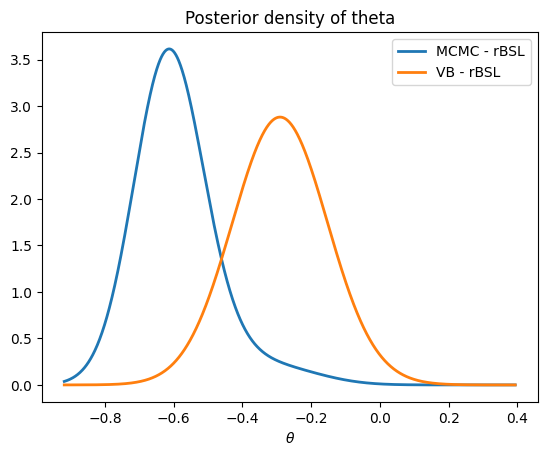

In [39]:
plt.figure()
pos_theta_mean = np.mean(pos_w[int(num_burnin):,0])
pos_theta_std = np.std(pos_w[int(num_burnin):,0])
#x_plot_mcmc = np.arange((pos_alpha_mean-4*pos_alpha_std), (pos_alpha_mean+4*pos_alpha_std), 0.002)
x_plot = np.arange(min(pos_theta_mean-4*pos_theta_std,np.mean(best_theta)-4*np.std(best_theta)), max(pos_theta_mean+12*pos_theta_std, np.mean(best_theta)+12*np.std(best_theta)), 0.001)
kde_mcmc = KernelDensity(bandwidth=0.1, kernel='gaussian')
kde_mcmc.fit(pos_w[int(num_burnin):,0].reshape(-1, 1))
y_plot_mcmc = kde_mcmc.score_samples(x_plot.reshape(-1, 1))

#x_plot_vb = np.arange((np.mean(best_alpha)-4*np.std(best_alpha)), (np.mean(best_alpha)+4*np.std(best_alpha)), 0.002)
kde_vb = KernelDensity(bandwidth=0.1, kernel='gaussian')
kde_vb.fit(best_theta_rvbsl.reshape(-1, 1))
y_plot_vb = kde_vb.score_samples(x_plot.reshape(-1, 1))

plt.plot(x_plot, np.exp(y_plot_mcmc), '-', linewidth=2.0, label = 'MCMC - rBSL')
plt.plot(x_plot, np.exp(y_plot_vb), '-', linewidth=2.0, label = 'VB - rBSL')

# plt.axvline(x = 1.8, ymin = 0, color = 'black', label = 'True alpha')

plt.legend()
plt.xlabel(r'$\theta$')
plt.title('Posterior density of theta')
